# Importing relevant libraries

In [100]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import os
from datetime import datetime
import math

# Import Dataset

In [130]:
import pandas as pd

mitbih_train = pd.read_csv('data/mitbih_train.csv', header=None) 
mitbih_test = pd.read_csv('data/mitbih_test.csv', header=None)   

In [131]:
print(mitbih_train.shape)
print(mitbih_test.shape)

(87554, 188)
(21892, 188)


# Preprocessing Data

In [132]:
class ECGDataProcessor:
    """
    Class to handle ECG data preprocessing for multiple datasets
    """
    def __init__(self, mitbih_train_path, mitbih_test_path, incart_path):
        self.mitbih_train_path = mitbih_train_path
        self.mitbih_test_path = mitbih_test_path
        self.incart_path = incart_path
        self.scaler = StandardScaler()

    def load_and_preprocess_mitbih(self):
        """
        Load and preprocess MIT-BIH test dataset
        """
        print("Loading MIT-BIH dataset...")
        df_train = pd.read_csv(self.mitbih_train_path, header=None)
        df_test = pd.read_csv(self.mitbih_test_path, header=None)

        # Separate features and labels
        X_train = df_train.iloc[:, :-1].values
        y_train = df_train.iloc[:, -1].values
        X_test = df_test.iloc[:, :-1].values
        y_test = df_test.iloc[:, -1].values

        print(f"MIT-BIH dataset shape: {X_train.shape}")
        self._print_class_distribution("MIT-BIH", y_train)

        return X_train, y_train,X_test, y_test

    def _print_class_distribution(self, dataset_name, y):
        """
        Print class distribution for a dataset
        """
        print(f"\nClass distribution in {dataset_name} dataset:")
        classes = np.unique(y)
        for class_id in classes:
            count = np.sum(y == class_id)
            percentage = (count / len(y)) * 100
            print(f"Class {class_id}: {count} samples ({percentage:.2f}%)")

    def preprocess_mitbih_data(self):
        """
        Load and preprocess MIT-BIH test dataset
        """
        print("Loading MIT-BIH dataset...")
        df_train = pd.read_csv(self.mitbih_train_path, header=None)
        df_test = pd.read_csv(self.mitbih_test_path, header=None)

        # Separate features and labels
        X_train = df_train.iloc[:, :-1].values
        y_train = df_train.iloc[:, -1].values
        X_test = df_test.iloc[:, :-1].values
        y_test = df_test.iloc[:, -1].values

        print(f"MIT-BIH dataset shape: {X_train.shape}")
        self._print_class_distribution("MIT-BIH", y_train)

        #     # Split temp into validation and test sets
        #val_size_adjusted = val_size / (1 - test_size)
        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train,
            test_size=0.1,
            random_state=42
        )

        # Reshape for RNN input (batch_size, sequence_length, input_size)
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
        X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

        return X_train, X_val, X_test, y_train, y_val, y_test

In [105]:
class ECGDataset(Dataset):
    """
    Custom Dataset class for ECG data
    """
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def create_data_loaders(X_train, X_val, X_test, y_train, y_val, y_test, batch_size=32):
    """
    Create train, validation, and test data loaders
    """
    # Create datasets
    train_dataset = ECGDataset(X_train, y_train)
    val_dataset = ECGDataset(X_val, y_val)
    test_dataset = ECGDataset(X_test, y_test)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, val_loader, test_loader

def plot_sample_signals(X, y, dataset_name, num_samples=3):
    """
    Plot sample ECG signals from each class
    """
    classes = np.unique(y)
    fig, axes = plt.subplots(len(classes), num_samples, figsize=(15, 3*len(classes)))

    for i, class_id in enumerate(classes):
        # Get indices for current class
        class_indices = np.where(y == class_id)[0]
        # Randomly select samples
        sample_indices = np.random.choice(class_indices,
                                        min(num_samples, len(class_indices)),
                                        replace=False)

        for j, idx in enumerate(sample_indices):
            signal = X[idx].reshape(-1) if len(X[idx].shape) > 1 else X[idx]
            axes[i, j].plot(signal)
            axes[i, j].set_title(f'Class {class_id}')
            axes[i, j].set_xticks([])
            if j == 0:
                axes[i, j].set_ylabel('Amplitude')

    plt.suptitle(f'Sample ECG Signals from {dataset_name} Dataset')
    plt.tight_layout()
    plt.show()

In [106]:
incart_path = 'INCART 2-lead Arrhythmia Database.csv'
mitbih_train_path = 'data/mitbih_train.csv'
mitbih_test_path = 'data/mitbih_test.csv'

processor = ECGDataProcessor(mitbih_train_path, mitbih_test_path, incart_path)

X_train, X_val, X_test, y_train, y_val, y_test = processor.preprocess_mitbih_data()

print("\nFinal dataset sizes:")
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Loading MIT-BIH dataset...
MIT-BIH dataset shape: (87554, 187)

Class distribution in MIT-BIH dataset:
Class 0.0: 72471 samples (82.77%)
Class 1.0: 2223 samples (2.54%)
Class 2.0: 5788 samples (6.61%)
Class 3.0: 641 samples (0.73%)
Class 4.0: 6431 samples (7.35%)

Final dataset sizes:
Training set: (78798, 187, 1)
Validation set: (8756, 187, 1)
Test set: (21892, 187, 1)


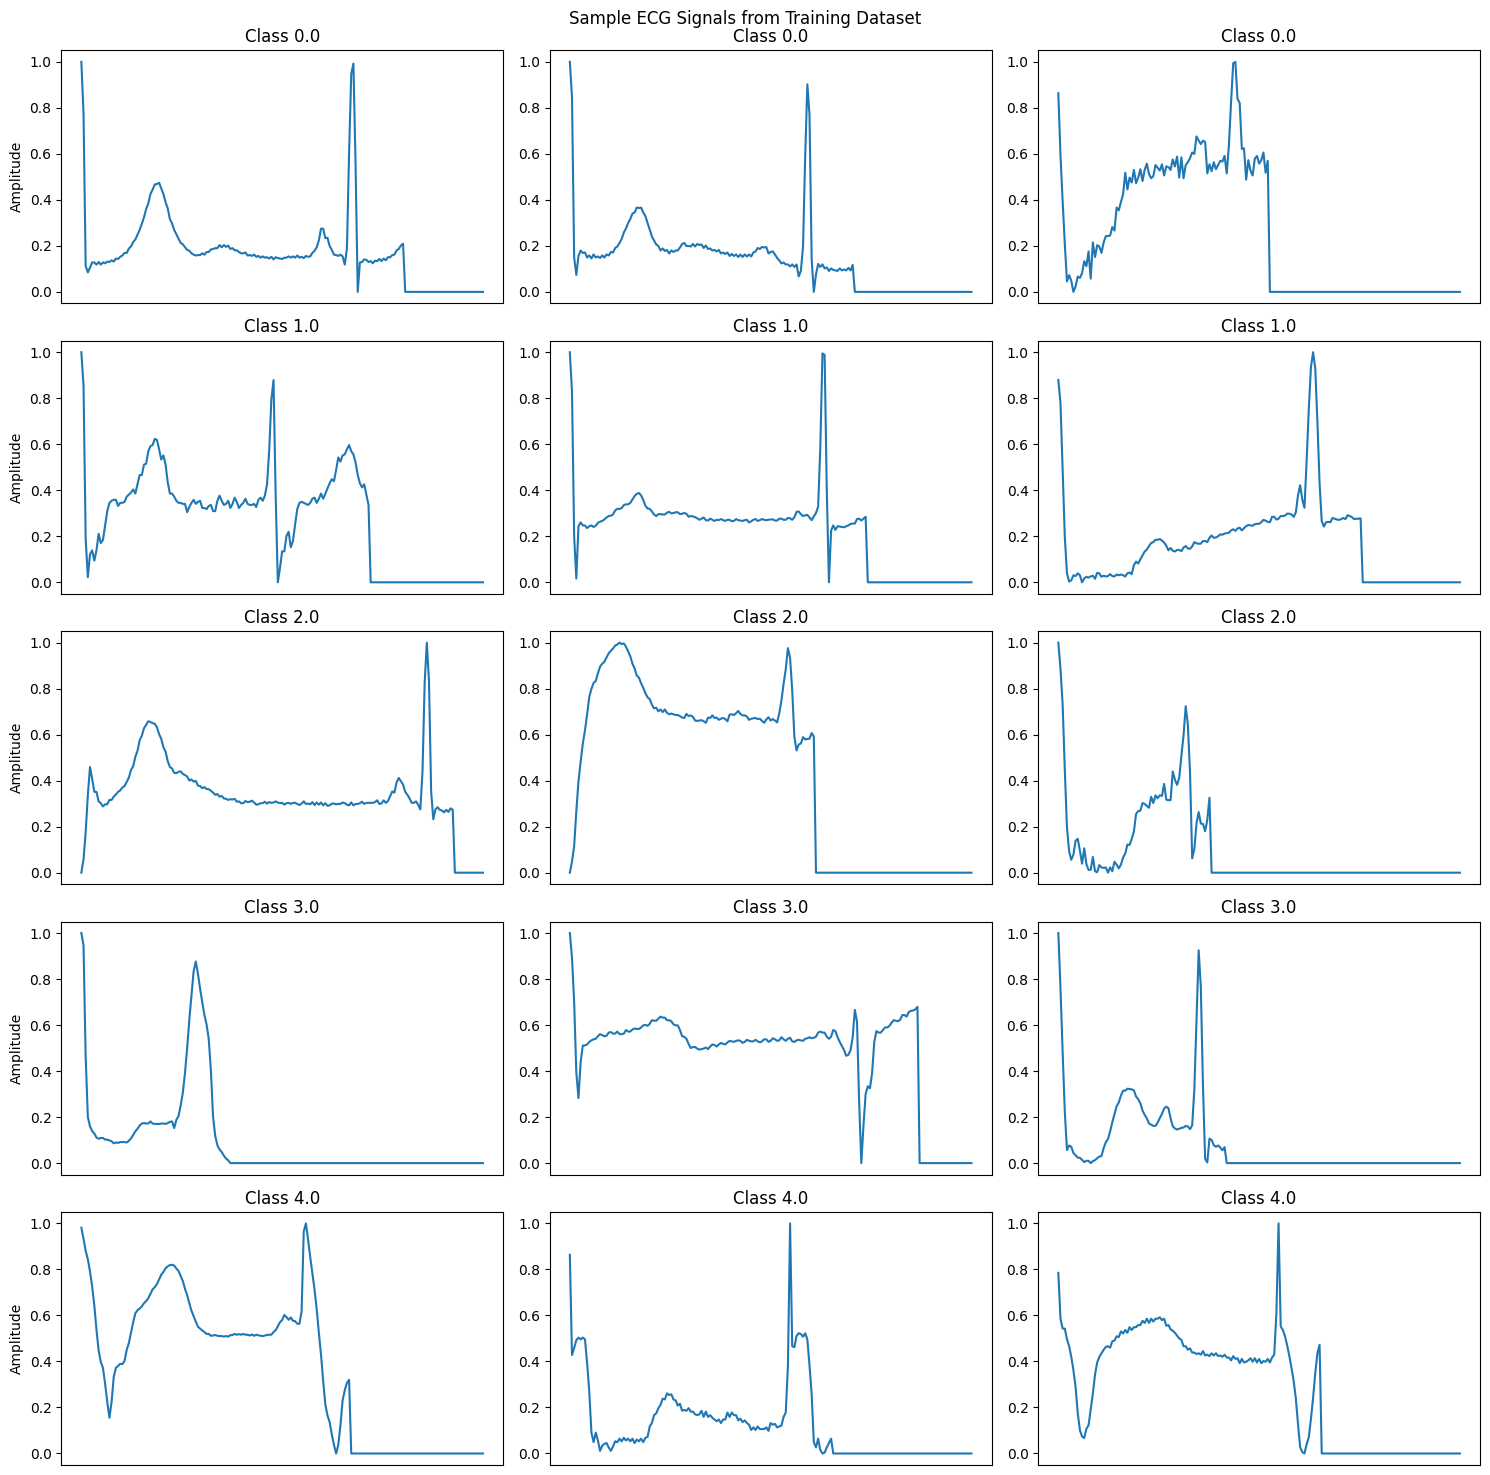


Final dataset sizes:
Training set: (78798, 187, 1)
Validation set: (8756, 187, 1)
Test set: (21892, 187, 1)


In [107]:
 # Create data loaders
train_loader, val_loader, test_loader = create_data_loaders(
    X_train, X_val, X_test, y_train, y_val, y_test
)

# Plot sample signals from each dataset
plot_sample_signals(X_train, y_train, "Training")

# Print final dataset sizes
print("\nFinal dataset sizes:")
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

### Helper Functions

In [108]:
class EarlyStopping:
    """Early stopping to stop training when validation loss doesn't improve"""
    def __init__(self, patience=7, min_delta=0, verbose=True):
        """
        Args:
            patience (int): How many epochs to wait after last improvement
            min_delta (float): Minimum change to qualify as an improvement
            verbose (bool): If True, prints a message for each validation loss improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_epoch = 0
        
    def __call__(self, val_loss, epoch):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_epoch = epoch
            if self.verbose:
                print(f'Validation loss improved to {val_loss:.4f}')
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print(f'\nEarly stopping triggered! No improvement for {self.patience} epochs.')
                    print(f'Best validation loss: {self.best_loss:.4f} at epoch {self.best_epoch + 1}')
        else:
            self.best_loss = val_loss
            self.best_epoch = epoch
            self.counter = 0
            if self.verbose:
                print(f'Validation loss improved to {val_loss:.4f}')

class CustomLRScheduler:
    def __init__(self, optimizer, initial_lr, max_lr, warmup_epochs, total_epochs):
        self.optimizer = optimizer
        self.initial_lr = initial_lr
        self.max_lr = max_lr
        self.warmup_epochs = warmup_epochs
        self.total_epochs = total_epochs
        self.current_epoch = 0

    def step(self):
        self.current_epoch += 1
        if self.current_epoch <= self.warmup_epochs:
            # Linear warmup
            lr = self.initial_lr + (self.max_lr - self.initial_lr) * (self.current_epoch / self.warmup_epochs)
        else:
            # Cosine annealing
            progress = (self.current_epoch - self.warmup_epochs) / (self.total_epochs - self.warmup_epochs)
            lr = self.initial_lr + 0.5 * (self.max_lr - self.initial_lr) * (1 + np.cos(progress * np.pi))

        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr

        return lr

class ModelTrainer:
    def __init__(self, model, model_name, device, criterion, config, early_stopping_patience=10):
        self.model = model.to(device)
        self.model_name = model_name
        self.device = device
        self.criterion = criterion
        self.config = config

        # Initialize optimizer with weight decay
        self.optimizer = optim.AdamW(
            self.model.parameters(),
            lr=config['initial_lr'],
            weight_decay=config['weight_decay']
        )

        # Initialize learning rate scheduler
        self.scheduler = CustomLRScheduler(
            self.optimizer,
            config['initial_lr'],
            config['max_lr'],
            config['warmup_epochs'],
            config['num_epochs']
        )

        # Initialize tracking metrics
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        self.best_val_loss = float('inf')
        
        # Initialize early stopping
        self.early_stopping = EarlyStopping(
            patience=early_stopping_patience,
            min_delta=0.0001,
            verbose=True
        )

        # Create directory for saving models
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        self.save_dir = os.path.join('models', f"{model_name}_{timestamp}")
        os.makedirs(self.save_dir, exist_ok=True)

    def train_epoch(self, train_loader):
        """Train for one epoch"""
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0

        for batch_X, batch_y in tqdm(train_loader, desc='Training'):
            batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)

            self.optimizer.zero_grad()

            # Handle different model outputs
            if self.model_name == 'RNN':
                outputs, _ = self.model(batch_X)
            else:
                outputs = self.model(batch_X)

            loss = self.criterion(outputs, batch_y)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

            self.optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

        epoch_loss = total_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        return epoch_loss, epoch_acc

    def validate(self, val_loader):
        """Validate the model"""
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)

                if self.model_name == 'RNN':
                    outputs, _ = self.model(batch_X)
                else:
                    outputs = self.model(batch_X)

                loss = self.criterion(outputs, batch_y)
                total_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()

        epoch_loss = total_loss / len(val_loader)
        epoch_acc = 100 * correct / total
        return epoch_loss, epoch_acc

    def train(self, train_loader, val_loader, num_epochs):
        """Complete training process with early stopping"""
        print(f"\nStarting training for {self.model_name}...")
        print(f"Early stopping enabled with patience={self.early_stopping.patience}")

        for epoch in range(num_epochs):
            # Training phase
            train_loss, train_acc = self.train_epoch(train_loader)

            # Validation phase
            val_loss, val_acc = self.validate(val_loader)

            # Update learning rate
            self.scheduler.step()
            current_lr = self.optimizer.param_groups[0]['lr']

            # Save metrics
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_accuracies.append(train_acc)
            self.val_accuracies.append(val_acc)

            # Print epoch results
            print(f'\nEpoch [{epoch+1}/{num_epochs}]')
            print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
            print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
            print(f'Learning Rate: {current_lr:.6f}')

            # Save best model
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.save_model('best_model.pth')
                print(f'✓ New best model saved! (Val Loss: {val_loss:.4f})')

            # Early stopping check
            self.early_stopping(val_loss, epoch)
            if self.early_stopping.early_stop:
                print(f'\n{"="*60}')
                print(f'Training stopped early at epoch {epoch+1}')
                print(f'Best validation loss: {self.early_stopping.best_loss:.4f}')
                print(f'Best epoch: {self.early_stopping.best_epoch + 1}')
                print(f'{"="*60}\n')
                break

        # Save final model
        self.save_model('final_model.pth')
        
        # Print training summary
        print(f'\n{"="*60}')
        print(f'Training Summary for {self.model_name}')
        print(f'{"="*60}')
        print(f'Total epochs trained: {len(self.train_losses)}')
        print(f'Best validation loss: {self.best_val_loss:.4f}')
        print(f'Final train accuracy: {self.train_accuracies[-1]:.2f}%')
        print(f'Final validation accuracy: {self.val_accuracies[-1]:.2f}%')
        print(f'{"="*60}\n')

    def save_model(self, filename):
        """Save model checkpoint"""
        path = os.path.join(self.save_dir, filename)
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'train_accuracies': self.train_accuracies,
            'val_accuracies': self.val_accuracies,
            'config': self.config,
            'best_val_loss': self.best_val_loss,
            'early_stopping_info': {
                'stopped_early': self.early_stopping.early_stop,
                'best_epoch': self.early_stopping.best_epoch,
                'patience': self.early_stopping.patience
            }
        }, path)

    def plot_training_history(self):
        """Plot training metrics with early stopping indicator"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        epochs = range(1, len(self.train_losses) + 1)

        # Plot losses
        ax1.plot(epochs, self.train_losses, label='Training Loss', marker='o', markersize=3)
        ax1.plot(epochs, self.val_losses, label='Validation Loss', marker='s', markersize=3)
        
        # Mark best epoch
        best_epoch = self.early_stopping.best_epoch + 1
        if best_epoch <= len(self.val_losses):
            ax1.axvline(x=best_epoch, color='r', linestyle='--', alpha=0.5, label=f'Best Epoch ({best_epoch})')
        
        ax1.set_title(f'{self.model_name} - Training History (Loss)')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Plot accuracies
        ax2.plot(epochs, self.train_accuracies, label='Training Accuracy', marker='o', markersize=3)
        ax2.plot(epochs, self.val_accuracies, label='Validation Accuracy', marker='s', markersize=3)
        
        # Mark best epoch
        if best_epoch <= len(self.val_accuracies):
            ax2.axvline(x=best_epoch, color='r', linestyle='--', alpha=0.5, label=f'Best Epoch ({best_epoch})')
        
        ax2.set_title(f'{self.model_name} - Training History (Accuracy)')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(os.path.join(self.save_dir, 'training_history.png'), dpi=300, bbox_inches='tight')
        plt.show()

    def evaluate(self, test_loader):
        self.model.eval()
        predictions = []
        true_labels = []

        with torch.no_grad():
            for batch_X, batch_y in tqdm(test_loader, desc='Testing'):
                batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)

                if self.model_name == 'RNN':
                    outputs, _ = self.model(batch_X)
                else:
                    outputs = self.model(batch_X)

                _, predicted = torch.max(outputs.data, 1)
                predictions.extend(predicted.cpu().numpy())
                true_labels.extend(batch_y.cpu().numpy())

        # Convert to numpy arrays for easier calculation
        predictions = np.array(predictions)
        true_labels = np.array(true_labels)
        
        # Calculate accuracy
        accuracy = 100 * np.sum(predictions == true_labels) / len(true_labels)
        
        # Print classification report
        print(f"\nClassification Report ({self.model_name}):")
        print(classification_report(true_labels, predictions))

        # Plot confusion matrix
        cm = confusion_matrix(true_labels, predictions)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix ({self.model_name})')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.savefig(os.path.join(self.save_dir, 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
        plt.show()
        
        # Return results dictionary
        return {
            'accuracy': accuracy,
            'predictions': predictions,
            'true_labels': true_labels,
            'confusion_matrix': cm
        }

# CNN From the Research Paper
https://arxiv.org/pdf/1805.00794

# Hyperparameter Tuning 

## CNN Architecture

In [109]:
class FinalResidualBlock(nn.Module):
    """
    Final residual block with validation
    """
    def __init__(self, in_channels, out_channels, kernel_size=5, pool_size=5, pool_stride=2):
        super(FinalResidualBlock, self).__init__()
        
        # First conv layer
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, 
                               padding=kernel_size//2)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu1 = nn.ReLU()
        
        # Second conv layer
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size, 
                               padding=kernel_size//2)
        self.bn2 = nn.BatchNorm1d(out_channels)
        
        # Skip connection
        self.skip_connection = nn.Conv1d(in_channels, out_channels, kernel_size=1) \
            if in_channels != out_channels else nn.Identity()
        
        # ReLU after adding skip connection
        self.relu2 = nn.ReLU()
        
        # Max pooling
        self.pool = nn.MaxPool1d(kernel_size=pool_size, stride=pool_stride)
        
    def forward(self, x):
        # Store input for skip connection
        identity = self.skip_connection(x)
        
        # First conv block
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        
        # Second conv block
        out = self.conv2(out)
        out = self.bn2(out)
        
        # Add skip connection
        out = out + identity
        out = self.relu2(out)
        
        # Max pooling
        out = self.pool(out)
        
        return out

def calculate_output_length(input_length, kernel_size, stride, padding=0):
    """Calculate output length after conv/pool operation"""
    return math.floor((input_length + 2 * padding - kernel_size) / stride + 1)


def validate_architecture(sequence_length, num_res_blocks, pool_size, pool_stride):
    """
    Validate that the architecture won't cause sequence length to become 0
    
    Returns:
        (valid, final_length, error_message)
    """
    current_length = sequence_length
    
    for i in range(num_res_blocks):
        # After maxpool
        current_length = calculate_output_length(current_length, pool_size, pool_stride)
        
        if current_length <= 0:
            return False, 0, f"Sequence becomes 0 at block {i+1}/{num_res_blocks}"
    
    if current_length < 1:
        return False, current_length, "Final sequence length too small"
    
    return True, current_length, "Valid"

class FlexibleFinalCNN(nn.Module):
    """
    Flexible final CNN with validation to prevent pooling errors
    """
    def __init__(self, input_channels=1, num_classes=5, num_filters=32, 
                 kernel_size=5, num_res_blocks=5, pool_size=5, pool_stride=2,
                 fc_neurons=32, dropout_rate=0.3, sequence_length=187,
                 constant_filters=True):
        super(FlexibleFinalCNN, self).__init__()
        
        # Validate architecture before building
        valid, final_length, msg = validate_architecture(
            sequence_length, num_res_blocks, pool_size, pool_stride
        )
        
        if not valid:
            raise ValueError(
                f"Invalid architecture: {msg}\n"
                f"Input length: {sequence_length}, Blocks: {num_res_blocks}, "
                f"Pool: {pool_size}/{pool_stride}\n"
                f"Try: fewer blocks, smaller pool_size, or larger pool_stride"
            )
        
        self.num_res_blocks = num_res_blocks
        self.constant_filters = constant_filters
        
        # Build residual blocks dynamically
        self.res_blocks = nn.ModuleList()
        current_filters = input_channels
        
        for i in range(num_res_blocks):
            if constant_filters:
                out_filters = num_filters
            else:
                out_filters = min(num_filters * (2 ** (i // 2)), 256)
            
            self.res_blocks.append(
                FinalResidualBlock(
                    current_filters, 
                    out_filters,
                    kernel_size=kernel_size,
                    pool_size=pool_size,
                    pool_stride=pool_stride
                )
            )
            current_filters = out_filters
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout_rate)
        
        # Calculate flattened feature size
        self._feature_size = self._get_feature_size(input_channels, sequence_length)
        
        # Fully connected layers (paper-style: fc_neurons → fc_neurons → output)
        self.fc1 = nn.Linear(self._feature_size, fc_neurons)
        self.relu_fc1 = nn.ReLU()
        
        self.fc2 = nn.Linear(fc_neurons, fc_neurons)
        self.relu_fc2 = nn.ReLU()
        
        # Output layer
        self.fc3 = nn.Linear(fc_neurons, num_classes)
        
        # Initialize weights
        self._init_weights()
    
    def _get_feature_size(self, input_channels, sequence_length):
        """Calculate the size of flattened features after all residual blocks"""
        x = torch.randn(1, input_channels, sequence_length)
        
        for res_block in self.res_blocks:
            x = res_block(x)
        
        return x.view(1, -1).size(1)
    
    def _init_weights(self):
        """Initialize weights using He initialization for ReLU"""
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        """Forward pass"""
        # Reshape for 1D convolution
        x = x.transpose(1, 2)
        
        # Residual blocks
        for res_block in self.res_blocks:
            x = res_block(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        
        # Fully connected layers
        x = self.fc1(x)
        x = self.relu_fc1(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.relu_fc2(x)
        x = self.dropout(x)
        
        # Output layer
        x = self.fc3(x)
        
        return x
    
    def count_parameters(self):
        """Count total and trainable parameters"""
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f"\nModel Parameters:")
        print(f"Total parameters: {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,}")
        return total_params, trainable_params

## Random Search (Hyperparameter Tuning)

In [12]:
def train_and_evaluate_final(model, train_loader, val_loader, criterion, optimizer, 
                                   device, num_epochs=30, patience=10):
    """Train and evaluate model with early stopping"""
    model = model.to(device)
    best_val_acc = 0
    epochs_no_improve = 0
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()
        
        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                _, predicted = torch.max(outputs.data, 1)
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()
        
        val_acc = 100 * correct / total
        
        # Early stopping check
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= patience:
            print(f"  Early stopping at epoch {epoch+1}")
            break
    
    return best_val_acc

# Optuna for Hyperparameter Tuning

In [15]:
import optuna

c:\Users\zheng\OneDrive\Desktop\sc4001\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
def optuna_search_final(X_train, X_val, X_test, y_train, y_val, y_test,
                        n_trials=50, constant_filters=True):
    """
    Optuna-based hyperparameter search with pruning
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    sequence_length = X_train.shape[1]
    num_classes = len(np.unique(y_train))
    
    def objective(trial):
        # Suggest hyperparameters
        params = {
            'num_filters': trial.suggest_categorical('num_filters', [16, 32, 64, 128]),
            'kernel_size': trial.suggest_categorical('kernel_size', [3, 5, 7, 9]),
            'num_res_blocks': trial.suggest_int('num_res_blocks', 2, 5),
            'pool_size': trial.suggest_categorical('pool_size', [2, 3, 5]),
            'pool_stride': 2,
            'dropout_rate': trial.suggest_float('dropout_rate', 0.1, 0.5),
            'fc_neurons': trial.suggest_categorical('fc_neurons', [32, 64, 128, 256]),
            'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
            'batch_size': trial.suggest_categorical('batch_size', [32, 64, 128]),
            'weight_decay': trial.suggest_loguniform('weight_decay', 1e-5, 1e-3),
        }
        
        # Validate
        valid, final_len, msg = validate_architecture(
            sequence_length, params['num_res_blocks'], 
            params['pool_size'], params['pool_stride']
        )
        
        if not valid:
            raise optuna.exceptions.TrialPruned()
        
        try:
            # Create and train model
            model = FlexibleFinalCNN(
                input_channels=1,
                num_classes=num_classes,
                num_filters=params['num_filters'],
                kernel_size=params['kernel_size'],
                num_res_blocks=params['num_res_blocks'],
                pool_size=params['pool_size'],
                pool_stride=params['pool_stride'],
                fc_neurons=params['fc_neurons'],
                dropout_rate=params['dropout_rate'],
                sequence_length=sequence_length,
                constant_filters=constant_filters
            )
            
            train_loader = DataLoader(
                ECGDataset(X_train, y_train),
                batch_size=params['batch_size'],
                shuffle=True,
                num_workers=0
            )
            val_loader = DataLoader(
                ECGDataset(X_val, y_val),
                batch_size=params['batch_size'],
                num_workers=0
            )
            
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.AdamW(
                model.parameters(),
                lr=params['learning_rate'],
                weight_decay=params['weight_decay']
            )
            
            val_acc = train_and_evaluate_final(
                model, train_loader, val_loader,
                criterion, optimizer, device,
                num_epochs=30,
                patience=10
            )
            
            return val_acc
            
        except Exception as e:
            print(f"Error: {e}")
            raise optuna.exceptions.TrialPruned()
    
    # Create study and optimize
    study = optuna.create_study(
        direction='maximize',
        pruner=optuna.pruners.MedianPruner()  # Prune bad trials early
    )
    
    study.optimize(objective, n_trials=n_trials)
    
    # Results
    print(f"\n{'='*70}")
    print(f"OPTUNA OPTIMIZATION COMPLETE")
    print(f"{'='*70}")
    print(f"Best validation accuracy: {study.best_value:.2f}%")
    print(f"\nBest parameters:")
    for key, value in study.best_params.items():
        print(f"  {key}: {value}")
    
    # Convert to your format
    results_sorted = sorted(
        [{'params': t.params, 'val_accuracy': t.value} 
         for t in study.trials if t.value is not None],
        key=lambda x: x['val_accuracy'],
        reverse=True
    )
    
    return study, study.best_params, results_sorted

In [16]:
study, best_params_optuna, results_sorted_optuna = optuna_search_final(
    X_train, X_val, X_test,
    y_train, y_val, y_test,
    n_trials=50,
    constant_filters=True
)

[I 2025-11-11 22:10:09,031] A new study created in memory with name: no-name-99f5af10-ebd8-4769-b204-e04a4e0e7683
C:\Users\zheng\AppData\Local\Temp\ipykernel_5716\437105236.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
C:\Users\zheng\AppData\Local\Temp\ipykernel_5716\437105236.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'weight_decay': trial.suggest_loguniform('weight_decay', 1e-5, 1e-3),
[I 2025-11-11 22:18:06,464] Trial 0 finished with value: 96.80219278209228 and parameters: {'num_filters': 64, 'kernel_size': 5, 'num_res_blocks': 3, 'pool_size': 3, 'dropout_rate': 0.28776055895301

  Early stopping at epoch 11


[I 2025-11-11 23:04:36,502] Trial 11 finished with value: 98.73229785290087 and parameters: {'num_filters': 32, 'kernel_size': 9, 'num_res_blocks': 3, 'pool_size': 5, 'dropout_rate': 0.2639603657514264, 'fc_neurons': 64, 'learning_rate': 0.0004387704580609649, 'batch_size': 64, 'weight_decay': 7.886142923747807e-05}. Best is trial 11 with value: 98.73229785290087.
[I 2025-11-11 23:10:05,030] Trial 12 finished with value: 98.60666971219734 and parameters: {'num_filters': 128, 'kernel_size': 9, 'num_res_blocks': 3, 'pool_size': 5, 'dropout_rate': 0.25098958522383286, 'fc_neurons': 64, 'learning_rate': 0.0002466315028161452, 'batch_size': 64, 'weight_decay': 0.00017093490594763622}. Best is trial 11 with value: 98.73229785290087.
[I 2025-11-11 23:13:11,159] Trial 13 finished with value: 98.02421196893559 and parameters: {'num_filters': 32, 'kernel_size': 3, 'num_res_blocks': 2, 'pool_size': 5, 'dropout_rate': 0.19853549519172492, 'fc_neurons': 64, 'learning_rate': 0.00020732746419501334, 

  Early stopping at epoch 30


[I 2025-11-12 00:05:18,688] Trial 24 finished with value: 98.36683417085428 and parameters: {'num_filters': 64, 'kernel_size': 9, 'num_res_blocks': 2, 'pool_size': 5, 'dropout_rate': 0.34621113700141165, 'fc_neurons': 256, 'learning_rate': 0.00014252992364954025, 'batch_size': 64, 'weight_decay': 5.2553755442911944e-05}. Best is trial 21 with value: 98.76656007309273.
[I 2025-11-12 00:14:15,245] Trial 25 finished with value: 98.90360895386021 and parameters: {'num_filters': 128, 'kernel_size': 9, 'num_res_blocks': 3, 'pool_size': 5, 'dropout_rate': 0.3074436894630749, 'fc_neurons': 256, 'learning_rate': 0.0006441399460965149, 'batch_size': 32, 'weight_decay': 0.00012994513478254612}. Best is trial 25 with value: 98.90360895386021.
[I 2025-11-12 00:22:18,000] Trial 26 finished with value: 98.77798081315669 and parameters: {'num_filters': 128, 'kernel_size': 9, 'num_res_blocks': 3, 'pool_size': 2, 'dropout_rate': 0.30889950421555007, 'fc_neurons': 256, 'learning_rate': 0.0003201698942153

  Early stopping at epoch 27


[I 2025-11-12 00:28:37,640] Trial 27 finished with value: 97.64732754682504 and parameters: {'num_filters': 128, 'kernel_size': 3, 'num_res_blocks': 2, 'pool_size': 2, 'dropout_rate': 0.3089261049544606, 'fc_neurons': 256, 'learning_rate': 5.7392620488971864e-05, 'batch_size': 32, 'weight_decay': 0.00011810613743743425}. Best is trial 25 with value: 98.90360895386021.
[I 2025-11-12 00:37:00,678] Trial 28 finished with value: 98.75513933302878 and parameters: {'num_filters': 128, 'kernel_size': 5, 'num_res_blocks': 3, 'pool_size': 2, 'dropout_rate': 0.2324314932812347, 'fc_neurons': 256, 'learning_rate': 0.0003130428132465705, 'batch_size': 32, 'weight_decay': 0.00031658813626976145}. Best is trial 25 with value: 98.90360895386021.
[I 2025-11-12 00:46:43,723] Trial 29 finished with value: 98.77798081315669 and parameters: {'num_filters': 128, 'kernel_size': 5, 'num_res_blocks': 4, 'pool_size': 2, 'dropout_rate': 0.28906574609302815, 'fc_neurons': 256, 'learning_rate': 0.0001410249503007

  Early stopping at epoch 29


[I 2025-11-12 01:23:59,199] Trial 33 finished with value: 98.82366377341252 and parameters: {'num_filters': 128, 'kernel_size': 5, 'num_res_blocks': 4, 'pool_size': 2, 'dropout_rate': 0.26019116174309137, 'fc_neurons': 256, 'learning_rate': 0.00013320492996259935, 'batch_size': 32, 'weight_decay': 0.0001358258206480669}. Best is trial 25 with value: 98.90360895386021.
[I 2025-11-12 01:35:09,122] Trial 34 finished with value: 98.65235267245318 and parameters: {'num_filters': 128, 'kernel_size': 5, 'num_res_blocks': 5, 'pool_size': 2, 'dropout_rate': 0.25056736174170957, 'fc_neurons': 256, 'learning_rate': 3.706751317041764e-05, 'batch_size': 32, 'weight_decay': 9.515334402017044e-05}. Best is trial 25 with value: 98.90360895386021.
[I 2025-11-12 01:43:47,399] Trial 35 finished with value: 98.82366377341252 and parameters: {'num_filters': 128, 'kernel_size': 9, 'num_res_blocks': 3, 'pool_size': 2, 'dropout_rate': 0.2133729340476024, 'fc_neurons': 256, 'learning_rate': 0.00032542394372735

  Early stopping at epoch 25


[I 2025-11-12 03:02:27,538] Trial 43 finished with value: 98.48104157149383 and parameters: {'num_filters': 16, 'kernel_size': 7, 'num_res_blocks': 4, 'pool_size': 2, 'dropout_rate': 0.1081195905300986, 'fc_neurons': 32, 'learning_rate': 0.00017592734979506928, 'batch_size': 32, 'weight_decay': 0.0003659428188727117}. Best is trial 40 with value: 98.91502969392417.
[I 2025-11-12 03:12:38,159] Trial 44 finished with value: 98.74371859296483 and parameters: {'num_filters': 128, 'kernel_size': 7, 'num_res_blocks': 4, 'pool_size': 2, 'dropout_rate': 0.24019520072465952, 'fc_neurons': 256, 'learning_rate': 8.151355888248787e-05, 'batch_size': 32, 'weight_decay': 0.0006449146440976044}. Best is trial 40 with value: 98.91502969392417.
[I 2025-11-12 03:17:01,812] Trial 45 finished with value: 98.61809045226131 and parameters: {'num_filters': 128, 'kernel_size': 7, 'num_res_blocks': 4, 'pool_size': 2, 'dropout_rate': 0.2685993005589877, 'fc_neurons': 256, 'learning_rate': 0.00011749474731879147

  Early stopping at epoch 29

OPTUNA OPTIMIZATION COMPLETE
Best validation accuracy: 98.92%

Best parameters:
  num_filters: 128
  kernel_size: 7
  num_res_blocks: 4
  pool_size: 2
  dropout_rate: 0.23327083095973541
  fc_neurons: 256
  learning_rate: 0.0002565523450914082
  batch_size: 32
  weight_decay: 0.00034447901825992793


## Batch size 2048

In [121]:
def optuna_search_final(X_train, X_val, X_test, y_train, y_val, y_test,
                        n_trials=50, constant_filters=True, timeout=None):
    """
    Optuna-based hyperparameter search with pruning and detailed logging
    """
    import time
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    sequence_length = X_train.shape[1]
    num_classes = len(np.unique(y_train))
    
    print("="*70)
    print("OPTUNA SEARCH: Final Model")
    print("="*70)
    print(f"Trials: {n_trials}")
    print(f"Device: {device}")
    print(f"Sequence length: {sequence_length}, Classes: {num_classes}")
    print(f"Filter mode: {'CONSTANT' if constant_filters else 'SCALING'}")
    print("="*70 + "\n")
    
    def objective(trial):
        trial_start_time = time.time()
        epoch_timeout = 60  # Maximum seconds per epoch
        
        # Suggest hyperparameters
        params = {
            'num_filters': trial.suggest_categorical('num_filters', [16, 32, 64, 128]),
            'kernel_size': trial.suggest_categorical('kernel_size', [3, 5, 7, 9]),
            'num_res_blocks': trial.suggest_int('num_res_blocks', 2, 5),
            'pool_size': trial.suggest_categorical('pool_size', [2, 3, 5]),
            'pool_stride': 2,
            'dropout_rate': trial.suggest_float('dropout_rate', 0.1, 0.5),
            'fc_neurons': trial.suggest_categorical('fc_neurons', [32, 64, 128, 256]),
            'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True),
            'batch_size': trial.suggest_categorical('batch_size', [2048]),
            'weight_decay': trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True),
        }
        
        # Validate architecture
        valid, final_len, msg = validate_architecture(
            sequence_length, params['num_res_blocks'], 
            params['pool_size'], params['pool_stride']
        )
        
        if not valid:
            print(f"⊘ Trial {trial.number}: Invalid - {msg}")
            raise optuna.exceptions.TrialPruned()
        
        print(f"\n{'='*70}")
        print(f"Trial {trial.number}")
        print(f"{'='*70}")
        print(f"Filters: {params['num_filters']} × {params['num_res_blocks']} blocks")
        print(f"Kernel: {params['kernel_size']}, Pool: {params['pool_size']}/{params['pool_stride']}")
        print(f"Dropout: {params['dropout_rate']:.3f}, FC: {params['fc_neurons']}")
        print(f"LR: {params['learning_rate']:.2e}, Batch: {params['batch_size']}, WD: {params['weight_decay']:.2e}")
        print(f"{'='*70}")
        
        try:
            # Create model
            model = FlexibleFinalCNN(
                input_channels=1,
                num_classes=num_classes,
                num_filters=params['num_filters'],
                kernel_size=params['kernel_size'],
                num_res_blocks=params['num_res_blocks'],
                pool_size=params['pool_size'],
                pool_stride=params['pool_stride'],
                fc_neurons=params['fc_neurons'],
                dropout_rate=params['dropout_rate'],
                sequence_length=sequence_length,
                constant_filters=constant_filters
            )
            
            model = model.to(device)
            print(f"  ✓ Model created and moved to {device}")
            
            # Create dataloaders
            train_loader = DataLoader(
                ECGDataset(X_train, y_train),
                batch_size=params['batch_size'],
                shuffle=True,
                num_workers=0,
                pin_memory=True if device.type == 'cuda' else False
            )
            val_loader = DataLoader(
                ECGDataset(X_val, y_val),
                batch_size=params['batch_size'],
                num_workers=0,
                pin_memory=True if device.type == 'cuda' else False
            )
            print(f"  ✓ Dataloaders created")
            
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.AdamW(
                model.parameters(),
                lr=params['learning_rate'],
                weight_decay=params['weight_decay']
            )
            
            # Training loop with detailed logging
            num_epochs = 50
            patience = 7
            best_val_acc = 0
            epochs_no_improve = 0
            
            for epoch in range(num_epochs):
                epoch_start_time = time.time()
                
                # Training
                model.train()
                train_batches = 0
                for batch_X, batch_y in train_loader:
                    # Check for timeout
                    if time.time() - epoch_start_time > epoch_timeout:
                        print(f"  ⏱️ Epoch timeout at epoch {epoch+1} (>{epoch_timeout}s)")
                        raise optuna.exceptions.TrialPruned()
                    
                    batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                    optimizer.zero_grad()
                    outputs = model(batch_X)
                    loss = criterion(outputs, batch_y)
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    optimizer.step()
                    train_batches += 1
                
                # Validation
                model.eval()
                correct = 0
                total = 0
                val_batches = 0
                with torch.no_grad():
                    for batch_X, batch_y in val_loader:
                        # Check for timeout
                        if time.time() - epoch_start_time > epoch_timeout:
                            print(f"  ⏱️ Epoch timeout at epoch {epoch+1} (>{epoch_timeout}s)")
                            raise optuna.exceptions.TrialPruned()
                        
                        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                        outputs = model(batch_X)
                        _, predicted = torch.max(outputs.data, 1)
                        total += batch_y.size(0)
                        correct += (predicted == batch_y).sum().item()
                        val_batches += 1
                
                val_acc = 100 * correct / total
                epoch_time = time.time() - epoch_start_time
                
                # Report to Optuna for pruning
                trial.report(val_acc, epoch)
                
                if trial.should_prune():
                    print(f"  ✂️ Pruned at epoch {epoch+1}")
                    raise optuna.exceptions.TrialPruned()
                
                # Early stopping check
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
                
                if epochs_no_improve >= patience:
                    print(f"  Early stopping at epoch {epoch+1}")
                    break
                
                # Print every 5 epochs OR first 3 epochs
                if (epoch + 1) % 5 == 0 or epoch < 3:
                    print(f"  Epoch {epoch+1}/{num_epochs}: Val Acc = {val_acc:.2f}% ({epoch_time:.1f}s, {train_batches} train batches, {val_batches} val batches)")
            
            total_time = time.time() - trial_start_time
            print(f"  ✓ Final Val Acc: {best_val_acc:.2f}% (Total time: {total_time:.1f}s)")
            
            # Clear GPU cache if using CUDA
            if device.type == 'cuda':
                del model
                torch.cuda.empty_cache()
            
            return best_val_acc
            
        except optuna.exceptions.TrialPruned:
            # Clear GPU cache
            if device.type == 'cuda':
                torch.cuda.empty_cache()
            raise
        except Exception as e:
            print(f"  ✗ Error: {str(e)}")
            import traceback
            traceback.print_exc()
            # Clear GPU cache
            if device.type == 'cuda':
                torch.cuda.empty_cache()
            raise optuna.exceptions.TrialPruned()
    
    # Create study and optimize
    study = optuna.create_study(
        direction='maximize',
        pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=10),
        sampler=TPESampler(seed=42)
    )
    
    # Optimize with exception catching
    study.optimize(
        objective, 
        n_trials=n_trials, 
        timeout=timeout, 
        show_progress_bar=True,
        catch=(Exception,)  # Continue even if a trial crashes
    )
    
    # Print results
    print(f"\n{'='*70}")
    print(f"OPTUNA OPTIMIZATION COMPLETE")
    print(f"{'='*70}")
    print(f"Finished trials: {len(study.trials)}")
    print(f"Pruned: {len([t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED])}")
    print(f"Complete: {len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])}")
    print(f"Failed: {len([t for t in study.trials if t.state == optuna.trial.TrialState.FAIL])}")
    
    if len([t for t in study.trials if t.value is not None]) > 0:
        print(f"\nBest trial: {study.best_trial.number}")
        print(f"Best validation accuracy: {study.best_value:.2f}%")
        print(f"\nBest hyperparameters:")
        print(f"{'='*70}")
        for key, value in study.best_trial.params.items():
            print(f"  {key:20s}: {value}")
        print(f"{'='*70}")
    else:
        print("\n⚠️ No successful trials completed!")
    
    # Convert to your format
    results_sorted = sorted(
        [{'params': {**t.params, 'pool_stride': 2},
          'val_accuracy': t.value, 'trial_number': t.number, 'state': t.state.name}
         for t in study.trials if t.value is not None],
        key=lambda x: x['val_accuracy'],
        reverse=True
    )
    
    best_params = {**study.best_trial.params, 'pool_stride': 2} if len(results_sorted) > 0 else None
    
    return study, best_params, results_sorted

In [122]:
study, best_params_optuna, results_sorted_optuna = optuna_search_final(
    X_train, X_val, X_test,
    y_train, y_val, y_test,
    n_trials=50,
    constant_filters=True
)

[I 2025-11-14 10:54:15,276] A new study created in memory with name: no-name-4b36647c-a493-4f23-bcbf-ae365069396a


OPTUNA SEARCH: Final Model
Trials: 50
Device: cuda
Sequence length: 187, Classes: 5
Filter mode: CONSTANT



  0%|          | 0/50 [00:00<?, ?it/s]


Trial 0
Filters: 32 × 4 blocks
Kernel: 9, Pool: 5/2
Dropout: 0.433, FC: 256
LR: 1.12e-04, Batch: 2048, WD: 1.98e-05
  ✓ Model created and moved to cuda
  ✓ Dataloaders created
  Epoch 1/50: Val Acc = 83.35% (4.5s, 39 train batches, 5 val batches)
  Epoch 2/50: Val Acc = 89.54% (4.5s, 39 train batches, 5 val batches)
  Epoch 3/50: Val Acc = 91.59% (4.4s, 39 train batches, 5 val batches)
  Epoch 5/50: Val Acc = 92.17% (4.2s, 39 train batches, 5 val batches)
  Epoch 10/50: Val Acc = 93.46% (4.4s, 39 train batches, 5 val batches)
  Epoch 15/50: Val Acc = 93.47% (4.4s, 39 train batches, 5 val batches)
  Epoch 20/50: Val Acc = 94.29% (4.4s, 39 train batches, 5 val batches)
  Epoch 25/50: Val Acc = 95.96% (4.3s, 39 train batches, 5 val batches)
  Epoch 30/50: Val Acc = 96.45% (4.3s, 39 train batches, 5 val batches)
  Epoch 35/50: Val Acc = 96.45% (4.3s, 39 train batches, 5 val batches)
  Epoch 40/50: Val Acc = 96.64% (4.4s, 39 train batches, 5 val batches)
  Epoch 45/50: Val Acc = 97.09% (4.

Best trial: 0. Best value: 97.5331:   2%|▏         | 1/50 [03:38<2:58:22, 218.42s/it]

[I 2025-11-14 10:57:53,695] Trial 0 finished with value: 97.53312014618547 and parameters: {'num_filters': 32, 'kernel_size': 9, 'num_res_blocks': 4, 'pool_size': 5, 'dropout_rate': 0.4329770563201687, 'fc_neurons': 256, 'learning_rate': 0.00011207606211860574, 'batch_size': 2048, 'weight_decay': 1.9762189340280066e-05}. Best is trial 0 with value: 97.53312014618547.

Trial 1
Filters: 32 × 4 blocks
Kernel: 7, Pool: 5/2
Dropout: 0.168, FC: 128
LR: 4.07e-05, Batch: 2048, WD: 1.96e-06
  ✓ Model created and moved to cuda
  ✓ Dataloaders created
  Epoch 1/50: Val Acc = 83.35% (1.8s, 39 train batches, 5 val batches)
  Epoch 2/50: Val Acc = 88.64% (1.5s, 39 train batches, 5 val batches)
  Epoch 3/50: Val Acc = 90.20% (1.7s, 39 train batches, 5 val batches)
  Epoch 5/50: Val Acc = 92.63% (1.5s, 39 train batches, 5 val batches)
  Epoch 10/50: Val Acc = 94.29% (1.5s, 39 train batches, 5 val batches)
  Epoch 15/50: Val Acc = 95.18% (1.7s, 39 train batches, 5 val batches)
  Epoch 20/50: Val Acc = 

Best trial: 0. Best value: 97.5331:   4%|▍         | 2/50 [04:11<1:27:31, 109.41s/it]

  Early stopping at epoch 21
  ✓ Final Val Acc: 95.36% (Total time: 33.1s)
[I 2025-11-14 10:58:26,801] Trial 1 finished with value: 95.3631795340338 and parameters: {'num_filters': 32, 'kernel_size': 7, 'num_res_blocks': 4, 'pool_size': 5, 'dropout_rate': 0.16820964947491662, 'fc_neurons': 128, 'learning_rate': 4.066563313514796e-05, 'batch_size': 2048, 'weight_decay': 1.9634341572933354e-06}. Best is trial 0 with value: 97.53312014618547.

Trial 2
Filters: 16 × 3 blocks
Kernel: 5, Pool: 3/2
Dropout: 0.488, FC: 64
LR: 6.98e-04, Batch: 2048, WD: 1.84e-06
  ✓ Model created and moved to cuda
  ✓ Dataloaders created
  Epoch 1/50: Val Acc = 83.35% (1.0s, 39 train batches, 5 val batches)
  Epoch 2/50: Val Acc = 83.35% (1.2s, 39 train batches, 5 val batches)
  Epoch 3/50: Val Acc = 83.35% (1.0s, 39 train batches, 5 val batches)
  Epoch 5/50: Val Acc = 83.35% (1.0s, 39 train batches, 5 val batches)
  Epoch 10/50: Val Acc = 88.66% (1.2s, 39 train batches, 5 val batches)
  Epoch 15/50: Val Acc =

Best trial: 0. Best value: 97.5331:   6%|▌         | 3/50 [04:45<58:41, 74.93s/it]   

  Early stopping at epoch 31
  ✓ Final Val Acc: 94.68% (Total time: 33.9s)
[I 2025-11-14 10:59:00,697] Trial 2 finished with value: 94.67793513019643 and parameters: {'num_filters': 16, 'kernel_size': 5, 'num_res_blocks': 3, 'pool_size': 3, 'dropout_rate': 0.48783385110582345, 'fc_neurons': 64, 'learning_rate': 0.0006978281265126031, 'batch_size': 2048, 'weight_decay': 1.8427970406864558e-06}. Best is trial 0 with value: 97.53312014618547.

Trial 3
Filters: 128 × 4 blocks
Kernel: 5, Pool: 3/2
Dropout: 0.495, FC: 256
LR: 2.59e-04, Batch: 2048, WD: 1.54e-04
  ✓ Model created and moved to cuda
  ✓ Dataloaders created
  Epoch 1/50: Val Acc = 83.35% (6.2s, 39 train batches, 5 val batches)
  Epoch 2/50: Val Acc = 84.39% (6.2s, 39 train batches, 5 val batches)
  Epoch 3/50: Val Acc = 86.91% (6.2s, 39 train batches, 5 val batches)
  Epoch 5/50: Val Acc = 89.25% (6.3s, 39 train batches, 5 val batches)
  Epoch 10/50: Val Acc = 89.80% (6.2s, 39 train batches, 5 val batches)
  Epoch 15/50: Val Acc

Best trial: 0. Best value: 97.5331:   8%|▊         | 4/50 [09:58<2:09:29, 168.90s/it]

  Epoch 50/50: Val Acc = 95.76% (6.3s, 39 train batches, 5 val batches)
  ✓ Final Val Acc: 95.76% (Total time: 312.9s)
[I 2025-11-14 11:04:13,664] Trial 3 finished with value: 95.76290543627228 and parameters: {'num_filters': 128, 'kernel_size': 5, 'num_res_blocks': 4, 'pool_size': 3, 'dropout_rate': 0.4947547746402069, 'fc_neurons': 256, 'learning_rate': 0.0002592475660475158, 'batch_size': 2048, 'weight_decay': 0.00015382308040278996}. Best is trial 0 with value: 97.53312014618547.

Trial 4
Filters: 16 × 3 blocks
Kernel: 3, Pool: 3/2
Dropout: 0.455, FC: 256
LR: 1.33e-04, Batch: 2048, WD: 2.06e-04
  ✓ Model created and moved to cuda
  ✓ Dataloaders created
  Epoch 1/50: Val Acc = 83.35% (1.2s, 39 train batches, 5 val batches)
  Epoch 2/50: Val Acc = 86.36% (0.9s, 39 train batches, 5 val batches)
  Epoch 3/50: Val Acc = 87.37% (0.9s, 39 train batches, 5 val batches)
  Epoch 5/50: Val Acc = 88.28% (0.9s, 39 train batches, 5 val batches)
  Epoch 10/50: Val Acc = 85.98% (0.9s, 39 train ba

Best trial: 0. Best value: 97.5331:  10%|█         | 5/50 [10:09<1:24:01, 112.02s/it]

  Early stopping at epoch 11
  ✓ Final Val Acc: 88.81% (Total time: 11.2s)
[I 2025-11-14 11:04:24,833] Trial 4 finished with value: 88.80767473732298 and parameters: {'num_filters': 16, 'kernel_size': 3, 'num_res_blocks': 3, 'pool_size': 3, 'dropout_rate': 0.4548850970305306, 'fc_neurons': 256, 'learning_rate': 0.0001326033192269654, 'batch_size': 2048, 'weight_decay': 0.00020554245520150764}. Best is trial 0 with value: 97.53312014618547.

Trial 5
Filters: 32 × 4 blocks
Kernel: 7, Pool: 2/2
Dropout: 0.402, FC: 128
LR: 7.23e-04, Batch: 2048, WD: 2.66e-04
  ✓ Model created and moved to cuda
  ✓ Dataloaders created
  Epoch 1/50: Val Acc = 82.99% (1.8s, 39 train batches, 5 val batches)
  Epoch 2/50: Val Acc = 89.04% (1.6s, 39 train batches, 5 val batches)
  Epoch 3/50: Val Acc = 90.34% (1.6s, 39 train batches, 5 val batches)
  Epoch 5/50: Val Acc = 93.31% (1.6s, 39 train batches, 5 val batches)
  Epoch 10/50: Val Acc = 95.32% (1.7s, 39 train batches, 5 val batches)
  Epoch 15/50: Val Acc 

Best trial: 5. Best value: 98.481:  12%|█▏        | 6/50 [11:30<1:14:22, 101.41s/it] 

  Epoch 50/50: Val Acc = 98.46% (1.5s, 39 train batches, 5 val batches)
  ✓ Final Val Acc: 98.48% (Total time: 80.8s)
[I 2025-11-14 11:05:45,651] Trial 5 finished with value: 98.48104157149383 and parameters: {'num_filters': 32, 'kernel_size': 7, 'num_res_blocks': 4, 'pool_size': 2, 'dropout_rate': 0.4022204554172195, 'fc_neurons': 128, 'learning_rate': 0.0007234279845665417, 'batch_size': 2048, 'weight_decay': 0.00026568139241144923}. Best is trial 5 with value: 98.48104157149383.

Trial 6
Filters: 32 × 3 blocks
Kernel: 9, Pool: 5/2
Dropout: 0.427, FC: 32
LR: 2.78e-05, Batch: 2048, WD: 2.29e-06
  ✓ Model created and moved to cuda
  ✓ Dataloaders created
  Epoch 1/50: Val Acc = 26.54% (4.0s, 39 train batches, 5 val batches)
  Epoch 2/50: Val Acc = 80.20% (3.9s, 39 train batches, 5 val batches)
  Epoch 3/50: Val Acc = 83.35% (3.9s, 39 train batches, 5 val batches)
  Epoch 5/50: Val Acc = 84.86% (3.9s, 39 train batches, 5 val batches)
  Epoch 10/50: Val Acc = 83.70% (4.0s, 39 train batch

Best trial: 5. Best value: 98.481:  14%|█▍        | 7/50 [12:13<59:00, 82.34s/it]   

  ✂️ Pruned at epoch 11
[I 2025-11-14 11:06:28,711] Trial 6 pruned. 

Trial 7
Filters: 32 × 3 blocks
Kernel: 7, Pool: 2/2
Dropout: 0.115, FC: 32
LR: 6.55e-04, Batch: 2048, WD: 5.23e-06
  ✓ Model created and moved to cuda
  ✓ Dataloaders created
  Epoch 1/50: Val Acc = 81.91% (1.4s, 39 train batches, 5 val batches)
  Epoch 2/50: Val Acc = 92.45% (1.2s, 39 train batches, 5 val batches)
  Epoch 3/50: Val Acc = 93.32% (1.2s, 39 train batches, 5 val batches)
  Epoch 5/50: Val Acc = 94.31% (1.2s, 39 train batches, 5 val batches)
  Epoch 10/50: Val Acc = 96.59% (1.4s, 39 train batches, 5 val batches)
  Epoch 15/50: Val Acc = 96.79% (1.4s, 39 train batches, 5 val batches)
  Epoch 20/50: Val Acc = 97.35% (1.2s, 39 train batches, 5 val batches)
  Epoch 25/50: Val Acc = 97.46% (1.2s, 39 train batches, 5 val batches)
  Epoch 30/50: Val Acc = 97.46% (1.2s, 39 train batches, 5 val batches)
  Epoch 35/50: Val Acc = 98.02% (1.4s, 39 train batches, 5 val batches)
  Epoch 40/50: Val Acc = 98.10% (1.4s, 

Best trial: 5. Best value: 98.481:  16%|█▌        | 8/50 [13:09<51:52, 74.11s/it]

  Early stopping at epoch 45
  ✓ Final Val Acc: 98.24% (Total time: 56.5s)
[I 2025-11-14 11:07:25,203] Trial 7 finished with value: 98.24120603015075 and parameters: {'num_filters': 32, 'kernel_size': 7, 'num_res_blocks': 3, 'pool_size': 2, 'dropout_rate': 0.11475477894181313, 'fc_neurons': 32, 'learning_rate': 0.0006554382343546282, 'batch_size': 2048, 'weight_decay': 5.232216089948754e-06}. Best is trial 5 with value: 98.48104157149383.

Trial 8
Filters: 64 × 3 blocks
Kernel: 5, Pool: 3/2
Dropout: 0.136, FC: 32
LR: 1.52e-04, Batch: 2048, WD: 1.08e-04
  ✓ Model created and moved to cuda
  ✓ Dataloaders created
  Epoch 1/50: Val Acc = 81.75% (2.7s, 39 train batches, 5 val batches)
  Epoch 2/50: Val Acc = 91.02% (2.5s, 39 train batches, 5 val batches)
  Epoch 3/50: Val Acc = 91.49% (2.7s, 39 train batches, 5 val batches)
  Epoch 5/50: Val Acc = 91.35% (2.5s, 39 train batches, 5 val batches)
  Epoch 10/50: Val Acc = 93.99% (2.5s, 39 train batches, 5 val batches)
  Epoch 15/50: Val Acc = 

Best trial: 5. Best value: 98.481:  18%|█▊        | 9/50 [14:09<47:29, 69.50s/it]

  ✂️ Pruned at epoch 23
[I 2025-11-14 11:08:24,555] Trial 8 pruned. 

Trial 9
Filters: 128 × 2 blocks
Kernel: 9, Pool: 5/2
Dropout: 0.451, FC: 128
LR: 1.15e-04, Batch: 2048, WD: 5.32e-06
  ✓ Model created and moved to cuda
  ✓ Dataloaders created
  Epoch 1/50: Val Acc = 83.34% (5.9s, 39 train batches, 5 val batches)
  Epoch 2/50: Val Acc = 83.37% (6.2s, 39 train batches, 5 val batches)
  Epoch 3/50: Val Acc = 83.35% (6.0s, 39 train batches, 5 val batches)
  Epoch 5/50: Val Acc = 87.93% (6.1s, 39 train batches, 5 val batches)
  Epoch 10/50: Val Acc = 89.10% (5.9s, 39 train batches, 5 val batches)


Best trial: 5. Best value: 98.481:  20%|██        | 10/50 [15:14<45:30, 68.27s/it]

  ✂️ Pruned at epoch 11
[I 2025-11-14 11:09:30,093] Trial 9 pruned. 

Trial 10
Filters: 64 × 5 blocks
Kernel: 7, Pool: 2/2
Dropout: 0.326, FC: 128
LR: 1.07e-05, Batch: 2048, WD: 8.32e-04
  ✓ Model created and moved to cuda
  ✓ Dataloaders created
  Epoch 1/50: Val Acc = 5.81% (3.2s, 39 train batches, 5 val batches)
  Epoch 2/50: Val Acc = 76.85% (3.2s, 39 train batches, 5 val batches)
  Epoch 3/50: Val Acc = 84.13% (3.3s, 39 train batches, 5 val batches)
  Epoch 5/50: Val Acc = 89.60% (3.3s, 39 train batches, 5 val batches)
  Epoch 10/50: Val Acc = 91.67% (3.1s, 39 train batches, 5 val batches)


Best trial: 5. Best value: 98.481:  22%|██▏       | 11/50 [15:49<37:43, 58.03s/it]

  ✂️ Pruned at epoch 11
[I 2025-11-14 11:10:04,896] Trial 10 pruned. 

Trial 11
Filters: 32 × 5 blocks
Kernel: 7, Pool: 2/2
Dropout: 0.251, FC: 32
LR: 9.82e-04, Batch: 2048, WD: 1.52e-05
  ✓ Model created and moved to cuda
  ✓ Dataloaders created
  Epoch 1/50: Val Acc = 76.19% (1.8s, 39 train batches, 5 val batches)
  Epoch 2/50: Val Acc = 89.79% (1.8s, 39 train batches, 5 val batches)
  Epoch 3/50: Val Acc = 93.60% (1.9s, 39 train batches, 5 val batches)
  Epoch 5/50: Val Acc = 95.02% (1.9s, 39 train batches, 5 val batches)
  Epoch 10/50: Val Acc = 95.82% (1.8s, 39 train batches, 5 val batches)
  Epoch 15/50: Val Acc = 97.32% (1.7s, 39 train batches, 5 val batches)
  Epoch 20/50: Val Acc = 97.43% (1.8s, 39 train batches, 5 val batches)
  Epoch 25/50: Val Acc = 98.38% (1.9s, 39 train batches, 5 val batches)
  Epoch 30/50: Val Acc = 98.38% (1.9s, 39 train batches, 5 val batches)


Best trial: 5. Best value: 98.481:  24%|██▍       | 12/50 [16:52<37:46, 59.64s/it]

  Early stopping at epoch 35
  ✓ Final Val Acc: 98.45% (Total time: 63.3s)
[I 2025-11-14 11:11:08,227] Trial 11 finished with value: 98.44677935130197 and parameters: {'num_filters': 32, 'kernel_size': 7, 'num_res_blocks': 5, 'pool_size': 2, 'dropout_rate': 0.2508583581217884, 'fc_neurons': 32, 'learning_rate': 0.0009818026638994167, 'batch_size': 2048, 'weight_decay': 1.5225274680391343e-05}. Best is trial 5 with value: 98.48104157149383.

Trial 12
Filters: 32 × 5 blocks
Kernel: 7, Pool: 2/2
Dropout: 0.257, FC: 64
LR: 9.87e-04, Batch: 2048, WD: 3.08e-05
  ✓ Model created and moved to cuda
  ✓ Dataloaders created
  Epoch 1/50: Val Acc = 35.20% (1.9s, 39 train batches, 5 val batches)
  Epoch 2/50: Val Acc = 93.70% (1.8s, 39 train batches, 5 val batches)
  Epoch 3/50: Val Acc = 94.35% (1.7s, 39 train batches, 5 val batches)
  Epoch 5/50: Val Acc = 95.07% (1.7s, 39 train batches, 5 val batches)
  Epoch 10/50: Val Acc = 97.08% (1.7s, 39 train batches, 5 val batches)
  Epoch 15/50: Val Acc 

Best trial: 12. Best value: 98.6524:  26%|██▌       | 13/50 [18:05<39:16, 63.68s/it]

  Early stopping at epoch 40
  ✓ Final Val Acc: 98.65% (Total time: 73.0s)
[I 2025-11-14 11:12:21,199] Trial 12 finished with value: 98.65235267245318 and parameters: {'num_filters': 32, 'kernel_size': 7, 'num_res_blocks': 5, 'pool_size': 2, 'dropout_rate': 0.25725127010743576, 'fc_neurons': 64, 'learning_rate': 0.0009871777733751906, 'batch_size': 2048, 'weight_decay': 3.07697477916399e-05}. Best is trial 12 with value: 98.65235267245318.

Trial 13
Filters: 32 × 5 blocks
Kernel: 7, Pool: 2/2
Dropout: 0.340, FC: 64
LR: 3.52e-04, Batch: 2048, WD: 4.90e-05
  ✓ Model created and moved to cuda
  ✓ Dataloaders created
  Epoch 1/50: Val Acc = 83.14% (1.8s, 39 train batches, 5 val batches)
  Epoch 2/50: Val Acc = 88.45% (2.0s, 39 train batches, 5 val batches)
  Epoch 3/50: Val Acc = 88.62% (1.7s, 39 train batches, 5 val batches)
  Epoch 5/50: Val Acc = 91.71% (1.9s, 39 train batches, 5 val batches)
  Epoch 10/50: Val Acc = 94.63% (1.7s, 39 train batches, 5 val batches)
  Epoch 15/50: Val Acc 

Best trial: 12. Best value: 98.6524:  28%|██▊       | 14/50 [18:45<33:53, 56.48s/it]

  ✂️ Pruned at epoch 22
[I 2025-11-14 11:13:01,037] Trial 13 pruned. 

Trial 14
Filters: 32 × 5 blocks
Kernel: 3, Pool: 2/2
Dropout: 0.253, FC: 64
LR: 4.13e-04, Batch: 2048, WD: 9.73e-04
  ✓ Model created and moved to cuda
  ✓ Dataloaders created
  ⏱️ Epoch timeout at epoch 1 (>60s)


Best trial: 12. Best value: 98.6524:  30%|███       | 15/50 [20:01<36:25, 62.43s/it]

[I 2025-11-14 11:14:17,266] Trial 14 pruned. 

Trial 15
Filters: 32 × 4 blocks
Kernel: 7, Pool: 2/2
Dropout: 0.382, FC: 64
LR: 9.87e-04, Batch: 2048, WD: 5.07e-05
  ✓ Model created and moved to cuda
  ✓ Dataloaders created
  Epoch 1/50: Val Acc = 83.33% (1.6s, 39 train batches, 5 val batches)
  Epoch 2/50: Val Acc = 86.99% (1.8s, 39 train batches, 5 val batches)
  Epoch 3/50: Val Acc = 89.45% (1.6s, 39 train batches, 5 val batches)
  Epoch 5/50: Val Acc = 92.20% (1.7s, 39 train batches, 5 val batches)
  Epoch 10/50: Val Acc = 94.64% (1.5s, 39 train batches, 5 val batches)


Best trial: 12. Best value: 98.6524:  32%|███▏      | 16/50 [20:26<28:51, 50.91s/it]

  ✂️ Pruned at epoch 15
[I 2025-11-14 11:14:41,428] Trial 15 pruned. 

Trial 16
Filters: 64 × 5 blocks
Kernel: 7, Pool: 2/2
Dropout: 0.230, FC: 128
LR: 2.37e-04, Batch: 2048, WD: 3.34e-04
  ✓ Model created and moved to cuda
  ✓ Dataloaders created
  Epoch 1/50: Val Acc = 7.22% (3.0s, 39 train batches, 5 val batches)
  Epoch 2/50: Val Acc = 92.80% (3.2s, 39 train batches, 5 val batches)
  Epoch 3/50: Val Acc = 95.59% (3.0s, 39 train batches, 5 val batches)
  Epoch 5/50: Val Acc = 96.00% (3.0s, 39 train batches, 5 val batches)
  Epoch 10/50: Val Acc = 96.78% (3.1s, 39 train batches, 5 val batches)
  Epoch 15/50: Val Acc = 97.25% (3.0s, 39 train batches, 5 val batches)
  Epoch 20/50: Val Acc = 97.89% (3.0s, 39 train batches, 5 val batches)
  Epoch 25/50: Val Acc = 98.06% (3.1s, 39 train batches, 5 val batches)
  Epoch 30/50: Val Acc = 98.50% (3.2s, 39 train batches, 5 val batches)
  Epoch 35/50: Val Acc = 98.36% (3.2s, 39 train batches, 5 val batches)


Best trial: 12. Best value: 98.6524:  34%|███▍      | 17/50 [22:20<38:32, 70.09s/it]

  Early stopping at epoch 37
  ✓ Final Val Acc: 98.50% (Total time: 114.7s)
[I 2025-11-14 11:16:36,105] Trial 16 finished with value: 98.50388305162174 and parameters: {'num_filters': 64, 'kernel_size': 7, 'num_res_blocks': 5, 'pool_size': 2, 'dropout_rate': 0.23013400846730736, 'fc_neurons': 128, 'learning_rate': 0.0002374351681926268, 'batch_size': 2048, 'weight_decay': 0.00033386160104902486}. Best is trial 12 with value: 98.65235267245318.

Trial 17
Filters: 64 × 5 blocks
Kernel: 7, Pool: 2/2
Dropout: 0.217, FC: 128
LR: 5.21e-05, Batch: 2048, WD: 4.02e-04
  ✓ Model created and moved to cuda
  ✓ Dataloaders created
  Epoch 1/50: Val Acc = 72.34% (3.2s, 39 train batches, 5 val batches)
  Epoch 2/50: Val Acc = 91.79% (3.0s, 39 train batches, 5 val batches)
  Epoch 3/50: Val Acc = 94.38% (3.0s, 39 train batches, 5 val batches)
  Epoch 5/50: Val Acc = 95.24% (3.2s, 39 train batches, 5 val batches)
  Epoch 10/50: Val Acc = 95.68% (3.0s, 39 train batches, 5 val batches)


Best trial: 12. Best value: 98.6524:  36%|███▌      | 18/50 [23:07<33:33, 62.92s/it]

  ✂️ Pruned at epoch 15
[I 2025-11-14 11:17:22,334] Trial 17 pruned. 

Trial 18
Filters: 64 × 2 blocks
Kernel: 3, Pool: 2/2
Dropout: 0.189, FC: 64
LR: 2.44e-04, Batch: 2048, WD: 7.85e-05
  ✓ Model created and moved to cuda
  ✓ Dataloaders created
  Epoch 1/50: Val Acc = 81.84% (1.7s, 39 train batches, 5 val batches)
  Epoch 2/50: Val Acc = 74.93% (1.8s, 39 train batches, 5 val batches)
  Epoch 3/50: Val Acc = 89.74% (1.7s, 39 train batches, 5 val batches)
  Epoch 5/50: Val Acc = 89.97% (1.8s, 39 train batches, 5 val batches)
  Epoch 10/50: Val Acc = 91.59% (1.7s, 39 train batches, 5 val batches)


Best trial: 12. Best value: 98.6524:  38%|███▊      | 19/50 [23:26<25:43, 49.78s/it]

  ✂️ Pruned at epoch 11
[I 2025-11-14 11:17:41,523] Trial 18 pruned. 

Trial 19
Filters: 64 × 5 blocks
Kernel: 7, Pool: 2/2
Dropout: 0.284, FC: 128
LR: 6.85e-05, Batch: 2048, WD: 1.35e-05
  ✓ Model created and moved to cuda
  ✓ Dataloaders created
  Epoch 1/50: Val Acc = 83.15% (3.1s, 39 train batches, 5 val batches)
  Epoch 2/50: Val Acc = 93.11% (3.1s, 39 train batches, 5 val batches)
  Epoch 3/50: Val Acc = 94.34% (3.3s, 39 train batches, 5 val batches)
  Epoch 5/50: Val Acc = 95.36% (3.1s, 39 train batches, 5 val batches)
  Epoch 10/50: Val Acc = 95.57% (3.0s, 39 train batches, 5 val batches)


Best trial: 12. Best value: 98.6524:  40%|████      | 20/50 [24:12<24:20, 48.68s/it]

  ✂️ Pruned at epoch 15
[I 2025-11-14 11:18:27,617] Trial 19 pruned. 

Trial 20
Filters: 16 × 5 blocks
Kernel: 7, Pool: 2/2
Dropout: 0.284, FC: 64
LR: 4.40e-04, Batch: 2048, WD: 3.12e-05
  ✓ Model created and moved to cuda
  ✓ Dataloaders created
  Epoch 1/50: Val Acc = 82.62% (1.2s, 39 train batches, 5 val batches)
  Epoch 2/50: Val Acc = 90.90% (1.1s, 39 train batches, 5 val batches)
  Epoch 3/50: Val Acc = 91.96% (1.1s, 39 train batches, 5 val batches)
  Epoch 5/50: Val Acc = 93.12% (1.1s, 39 train batches, 5 val batches)
  Epoch 10/50: Val Acc = 94.62% (1.1s, 39 train batches, 5 val batches)


Best trial: 12. Best value: 98.6524:  42%|████▏     | 21/50 [24:26<18:28, 38.21s/it]

  ✂️ Pruned at epoch 12
[I 2025-11-14 11:18:41,438] Trial 20 pruned. 

Trial 21
Filters: 128 × 4 blocks
Kernel: 7, Pool: 2/2
Dropout: 0.363, FC: 128
LR: 5.57e-04, Batch: 2048, WD: 3.28e-04
  ✓ Model created and moved to cuda
  ✓ Dataloaders created
  Epoch 1/50: Val Acc = 83.27% (6.9s, 39 train batches, 5 val batches)
  Epoch 2/50: Val Acc = 91.91% (6.9s, 39 train batches, 5 val batches)
  Epoch 3/50: Val Acc = 92.61% (6.8s, 39 train batches, 5 val batches)
  Epoch 5/50: Val Acc = 94.12% (6.9s, 39 train batches, 5 val batches)
  Epoch 10/50: Val Acc = 94.76% (7.3s, 39 train batches, 5 val batches)


Best trial: 12. Best value: 98.6524:  44%|████▍     | 22/50 [25:50<24:21, 52.18s/it]

  ✂️ Pruned at epoch 12
[I 2025-11-14 11:20:06,195] Trial 21 pruned. 

Trial 22
Filters: 64 × 4 blocks
Kernel: 7, Pool: 2/2
Dropout: 0.236, FC: 128
LR: 2.95e-04, Batch: 2048, WD: 4.28e-04
  ✓ Model created and moved to cuda
  ✓ Dataloaders created
  Epoch 1/50: Val Acc = 23.71% (3.0s, 39 train batches, 5 val batches)
  Epoch 2/50: Val Acc = 93.14% (3.1s, 39 train batches, 5 val batches)
  Epoch 3/50: Val Acc = 94.32% (3.0s, 39 train batches, 5 val batches)
  Epoch 5/50: Val Acc = 94.86% (3.1s, 39 train batches, 5 val batches)
  Epoch 10/50: Val Acc = 96.35% (3.0s, 39 train batches, 5 val batches)
  Epoch 15/50: Val Acc = 96.71% (2.8s, 39 train batches, 5 val batches)


Best trial: 12. Best value: 98.6524:  46%|████▌     | 23/50 [26:38<22:48, 50.69s/it]

  ✂️ Pruned at epoch 16
[I 2025-11-14 11:20:53,389] Trial 22 pruned. 

Trial 23
Filters: 32 × 5 blocks
Kernel: 7, Pool: 2/2
Dropout: 0.394, FC: 128
LR: 6.22e-04, Batch: 2048, WD: 2.20e-04
  ✓ Model created and moved to cuda
  ✓ Dataloaders created
  Epoch 1/50: Val Acc = 53.86% (1.8s, 39 train batches, 5 val batches)
  Epoch 2/50: Val Acc = 91.46% (1.8s, 39 train batches, 5 val batches)
  Epoch 3/50: Val Acc = 93.73% (2.0s, 39 train batches, 5 val batches)
  Epoch 5/50: Val Acc = 94.70% (1.9s, 39 train batches, 5 val batches)
  Epoch 10/50: Val Acc = 96.96% (1.8s, 39 train batches, 5 val batches)
  Epoch 15/50: Val Acc = 97.85% (1.7s, 39 train batches, 5 val batches)
  Epoch 20/50: Val Acc = 97.96% (1.8s, 39 train batches, 5 val batches)
  Epoch 25/50: Val Acc = 98.33% (1.9s, 39 train batches, 5 val batches)
  Epoch 30/50: Val Acc = 98.17% (1.9s, 39 train batches, 5 val batches)


Best trial: 12. Best value: 98.6524:  48%|████▊     | 24/50 [27:36<22:54, 52.86s/it]

  Early stopping at epoch 32
  ✓ Final Val Acc: 98.33% (Total time: 57.9s)
[I 2025-11-14 11:21:51,329] Trial 23 finished with value: 98.3325719506624 and parameters: {'num_filters': 32, 'kernel_size': 7, 'num_res_blocks': 5, 'pool_size': 2, 'dropout_rate': 0.3939112117287687, 'fc_neurons': 128, 'learning_rate': 0.0006216696022597888, 'batch_size': 2048, 'weight_decay': 0.00021952803657166473}. Best is trial 12 with value: 98.65235267245318.

Trial 24
Filters: 32 × 4 blocks
Kernel: 7, Pool: 2/2
Dropout: 0.312, FC: 128
LR: 1.91e-04, Batch: 2048, WD: 1.01e-04
  ✓ Model created and moved to cuda
  ✓ Dataloaders created
  Epoch 1/50: Val Acc = 83.35% (1.7s, 39 train batches, 5 val batches)
  Epoch 2/50: Val Acc = 90.60% (1.5s, 39 train batches, 5 val batches)
  Epoch 3/50: Val Acc = 92.54% (1.5s, 39 train batches, 5 val batches)
  Epoch 5/50: Val Acc = 92.50% (1.5s, 39 train batches, 5 val batches)
  Epoch 10/50: Val Acc = 94.80% (1.5s, 39 train batches, 5 val batches)


Best trial: 12. Best value: 98.6524:  50%|█████     | 25/50 [27:53<17:36, 42.26s/it]

  ✂️ Pruned at epoch 11
[I 2025-11-14 11:22:08,863] Trial 24 pruned. 

Trial 25
Filters: 64 × 5 blocks
Kernel: 7, Pool: 2/2
Dropout: 0.179, FC: 128
LR: 9.61e-04, Batch: 2048, WD: 5.29e-04
  ✓ Model created and moved to cuda
  ✓ Dataloaders created
  Epoch 1/50: Val Acc = 6.66% (3.2s, 39 train batches, 5 val batches)
  Epoch 2/50: Val Acc = 95.81% (3.0s, 39 train batches, 5 val batches)
  Epoch 3/50: Val Acc = 95.95% (3.0s, 39 train batches, 5 val batches)
  Epoch 5/50: Val Acc = 97.11% (3.0s, 39 train batches, 5 val batches)
  Epoch 10/50: Val Acc = 98.09% (3.0s, 39 train batches, 5 val batches)
  Epoch 15/50: Val Acc = 98.40% (3.2s, 39 train batches, 5 val batches)
  Epoch 20/50: Val Acc = 98.55% (3.2s, 39 train batches, 5 val batches)
  Epoch 25/50: Val Acc = 98.58% (3.0s, 39 train batches, 5 val batches)
  Epoch 30/50: Val Acc = 98.64% (3.0s, 39 train batches, 5 val batches)
  Epoch 35/50: Val Acc = 98.54% (3.0s, 39 train batches, 5 val batches)
  Epoch 40/50: Val Acc = 98.72% (3.3s

Best trial: 25. Best value: 98.7323:  52%|█████▏    | 26/50 [30:28<30:22, 75.93s/it]

  Epoch 50/50: Val Acc = 98.69% (3.0s, 39 train batches, 5 val batches)
  ✓ Final Val Acc: 98.73% (Total time: 154.5s)
[I 2025-11-14 11:24:43,350] Trial 25 finished with value: 98.73229785290087 and parameters: {'num_filters': 64, 'kernel_size': 7, 'num_res_blocks': 5, 'pool_size': 2, 'dropout_rate': 0.17900902996586435, 'fc_neurons': 128, 'learning_rate': 0.0009605457989280413, 'batch_size': 2048, 'weight_decay': 0.0005291634116645267}. Best is trial 25 with value: 98.73229785290087.

Trial 26
Filters: 64 × 5 blocks
Kernel: 3, Pool: 2/2
Dropout: 0.183, FC: 64
LR: 4.76e-04, Batch: 2048, WD: 6.11e-04
  ✓ Model created and moved to cuda
  ✓ Dataloaders created
  Epoch 1/50: Val Acc = 32.59% (2.4s, 39 train batches, 5 val batches)
  Epoch 2/50: Val Acc = 88.41% (2.2s, 39 train batches, 5 val batches)
  Epoch 3/50: Val Acc = 94.36% (2.2s, 39 train batches, 5 val batches)
  Epoch 5/50: Val Acc = 95.65% (2.2s, 39 train batches, 5 val batches)
  Epoch 10/50: Val Acc = 96.89% (2.2s, 39 train b

Best trial: 25. Best value: 98.7323:  54%|█████▍    | 27/50 [31:18<26:11, 68.31s/it]

  ✂️ Pruned at epoch 22
[I 2025-11-14 11:25:33,869] Trial 26 pruned. 

Trial 27
Filters: 64 × 5 blocks
Kernel: 5, Pool: 2/2
Dropout: 0.215, FC: 256
LR: 7.98e-05, Batch: 2048, WD: 9.53e-06
  ✓ Model created and moved to cuda
  ✓ Dataloaders created
  Epoch 1/50: Val Acc = 83.35% (3.2s, 39 train batches, 5 val batches)
  Epoch 2/50: Val Acc = 92.39% (2.9s, 39 train batches, 5 val batches)
  Epoch 3/50: Val Acc = 94.92% (2.9s, 39 train batches, 5 val batches)
  Epoch 5/50: Val Acc = 95.66% (2.9s, 39 train batches, 5 val batches)
  Epoch 10/50: Val Acc = 96.09% (3.0s, 39 train batches, 5 val batches)


Best trial: 25. Best value: 98.7323:  56%|█████▌    | 28/50 [32:03<22:30, 61.37s/it]

  ✂️ Pruned at epoch 15
[I 2025-11-14 11:26:19,042] Trial 27 pruned. 

Trial 28
Filters: 64 × 5 blocks
Kernel: 9, Pool: 3/2
Dropout: 0.153, FC: 128
LR: 9.68e-04, Batch: 2048, WD: 3.12e-05
  ✓ Model created and moved to cuda
  ✓ Dataloaders created
  Epoch 1/50: Val Acc = 7.09% (3.4s, 39 train batches, 5 val batches)
  Epoch 2/50: Val Acc = 95.02% (3.4s, 39 train batches, 5 val batches)
  Epoch 3/50: Val Acc = 97.19% (3.5s, 39 train batches, 5 val batches)
  Epoch 5/50: Val Acc = 97.61% (3.3s, 39 train batches, 5 val batches)
  Epoch 10/50: Val Acc = 98.26% (3.3s, 39 train batches, 5 val batches)
  Epoch 15/50: Val Acc = 98.04% (3.3s, 39 train batches, 5 val batches)
  Epoch 20/50: Val Acc = 98.24% (3.5s, 39 train batches, 5 val batches)
  Epoch 25/50: Val Acc = 98.65% (3.5s, 39 train batches, 5 val batches)
  Epoch 30/50: Val Acc = 98.54% (3.6s, 39 train batches, 5 val batches)


Best trial: 25. Best value: 98.7323:  58%|█████▊    | 29/50 [33:49<26:08, 74.68s/it]

  Early stopping at epoch 31
  ✓ Final Val Acc: 98.68% (Total time: 105.7s)
[I 2025-11-14 11:28:04,794] Trial 28 finished with value: 98.67519415258108 and parameters: {'num_filters': 64, 'kernel_size': 9, 'num_res_blocks': 5, 'pool_size': 3, 'dropout_rate': 0.15329128595827024, 'fc_neurons': 128, 'learning_rate': 0.0009679038921142108, 'batch_size': 2048, 'weight_decay': 3.123857559721482e-05}. Best is trial 25 with value: 98.73229785290087.

Trial 29
Filters: 64 × 5 blocks
Kernel: 9, Pool: 3/2
Dropout: 0.148, FC: 256
LR: 9.67e-04, Batch: 2048, WD: 2.89e-05
  ✓ Model created and moved to cuda
  ✓ Dataloaders created
  Epoch 1/50: Val Acc = 6.44% (3.4s, 39 train batches, 5 val batches)
  Epoch 2/50: Val Acc = 96.47% (3.5s, 39 train batches, 5 val batches)
  Epoch 3/50: Val Acc = 97.38% (3.4s, 39 train batches, 5 val batches)
  Epoch 5/50: Val Acc = 97.59% (3.5s, 39 train batches, 5 val batches)
  Epoch 10/50: Val Acc = 98.18% (3.4s, 39 train batches, 5 val batches)
  Epoch 15/50: Val A

Best trial: 29. Best value: 98.7437:  60%|██████    | 30/50 [35:18<26:18, 78.92s/it]

  Early stopping at epoch 26
  ✓ Final Val Acc: 98.74% (Total time: 88.8s)
[I 2025-11-14 11:29:33,614] Trial 29 finished with value: 98.74371859296483 and parameters: {'num_filters': 64, 'kernel_size': 9, 'num_res_blocks': 5, 'pool_size': 3, 'dropout_rate': 0.14776398243289143, 'fc_neurons': 256, 'learning_rate': 0.0009669623771388674, 'batch_size': 2048, 'weight_decay': 2.888900688461673e-05}. Best is trial 29 with value: 98.74371859296483.

Trial 30
Filters: 64 × 4 blocks
Kernel: 9, Pool: 3/2
Dropout: 0.101, FC: 256
LR: 1.77e-05, Batch: 2048, WD: 2.04e-05
  ✓ Model created and moved to cuda
  ✓ Dataloaders created
  Epoch 1/50: Val Acc = 71.79% (3.4s, 39 train batches, 5 val batches)
  Epoch 2/50: Val Acc = 91.13% (3.3s, 39 train batches, 5 val batches)
  Epoch 3/50: Val Acc = 93.78% (3.3s, 39 train batches, 5 val batches)
  Epoch 5/50: Val Acc = 95.20% (3.2s, 39 train batches, 5 val batches)
  Epoch 10/50: Val Acc = 96.46% (3.4s, 39 train batches, 5 val batches)


Best trial: 29. Best value: 98.7437:  62%|██████▏   | 31/50 [35:58<21:17, 67.26s/it]

  ✂️ Pruned at epoch 12
[I 2025-11-14 11:30:13,646] Trial 30 pruned. 

Trial 31
Filters: 64 × 5 blocks
Kernel: 9, Pool: 3/2
Dropout: 0.146, FC: 256
LR: 9.60e-04, Batch: 2048, WD: 2.41e-05
  ✓ Model created and moved to cuda
  ✓ Dataloaders created
  Epoch 1/50: Val Acc = 6.44% (3.3s, 39 train batches, 5 val batches)
  Epoch 2/50: Val Acc = 94.50% (3.4s, 39 train batches, 5 val batches)
  Epoch 3/50: Val Acc = 97.11% (3.4s, 39 train batches, 5 val batches)
  Epoch 5/50: Val Acc = 98.05% (3.4s, 39 train batches, 5 val batches)
  Epoch 10/50: Val Acc = 98.08% (3.7s, 39 train batches, 5 val batches)
  Epoch 15/50: Val Acc = 98.39% (3.5s, 39 train batches, 5 val batches)
  Epoch 20/50: Val Acc = 98.64% (3.6s, 39 train batches, 5 val batches)
  Epoch 25/50: Val Acc = 98.41% (3.5s, 39 train batches, 5 val batches)
  Epoch 30/50: Val Acc = 98.61% (3.3s, 39 train batches, 5 val batches)
  Epoch 35/50: Val Acc = 98.69% (3.4s, 39 train batches, 5 val batches)


Best trial: 29. Best value: 98.7437:  64%|██████▍   | 32/50 [38:17<26:38, 88.81s/it]

  Early stopping at epoch 40
  ✓ Final Val Acc: 98.74% (Total time: 139.1s)
[I 2025-11-14 11:32:32,736] Trial 31 finished with value: 98.74371859296483 and parameters: {'num_filters': 64, 'kernel_size': 9, 'num_res_blocks': 5, 'pool_size': 3, 'dropout_rate': 0.14579471831242594, 'fc_neurons': 256, 'learning_rate': 0.0009602193411496228, 'batch_size': 2048, 'weight_decay': 2.4141220242141576e-05}. Best is trial 29 with value: 98.74371859296483.

Trial 32
Filters: 64 × 5 blocks
Kernel: 9, Pool: 3/2
Dropout: 0.147, FC: 256
LR: 8.12e-04, Batch: 2048, WD: 4.51e-05
  ✓ Model created and moved to cuda
  ✓ Dataloaders created
  Epoch 1/50: Val Acc = 22.82% (3.3s, 39 train batches, 5 val batches)
  Epoch 2/50: Val Acc = 95.93% (3.4s, 39 train batches, 5 val batches)
  Epoch 3/50: Val Acc = 96.28% (3.4s, 39 train batches, 5 val batches)
  Epoch 5/50: Val Acc = 97.14% (3.5s, 39 train batches, 5 val batches)
  Epoch 10/50: Val Acc = 98.12% (3.4s, 39 train batches, 5 val batches)
  Epoch 15/50: Val

Best trial: 29. Best value: 98.7437:  66%|██████▌   | 33/50 [39:45<25:05, 88.57s/it]

  Early stopping at epoch 26
  ✓ Final Val Acc: 98.69% (Total time: 88.0s)
[I 2025-11-14 11:34:00,751] Trial 32 finished with value: 98.68661489264504 and parameters: {'num_filters': 64, 'kernel_size': 9, 'num_res_blocks': 5, 'pool_size': 3, 'dropout_rate': 0.14675701986864373, 'fc_neurons': 256, 'learning_rate': 0.0008116979543419879, 'batch_size': 2048, 'weight_decay': 4.505085467189986e-05}. Best is trial 29 with value: 98.74371859296483.

Trial 33
Filters: 64 × 5 blocks
Kernel: 9, Pool: 3/2
Dropout: 0.134, FC: 256
LR: 7.79e-04, Batch: 2048, WD: 6.06e-05
  ✓ Model created and moved to cuda
  ✓ Dataloaders created
  Epoch 1/50: Val Acc = 5.92% (3.5s, 39 train batches, 5 val batches)
  Epoch 2/50: Val Acc = 95.28% (3.4s, 39 train batches, 5 val batches)
  Epoch 3/50: Val Acc = 97.53% (3.4s, 39 train batches, 5 val batches)
  Epoch 5/50: Val Acc = 97.76% (3.4s, 39 train batches, 5 val batches)
  Epoch 10/50: Val Acc = 98.39% (3.3s, 39 train batches, 5 val batches)
  Epoch 15/50: Val Ac

Best trial: 29. Best value: 98.7437:  68%|██████▊   | 34/50 [41:07<23:07, 86.72s/it]

  Early stopping at epoch 24
  ✓ Final Val Acc: 98.65% (Total time: 82.4s)
[I 2025-11-14 11:35:23,159] Trial 33 finished with value: 98.65235267245318 and parameters: {'num_filters': 64, 'kernel_size': 9, 'num_res_blocks': 5, 'pool_size': 3, 'dropout_rate': 0.13378993180236837, 'fc_neurons': 256, 'learning_rate': 0.0007790873649046964, 'batch_size': 2048, 'weight_decay': 6.055530076669981e-05}. Best is trial 29 with value: 98.74371859296483.

Trial 34
Filters: 64 × 4 blocks
Kernel: 9, Pool: 3/2
Dropout: 0.163, FC: 256
LR: 5.28e-04, Batch: 2048, WD: 6.83e-06
  ✓ Model created and moved to cuda
  ✓ Dataloaders created
  Epoch 1/50: Val Acc = 6.58% (3.3s, 39 train batches, 5 val batches)
  Epoch 2/50: Val Acc = 94.89% (3.4s, 39 train batches, 5 val batches)
  Epoch 3/50: Val Acc = 96.39% (3.3s, 39 train batches, 5 val batches)
  Epoch 5/50: Val Acc = 96.95% (3.4s, 39 train batches, 5 val batches)
  Epoch 10/50: Val Acc = 97.90% (3.3s, 39 train batches, 5 val batches)
  Epoch 15/50: Val Ac

Best trial: 29. Best value: 98.7437:  70%|███████   | 35/50 [43:03<23:48, 95.26s/it]

  Early stopping at epoch 35
  ✓ Final Val Acc: 98.70% (Total time: 115.2s)
[I 2025-11-14 11:37:18,330] Trial 34 finished with value: 98.698035632709 and parameters: {'num_filters': 64, 'kernel_size': 9, 'num_res_blocks': 4, 'pool_size': 3, 'dropout_rate': 0.1626675576744118, 'fc_neurons': 256, 'learning_rate': 0.0005281198748666619, 'batch_size': 2048, 'weight_decay': 6.827457969752127e-06}. Best is trial 29 with value: 98.74371859296483.

Trial 35
Filters: 64 × 4 blocks
Kernel: 9, Pool: 3/2
Dropout: 0.176, FC: 256
LR: 5.39e-04, Batch: 2048, WD: 8.21e-06
  ✓ Model created and moved to cuda
  ✓ Dataloaders created
  Epoch 1/50: Val Acc = 6.45% (3.3s, 39 train batches, 5 val batches)
  Epoch 2/50: Val Acc = 92.36% (3.2s, 39 train batches, 5 val batches)
  Epoch 3/50: Val Acc = 95.88% (3.4s, 39 train batches, 5 val batches)
  Epoch 5/50: Val Acc = 96.77% (3.2s, 39 train batches, 5 val batches)
  Epoch 10/50: Val Acc = 97.84% (3.2s, 39 train batches, 5 val batches)
  Epoch 15/50: Val Acc 

Best trial: 29. Best value: 98.7437:  72%|███████▏  | 36/50 [45:01<23:50, 102.21s/it]

  Early stopping at epoch 36
  ✓ Final Val Acc: 98.60% (Total time: 118.4s)
[I 2025-11-14 11:39:16,766] Trial 35 finished with value: 98.59524897213339 and parameters: {'num_filters': 64, 'kernel_size': 9, 'num_res_blocks': 4, 'pool_size': 3, 'dropout_rate': 0.17643999318034334, 'fc_neurons': 256, 'learning_rate': 0.0005393495949304038, 'batch_size': 2048, 'weight_decay': 8.21019852384915e-06}. Best is trial 29 with value: 98.74371859296483.

Trial 36
Filters: 16 × 4 blocks
Kernel: 9, Pool: 3/2
Dropout: 0.204, FC: 256
LR: 4.11e-04, Batch: 2048, WD: 1.10e-06
  ✓ Model created and moved to cuda
  ✓ Dataloaders created
  Epoch 1/50: Val Acc = 83.92% (6.0s, 39 train batches, 5 val batches)
  Epoch 2/50: Val Acc = 93.89% (6.0s, 39 train batches, 5 val batches)
  Epoch 3/50: Val Acc = 94.68% (6.1s, 39 train batches, 5 val batches)
  Epoch 5/50: Val Acc = 95.93% (6.0s, 39 train batches, 5 val batches)
  Epoch 10/50: Val Acc = 97.41% (5.8s, 39 train batches, 5 val batches)


Best trial: 29. Best value: 98.7437:  74%|███████▍  | 37/50 [46:30<21:15, 98.12s/it] 

  ✂️ Pruned at epoch 15
[I 2025-11-14 11:40:45,328] Trial 36 pruned. 

Trial 37
Filters: 128 × 4 blocks
Kernel: 9, Pool: 3/2
Dropout: 0.120, FC: 256
LR: 3.37e-04, Batch: 2048, WD: 4.99e-06
  ✓ Model created and moved to cuda
  ✓ Dataloaders created
  Epoch 1/50: Val Acc = 9.19% (7.4s, 39 train batches, 5 val batches)
  Epoch 2/50: Val Acc = 93.41% (7.3s, 39 train batches, 5 val batches)
  Epoch 3/50: Val Acc = 96.16% (7.2s, 39 train batches, 5 val batches)
  Epoch 5/50: Val Acc = 97.13% (7.5s, 39 train batches, 5 val batches)
  Epoch 10/50: Val Acc = 97.96% (7.6s, 39 train batches, 5 val batches)
  Epoch 15/50: Val Acc = 98.08% (7.8s, 39 train batches, 5 val batches)
  Epoch 20/50: Val Acc = 98.23% (7.6s, 39 train batches, 5 val batches)
  Epoch 25/50: Val Acc = 98.58% (7.6s, 39 train batches, 5 val batches)
  Epoch 30/50: Val Acc = 98.41% (7.9s, 39 train batches, 5 val batches)
  Epoch 35/50: Val Acc = 98.72% (7.6s, 39 train batches, 5 val batches)
  Epoch 40/50: Val Acc = 98.70% (7.7

Best trial: 29. Best value: 98.7437:  76%|███████▌  | 38/50 [51:51<33:01, 165.14s/it]

  Early stopping at epoch 42
  ✓ Final Val Acc: 98.72% (Total time: 321.5s)
[I 2025-11-14 11:46:06,872] Trial 37 finished with value: 98.72087711283692 and parameters: {'num_filters': 128, 'kernel_size': 9, 'num_res_blocks': 4, 'pool_size': 3, 'dropout_rate': 0.11981157940321173, 'fc_neurons': 256, 'learning_rate': 0.00033726578100816873, 'batch_size': 2048, 'weight_decay': 4.988277999210431e-06}. Best is trial 29 with value: 98.74371859296483.

Trial 38
Filters: 128 × 3 blocks
Kernel: 9, Pool: 5/2
Dropout: 0.120, FC: 256
LR: 3.41e-04, Batch: 2048, WD: 2.71e-06
  ✓ Model created and moved to cuda
  ✓ Dataloaders created
  Epoch 1/50: Val Acc = 5.70% (7.3s, 39 train batches, 5 val batches)
  Epoch 2/50: Val Acc = 94.12% (7.3s, 39 train batches, 5 val batches)
  Epoch 3/50: Val Acc = 95.80% (7.1s, 39 train batches, 5 val batches)
  Epoch 5/50: Val Acc = 97.24% (7.1s, 39 train batches, 5 val batches)
  Epoch 10/50: Val Acc = 97.68% (7.0s, 39 train batches, 5 val batches)
  Epoch 15/50: Va

Best trial: 29. Best value: 98.7437:  78%|███████▊  | 39/50 [53:51<27:48, 151.65s/it]

  ✂️ Pruned at epoch 17
[I 2025-11-14 11:48:07,031] Trial 38 pruned. 

Trial 39
Filters: 128 × 4 blocks
Kernel: 9, Pool: 3/2
Dropout: 0.159, FC: 256
LR: 7.16e-04, Batch: 2048, WD: 3.55e-06
  ✓ Model created and moved to cuda
  ✓ Dataloaders created
  Epoch 1/50: Val Acc = 26.13% (7.7s, 39 train batches, 5 val batches)
  Epoch 2/50: Val Acc = 94.10% (7.7s, 39 train batches, 5 val batches)
  Epoch 3/50: Val Acc = 96.08% (7.6s, 39 train batches, 5 val batches)
  Epoch 5/50: Val Acc = 96.73% (7.6s, 39 train batches, 5 val batches)
  Epoch 10/50: Val Acc = 97.74% (7.6s, 39 train batches, 5 val batches)
  Epoch 15/50: Val Acc = 97.96% (7.6s, 39 train batches, 5 val batches)


Best trial: 29. Best value: 98.7437:  80%|████████  | 40/50 [56:01<24:11, 145.10s/it]

  ✂️ Pruned at epoch 17
[I 2025-11-14 11:50:16,865] Trial 39 pruned. 

Trial 40
Filters: 128 × 3 blocks
Kernel: 9, Pool: 3/2
Dropout: 0.101, FC: 256
LR: 7.15e-04, Batch: 2048, WD: 1.83e-05
  ✓ Model created and moved to cuda
  ✓ Dataloaders created
  Epoch 1/50: Val Acc = 78.45% (7.1s, 39 train batches, 5 val batches)
  Epoch 2/50: Val Acc = 94.52% (7.0s, 39 train batches, 5 val batches)
  Epoch 3/50: Val Acc = 95.58% (7.0s, 39 train batches, 5 val batches)
  Epoch 5/50: Val Acc = 96.93% (7.0s, 39 train batches, 5 val batches)
  Epoch 10/50: Val Acc = 97.84% (7.0s, 39 train batches, 5 val batches)
  Epoch 15/50: Val Acc = 98.14% (7.0s, 39 train batches, 5 val batches)
  Epoch 20/50: Val Acc = 98.45% (7.1s, 39 train batches, 5 val batches)
  Epoch 25/50: Val Acc = 98.55% (7.0s, 39 train batches, 5 val batches)
  Epoch 30/50: Val Acc = 98.53% (7.0s, 39 train batches, 5 val batches)
  Epoch 35/50: Val Acc = 98.63% (7.1s, 39 train batches, 5 val batches)
  Epoch 40/50: Val Acc = 98.62% (6.

Best trial: 40. Best value: 98.8579:  82%|████████▏ | 41/50 [1:01:53<31:03, 207.06s/it]

  Epoch 50/50: Val Acc = 98.77% (7.0s, 39 train batches, 5 val batches)
  ✓ Final Val Acc: 98.86% (Total time: 351.6s)
[I 2025-11-14 11:56:08,494] Trial 40 finished with value: 98.85792599360438 and parameters: {'num_filters': 128, 'kernel_size': 9, 'num_res_blocks': 3, 'pool_size': 3, 'dropout_rate': 0.10088828708801986, 'fc_neurons': 256, 'learning_rate': 0.0007149912913202002, 'batch_size': 2048, 'weight_decay': 1.8283582508097016e-05}. Best is trial 40 with value: 98.85792599360438.

Trial 41
Filters: 128 × 3 blocks
Kernel: 9, Pool: 3/2
Dropout: 0.113, FC: 256
LR: 6.66e-04, Batch: 2048, WD: 1.43e-05
  ✓ Model created and moved to cuda
  ✓ Dataloaders created
  Epoch 1/50: Val Acc = 11.08% (7.0s, 39 train batches, 5 val batches)
  Epoch 2/50: Val Acc = 94.18% (7.0s, 39 train batches, 5 val batches)
  Epoch 3/50: Val Acc = 95.60% (7.1s, 39 train batches, 5 val batches)
  Epoch 5/50: Val Acc = 97.22% (7.0s, 39 train batches, 5 val batches)
  Epoch 10/50: Val Acc = 97.70% (7.1s, 39 tra

Best trial: 40. Best value: 98.8579:  84%|████████▍ | 42/50 [1:04:22<25:16, 189.59s/it]

  ✂️ Pruned at epoch 21
[I 2025-11-14 11:58:37,319] Trial 41 pruned. 

Trial 42
Filters: 128 × 3 blocks
Kernel: 9, Pool: 3/2
Dropout: 0.100, FC: 256
LR: 7.88e-04, Batch: 2048, WD: 2.11e-05
  ✓ Model created and moved to cuda
  ✓ Dataloaders created
  Epoch 1/50: Val Acc = 6.44% (7.1s, 39 train batches, 5 val batches)
  Epoch 2/50: Val Acc = 93.16% (7.1s, 39 train batches, 5 val batches)
  Epoch 3/50: Val Acc = 96.75% (7.1s, 39 train batches, 5 val batches)
  Epoch 5/50: Val Acc = 97.22% (7.0s, 39 train batches, 5 val batches)
  Epoch 10/50: Val Acc = 98.00% (7.2s, 39 train batches, 5 val batches)
  Epoch 15/50: Val Acc = 97.89% (7.2s, 39 train batches, 5 val batches)
  Epoch 20/50: Val Acc = 98.29% (7.0s, 39 train batches, 5 val batches)
  Epoch 25/50: Val Acc = 98.39% (7.0s, 39 train batches, 5 val batches)


Best trial: 40. Best value: 98.8579:  86%|████████▌ | 43/50 [1:07:42<22:29, 192.84s/it]

  Early stopping at epoch 28
  ✓ Final Val Acc: 98.44% (Total time: 200.4s)
[I 2025-11-14 12:01:57,742] Trial 42 finished with value: 98.435358611238 and parameters: {'num_filters': 128, 'kernel_size': 9, 'num_res_blocks': 3, 'pool_size': 3, 'dropout_rate': 0.1001163232867921, 'fc_neurons': 256, 'learning_rate': 0.00078848479777883, 'batch_size': 2048, 'weight_decay': 2.1140241257683418e-05}. Best is trial 40 with value: 98.85792599360438.

Trial 43
Filters: 128 × 2 blocks
Kernel: 9, Pool: 3/2
Dropout: 0.128, FC: 256
LR: 6.08e-04, Batch: 2048, WD: 1.33e-04
  ✓ Model created and moved to cuda
  ✓ Dataloaders created
  Epoch 1/50: Val Acc = 80.13% (5.9s, 39 train batches, 5 val batches)
  Epoch 2/50: Val Acc = 93.74% (6.1s, 39 train batches, 5 val batches)
  Epoch 3/50: Val Acc = 95.85% (6.2s, 39 train batches, 5 val batches)
  Epoch 5/50: Val Acc = 96.96% (6.2s, 39 train batches, 5 val batches)
  Epoch 10/50: Val Acc = 97.45% (6.1s, 39 train batches, 5 val batches)


Best trial: 40. Best value: 98.8579:  88%|████████▊ | 44/50 [1:08:55<15:41, 156.83s/it]

  ✂️ Pruned at epoch 12
[I 2025-11-14 12:03:10,562] Trial 43 pruned. 

Trial 44
Filters: 128 × 3 blocks
Kernel: 5, Pool: 3/2
Dropout: 0.142, FC: 256
LR: 7.34e-04, Batch: 2048, WD: 1.13e-05
  ✓ Model created and moved to cuda
  ✓ Dataloaders created
  Epoch 1/50: Val Acc = 46.39% (5.8s, 39 train batches, 5 val batches)
  Epoch 2/50: Val Acc = 93.94% (5.8s, 39 train batches, 5 val batches)
  Epoch 3/50: Val Acc = 95.99% (5.8s, 39 train batches, 5 val batches)
  Epoch 5/50: Val Acc = 96.51% (5.7s, 39 train batches, 5 val batches)
  Epoch 10/50: Val Acc = 97.86% (5.8s, 39 train batches, 5 val batches)
  Epoch 15/50: Val Acc = 97.92% (6.0s, 39 train batches, 5 val batches)


Best trial: 40. Best value: 98.8579:  90%|█████████ | 45/50 [1:10:34<11:38, 139.69s/it]

  ✂️ Pruned at epoch 17
[I 2025-11-14 12:04:50,234] Trial 44 pruned. 

Trial 45
Filters: 128 × 3 blocks
Kernel: 9, Pool: 5/2
Dropout: 0.197, FC: 32
LR: 8.44e-04, Batch: 2048, WD: 1.86e-05
  ✓ Model created and moved to cuda
  ✓ Dataloaders created
  Epoch 1/50: Val Acc = 83.35% (7.2s, 39 train batches, 5 val batches)
  Epoch 2/50: Val Acc = 83.35% (7.1s, 39 train batches, 5 val batches)
  Epoch 3/50: Val Acc = 83.41% (7.2s, 39 train batches, 5 val batches)
  Epoch 5/50: Val Acc = 93.40% (7.0s, 39 train batches, 5 val batches)
  Epoch 10/50: Val Acc = 94.66% (6.8s, 39 train batches, 5 val batches)


Best trial: 40. Best value: 98.8579:  92%|█████████▏| 46/50 [1:11:51<08:03, 120.83s/it]

  ✂️ Pruned at epoch 11
[I 2025-11-14 12:06:07,059] Trial 45 pruned. 

Trial 46
Filters: 16 × 2 blocks
Kernel: 9, Pool: 3/2
Dropout: 0.164, FC: 256
LR: 1.98e-04, Batch: 2048, WD: 5.14e-06
  ✓ Model created and moved to cuda
  ✓ Dataloaders created
  Epoch 1/50: Val Acc = 68.74% (4.6s, 39 train batches, 5 val batches)
  Epoch 2/50: Val Acc = 94.06% (4.5s, 39 train batches, 5 val batches)
  Epoch 3/50: Val Acc = 94.61% (4.6s, 39 train batches, 5 val batches)
  Epoch 5/50: Val Acc = 95.24% (4.5s, 39 train batches, 5 val batches)
  Epoch 10/50: Val Acc = 96.07% (4.4s, 39 train batches, 5 val batches)


Best trial: 40. Best value: 98.8579:  94%|█████████▍| 47/50 [1:12:41<04:58, 99.52s/it] 

  ✂️ Pruned at epoch 11
[I 2025-11-14 12:06:56,876] Trial 46 pruned. 

Trial 47
Filters: 128 × 5 blocks
Kernel: 9, Pool: 3/2
Dropout: 0.123, FC: 256
LR: 3.41e-04, Batch: 2048, WD: 2.31e-05
  ✓ Model created and moved to cuda
  ✓ Dataloaders created
  Epoch 1/50: Val Acc = 3.89% (7.6s, 39 train batches, 5 val batches)
  Epoch 2/50: Val Acc = 92.29% (7.7s, 39 train batches, 5 val batches)
  Epoch 3/50: Val Acc = 96.93% (7.9s, 39 train batches, 5 val batches)
  Epoch 5/50: Val Acc = 97.08% (8.0s, 39 train batches, 5 val batches)
  Epoch 10/50: Val Acc = 98.21% (8.0s, 39 train batches, 5 val batches)
  Epoch 15/50: Val Acc = 98.39% (8.1s, 39 train batches, 5 val batches)
  Epoch 20/50: Val Acc = 98.60% (7.9s, 39 train batches, 5 val batches)
  Epoch 25/50: Val Acc = 98.54% (8.0s, 39 train batches, 5 val batches)
  Epoch 30/50: Val Acc = 98.56% (8.0s, 39 train batches, 5 val batches)


Best trial: 40. Best value: 98.8579:  96%|█████████▌| 48/50 [1:17:23<05:08, 154.17s/it]

  Early stopping at epoch 35
  ✓ Final Val Acc: 98.73% (Total time: 281.6s)
[I 2025-11-14 12:11:38,543] Trial 47 finished with value: 98.73229785290087 and parameters: {'num_filters': 128, 'kernel_size': 9, 'num_res_blocks': 5, 'pool_size': 3, 'dropout_rate': 0.12313891398470864, 'fc_neurons': 256, 'learning_rate': 0.00034067153748035543, 'batch_size': 2048, 'weight_decay': 2.3102730766438254e-05}. Best is trial 40 with value: 98.85792599360438.

Trial 48
Filters: 128 × 5 blocks
Kernel: 5, Pool: 3/2
Dropout: 0.174, FC: 256
LR: 4.71e-04, Batch: 2048, WD: 2.37e-05
  ✓ Model created and moved to cuda
  ✓ Dataloaders created
  Epoch 1/50: Val Acc = 6.44% (6.6s, 39 train batches, 5 val batches)
  Epoch 2/50: Val Acc = 82.49% (6.6s, 39 train batches, 5 val batches)
  Epoch 3/50: Val Acc = 95.84% (6.6s, 39 train batches, 5 val batches)
  Epoch 5/50: Val Acc = 96.85% (6.6s, 39 train batches, 5 val batches)
  Epoch 10/50: Val Acc = 97.84% (6.6s, 39 train batches, 5 val batches)
  Epoch 15/50: V

Best trial: 40. Best value: 98.8579:  98%|█████████▊| 49/50 [1:21:32<03:02, 182.72s/it]

  Early stopping at epoch 38
  ✓ Final Val Acc: 98.74% (Total time: 249.3s)
[I 2025-11-14 12:15:47,903] Trial 48 finished with value: 98.74371859296483 and parameters: {'num_filters': 128, 'kernel_size': 5, 'num_res_blocks': 5, 'pool_size': 3, 'dropout_rate': 0.1743353856610897, 'fc_neurons': 256, 'learning_rate': 0.0004709573463777654, 'batch_size': 2048, 'weight_decay': 2.3742671584107344e-05}. Best is trial 40 with value: 98.85792599360438.

Trial 49
Filters: 64 × 5 blocks
Kernel: 5, Pool: 5/2
Dropout: 0.179, FC: 32
LR: 9.98e-04, Batch: 2048, WD: 4.22e-05
  ✓ Model created and moved to cuda
  ✓ Dataloaders created
  Epoch 1/50: Val Acc = 55.29% (2.9s, 39 train batches, 5 val batches)
  Epoch 2/50: Val Acc = 94.10% (2.9s, 39 train batches, 5 val batches)
  Epoch 3/50: Val Acc = 94.79% (3.0s, 39 train batches, 5 val batches)
  Epoch 5/50: Val Acc = 95.44% (2.8s, 39 train batches, 5 val batches)
  Epoch 10/50: Val Acc = 97.43% (2.9s, 39 train batches, 5 val batches)


Best trial: 40. Best value: 98.8579: 100%|██████████| 50/50 [1:22:04<00:00, 98.49s/it] 

  ✂️ Pruned at epoch 11
[I 2025-11-14 12:16:19,975] Trial 49 pruned. 

OPTUNA OPTIMIZATION COMPLETE
Finished trials: 50
Pruned: 26
Complete: 24
Failed: 0

Best trial: 40
Best validation accuracy: 98.86%

Best hyperparameters:
  num_filters         : 128
  kernel_size         : 9
  num_res_blocks      : 3
  pool_size           : 3
  dropout_rate        : 0.10088828708801986
  fc_neurons          : 256
  learning_rate       : 0.0007149912913202002
  batch_size          : 2048
  weight_decay        : 1.8283582508097016e-05



TRAINING FINAL MODEL ON TRAIN DATA (VALIDATING ON VAL DATA)

Best Hyperparameters:
  num_filters         : 128
  kernel_size         : 9
  num_res_blocks      : 3
  pool_size           : 3
  dropout_rate        : 0.10088828708801986
  fc_neurons          : 256
  learning_rate       : 0.0007149912913202002
  batch_size          : 2048
  weight_decay        : 1.8283582508097016e-05
  pool_stride         : 2

Device: cuda
Sequence length: 187
Number of classes: 5
Constant filters: True
Training samples: 78798
Validation samples: 8756
Test samples: 21892

Starting training...

Starting training for FlexibleFinalCNN_BestModel...
Early stopping enabled with patience=10


Training: 100%|██████████| 39/39 [00:07<00:00,  5.29it/s]



Epoch [1/50]
Train Loss: 7.4744, Train Acc: 86.82%
Val Loss: 1.5601, Val Acc: 72.46%
Learning Rate: 0.000858
✓ New best model saved! (Val Loss: 1.5601)
Validation loss improved to 1.5601


Training: 100%|██████████| 39/39 [00:07<00:00,  5.36it/s]



Epoch [2/50]
Train Loss: 0.3370, Train Acc: 93.03%
Val Loss: 0.2442, Val Acc: 95.11%
Learning Rate: 0.001001
✓ New best model saved! (Val Loss: 0.2442)
Validation loss improved to 0.2442


Training: 100%|██████████| 39/39 [00:07<00:00,  5.23it/s]



Epoch [3/50]
Train Loss: 0.2050, Train Acc: 95.42%
Val Loss: 0.2119, Val Acc: 94.76%
Learning Rate: 0.001144
✓ New best model saved! (Val Loss: 0.2119)
Validation loss improved to 0.2119


Training: 100%|██████████| 39/39 [00:07<00:00,  5.27it/s]



Epoch [4/50]
Train Loss: 0.1761, Train Acc: 96.08%
Val Loss: 0.1348, Val Acc: 96.83%
Learning Rate: 0.001287
✓ New best model saved! (Val Loss: 0.1348)
Validation loss improved to 0.1348


Training: 100%|██████████| 39/39 [00:07<00:00,  5.39it/s]



Epoch [5/50]
Train Loss: 0.1580, Train Acc: 96.41%
Val Loss: 0.1247, Val Acc: 97.13%
Learning Rate: 0.001430
✓ New best model saved! (Val Loss: 0.1247)
Validation loss improved to 0.1247


Training: 100%|██████████| 39/39 [00:07<00:00,  5.37it/s]



Epoch [6/50]
Train Loss: 0.1467, Train Acc: 96.74%
Val Loss: 0.1024, Val Acc: 97.41%
Learning Rate: 0.001429
✓ New best model saved! (Val Loss: 0.1024)
Validation loss improved to 0.1024


Training: 100%|██████████| 39/39 [00:07<00:00,  5.37it/s]



Epoch [7/50]
Train Loss: 0.1323, Train Acc: 97.07%
Val Loss: 0.1133, Val Acc: 97.26%
Learning Rate: 0.001427
EarlyStopping counter: 1 out of 10


Training: 100%|██████████| 39/39 [00:07<00:00,  5.24it/s]



Epoch [8/50]
Train Loss: 0.1224, Train Acc: 97.17%
Val Loss: 0.0959, Val Acc: 97.76%
Learning Rate: 0.001422
✓ New best model saved! (Val Loss: 0.0959)
Validation loss improved to 0.0959


Training: 100%|██████████| 39/39 [00:07<00:00,  5.39it/s]



Epoch [9/50]
Train Loss: 0.1104, Train Acc: 97.45%
Val Loss: 0.1003, Val Acc: 97.40%
Learning Rate: 0.001416
EarlyStopping counter: 1 out of 10


Training: 100%|██████████| 39/39 [00:07<00:00,  5.38it/s]



Epoch [10/50]
Train Loss: 0.1082, Train Acc: 97.51%
Val Loss: 0.0976, Val Acc: 97.72%
Learning Rate: 0.001408
EarlyStopping counter: 2 out of 10


Training: 100%|██████████| 39/39 [00:07<00:00,  5.25it/s]



Epoch [11/50]
Train Loss: 0.0971, Train Acc: 97.73%
Val Loss: 0.0922, Val Acc: 97.72%
Learning Rate: 0.001399
✓ New best model saved! (Val Loss: 0.0922)
Validation loss improved to 0.0922


Training: 100%|██████████| 39/39 [00:07<00:00,  5.37it/s]



Epoch [12/50]
Train Loss: 0.0961, Train Acc: 97.74%
Val Loss: 0.0790, Val Acc: 97.93%
Learning Rate: 0.001388
✓ New best model saved! (Val Loss: 0.0790)
Validation loss improved to 0.0790


Training: 100%|██████████| 39/39 [00:07<00:00,  5.35it/s]



Epoch [13/50]
Train Loss: 0.0906, Train Acc: 97.84%
Val Loss: 0.0773, Val Acc: 98.08%
Learning Rate: 0.001376
✓ New best model saved! (Val Loss: 0.0773)
Validation loss improved to 0.0773


Training: 100%|██████████| 39/39 [00:07<00:00,  5.25it/s]



Epoch [14/50]
Train Loss: 0.0827, Train Acc: 97.98%
Val Loss: 0.0974, Val Acc: 97.52%
Learning Rate: 0.001362
EarlyStopping counter: 1 out of 10


Training: 100%|██████████| 39/39 [00:07<00:00,  5.35it/s]



Epoch [15/50]
Train Loss: 0.0862, Train Acc: 97.92%
Val Loss: 0.0774, Val Acc: 98.00%
Learning Rate: 0.001346
EarlyStopping counter: 2 out of 10


Training: 100%|██████████| 39/39 [00:07<00:00,  5.37it/s]



Epoch [16/50]
Train Loss: 0.0787, Train Acc: 98.08%
Val Loss: 0.0752, Val Acc: 98.16%
Learning Rate: 0.001330
✓ New best model saved! (Val Loss: 0.0752)
Validation loss improved to 0.0752


Training: 100%|██████████| 39/39 [00:07<00:00,  5.34it/s]



Epoch [17/50]
Train Loss: 0.0772, Train Acc: 98.13%
Val Loss: 0.0709, Val Acc: 98.14%
Learning Rate: 0.001312
✓ New best model saved! (Val Loss: 0.0709)
Validation loss improved to 0.0709


Training: 100%|██████████| 39/39 [00:07<00:00,  5.28it/s]



Epoch [18/50]
Train Loss: 0.0709, Train Acc: 98.24%
Val Loss: 0.0603, Val Acc: 98.32%
Learning Rate: 0.001293
✓ New best model saved! (Val Loss: 0.0603)
Validation loss improved to 0.0603


Training: 100%|██████████| 39/39 [00:07<00:00,  5.23it/s]



Epoch [19/50]
Train Loss: 0.0689, Train Acc: 98.23%
Val Loss: 0.0721, Val Acc: 98.06%
Learning Rate: 0.001272
EarlyStopping counter: 1 out of 10


Training: 100%|██████████| 39/39 [00:07<00:00,  5.33it/s]



Epoch [20/50]
Train Loss: 0.0637, Train Acc: 98.35%
Val Loss: 0.0724, Val Acc: 98.08%
Learning Rate: 0.001251
EarlyStopping counter: 2 out of 10


Training: 100%|██████████| 39/39 [00:07<00:00,  5.32it/s]



Epoch [21/50]
Train Loss: 0.0627, Train Acc: 98.35%
Val Loss: 0.0649, Val Acc: 98.23%
Learning Rate: 0.001229
EarlyStopping counter: 3 out of 10


Training: 100%|██████████| 39/39 [00:07<00:00,  5.22it/s]



Epoch [22/50]
Train Loss: 0.0570, Train Acc: 98.47%
Val Loss: 0.0602, Val Acc: 98.37%
Learning Rate: 0.001206
✓ New best model saved! (Val Loss: 0.0602)
EarlyStopping counter: 4 out of 10


Training: 100%|██████████| 39/39 [00:07<00:00,  5.37it/s]



Epoch [23/50]
Train Loss: 0.0603, Train Acc: 98.39%
Val Loss: 0.0612, Val Acc: 98.38%
Learning Rate: 0.001183
EarlyStopping counter: 5 out of 10


Training: 100%|██████████| 39/39 [00:07<00:00,  5.37it/s]



Epoch [24/50]
Train Loss: 0.0517, Train Acc: 98.54%
Val Loss: 0.0580, Val Acc: 98.38%
Learning Rate: 0.001159
✓ New best model saved! (Val Loss: 0.0580)
Validation loss improved to 0.0580


Training: 100%|██████████| 39/39 [00:07<00:00,  5.26it/s]



Epoch [25/50]
Train Loss: 0.0513, Train Acc: 98.53%
Val Loss: 0.0679, Val Acc: 98.30%
Learning Rate: 0.001135
EarlyStopping counter: 1 out of 10


Training: 100%|██████████| 39/39 [00:07<00:00,  5.39it/s]



Epoch [26/50]
Train Loss: 0.0513, Train Acc: 98.54%
Val Loss: 0.0515, Val Acc: 98.42%
Learning Rate: 0.001110
✓ New best model saved! (Val Loss: 0.0515)
Validation loss improved to 0.0515


Training: 100%|██████████| 39/39 [00:07<00:00,  5.38it/s]



Epoch [27/50]
Train Loss: 0.0475, Train Acc: 98.61%
Val Loss: 0.0580, Val Acc: 98.32%
Learning Rate: 0.001085
EarlyStopping counter: 1 out of 10


Training: 100%|██████████| 39/39 [00:07<00:00,  5.28it/s]



Epoch [28/50]
Train Loss: 0.0450, Train Acc: 98.63%
Val Loss: 0.0573, Val Acc: 98.38%
Learning Rate: 0.001060
EarlyStopping counter: 2 out of 10


Training: 100%|██████████| 39/39 [00:07<00:00,  5.37it/s]



Epoch [29/50]
Train Loss: 0.0429, Train Acc: 98.67%
Val Loss: 0.0660, Val Acc: 98.45%
Learning Rate: 0.001035
EarlyStopping counter: 3 out of 10


Training: 100%|██████████| 39/39 [00:07<00:00,  5.26it/s]



Epoch [30/50]
Train Loss: 0.0408, Train Acc: 98.73%
Val Loss: 0.0529, Val Acc: 98.48%
Learning Rate: 0.001010
EarlyStopping counter: 4 out of 10


Training: 100%|██████████| 39/39 [00:07<00:00,  5.37it/s]



Epoch [31/50]
Train Loss: 0.0388, Train Acc: 98.77%
Val Loss: 0.0498, Val Acc: 98.48%
Learning Rate: 0.000986
✓ New best model saved! (Val Loss: 0.0498)
Validation loss improved to 0.0498


Training: 100%|██████████| 39/39 [00:07<00:00,  5.39it/s]



Epoch [32/50]
Train Loss: 0.0370, Train Acc: 98.78%
Val Loss: 0.0547, Val Acc: 98.56%
Learning Rate: 0.000962
EarlyStopping counter: 1 out of 10


Training: 100%|██████████| 39/39 [00:07<00:00,  5.26it/s]



Epoch [33/50]
Train Loss: 0.0376, Train Acc: 98.81%
Val Loss: 0.0663, Val Acc: 98.34%
Learning Rate: 0.000939
EarlyStopping counter: 2 out of 10


Training: 100%|██████████| 39/39 [00:07<00:00,  5.34it/s]



Epoch [34/50]
Train Loss: 0.0356, Train Acc: 98.78%
Val Loss: 0.0586, Val Acc: 98.45%
Learning Rate: 0.000916
EarlyStopping counter: 3 out of 10


Training: 100%|██████████| 39/39 [00:07<00:00,  5.39it/s]



Epoch [35/50]
Train Loss: 0.0356, Train Acc: 98.80%
Val Loss: 0.0543, Val Acc: 98.48%
Learning Rate: 0.000894
EarlyStopping counter: 4 out of 10


Training: 100%|██████████| 39/39 [00:07<00:00,  5.28it/s]



Epoch [36/50]
Train Loss: 0.0313, Train Acc: 98.92%
Val Loss: 0.0525, Val Acc: 98.55%
Learning Rate: 0.000873
EarlyStopping counter: 5 out of 10


Training: 100%|██████████| 39/39 [00:07<00:00,  5.36it/s]



Epoch [37/50]
Train Loss: 0.0303, Train Acc: 98.89%
Val Loss: 0.0541, Val Acc: 98.60%
Learning Rate: 0.000852
EarlyStopping counter: 6 out of 10


Training: 100%|██████████| 39/39 [00:07<00:00,  5.34it/s]



Epoch [38/50]
Train Loss: 0.0296, Train Acc: 98.96%
Val Loss: 0.0538, Val Acc: 98.70%
Learning Rate: 0.000833
EarlyStopping counter: 7 out of 10


Training: 100%|██████████| 39/39 [00:07<00:00,  5.15it/s]



Epoch [39/50]
Train Loss: 0.0283, Train Acc: 99.00%
Val Loss: 0.0575, Val Acc: 98.70%
Learning Rate: 0.000815
EarlyStopping counter: 8 out of 10


Training: 100%|██████████| 39/39 [00:07<00:00,  5.37it/s]



Epoch [40/50]
Train Loss: 0.0269, Train Acc: 99.09%
Val Loss: 0.0507, Val Acc: 98.72%
Learning Rate: 0.000799
EarlyStopping counter: 9 out of 10


Training: 100%|██████████| 39/39 [00:07<00:00,  5.34it/s]



Epoch [41/50]
Train Loss: 0.0254, Train Acc: 99.17%
Val Loss: 0.0424, Val Acc: 98.78%
Learning Rate: 0.000783
✓ New best model saved! (Val Loss: 0.0424)
Validation loss improved to 0.0424


Training: 100%|██████████| 39/39 [00:07<00:00,  5.36it/s]



Epoch [42/50]
Train Loss: 0.0243, Train Acc: 99.19%
Val Loss: 0.0580, Val Acc: 98.66%
Learning Rate: 0.000769
EarlyStopping counter: 1 out of 10


Training: 100%|██████████| 39/39 [00:07<00:00,  5.35it/s]



Epoch [43/50]
Train Loss: 0.0258, Train Acc: 99.18%
Val Loss: 0.0562, Val Acc: 98.73%
Learning Rate: 0.000757
EarlyStopping counter: 2 out of 10


Training: 100%|██████████| 39/39 [00:07<00:00,  5.27it/s]



Epoch [44/50]
Train Loss: 0.0247, Train Acc: 99.16%
Val Loss: 0.0474, Val Acc: 98.81%
Learning Rate: 0.000746
EarlyStopping counter: 3 out of 10


Training: 100%|██████████| 39/39 [00:07<00:00,  5.38it/s]



Epoch [45/50]
Train Loss: 0.0223, Train Acc: 99.26%
Val Loss: 0.0600, Val Acc: 98.63%
Learning Rate: 0.000737
EarlyStopping counter: 4 out of 10


Training: 100%|██████████| 39/39 [00:07<00:00,  5.33it/s]



Epoch [46/50]
Train Loss: 0.0212, Train Acc: 99.31%
Val Loss: 0.0503, Val Acc: 98.73%
Learning Rate: 0.000729
EarlyStopping counter: 5 out of 10


Training: 100%|██████████| 39/39 [00:07<00:00,  5.27it/s]



Epoch [47/50]
Train Loss: 0.0209, Train Acc: 99.30%
Val Loss: 0.0562, Val Acc: 98.64%
Learning Rate: 0.000723
EarlyStopping counter: 6 out of 10


Training: 100%|██████████| 39/39 [00:07<00:00,  5.40it/s]



Epoch [48/50]
Train Loss: 0.0208, Train Acc: 99.33%
Val Loss: 0.0543, Val Acc: 98.79%
Learning Rate: 0.000718
EarlyStopping counter: 7 out of 10


Training: 100%|██████████| 39/39 [00:07<00:00,  5.40it/s]



Epoch [49/50]
Train Loss: 0.0192, Train Acc: 99.35%
Val Loss: 0.0627, Val Acc: 98.78%
Learning Rate: 0.000716
EarlyStopping counter: 8 out of 10


Training: 100%|██████████| 39/39 [00:07<00:00,  5.23it/s]



Epoch [50/50]
Train Loss: 0.0210, Train Acc: 99.29%
Val Loss: 0.0596, Val Acc: 98.69%
Learning Rate: 0.000715
EarlyStopping counter: 9 out of 10

Training Summary for FlexibleFinalCNN_BestModel
Total epochs trained: 50
Best validation loss: 0.0424
Final train accuracy: 99.29%
Final validation accuracy: 98.69%


Generating training history plot...


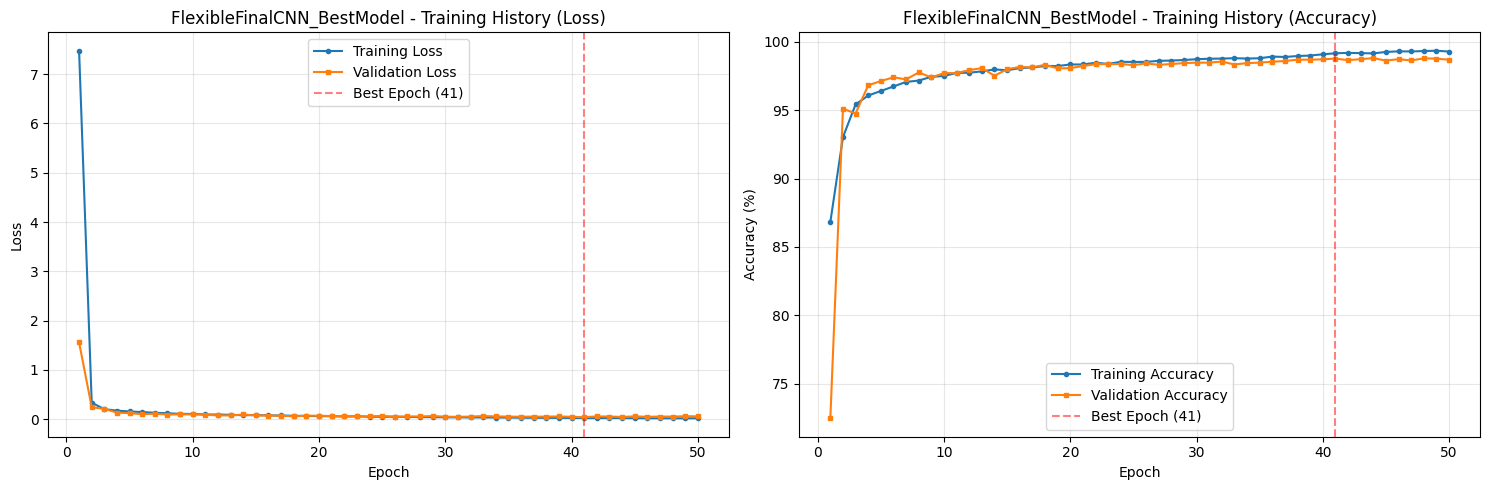


EVALUATING ON TEST SET



Testing: 100%|██████████| 11/11 [00:00<00:00, 15.24it/s]



Classification Report (FlexibleFinalCNN_BestModel):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     18118
           1       0.92      0.76      0.83       556
           2       0.96      0.97      0.97      1448
           3       0.85      0.75      0.80       162
           4       1.00      0.99      0.99      1608

    accuracy                           0.99     21892
   macro avg       0.94      0.89      0.92     21892
weighted avg       0.99      0.99      0.99     21892



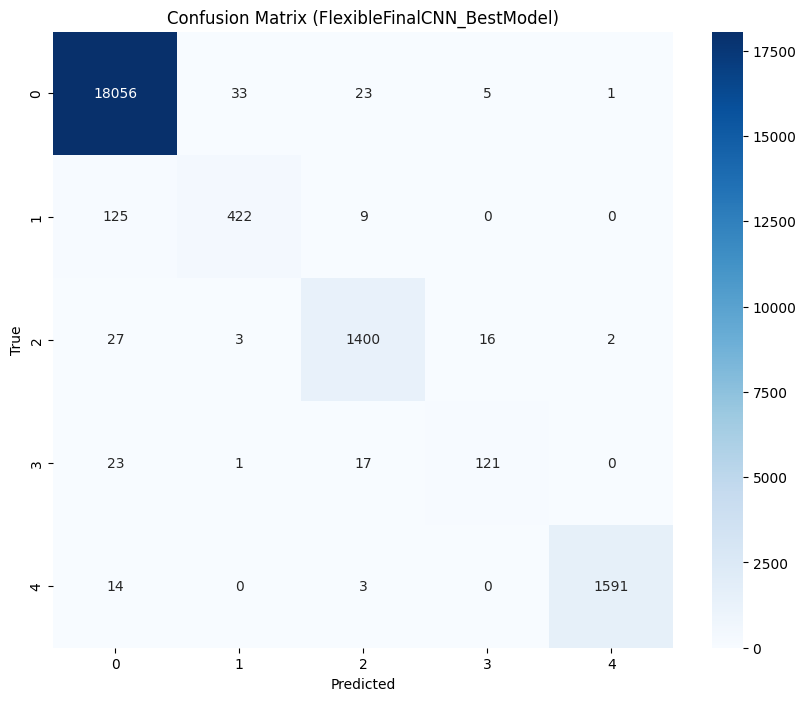


✓ Model and results saved to: models\FlexibleFinalCNN_BestModel_20251114_121620


In [123]:
final_results_optuna = train_final_model(
    best_params=best_params_optuna,
    X_train=X_train,
    X_val=X_val,
    X_test=X_test,
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    constant_filters=True,
    combine_train_val=False,  
    num_epochs=50,
    warmup_epochs=5,
    early_stopping_patience=10
)

## Retaining Best Model from Optuna


TRAINING FINAL MODEL ON TRAIN DATA (VALIDATING ON VAL DATA)

Best Hyperparameters:
  num_filters         : 128
  kernel_size         : 7
  num_res_blocks      : 4
  pool_size           : 2
  dropout_rate        : 0.23327083095973541
  fc_neurons          : 256
  learning_rate       : 0.0002565523450914082
  batch_size          : 32
  weight_decay        : 0.00034447901825992793
  pool_stride         : 2

Device: cuda
Sequence length: 187
Number of classes: 5
Constant filters: True
Training samples: 78798
Validation samples: 8756
Test samples: 21892

Starting training...

Starting training for FlexibleFinalCNN_BestModel...
Early stopping enabled with patience=10


Training: 100%|██████████| 2463/2463 [00:19<00:00, 123.70it/s]



Epoch [1/50]
Train Loss: 1.5722, Train Acc: 89.79%
Val Loss: 0.2511, Val Acc: 94.21%
Learning Rate: 0.000308
✓ New best model saved! (Val Loss: 0.2511)
Validation loss improved to 0.2511


Training: 100%|██████████| 2463/2463 [00:19<00:00, 124.53it/s]



Epoch [2/50]
Train Loss: 0.3225, Train Acc: 94.32%
Val Loss: 0.1904, Val Acc: 95.63%
Learning Rate: 0.000359
✓ New best model saved! (Val Loss: 0.1904)
Validation loss improved to 0.1904


Training: 100%|██████████| 2463/2463 [00:19<00:00, 124.73it/s]



Epoch [3/50]
Train Loss: 0.2423, Train Acc: 95.20%
Val Loss: 0.1720, Val Acc: 96.13%
Learning Rate: 0.000410
✓ New best model saved! (Val Loss: 0.1720)
Validation loss improved to 0.1720


Training: 100%|██████████| 2463/2463 [00:19<00:00, 124.49it/s]



Epoch [4/50]
Train Loss: 0.1904, Train Acc: 96.03%
Val Loss: 0.1449, Val Acc: 96.30%
Learning Rate: 0.000462
✓ New best model saved! (Val Loss: 0.1449)
Validation loss improved to 0.1449


Training: 100%|██████████| 2463/2463 [00:19<00:00, 124.46it/s]



Epoch [5/50]
Train Loss: 0.1594, Train Acc: 96.53%
Val Loss: 0.1119, Val Acc: 97.29%
Learning Rate: 0.000513
✓ New best model saved! (Val Loss: 0.1119)
Validation loss improved to 0.1119


Training: 100%|██████████| 2463/2463 [00:19<00:00, 124.39it/s]



Epoch [6/50]
Train Loss: 0.1388, Train Acc: 96.84%
Val Loss: 0.1116, Val Acc: 97.22%
Learning Rate: 0.000513
✓ New best model saved! (Val Loss: 0.1116)
Validation loss improved to 0.1116


Training: 100%|██████████| 2463/2463 [00:19<00:00, 124.17it/s]



Epoch [7/50]
Train Loss: 0.1183, Train Acc: 97.34%
Val Loss: 0.1076, Val Acc: 97.83%
Learning Rate: 0.000512
✓ New best model saved! (Val Loss: 0.1076)
Validation loss improved to 0.1076


Training: 100%|██████████| 2463/2463 [00:19<00:00, 124.22it/s]



Epoch [8/50]
Train Loss: 0.1001, Train Acc: 97.76%
Val Loss: 0.0806, Val Acc: 98.09%
Learning Rate: 0.000510
✓ New best model saved! (Val Loss: 0.0806)
Validation loss improved to 0.0806


Training: 100%|██████████| 2463/2463 [00:19<00:00, 124.05it/s]



Epoch [9/50]
Train Loss: 0.0874, Train Acc: 98.12%
Val Loss: 0.0739, Val Acc: 98.26%
Learning Rate: 0.000508
✓ New best model saved! (Val Loss: 0.0739)
Validation loss improved to 0.0739


Training: 100%|██████████| 2463/2463 [00:19<00:00, 124.08it/s]



Epoch [10/50]
Train Loss: 0.0765, Train Acc: 98.28%
Val Loss: 0.0623, Val Acc: 98.39%
Learning Rate: 0.000505
✓ New best model saved! (Val Loss: 0.0623)
Validation loss improved to 0.0623


Training: 100%|██████████| 2463/2463 [00:19<00:00, 124.13it/s]



Epoch [11/50]
Train Loss: 0.0687, Train Acc: 98.52%
Val Loss: 0.0644, Val Acc: 98.60%
Learning Rate: 0.000502
EarlyStopping counter: 1 out of 10


Training: 100%|██████████| 2463/2463 [00:20<00:00, 121.10it/s]



Epoch [12/50]
Train Loss: 0.0586, Train Acc: 98.69%
Val Loss: 0.0633, Val Acc: 98.60%
Learning Rate: 0.000498
EarlyStopping counter: 2 out of 10


Training: 100%|██████████| 2463/2463 [00:20<00:00, 117.65it/s]



Epoch [13/50]
Train Loss: 0.0541, Train Acc: 98.77%
Val Loss: 0.0503, Val Acc: 98.62%
Learning Rate: 0.000494
✓ New best model saved! (Val Loss: 0.0503)
Validation loss improved to 0.0503


Training: 100%|██████████| 2463/2463 [00:20<00:00, 118.18it/s]



Epoch [14/50]
Train Loss: 0.0528, Train Acc: 98.85%
Val Loss: 0.0561, Val Acc: 98.73%
Learning Rate: 0.000489
EarlyStopping counter: 1 out of 10


Training: 100%|██████████| 2463/2463 [00:20<00:00, 117.76it/s]



Epoch [15/50]
Train Loss: 0.0444, Train Acc: 99.02%
Val Loss: 0.0571, Val Acc: 98.63%
Learning Rate: 0.000483
EarlyStopping counter: 2 out of 10


Training: 100%|██████████| 2463/2463 [00:20<00:00, 118.11it/s]



Epoch [16/50]
Train Loss: 0.0408, Train Acc: 99.08%
Val Loss: 0.0578, Val Acc: 98.54%
Learning Rate: 0.000477
EarlyStopping counter: 3 out of 10


Training: 100%|██████████| 2463/2463 [00:21<00:00, 116.68it/s]



Epoch [17/50]
Train Loss: 0.0371, Train Acc: 99.15%
Val Loss: 0.0699, Val Acc: 98.69%
Learning Rate: 0.000471
EarlyStopping counter: 4 out of 10


Training: 100%|██████████| 2463/2463 [00:20<00:00, 118.73it/s]



Epoch [18/50]
Train Loss: 0.0347, Train Acc: 99.21%
Val Loss: 0.0741, Val Acc: 98.64%
Learning Rate: 0.000464
EarlyStopping counter: 5 out of 10


Training: 100%|██████████| 2463/2463 [00:20<00:00, 117.98it/s]



Epoch [19/50]
Train Loss: 0.0304, Train Acc: 99.29%
Val Loss: 0.0590, Val Acc: 98.76%
Learning Rate: 0.000457
EarlyStopping counter: 6 out of 10


Training: 100%|██████████| 2463/2463 [00:20<00:00, 117.94it/s]



Epoch [20/50]
Train Loss: 0.0295, Train Acc: 99.31%
Val Loss: 0.0681, Val Acc: 98.64%
Learning Rate: 0.000449
EarlyStopping counter: 7 out of 10


Training: 100%|██████████| 2463/2463 [00:20<00:00, 117.85it/s]



Epoch [21/50]
Train Loss: 0.0268, Train Acc: 99.39%
Val Loss: 0.0668, Val Acc: 98.63%
Learning Rate: 0.000441
EarlyStopping counter: 8 out of 10


Training: 100%|██████████| 2463/2463 [00:20<00:00, 118.09it/s]



Epoch [22/50]
Train Loss: 0.0247, Train Acc: 99.43%
Val Loss: 0.0667, Val Acc: 98.69%
Learning Rate: 0.000433
EarlyStopping counter: 9 out of 10


Training: 100%|██████████| 2463/2463 [00:20<00:00, 117.79it/s]



Epoch [23/50]
Train Loss: 0.0236, Train Acc: 99.48%
Val Loss: 0.0707, Val Acc: 98.89%
Learning Rate: 0.000424
EarlyStopping counter: 10 out of 10

Early stopping triggered! No improvement for 10 epochs.
Best validation loss: 0.0503 at epoch 13

Training stopped early at epoch 23
Best validation loss: 0.0503
Best epoch: 13


Training Summary for FlexibleFinalCNN_BestModel
Total epochs trained: 23
Best validation loss: 0.0503
Final train accuracy: 99.48%
Final validation accuracy: 98.89%


Generating training history plot...


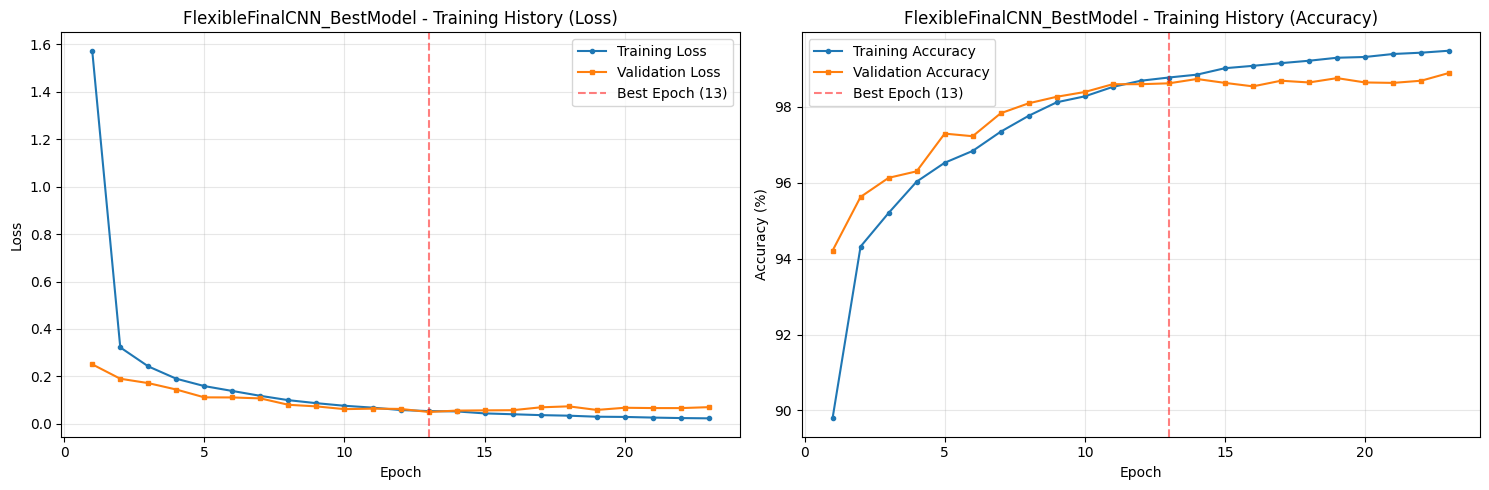


EVALUATING ON TEST SET



Testing: 100%|██████████| 685/685 [00:01<00:00, 342.79it/s]



Classification Report (FlexibleFinalCNN_BestModel):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     18118
           1       0.91      0.81      0.86       556
           2       0.97      0.96      0.97      1448
           3       0.86      0.75      0.80       162
           4       1.00      0.99      0.99      1608

    accuracy                           0.99     21892
   macro avg       0.94      0.90      0.92     21892
weighted avg       0.99      0.99      0.99     21892



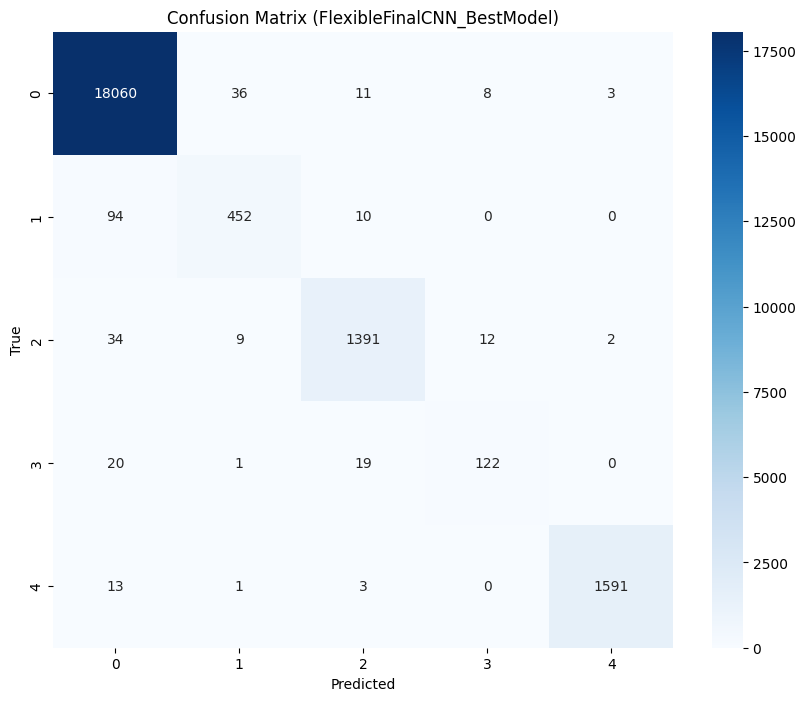


✓ Model and results saved to: models\FlexibleFinalCNN_BestModel_20251112_063549


In [26]:
final_results_optuna = train_final_model(
    best_params=best_params_optuna,
    X_train=X_train,
    X_val=X_val,
    X_test=X_test,
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    constant_filters=True,
    combine_train_val=False,  
    num_epochs=50,
    warmup_epochs=5,
    early_stopping_patience=10
)

In [27]:
print("\n" + "="*70)
print("OPTUNA - FINAL RESULTS")
print("="*70)
print(f"Best validation accuracy (from search): {study.best_value:.2f}%")
print(f"Final test accuracy: {final_results_optuna['test_accuracy']:.2f}%")
print(f"Results saved to: {final_results_optuna['save_dir']}")
print("="*70)


OPTUNA - FINAL RESULTS
Best validation accuracy (from search): 98.92%
Final test accuracy: 98.74%
Results saved to: models\FlexibleFinalCNN_BestModel_20251112_063549


# Squeeze and Excitation Attention CNN

## CNN (with SE) Architecture

In [17]:
class SEBlock(nn.Module):
    """
    Squeeze-and-Excitation Block
    """
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        
        # Squeeze: Global average pooling
        self.squeeze = nn.AdaptiveAvgPool1d(1)
        
        # Excitation: Two FC layers with bottleneck
        self.excitation = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        batch_size, channels, _ = x.size()
        
        # Squeeze: [B, C, T] → [B, C, 1] → [B, C]
        y = self.squeeze(x).view(batch_size, channels)
        
        # Excitation: [B, C] → [B, C/r] → [B, C]
        y = self.excitation(y).view(batch_size, channels, 1)
        
        # Scale: Multiply attention weights with input
        return x * y.expand_as(x)


class SEResidualBlock(nn.Module):
    """
    Residual Block with SE Attention
    """
    def __init__(self, in_channels, out_channels, kernel_size=5, 
                 pool_size=5, pool_stride=2, reduction=16):
        super(SEResidualBlock, self).__init__()
        
        # First conv layer
        self.conv1 = nn.Conv1d(in_channels, out_channels, 
                               kernel_size=kernel_size, 
                               padding=kernel_size//2)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu1 = nn.ReLU()
        
        # Second conv layer
        self.conv2 = nn.Conv1d(out_channels, out_channels, 
                               kernel_size=kernel_size, 
                               padding=kernel_size//2)
        self.bn2 = nn.BatchNorm1d(out_channels)
        
        # SE Attention Block
        self.se = SEBlock(out_channels, reduction=reduction)
        
        # Skip connection
        self.skip_connection = nn.Conv1d(in_channels, out_channels, kernel_size=1) \
            if in_channels != out_channels else nn.Identity()
        
        # ReLU after adding skip connection
        self.relu2 = nn.ReLU()
        
        # Max pooling
        self.pool = nn.MaxPool1d(kernel_size=pool_size, stride=pool_stride)
        
    def forward(self, x):
        # Store input for skip connection
        identity = self.skip_connection(x)
        
        # First conv block
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        
        # Second conv block
        out = self.conv2(out)
        out = self.bn2(out)
        
        # Apply SE attention
        out = self.se(out)
        
        # Add skip connection
        out = out + identity
        out = self.relu2(out)
        
        # Max pooling
        out = self.pool(out)
        
        return out


class FlexibleSECNN(nn.Module):

    def __init__(self, input_channels=1, num_classes=5, num_filters=32, 
                 kernel_size=5, num_res_blocks=5, pool_size=5, pool_stride=2,
                 fc_neurons=32, dropout_rate=0.3, sequence_length=187,
                 constant_filters=True, se_reduction=16):
        super(FlexibleSECNN, self).__init__()
        
        # Validate architecture
        valid, final_length, msg = validate_architecture(
            sequence_length, num_res_blocks, pool_size, pool_stride
        )
        
        if not valid:
            raise ValueError(
                f"Invalid architecture: {msg}\n"
                f"Input length: {sequence_length}, Blocks: {num_res_blocks}, "
                f"Pool: {pool_size}/{pool_stride}\n"
                f"Try: fewer blocks, smaller pool_size, or larger pool_stride"
            )
        
        self.num_res_blocks = num_res_blocks
        self.constant_filters = constant_filters
        
        # Build SE residual blocks
        self.res_blocks = nn.ModuleList()
        current_filters = input_channels
        
        for i in range(num_res_blocks):
            if constant_filters:
                out_filters = num_filters
            else:
                out_filters = min(num_filters * (2 ** (i // 2)), 256)
            
            self.res_blocks.append(
                SEResidualBlock(
                    current_filters, 
                    out_filters,
                    kernel_size=kernel_size,
                    pool_size=pool_size,
                    pool_stride=pool_stride,
                    reduction=se_reduction
                )
            )
            current_filters = out_filters
        
        # Dropout
        self.dropout = nn.Dropout(dropout_rate)
        
        # Calculate flattened feature size
        self._feature_size = self._get_feature_size(input_channels, sequence_length)
        
        # Fully connected layers
        self.fc1 = nn.Linear(self._feature_size, fc_neurons)
        self.relu_fc1 = nn.ReLU()
        
        self.fc2 = nn.Linear(fc_neurons, fc_neurons)
        self.relu_fc2 = nn.ReLU()
        
        # Output layer
        self.fc3 = nn.Linear(fc_neurons, num_classes)
        
        # Initialize weights
        self._init_weights()
    
    def _get_feature_size(self, input_channels, sequence_length):
        """Calculate the size of flattened features"""
        x = torch.randn(1, input_channels, sequence_length)
        for res_block in self.res_blocks:
            x = res_block(x)
        return x.view(1, -1).size(1)
    
    def _init_weights(self):
        """Initialize weights using He initialization"""
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:  # ⭐ FIX
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:  # ⭐ FIX
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        """Forward pass"""
        # Reshape for 1D convolution
        x = x.transpose(1, 2)
        
        # SE Residual blocks
        for res_block in self.res_blocks:
            x = res_block(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        
        # Fully connected layers
        x = self.fc1(x)
        x = self.relu_fc1(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.relu_fc2(x)
        x = self.dropout(x)
        
        # Output layer
        x = self.fc3(x)
        
        return x
    
    def count_parameters(self):
        """Count total and trainable parameters"""
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f"\nModel Parameters:")
        print(f"Total parameters: {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,}")
        return total_params, trainable_params

In [18]:
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler

def optuna_search_se_cnn(X_train, X_val, X_test, y_train, y_val, y_test,
                         n_trials=50, constant_filters=True, timeout=None):
    """
    Optuna hyperparameter search for FlexibleSECNN
    
    Parameters:
    -----------
    X_train, X_val, X_test : np.ndarray
        Training, validation, and test data
    y_train, y_val, y_test : np.ndarray
        Training, validation, and test labels
    n_trials : int, default=50
        Number of trials to run
    constant_filters : bool, default=True
        Whether to use constant filters throughout the network
    timeout : int, optional
        Time limit in seconds (None for no limit)
    
    Returns:
    --------
    tuple: (study, best_params, results_sorted)
    """
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    sequence_length = X_train.shape[1]
    num_classes = len(np.unique(y_train))
    
    print("="*70)
    print("OPTUNA HYPERPARAMETER SEARCH: FlexibleSECNN")
    print("="*70)
    print(f"Trials: {n_trials}")
    print(f"Device: {device}")
    print(f"Dataset: {X_train.shape[0]} train, {X_val.shape[0]} val samples")
    print(f"Sequence length: {sequence_length}, Classes: {num_classes}")
    print(f"Filter mode: {'CONSTANT' if constant_filters else 'SCALING'}")
    print(f"Timeout: {timeout if timeout else 'None'}")
    print("="*70 + "\n")
    
    def objective(trial):
        """Objective function for Optuna optimization"""
        
        # Suggest hyperparameters
        params = {
            'num_filters': trial.suggest_categorical('num_filters', [16, 32, 64, 128]),
            'kernel_size': trial.suggest_categorical('kernel_size', [3, 5, 7, 9]),
            'num_res_blocks': trial.suggest_int('num_res_blocks', 2, 5),
            'pool_size': trial.suggest_categorical('pool_size', [2, 3, 5]),
            'pool_stride': 2,  # Fixed for stability
            'dropout_rate': trial.suggest_float('dropout_rate', 0.1, 0.5),
            'fc_neurons': trial.suggest_categorical('fc_neurons', [32, 64, 128, 256]),
            'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
            'batch_size': trial.suggest_categorical('batch_size', [32, 64, 128]),
            'weight_decay': trial.suggest_loguniform('weight_decay', 1e-6, 1e-3),
            'se_reduction': trial.suggest_categorical('se_reduction', [4, 8, 16]),  # SE-specific
        }
        
        # Validate architecture
        valid, final_len, msg = validate_architecture(
            sequence_length, 
            params['num_res_blocks'], 
            params['pool_size'], 
            params['pool_stride']
        )
        
        if not valid:
            print(f"⊘ Trial {trial.number}: Invalid architecture - {msg}")
            raise optuna.exceptions.TrialPruned()
        
        print(f"\n{'='*70}")
        print(f"Trial {trial.number}")
        print(f"{'='*70}")
        print(f"Filters: {params['num_filters']} ({'constant' if constant_filters else 'scaling'}) × {params['num_res_blocks']} blocks")
        print(f"Kernel: {params['kernel_size']}, Pool: {params['pool_size']}/{params['pool_stride']}")
        print(f"SE Reduction: {params['se_reduction']}")
        print(f"Dropout: {params['dropout_rate']}, FC: {params['fc_neurons']}")
        print(f"LR: {params['learning_rate']:.2e}, Batch: {params['batch_size']}, WD: {params['weight_decay']:.2e}")
        print(f"{'='*70}")
        
        try:
            # Create model
            model = FlexibleSECNN(
                input_channels=1,
                num_classes=num_classes,
                num_filters=params['num_filters'],
                kernel_size=params['kernel_size'],
                num_res_blocks=params['num_res_blocks'],
                pool_size=params['pool_size'],
                pool_stride=params['pool_stride'],
                fc_neurons=params['fc_neurons'],
                dropout_rate=params['dropout_rate'],
                sequence_length=sequence_length,
                constant_filters=constant_filters,
                se_reduction=params['se_reduction']
            )
            
            model = model.to(device)
            
            # Create data loaders
            train_loader = DataLoader(
                ECGDataset(X_train, y_train),
                batch_size=params['batch_size'],
                shuffle=True,
                num_workers=0
            )
            val_loader = DataLoader(
                ECGDataset(X_val, y_val),
                batch_size=params['batch_size'],
                num_workers=0
            )
            
            # Setup training
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.AdamW(
                model.parameters(),
                lr=params['learning_rate'],
                weight_decay=params['weight_decay']
            )
            
            # Training loop with Optuna pruning
            num_epochs = 30
            patience = 10
            best_val_acc = 0
            epochs_no_improve = 0
            
            for epoch in range(num_epochs):
                # Training
                model.train()
                train_loss = 0
                for batch_X, batch_y in train_loader:
                    batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                    optimizer.zero_grad()
                    outputs = model(batch_X)
                    loss = criterion(outputs, batch_y)
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    optimizer.step()
                    train_loss += loss.item()
                
                # Validation
                model.eval()
                correct = 0
                total = 0
                with torch.no_grad():
                    for batch_X, batch_y in val_loader:
                        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                        outputs = model(batch_X)
                        _, predicted = torch.max(outputs.data, 1)
                        total += batch_y.size(0)
                        correct += (predicted == batch_y).sum().item()
                
                val_acc = 100 * correct / total
                
                # Report intermediate value for pruning
                trial.report(val_acc, epoch)
                
                # Optuna pruning: stop unpromising trials early
                if trial.should_prune():
                    print(f"  ✂️ Pruned at epoch {epoch+1}")
                    raise optuna.exceptions.TrialPruned()
                
                # Early stopping
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
                
                if epochs_no_improve >= patience:
                    print(f"  Early stopping at epoch {epoch+1}")
                    break
                
                # Print progress every 5 epochs
                if (epoch + 1) % 5 == 0:
                    print(f"  Epoch {epoch+1}/{num_epochs}: Val Acc = {val_acc:.2f}%")
            
            print(f"  ✓ Final Validation Accuracy: {best_val_acc:.2f}%")
            
            return best_val_acc
            
        except optuna.exceptions.TrialPruned:
            raise
        except Exception as e:
            print(f"  ✗ Error: {str(e)}")
            import traceback
            traceback.print_exc()
            raise optuna.exceptions.TrialPruned()
    
    # Create Optuna study
    study = optuna.create_study(
        direction='maximize',  # Maximize validation accuracy
        pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=10),
        sampler=TPESampler(seed=42)  # Reproducible results
    )
    
    # Run optimization
    study.optimize(
        objective, 
        n_trials=n_trials,
        timeout=timeout,
        show_progress_bar=True
    )
    
    # Print results
    print(f"\n{'='*70}")
    print(f"OPTUNA OPTIMIZATION COMPLETE")
    print(f"{'='*70}")
    print(f"Number of finished trials: {len(study.trials)}")
    print(f"Number of pruned trials: {len([t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED])}")
    print(f"Number of complete trials: {len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])}")
    
    print(f"\nBest trial:")
    best_trial = study.best_trial
    print(f"  Value (Validation Accuracy): {best_trial.value:.2f}%")
    print(f"  Trial number: {best_trial.number}")
    
    print(f"\nBest hyperparameters:")
    print(f"{'='*70}")
    for key, value in best_trial.params.items():
        print(f"  {key:20s}: {value}")
    print(f"{'='*70}")
    
    # Convert trials to results format
    results_sorted = sorted(
        [
            {
                'params': {**t.params, 'pool_stride': 2},  # Add fixed params
                'val_accuracy': t.value,
                'trial_number': t.number,
                'state': t.state.name
            }
            for t in study.trials 
            if t.value is not None
        ],
        key=lambda x: x['val_accuracy'],
        reverse=True
    )
    
    # Print top 10
    print(f"\n{'='*70}")
    print(f"Top 10 Configurations:")
    print(f"{'='*70}")
    for i, result in enumerate(results_sorted[:10], 1):
        p = result['params']
        print(f"\n{i}. Val Acc: {result['val_accuracy']:.2f}% (Trial {result['trial_number']})")
        print(f"   Filters: {p['num_filters']} × {p['num_res_blocks']} blocks")
        print(f"   Kernel: {p['kernel_size']}, Pool: {p['pool_size']}/{p['pool_stride']}")
        print(f"   SE Reduction: {p['se_reduction']}")
        print(f"   Dropout: {p['dropout_rate']}, FC: {p['fc_neurons']}")
        print(f"   LR: {p['learning_rate']:.2e}, Batch: {p['batch_size']}, WD: {p['weight_decay']:.2e}")
    
    print("="*70)
    
    # Prepare best_params for use with train_final_model
    best_params = {**best_trial.params, 'pool_stride': 2}
    
    return study, best_params, results_sorted

In [21]:
study, best_params, results_sorted = optuna_search_se_cnn(
    X_train, X_val, X_test,
    y_train, y_val, y_test,
    n_trials=50,
    constant_filters=True
)

[I 2025-11-12 09:24:25,773] A new study created in memory with name: no-name-c62185b4-f9c3-484f-b457-de9ad7d4414a


OPTUNA HYPERPARAMETER SEARCH: FlexibleSECNN
Trials: 50
Device: cuda
Dataset: 78798 train, 8756 val samples
Sequence length: 187, Classes: 5
Filter mode: CONSTANT
Timeout: None



  0%|          | 0/50 [00:00<?, ?it/s]


Trial 0
Filters: 32 (constant) × 4 blocks
Kernel: 9, Pool: 5/2
SE Reduction: 16
Dropout: 0.4329770563201687, FC: 256
LR: 1.12e-04, Batch: 128, WD: 2.62e-06


C:\Users\zheng\AppData\Local\Temp\ipykernel_21660\95419695.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
C:\Users\zheng\AppData\Local\Temp\ipykernel_21660\95419695.py:56: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'weight_decay': trial.suggest_loguniform('weight_decay', 1e-6, 1e-3),


  Epoch 5/30: Val Acc = 96.08%
  Epoch 10/30: Val Acc = 97.67%
  Epoch 15/30: Val Acc = 98.14%
  Epoch 20/30: Val Acc = 98.10%
  Epoch 25/30: Val Acc = 98.17%


Best trial: 0. Best value: 98.4696:   2%|▏         | 1/50 [04:13<3:27:12, 253.72s/it]

  Epoch 30/30: Val Acc = 98.47%
  ✓ Final Validation Accuracy: 98.47%
[I 2025-11-12 09:28:39,496] Trial 0 finished with value: 98.46962083142988 and parameters: {'num_filters': 32, 'kernel_size': 9, 'num_res_blocks': 4, 'pool_size': 5, 'dropout_rate': 0.4329770563201687, 'fc_neurons': 256, 'learning_rate': 0.00011207606211860574, 'batch_size': 128, 'weight_decay': 2.62108787826544e-06, 'se_reduction': 16}. Best is trial 0 with value: 98.46962083142988.

Trial 1
Filters: 16 (constant) × 5 blocks
Kernel: 5, Pool: 2/2
SE Reduction: 8
Dropout: 0.13906884560255356, FC: 32
LR: 1.17e-05, Batch: 32, WD: 8.61e-06


C:\Users\zheng\AppData\Local\Temp\ipykernel_21660\95419695.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
C:\Users\zheng\AppData\Local\Temp\ipykernel_21660\95419695.py:56: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'weight_decay': trial.suggest_loguniform('weight_decay', 1e-6, 1e-3),


  Epoch 5/30: Val Acc = 91.98%
  Epoch 10/30: Val Acc = 93.52%
  Epoch 15/30: Val Acc = 94.07%
  Epoch 20/30: Val Acc = 94.52%
  Epoch 25/30: Val Acc = 95.04%


Best trial: 0. Best value: 98.4696:   4%|▍         | 2/50 [20:19<8:58:02, 672.56s/it]

  Epoch 30/30: Val Acc = 96.11%
  ✓ Final Validation Accuracy: 96.11%
[I 2025-11-12 09:44:45,241] Trial 1 finished with value: 96.10552763819095 and parameters: {'num_filters': 16, 'kernel_size': 5, 'num_res_blocks': 5, 'pool_size': 2, 'dropout_rate': 0.13906884560255356, 'fc_neurons': 32, 'learning_rate': 1.1715937392307055e-05, 'batch_size': 32, 'weight_decay': 8.61257919259488e-06, 'se_reduction': 8}. Best is trial 0 with value: 98.46962083142988.

Trial 2
Filters: 16 (constant) × 2 blocks
Kernel: 5, Pool: 3/2
SE Reduction: 8
Dropout: 0.43149500366077176, FC: 128
LR: 4.02e-04, Batch: 64, WD: 3.95e-06
  Epoch 5/30: Val Acc = 96.05%
  Epoch 10/30: Val Acc = 97.29%
  Epoch 15/30: Val Acc = 97.82%
  Epoch 20/30: Val Acc = 97.92%
  Epoch 25/30: Val Acc = 97.97%


Best trial: 0. Best value: 98.4696:   6%|▌         | 3/50 [24:26<6:14:43, 478.38s/it]

  Epoch 30/30: Val Acc = 98.12%
  ✓ Final Validation Accuracy: 98.22%
[I 2025-11-12 09:48:52,554] Trial 2 finished with value: 98.21836455002284 and parameters: {'num_filters': 16, 'kernel_size': 5, 'num_res_blocks': 2, 'pool_size': 3, 'dropout_rate': 0.43149500366077176, 'fc_neurons': 128, 'learning_rate': 0.0004021554526690286, 'batch_size': 64, 'weight_decay': 3.9459088110999995e-06, 'se_reduction': 8}. Best is trial 0 with value: 98.46962083142988.

Trial 3
Filters: 32 (constant) × 2 blocks
Kernel: 5, Pool: 5/2
SE Reduction: 4
Dropout: 0.35502298854208525, FC: 32
LR: 3.32e-04, Batch: 64, WD: 3.70e-05
  Epoch 5/30: Val Acc = 94.50%
  Epoch 10/30: Val Acc = 95.32%
  Epoch 15/30: Val Acc = 97.04%
  Epoch 20/30: Val Acc = 97.19%
  Epoch 25/30: Val Acc = 97.50%


Best trial: 0. Best value: 98.4696:   8%|▊         | 4/50 [28:58<5:04:09, 396.72s/it]

  Epoch 30/30: Val Acc = 97.56%
  ✓ Final Validation Accuracy: 97.58%
[I 2025-11-12 09:53:24,085] Trial 3 finished with value: 97.5788031064413 and parameters: {'num_filters': 32, 'kernel_size': 5, 'num_res_blocks': 2, 'pool_size': 5, 'dropout_rate': 0.35502298854208525, 'fc_neurons': 32, 'learning_rate': 0.0003323304206226791, 'batch_size': 64, 'weight_decay': 3.69997243146381e-05, 'se_reduction': 4}. Best is trial 0 with value: 98.46962083142988.

Trial 4
Filters: 32 (constant) × 2 blocks
Kernel: 3, Pool: 3/2
SE Reduction: 4
Dropout: 0.47187906093702925, FC: 128
LR: 2.36e-05, Batch: 32, WD: 4.88e-04
  Epoch 5/30: Val Acc = 83.35%
  Epoch 10/30: Val Acc = 86.77%
  Epoch 15/30: Val Acc = 89.08%
  Epoch 20/30: Val Acc = 90.63%
  Epoch 25/30: Val Acc = 93.51%


Best trial: 0. Best value: 98.4696:  10%|█         | 5/50 [38:06<5:38:35, 451.46s/it]

  Epoch 30/30: Val Acc = 93.86%
  ✓ Final Validation Accuracy: 93.90%
[I 2025-11-12 10:02:32,606] Trial 4 finished with value: 93.90132480584742 and parameters: {'num_filters': 32, 'kernel_size': 3, 'num_res_blocks': 2, 'pool_size': 3, 'dropout_rate': 0.47187906093702925, 'fc_neurons': 128, 'learning_rate': 2.3612399244412595e-05, 'batch_size': 32, 'weight_decay': 0.00048783606034521424, 'se_reduction': 4}. Best is trial 0 with value: 98.46962083142988.

Trial 5
Filters: 64 (constant) × 3 blocks
Kernel: 3, Pool: 2/2
SE Reduction: 4
Dropout: 0.38120758355807116, FC: 64
LR: 9.87e-05, Batch: 32, WD: 6.74e-05
  Epoch 5/30: Val Acc = 93.09%
  Epoch 10/30: Val Acc = 95.52%


Best trial: 0. Best value: 98.4696:  12%|█▏        | 6/50 [44:45<5:17:58, 433.60s/it]

  ✂️ Pruned at epoch 14
[I 2025-11-12 10:09:11,526] Trial 5 pruned. 

Trial 6
Filters: 16 (constant) × 2 blocks
Kernel: 3, Pool: 2/2
SE Reduction: 16
Dropout: 0.3534118843043579, FC: 128
LR: 2.36e-05, Batch: 128, WD: 1.12e-06
  Epoch 5/30: Val Acc = 89.82%
  Epoch 10/30: Val Acc = 90.12%


Best trial: 0. Best value: 98.4696:  14%|█▍        | 7/50 [45:50<3:44:23, 313.09s/it]

  ✂️ Pruned at epoch 11
[I 2025-11-12 10:10:16,529] Trial 6 pruned. 

Trial 7
Filters: 128 (constant) × 5 blocks
Kernel: 9, Pool: 5/2
SE Reduction: 4
Dropout: 0.322080324639785, FC: 256
LR: 6.32e-04, Batch: 32, WD: 1.51e-04
  Epoch 5/30: Val Acc = 98.18%
  Epoch 10/30: Val Acc = 98.44%
  Epoch 15/30: Val Acc = 98.71%
  Epoch 20/30: Val Acc = 98.65%
  Epoch 25/30: Val Acc = 98.72%


Best trial: 7. Best value: 98.9036:  16%|█▌        | 8/50 [1:09:29<7:45:38, 665.19s/it]

  Epoch 30/30: Val Acc = 98.82%
  ✓ Final Validation Accuracy: 98.90%
[I 2025-11-12 10:33:55,631] Trial 7 finished with value: 98.90360895386021 and parameters: {'num_filters': 128, 'kernel_size': 9, 'num_res_blocks': 5, 'pool_size': 5, 'dropout_rate': 0.322080324639785, 'fc_neurons': 256, 'learning_rate': 0.0006321732490144021, 'batch_size': 32, 'weight_decay': 0.00015061458746961162, 'se_reduction': 4}. Best is trial 7 with value: 98.90360895386021.

Trial 8
Filters: 128 (constant) × 2 blocks
Kernel: 9, Pool: 5/2
SE Reduction: 8
Dropout: 0.3607845038010402, FC: 64
LR: 3.11e-04, Batch: 64, WD: 5.07e-05
  Epoch 5/30: Val Acc = 95.02%
  Epoch 10/30: Val Acc = 95.82%


Best trial: 7. Best value: 98.9036:  18%|█▊        | 9/50 [1:11:46<5:41:42, 500.06s/it]

  ✂️ Pruned at epoch 11
[I 2025-11-12 10:36:12,579] Trial 8 pruned. 

Trial 9
Filters: 32 (constant) × 3 blocks
Kernel: 5, Pool: 3/2
SE Reduction: 4
Dropout: 0.10972638657258155, FC: 256
LR: 6.76e-04, Batch: 128, WD: 1.93e-05
  Epoch 5/30: Val Acc = 98.13%
  Epoch 10/30: Val Acc = 98.45%
  Epoch 15/30: Val Acc = 98.45%
  Epoch 20/30: Val Acc = 98.79%
  Epoch 25/30: Val Acc = 98.61%


Best trial: 7. Best value: 98.9036:  20%|██        | 10/50 [1:15:38<4:38:06, 417.15s/it]

  Early stopping at epoch 30
  ✓ Final Validation Accuracy: 98.79%
[I 2025-11-12 10:40:04,088] Trial 9 finished with value: 98.78940155322064 and parameters: {'num_filters': 32, 'kernel_size': 5, 'num_res_blocks': 3, 'pool_size': 3, 'dropout_rate': 0.10972638657258155, 'fc_neurons': 256, 'learning_rate': 0.0006756608892518738, 'batch_size': 128, 'weight_decay': 1.925539557201562e-05, 'se_reduction': 4}. Best is trial 7 with value: 98.90360895386021.

Trial 10
Filters: 128 (constant) × 5 blocks
Kernel: 7, Pool: 5/2
SE Reduction: 4
Dropout: 0.23264700577903058, FC: 256
LR: 8.82e-04, Batch: 32, WD: 4.40e-04
  Epoch 5/30: Val Acc = 98.23%
  Epoch 10/30: Val Acc = 98.55%
  Epoch 15/30: Val Acc = 98.63%
  Epoch 20/30: Val Acc = 98.74%
  Epoch 25/30: Val Acc = 98.78%


Best trial: 7. Best value: 98.9036:  22%|██▏       | 11/50 [1:37:58<7:34:40, 699.50s/it]

  Early stopping at epoch 28
  ✓ Final Validation Accuracy: 98.88%
[I 2025-11-12 11:02:23,807] Trial 10 finished with value: 98.88076747373229 and parameters: {'num_filters': 128, 'kernel_size': 7, 'num_res_blocks': 5, 'pool_size': 5, 'dropout_rate': 0.23264700577903058, 'fc_neurons': 256, 'learning_rate': 0.0008823963842606053, 'batch_size': 32, 'weight_decay': 0.00044005929565618657, 'se_reduction': 4}. Best is trial 7 with value: 98.90360895386021.

Trial 11
Filters: 128 (constant) × 5 blocks
Kernel: 7, Pool: 5/2
SE Reduction: 4
Dropout: 0.23700639749510272, FC: 256
LR: 9.76e-04, Batch: 32, WD: 4.56e-04
  Epoch 5/30: Val Acc = 98.14%
  Epoch 10/30: Val Acc = 98.55%
  Epoch 15/30: Val Acc = 98.66%
  Epoch 20/30: Val Acc = 98.73%


Best trial: 7. Best value: 98.9036:  24%|██▍       | 12/50 [1:54:43<8:21:57, 792.57s/it]

  Early stopping at epoch 21
  ✓ Final Validation Accuracy: 98.77%
[I 2025-11-12 11:19:09,237] Trial 11 finished with value: 98.76656007309273 and parameters: {'num_filters': 128, 'kernel_size': 7, 'num_res_blocks': 5, 'pool_size': 5, 'dropout_rate': 0.23700639749510272, 'fc_neurons': 256, 'learning_rate': 0.0009764035578029419, 'batch_size': 32, 'weight_decay': 0.0004559407239021476, 'se_reduction': 4}. Best is trial 7 with value: 98.90360895386021.

Trial 12
Filters: 128 (constant) × 4 blocks
Kernel: 7, Pool: 5/2
SE Reduction: 4
Dropout: 0.23905337219863318, FC: 256
LR: 1.43e-04, Batch: 32, WD: 1.82e-04
  Epoch 5/30: Val Acc = 97.54%
  Epoch 10/30: Val Acc = 98.41%
  Epoch 15/30: Val Acc = 98.56%
  Epoch 20/30: Val Acc = 98.85%
  Epoch 25/30: Val Acc = 98.76%


Best trial: 7. Best value: 98.9036:  26%|██▌       | 13/50 [2:14:10<9:18:46, 906.13s/it]

  Epoch 30/30: Val Acc = 98.79%
  ✓ Final Validation Accuracy: 98.90%
[I 2025-11-12 11:38:36,689] Trial 12 finished with value: 98.90360895386021 and parameters: {'num_filters': 128, 'kernel_size': 7, 'num_res_blocks': 4, 'pool_size': 5, 'dropout_rate': 0.23905337219863318, 'fc_neurons': 256, 'learning_rate': 0.00014310288180294236, 'batch_size': 32, 'weight_decay': 0.00018159580581128873, 'se_reduction': 4}. Best is trial 7 with value: 98.90360895386021.

Trial 13
Filters: 128 (constant) × 4 blocks
Kernel: 7, Pool: 5/2
SE Reduction: 4
Dropout: 0.26128374268825916, FC: 256
LR: 1.24e-04, Batch: 32, WD: 1.33e-04
  Epoch 5/30: Val Acc = 97.65%
  Epoch 10/30: Val Acc = 98.48%
  Epoch 15/30: Val Acc = 98.74%
  Epoch 20/30: Val Acc = 98.78%
  Epoch 25/30: Val Acc = 98.85%


Best trial: 13. Best value: 98.9721:  28%|██▊       | 14/50 [2:33:39<9:51:19, 985.53s/it]

  Epoch 30/30: Val Acc = 98.97%
  ✓ Final Validation Accuracy: 98.97%
[I 2025-11-12 11:58:05,694] Trial 13 finished with value: 98.97213339424394 and parameters: {'num_filters': 128, 'kernel_size': 7, 'num_res_blocks': 4, 'pool_size': 5, 'dropout_rate': 0.26128374268825916, 'fc_neurons': 256, 'learning_rate': 0.00012362332330094185, 'batch_size': 32, 'weight_decay': 0.00013310176230932805, 'se_reduction': 4}. Best is trial 13 with value: 98.97213339424394.

Trial 14
Filters: 128 (constant) × 4 blocks
Kernel: 9, Pool: 5/2
SE Reduction: 4
Dropout: 0.2889287846668806, FC: 256
LR: 5.16e-05, Batch: 32, WD: 1.66e-04
  Epoch 5/30: Val Acc = 96.80%
  Epoch 10/30: Val Acc = 98.06%


Best trial: 13. Best value: 98.9721:  30%|███       | 15/50 [2:40:45<7:56:22, 816.63s/it]

  ✂️ Pruned at epoch 11
[I 2025-11-12 12:05:10,887] Trial 14 pruned. 

Trial 15
Filters: 64 (constant) × 5 blocks
Kernel: 7, Pool: 5/2
SE Reduction: 16
Dropout: 0.3031602538847154, FC: 256
LR: 5.58e-05, Batch: 32, WD: 1.46e-04
  Epoch 5/30: Val Acc = 97.84%
  Epoch 10/30: Val Acc = 98.24%


Best trial: 13. Best value: 98.9721:  32%|███▏      | 16/50 [2:50:58<7:08:08, 755.55s/it]

  ✂️ Pruned at epoch 13
[I 2025-11-12 12:15:24,584] Trial 15 pruned. 

Trial 16
Filters: 128 (constant) × 4 blocks
Kernel: 9, Pool: 5/2
SE Reduction: 4
Dropout: 0.18893854276045113, FC: 256
LR: 2.03e-04, Batch: 32, WD: 9.79e-04
  Epoch 5/30: Val Acc = 97.85%
  Epoch 10/30: Val Acc = 98.52%
  Epoch 15/30: Val Acc = 98.71%
  Epoch 20/30: Val Acc = 98.70%
  Epoch 25/30: Val Acc = 98.71%


Best trial: 13. Best value: 98.9721:  34%|███▍      | 17/50 [3:10:28<8:03:58, 879.96s/it]

  Epoch 30/30: Val Acc = 98.82%
  ✓ Final Validation Accuracy: 98.93%
[I 2025-11-12 12:34:53,876] Trial 16 finished with value: 98.92645043398812 and parameters: {'num_filters': 128, 'kernel_size': 9, 'num_res_blocks': 4, 'pool_size': 5, 'dropout_rate': 0.18893854276045113, 'fc_neurons': 256, 'learning_rate': 0.00020298954781806925, 'batch_size': 32, 'weight_decay': 0.0009792334458440127, 'se_reduction': 4}. Best is trial 13 with value: 98.97213339424394.

Trial 17
Filters: 128 (constant) × 3 blocks
Kernel: 7, Pool: 5/2
SE Reduction: 4
Dropout: 0.1733221423256304, FC: 64
LR: 2.16e-04, Batch: 32, WD: 8.77e-04
  Epoch 5/30: Val Acc = 97.29%
  Epoch 10/30: Val Acc = 98.39%
  Epoch 15/30: Val Acc = 98.58%


Best trial: 13. Best value: 98.9721:  36%|███▌      | 18/50 [3:19:17<6:53:10, 774.72s/it]

  ✂️ Pruned at epoch 16
[I 2025-11-12 12:43:43,596] Trial 17 pruned. 

Trial 18
Filters: 128 (constant) × 4 blocks
Kernel: 9, Pool: 2/2
SE Reduction: 16
Dropout: 0.18730641531896142, FC: 32
LR: 5.82e-05, Batch: 128, WD: 9.94e-04
  Epoch 5/30: Val Acc = 94.83%
  Epoch 10/30: Val Acc = 96.57%


Best trial: 13. Best value: 98.9721:  38%|███▊      | 19/50 [3:21:37<5:01:40, 583.88s/it]

  ✂️ Pruned at epoch 11
[I 2025-11-12 12:46:02,926] Trial 18 pruned. 

Trial 19
Filters: 64 (constant) × 4 blocks
Kernel: 7, Pool: 3/2
SE Reduction: 8
Dropout: 0.19513276743256808, FC: 256
LR: 1.89e-04, Batch: 64, WD: 1.62e-05
  Epoch 5/30: Val Acc = 97.96%
  Epoch 10/30: Val Acc = 98.53%
  Epoch 15/30: Val Acc = 98.72%
  Epoch 20/30: Val Acc = 98.74%
  Epoch 25/30: Val Acc = 98.77%


Best trial: 13. Best value: 98.9721:  40%|████      | 20/50 [3:31:27<4:52:50, 585.70s/it]

  Epoch 30/30: Val Acc = 98.84%
  ✓ Final Validation Accuracy: 98.90%
[I 2025-11-12 12:55:52,857] Trial 19 finished with value: 98.90360895386021 and parameters: {'num_filters': 64, 'kernel_size': 7, 'num_res_blocks': 4, 'pool_size': 3, 'dropout_rate': 0.19513276743256808, 'fc_neurons': 256, 'learning_rate': 0.00018922542225715188, 'batch_size': 64, 'weight_decay': 1.61919132267953e-05, 'se_reduction': 8}. Best is trial 13 with value: 98.97213339424394.

Trial 20
Filters: 128 (constant) × 3 blocks
Kernel: 9, Pool: 5/2
SE Reduction: 4
Dropout: 0.26316824346042783, FC: 256
LR: 8.22e-05, Batch: 32, WD: 8.20e-05
  Epoch 5/30: Val Acc = 97.45%
  Epoch 10/30: Val Acc = 98.01%


Best trial: 13. Best value: 98.9721:  42%|████▏     | 21/50 [3:37:33<4:11:12, 519.73s/it]

  ✂️ Pruned at epoch 11
[I 2025-11-12 13:01:58,780] Trial 20 pruned. 

Trial 21
Filters: 128 (constant) × 5 blocks
Kernel: 9, Pool: 5/2
SE Reduction: 4
Dropout: 0.31154984981098605, FC: 256
LR: 5.31e-04, Batch: 32, WD: 2.40e-04
  Epoch 5/30: Val Acc = 97.92%
  Epoch 10/30: Val Acc = 98.60%
  Epoch 15/30: Val Acc = 98.73%
  Epoch 20/30: Val Acc = 98.58%
  Epoch 25/30: Val Acc = 98.72%


Best trial: 13. Best value: 98.9721:  44%|████▍     | 22/50 [4:00:40<6:04:05, 780.20s/it]

  Epoch 30/30: Val Acc = 98.90%
  ✓ Final Validation Accuracy: 98.90%
[I 2025-11-12 13:25:06,391] Trial 21 finished with value: 98.90360895386021 and parameters: {'num_filters': 128, 'kernel_size': 9, 'num_res_blocks': 5, 'pool_size': 5, 'dropout_rate': 0.31154984981098605, 'fc_neurons': 256, 'learning_rate': 0.0005312443860865522, 'batch_size': 32, 'weight_decay': 0.00023964718282031174, 'se_reduction': 4}. Best is trial 13 with value: 98.97213339424394.

Trial 22
Filters: 128 (constant) × 4 blocks
Kernel: 9, Pool: 5/2
SE Reduction: 4
Dropout: 0.27652279149744036, FC: 256
LR: 2.20e-04, Batch: 32, WD: 9.47e-05
  Epoch 5/30: Val Acc = 98.05%
  Epoch 10/30: Val Acc = 98.50%
  Epoch 15/30: Val Acc = 98.50%
  Epoch 20/30: Val Acc = 98.70%


Best trial: 13. Best value: 98.9721:  46%|████▌     | 23/50 [4:11:26<5:32:53, 739.75s/it]

  ✂️ Pruned at epoch 21
[I 2025-11-12 13:35:51,820] Trial 22 pruned. 

Trial 23
Filters: 128 (constant) × 5 blocks
Kernel: 9, Pool: 5/2
SE Reduction: 4
Dropout: 0.20911982789092204, FC: 256
LR: 5.35e-04, Batch: 32, WD: 2.68e-04
  Epoch 5/30: Val Acc = 98.09%
  Epoch 10/30: Val Acc = 98.56%
  Epoch 15/30: Val Acc = 98.65%
  Epoch 20/30: Val Acc = 98.73%
  Epoch 25/30: Val Acc = 98.85%


Best trial: 13. Best value: 98.9721:  48%|████▊     | 24/50 [4:29:29<6:05:17, 842.97s/it]

  Epoch 30/30: Val Acc = 98.74%
  ✓ Final Validation Accuracy: 98.92%
[I 2025-11-12 13:53:55,549] Trial 23 finished with value: 98.91502969392417 and parameters: {'num_filters': 128, 'kernel_size': 9, 'num_res_blocks': 5, 'pool_size': 5, 'dropout_rate': 0.20911982789092204, 'fc_neurons': 256, 'learning_rate': 0.0005353158856094261, 'batch_size': 32, 'weight_decay': 0.00026772821077277023, 'se_reduction': 4}. Best is trial 13 with value: 98.97213339424394.

Trial 24
Filters: 128 (constant) × 4 blocks
Kernel: 9, Pool: 5/2
SE Reduction: 4
Dropout: 0.20800586252789016, FC: 256
LR: 1.49e-04, Batch: 32, WD: 3.24e-04
  Epoch 5/30: Val Acc = 97.88%
  Epoch 10/30: Val Acc = 98.40%
  Epoch 15/30: Val Acc = 98.61%


Best trial: 13. Best value: 98.9721:  50%|█████     | 25/50 [4:37:41<5:07:20, 737.62s/it]

  ✂️ Pruned at epoch 16
[I 2025-11-12 14:02:07,414] Trial 24 pruned. 

Trial 25
Filters: 128 (constant) × 4 blocks
Kernel: 9, Pool: 5/2
SE Reduction: 4
Dropout: 0.15057417770073758, FC: 256
LR: 4.29e-04, Batch: 32, WD: 6.75e-04
  Epoch 5/30: Val Acc = 98.12%
  Epoch 10/30: Val Acc = 98.55%
  Epoch 15/30: Val Acc = 98.78%
  Epoch 20/30: Val Acc = 98.71%
  Epoch 25/30: Val Acc = 98.81%


Best trial: 13. Best value: 98.9721:  52%|█████▏    | 26/50 [4:52:26<5:12:41, 781.72s/it]

  Early stopping at epoch 29
  ✓ Final Validation Accuracy: 98.84%
[I 2025-11-12 14:16:52,013] Trial 25 finished with value: 98.83508451347647 and parameters: {'num_filters': 128, 'kernel_size': 9, 'num_res_blocks': 4, 'pool_size': 5, 'dropout_rate': 0.15057417770073758, 'fc_neurons': 256, 'learning_rate': 0.0004287660071657286, 'batch_size': 32, 'weight_decay': 0.0006754555680834914, 'se_reduction': 4}. Best is trial 13 with value: 98.97213339424394.

Trial 26
Filters: 128 (constant) × 5 blocks
Kernel: 7, Pool: 5/2
SE Reduction: 4
Dropout: 0.1033628992442753, FC: 32
LR: 2.67e-04, Batch: 32, WD: 3.01e-04
  Epoch 5/30: Val Acc = 97.84%
  Epoch 10/30: Val Acc = 98.52%
  Epoch 15/30: Val Acc = 98.86%
  Epoch 20/30: Val Acc = 98.80%
  Epoch 25/30: Val Acc = 98.78%


Best trial: 13. Best value: 98.9721:  54%|█████▍    | 27/50 [5:10:29<5:34:23, 872.33s/it]

  Epoch 30/30: Val Acc = 98.78%
  ✓ Final Validation Accuracy: 98.94%
[I 2025-11-12 14:34:55,758] Trial 26 finished with value: 98.93787117405208 and parameters: {'num_filters': 128, 'kernel_size': 7, 'num_res_blocks': 5, 'pool_size': 5, 'dropout_rate': 0.1033628992442753, 'fc_neurons': 32, 'learning_rate': 0.0002667159707249796, 'batch_size': 32, 'weight_decay': 0.0003012891887023186, 'se_reduction': 4}. Best is trial 13 with value: 98.97213339424394.

Trial 27
Filters: 64 (constant) × 3 blocks
Kernel: 7, Pool: 5/2
SE Reduction: 16
Dropout: 0.11896634776834193, FC: 32
LR: 2.67e-04, Batch: 32, WD: 6.35e-04
  Epoch 5/30: Val Acc = 97.48%
  Epoch 10/30: Val Acc = 98.38%


Best trial: 13. Best value: 98.9721:  56%|█████▌    | 28/50 [5:15:06<4:14:17, 693.53s/it]

  ✂️ Pruned at epoch 11
[I 2025-11-12 14:39:32,122] Trial 27 pruned. 

Trial 28
Filters: 16 (constant) × 4 blocks
Kernel: 7, Pool: 2/2
SE Reduction: 8
Dropout: 0.1597762942222126, FC: 32
LR: 1.50e-04, Batch: 128, WD: 3.43e-04
  Epoch 5/30: Val Acc = 95.96%
  Epoch 10/30: Val Acc = 97.22%


Best trial: 13. Best value: 98.9721:  58%|█████▊    | 29/50 [5:16:27<2:58:27, 509.89s/it]

  ✂️ Pruned at epoch 11
[I 2025-11-12 14:40:53,543] Trial 28 pruned. 

Trial 29
Filters: 32 (constant) × 4 blocks
Kernel: 7, Pool: 3/2
SE Reduction: 4
Dropout: 0.13506861164330342, FC: 32
LR: 7.55e-05, Batch: 64, WD: 1.04e-04
  Epoch 5/30: Val Acc = 96.61%
  Epoch 10/30: Val Acc = 97.68%


Best trial: 13. Best value: 98.9721:  60%|██████    | 30/50 [5:19:09<2:15:11, 405.58s/it]

  ✂️ Pruned at epoch 11
[I 2025-11-12 14:43:35,739] Trial 29 pruned. 

Trial 30
Filters: 128 (constant) × 5 blocks
Kernel: 7, Pool: 5/2
SE Reduction: 16
Dropout: 0.10647813764797603, FC: 32
LR: 1.21e-04, Batch: 128, WD: 2.37e-05
  Epoch 5/30: Val Acc = 96.95%
  Epoch 10/30: Val Acc = 98.26%


Best trial: 13. Best value: 98.9721:  62%|██████▏   | 31/50 [5:21:27<1:42:55, 325.04s/it]

  ✂️ Pruned at epoch 12
[I 2025-11-12 14:45:52,844] Trial 30 pruned. 

Trial 31
Filters: 128 (constant) × 5 blocks
Kernel: 9, Pool: 5/2
SE Reduction: 4
Dropout: 0.2237667425261027, FC: 256
LR: 4.41e-04, Batch: 32, WD: 2.37e-04
  Epoch 5/30: Val Acc = 98.21%
  Epoch 10/30: Val Acc = 98.45%


Best trial: 13. Best value: 98.9721:  64%|██████▍   | 32/50 [5:28:37<1:47:02, 356.80s/it]

  ✂️ Pruned at epoch 12
[I 2025-11-12 14:53:03,745] Trial 31 pruned. 

Trial 32
Filters: 128 (constant) × 5 blocks
Kernel: 3, Pool: 5/2
SE Reduction: 4
Dropout: 0.2606057083496178, FC: 128
LR: 2.76e-04, Batch: 32, WD: 2.92e-04
  Epoch 5/30: Val Acc = 98.04%
  Epoch 10/30: Val Acc = 98.68%
  Epoch 15/30: Val Acc = 98.53%
  Epoch 20/30: Val Acc = 98.77%
  Epoch 25/30: Val Acc = 98.66%


Best trial: 13. Best value: 98.9721:  66%|██████▌   | 33/50 [5:44:46<2:33:06, 540.41s/it]

  Epoch 30/30: Val Acc = 98.80%
  ✓ Final Validation Accuracy: 98.82%
[I 2025-11-12 15:09:12,567] Trial 32 finished with value: 98.82366377341252 and parameters: {'num_filters': 128, 'kernel_size': 3, 'num_res_blocks': 5, 'pool_size': 5, 'dropout_rate': 0.2606057083496178, 'fc_neurons': 128, 'learning_rate': 0.0002764441177671081, 'batch_size': 32, 'weight_decay': 0.000291650784491792, 'se_reduction': 4}. Best is trial 13 with value: 98.97213339424394.

Trial 33
Filters: 128 (constant) × 5 blocks
Kernel: 5, Pool: 5/2
SE Reduction: 4
Dropout: 0.17606949184314252, FC: 64
LR: 1.96e-04, Batch: 32, WD: 6.04e-04
  Epoch 5/30: Val Acc = 98.06%
  Epoch 10/30: Val Acc = 98.74%
  Epoch 15/30: Val Acc = 98.72%
  Epoch 20/30: Val Acc = 98.73%
  Epoch 25/30: Val Acc = 98.60%


Best trial: 13. Best value: 98.9721:  68%|██████▊   | 34/50 [6:01:52<3:02:53, 685.87s/it]

  Epoch 30/30: Val Acc = 98.77%
  ✓ Final Validation Accuracy: 98.88%
[I 2025-11-12 15:26:17,850] Trial 33 finished with value: 98.88076747373229 and parameters: {'num_filters': 128, 'kernel_size': 5, 'num_res_blocks': 5, 'pool_size': 5, 'dropout_rate': 0.17606949184314252, 'fc_neurons': 64, 'learning_rate': 0.0001964073454070461, 'batch_size': 32, 'weight_decay': 0.0006037874446365044, 'se_reduction': 4}. Best is trial 13 with value: 98.97213339424394.

Trial 34
Filters: 16 (constant) × 4 blocks
Kernel: 7, Pool: 5/2
SE Reduction: 4
Dropout: 0.2101797606691715, FC: 32
LR: 3.57e-04, Batch: 32, WD: 6.91e-06
  Epoch 5/30: Val Acc = 97.66%
  Epoch 10/30: Val Acc = 98.17%


Best trial: 13. Best value: 98.9721:  70%|███████   | 35/50 [6:06:56<2:22:53, 571.58s/it]

  ✂️ Pruned at epoch 11
[I 2025-11-12 15:31:22,764] Trial 34 pruned. 

Trial 35
Filters: 128 (constant) × 5 blocks
Kernel: 9, Pool: 5/2
SE Reduction: 8
Dropout: 0.13782383205468762, FC: 128
LR: 5.21e-04, Batch: 32, WD: 5.14e-05
  Epoch 5/30: Val Acc = 98.23%
  Epoch 10/30: Val Acc = 98.61%
  Epoch 15/30: Val Acc = 98.69%
  Epoch 20/30: Val Acc = 98.78%
  Epoch 25/30: Val Acc = 98.84%


Best trial: 13. Best value: 98.9721:  72%|███████▏  | 36/50 [6:25:14<2:50:10, 729.33s/it]

  Epoch 30/30: Val Acc = 98.78%
  ✓ Final Validation Accuracy: 98.94%
[I 2025-11-12 15:49:40,158] Trial 35 finished with value: 98.93787117405208 and parameters: {'num_filters': 128, 'kernel_size': 9, 'num_res_blocks': 5, 'pool_size': 5, 'dropout_rate': 0.13782383205468762, 'fc_neurons': 128, 'learning_rate': 0.0005207024938202447, 'batch_size': 32, 'weight_decay': 5.137464340795393e-05, 'se_reduction': 8}. Best is trial 13 with value: 98.97213339424394.

Trial 36
Filters: 32 (constant) × 5 blocks
Kernel: 5, Pool: 2/2
SE Reduction: 8
Dropout: 0.13285277953643537, FC: 128
LR: 2.50e-04, Batch: 64, WD: 3.54e-05
  Epoch 5/30: Val Acc = 98.13%
  Epoch 10/30: Val Acc = 98.42%


Best trial: 13. Best value: 98.9721:  74%|███████▍  | 37/50 [6:28:24<2:02:59, 567.64s/it]

  ✂️ Pruned at epoch 11
[I 2025-11-12 15:52:50,544] Trial 36 pruned. 

Trial 37
Filters: 16 (constant) × 4 blocks
Kernel: 3, Pool: 3/2
SE Reduction: 8
Dropout: 0.1527211481079924, FC: 128
LR: 1.01e-05, Batch: 32, WD: 5.84e-05
  Epoch 5/30: Val Acc = 91.59%
  Epoch 10/30: Val Acc = 93.17%


Best trial: 13. Best value: 98.9721:  76%|███████▌  | 38/50 [6:33:29<1:37:43, 488.65s/it]

  ✂️ Pruned at epoch 11
[I 2025-11-12 15:57:54,885] Trial 37 pruned. 

Trial 38
Filters: 128 (constant) × 4 blocks
Kernel: 9, Pool: 5/2
SE Reduction: 8
Dropout: 0.12597640328700582, FC: 128
LR: 3.65e-05, Batch: 32, WD: 1.12e-04
  Epoch 5/30: Val Acc = 97.73%
  Epoch 10/30: Val Acc = 98.23%


Best trial: 13. Best value: 98.9721:  78%|███████▊  | 39/50 [6:39:05<1:21:13, 443.03s/it]

  ✂️ Pruned at epoch 11
[I 2025-11-12 16:03:31,453] Trial 38 pruned. 

Trial 39
Filters: 64 (constant) × 5 blocks
Kernel: 7, Pool: 5/2
SE Reduction: 8
Dropout: 0.16431490840292812, FC: 128
LR: 9.67e-05, Batch: 32, WD: 4.55e-05
  Epoch 5/30: Val Acc = 98.28%
  Epoch 10/30: Val Acc = 98.45%
  Epoch 15/30: Val Acc = 98.58%
  Epoch 20/30: Val Acc = 98.66%
  Epoch 25/30: Val Acc = 98.61%


Best trial: 13. Best value: 98.9721:  80%|████████  | 40/50 [6:57:08<1:45:50, 635.05s/it]

  Epoch 30/30: Val Acc = 98.70%
  ✓ Final Validation Accuracy: 98.85%
[I 2025-11-12 16:21:34,553] Trial 39 finished with value: 98.84650525354043 and parameters: {'num_filters': 64, 'kernel_size': 7, 'num_res_blocks': 5, 'pool_size': 5, 'dropout_rate': 0.16431490840292812, 'fc_neurons': 128, 'learning_rate': 9.670830197093209e-05, 'batch_size': 32, 'weight_decay': 4.550338007980777e-05, 'se_reduction': 8}. Best is trial 13 with value: 98.97213339424394.

Trial 40
Filters: 128 (constant) × 3 blocks
Kernel: 3, Pool: 2/2
SE Reduction: 8
Dropout: 0.45289416562270524, FC: 128
LR: 7.18e-04, Batch: 64, WD: 2.61e-06
  Epoch 5/30: Val Acc = 93.27%
  Epoch 10/30: Val Acc = 97.84%


Best trial: 13. Best value: 98.9721:  82%|████████▏ | 41/50 [6:59:15<1:12:24, 482.68s/it]

  ✂️ Pruned at epoch 11
[I 2025-11-12 16:23:41,706] Trial 40 pruned. 

Trial 41
Filters: 128 (constant) × 5 blocks
Kernel: 9, Pool: 5/2
SE Reduction: 4
Dropout: 0.10200323581702771, FC: 32
LR: 4.82e-04, Batch: 32, WD: 2.10e-04
  Epoch 5/30: Val Acc = 97.91%
  Epoch 10/30: Val Acc = 98.48%
  Epoch 15/30: Val Acc = 98.63%
  Epoch 20/30: Val Acc = 98.66%
  Epoch 25/30: Val Acc = 98.81%


Best trial: 13. Best value: 98.9721:  84%|████████▍ | 42/50 [7:17:11<1:28:04, 660.62s/it]

  Epoch 30/30: Val Acc = 98.77%
  ✓ Final Validation Accuracy: 98.85%
[I 2025-11-12 16:41:37,533] Trial 41 finished with value: 98.84650525354043 and parameters: {'num_filters': 128, 'kernel_size': 9, 'num_res_blocks': 5, 'pool_size': 5, 'dropout_rate': 0.10200323581702771, 'fc_neurons': 32, 'learning_rate': 0.00048235349666958006, 'batch_size': 32, 'weight_decay': 0.0002095530578638972, 'se_reduction': 4}. Best is trial 13 with value: 98.97213339424394.

Trial 42
Filters: 128 (constant) × 5 blocks
Kernel: 9, Pool: 5/2
SE Reduction: 4
Dropout: 0.18893929066691945, FC: 256
LR: 3.59e-04, Batch: 32, WD: 3.96e-04
  Epoch 5/30: Val Acc = 98.34%
  Epoch 10/30: Val Acc = 98.47%
  Epoch 15/30: Val Acc = 98.73%
  Epoch 20/30: Val Acc = 98.79%
  Epoch 25/30: Val Acc = 98.70%


Best trial: 13. Best value: 98.9721:  86%|████████▌ | 43/50 [7:35:14<1:31:51, 787.40s/it]

  Epoch 30/30: Val Acc = 98.84%
  ✓ Final Validation Accuracy: 98.84%
[I 2025-11-12 16:59:40,757] Trial 42 finished with value: 98.83508451347647 and parameters: {'num_filters': 128, 'kernel_size': 9, 'num_res_blocks': 5, 'pool_size': 5, 'dropout_rate': 0.18893929066691945, 'fc_neurons': 256, 'learning_rate': 0.0003589178759124485, 'batch_size': 32, 'weight_decay': 0.00039620277439003025, 'se_reduction': 4}. Best is trial 13 with value: 98.97213339424394.

Trial 43
Filters: 128 (constant) × 5 blocks
Kernel: 9, Pool: 5/2
SE Reduction: 4
Dropout: 0.4082210874013193, FC: 64
LR: 5.62e-04, Batch: 32, WD: 1.32e-04
  Epoch 5/30: Val Acc = 97.21%
  Epoch 10/30: Val Acc = 98.36%


Best trial: 13. Best value: 98.9721:  88%|████████▊ | 44/50 [7:42:24<1:08:01, 680.18s/it]

  ✂️ Pruned at epoch 12
[I 2025-11-12 17:06:50,752] Trial 43 pruned. 

Trial 44
Filters: 128 (constant) × 5 blocks
Kernel: 9, Pool: 5/2
SE Reduction: 8
Dropout: 0.49647267138679446, FC: 256
LR: 7.31e-04, Batch: 32, WD: 2.53e-04
  Epoch 5/30: Val Acc = 97.76%
  Epoch 10/30: Val Acc = 98.34%


Best trial: 13. Best value: 98.9721:  90%|█████████ | 45/50 [7:50:51<52:20, 628.09s/it]  

  ✂️ Pruned at epoch 14
[I 2025-11-12 17:15:17,279] Trial 44 pruned. 

Trial 45
Filters: 32 (constant) × 5 blocks
Kernel: 5, Pool: 5/2
SE Reduction: 4
Dropout: 0.3337377980053565, FC: 128
LR: 2.99e-04, Batch: 32, WD: 6.52e-05
  Epoch 5/30: Val Acc = 97.70%
  Epoch 10/30: Val Acc = 98.18%


Best trial: 13. Best value: 98.9721:  92%|█████████▏| 46/50 [7:56:50<36:29, 547.43s/it]

  ✂️ Pruned at epoch 11
[I 2025-11-12 17:21:16,498] Trial 45 pruned. 

Trial 46
Filters: 128 (constant) × 5 blocks
Kernel: 9, Pool: 3/2
SE Reduction: 4
Dropout: 0.25104345178255666, FC: 256
LR: 1.77e-04, Batch: 128, WD: 2.91e-05
  Epoch 5/30: Val Acc = 97.92%
  Epoch 10/30: Val Acc = 98.44%


Best trial: 13. Best value: 98.9721:  94%|█████████▍| 47/50 [7:59:21<21:25, 428.50s/it]

  ✂️ Pruned at epoch 12
[I 2025-11-12 17:23:47,503] Trial 46 pruned. 

Trial 47
Filters: 128 (constant) × 4 blocks
Kernel: 7, Pool: 5/2
SE Reduction: 16
Dropout: 0.22123710528338575, FC: 32
LR: 1.16e-04, Batch: 32, WD: 1.31e-05
  Epoch 5/30: Val Acc = 96.19%
  Epoch 10/30: Val Acc = 97.27%


Best trial: 13. Best value: 98.9721:  96%|█████████▌| 48/50 [8:04:58<13:21, 400.93s/it]

  ✂️ Pruned at epoch 11
[I 2025-11-12 17:29:24,105] Trial 47 pruned. 

Trial 48
Filters: 16 (constant) × 5 blocks
Kernel: 9, Pool: 5/2
SE Reduction: 4
Dropout: 0.14613352154184286, FC: 256
LR: 8.70e-04, Batch: 32, WD: 5.34e-04
  Epoch 5/30: Val Acc = 98.28%
  Epoch 10/30: Val Acc = 98.44%


Best trial: 13. Best value: 98.9721:  98%|█████████▊| 49/50 [8:11:34<06:39, 399.60s/it]

  ✂️ Pruned at epoch 12
[I 2025-11-12 17:36:00,611] Trial 48 pruned. 

Trial 49
Filters: 128 (constant) × 2 blocks
Kernel: 7, Pool: 5/2
SE Reduction: 4
Dropout: 0.2038156059832614, FC: 64
LR: 3.91e-04, Batch: 32, WD: 7.50e-04
  Epoch 5/30: Val Acc = 97.27%
  Epoch 10/30: Val Acc = 98.13%


Best trial: 13. Best value: 98.9721: 100%|██████████| 50/50 [8:15:13<00:00, 594.27s/it]

  ✂️ Pruned at epoch 11
[I 2025-11-12 17:39:39,180] Trial 49 pruned. 

OPTUNA OPTIMIZATION COMPLETE
Number of finished trials: 50
Number of pruned trials: 27
Number of complete trials: 23

Best trial:
  Value (Validation Accuracy): 98.97%
  Trial number: 13

Best hyperparameters:
  num_filters         : 128
  kernel_size         : 7
  num_res_blocks      : 4
  pool_size           : 5
  dropout_rate        : 0.26128374268825916
  fc_neurons          : 256
  learning_rate       : 0.00012362332330094185
  batch_size          : 32
  weight_decay        : 0.00013310176230932805
  se_reduction        : 4

Top 10 Configurations:

1. Val Acc: 98.97% (Trial 13)
   Filters: 128 × 4 blocks
   Kernel: 7, Pool: 5/2
   SE Reduction: 4
   Dropout: 0.26128374268825916, FC: 256
   LR: 1.24e-04, Batch: 32, WD: 1.33e-04

2. Val Acc: 98.94% (Trial 26)
   Filters: 128 × 5 blocks
   Kernel: 7, Pool: 5/2
   SE Reduction: 4
   Dropout: 0.1033628992442753, FC: 32
   LR: 2.67e-04, Batch: 32, WD: 3.01e-04

3. Va

In [19]:
def train_final_model_se(best_params, X_train, X_val, X_test, y_train, y_val, y_test,
                         constant_filters=True, combine_train_val=False,
                         num_epochs=50, warmup_epochs=5, early_stopping_patience=10):
    """
    Train final SE-CNN model with best hyperparameters
    (Same as train_final_model but uses FlexibleSECNN)
    """

    if 'pool_stride' not in best_params:
        best_params['pool_stride'] = 2
        
    if 'se_reduction' not in best_params:  
        best_params['se_reduction'] = 16   
    
    print("\n" + "="*70)
    if combine_train_val:
        print("TRAINING FINAL SE-CNN MODEL ON TRAIN+VAL DATA")
    else:
        print("TRAINING FINAL SE-CNN MODEL ON TRAIN DATA (VALIDATING ON VAL DATA)")
    print("="*70)
    print(f"\nBest Hyperparameters:")
    for key, value in best_params.items():
        print(f"  {key:20s}: {value}")
    print("="*70 + "\n")
    
    # Setup device and data info
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    sequence_length = X_train.shape[1]
    num_classes = len(np.unique(y_train))
    
    print(f"Device: {device}")
    print(f"Sequence length: {sequence_length}")
    print(f"Number of classes: {num_classes}")
    print(f"Constant filters: {constant_filters}")
    
    # Prepare training data
    if combine_train_val:
        X_train_final = np.vstack([X_train, X_val])
        y_train_final = np.concatenate([y_train, y_val])
        print(f"Training samples: {X_train_final.shape[0]} (train+val combined)")
        print(f"Test samples: {X_test.shape[0]}\n")
        use_validation = False
    else:
        X_train_final = X_train
        y_train_final = y_train
        print(f"Training samples: {X_train_final.shape[0]}")
        print(f"Validation samples: {X_val.shape[0]}")
        print(f"Test samples: {X_test.shape[0]}\n")
        use_validation = True
    
    # Create SE-CNN model
    best_model = FlexibleSECNN(
        input_channels=1,
        num_classes=num_classes,
        num_filters=best_params['num_filters'],
        kernel_size=best_params['kernel_size'],
        num_res_blocks=best_params['num_res_blocks'],
        pool_size=best_params['pool_size'],
        pool_stride=best_params['pool_stride'],
        fc_neurons=best_params['fc_neurons'],
        dropout_rate=best_params['dropout_rate'],
        sequence_length=sequence_length,
        constant_filters=constant_filters,
        se_reduction=best_params['se_reduction']  # Now guaranteed to exist
    )
    
    # Create data loaders
    train_loader = DataLoader(
        ECGDataset(X_train_final, y_train_final),
        batch_size=best_params['batch_size'],
        shuffle=True,
        num_workers=0
    )
    
    if use_validation:
        val_loader = DataLoader(
            ECGDataset(X_val, y_val),
            batch_size=best_params['batch_size'],
            num_workers=0
        )
    else:
        val_loader = None
    
    test_loader = DataLoader(
        ECGDataset(X_test, y_test),
        batch_size=best_params['batch_size'],
        num_workers=0
    )
    
    # Setup training configuration
    config = {
        'initial_lr': best_params['learning_rate'],
        'max_lr': best_params['learning_rate'] * 2,
        'warmup_epochs': warmup_epochs,
        'num_epochs': num_epochs,
        'weight_decay': best_params['weight_decay']
    }
    
    criterion = nn.CrossEntropyLoss()
    
    # Initialize the trainer
    trainer = ModelTrainer(
        model=best_model,
        model_name='FlexibleSECNN_BestModel',  # ← Better name
        device=device,
        criterion=criterion,
        config=config,
        early_stopping_patience=early_stopping_patience if use_validation else None
    )
    
    # Train the model
    print("Starting training...")
    trainer.train(train_loader, val_loader, num_epochs=config['num_epochs'])
    
    # Plot training history
    print("\nGenerating training history plot...")
    trainer.plot_training_history()
    
    # Evaluate on test set
    print("\n" + "="*70)
    print("EVALUATING ON TEST SET")
    print("="*70 + "\n")
    test_results = trainer.evaluate(test_loader)
    
    print(f"\n✓ Model and results saved to: {trainer.save_dir}")
    
    # Return results
    return {
        'model': best_model,
        'trainer': trainer,
        'test_accuracy': test_results['accuracy'],
        'test_results': test_results,
        'best_params': best_params,
        'save_dir': trainer.save_dir
    }


TRAINING FINAL SE-CNN MODEL ON TRAIN DATA (VALIDATING ON VAL DATA)

Best Hyperparameters:
  num_filters         : 128
  kernel_size         : 7
  num_res_blocks      : 4
  pool_size           : 5
  dropout_rate        : 0.26128374268825916
  fc_neurons          : 256
  learning_rate       : 0.00012362332330094185
  batch_size          : 32
  weight_decay        : 0.00013310176230932805
  se_reduction        : 4
  pool_stride         : 2

Device: cuda
Sequence length: 187
Number of classes: 5
Constant filters: True
Training samples: 78798
Validation samples: 8756
Test samples: 21892

Starting training...

Starting training for FlexibleSECNN_BestModel...
Early stopping enabled with patience=10


Training: 100%|██████████| 2463/2463 [00:28<00:00, 84.95it/s]



Epoch [1/50]
Train Loss: 1.4192, Train Acc: 89.33%
Val Loss: 0.1839, Val Acc: 95.19%
Learning Rate: 0.000148
✓ New best model saved! (Val Loss: 0.1839)
Validation loss improved to 0.1839


Training: 100%|██████████| 2463/2463 [00:32<00:00, 76.50it/s]



Epoch [2/50]
Train Loss: 0.2668, Train Acc: 94.83%
Val Loss: 0.1375, Val Acc: 96.41%
Learning Rate: 0.000173
✓ New best model saved! (Val Loss: 0.1375)
Validation loss improved to 0.1375


Training: 100%|██████████| 2463/2463 [00:32<00:00, 76.92it/s]



Epoch [3/50]
Train Loss: 0.2155, Train Acc: 95.92%
Val Loss: 0.1209, Val Acc: 97.13%
Learning Rate: 0.000198
✓ New best model saved! (Val Loss: 0.1209)
Validation loss improved to 0.1209


Training: 100%|██████████| 2463/2463 [00:32<00:00, 76.24it/s]



Epoch [4/50]
Train Loss: 0.1765, Train Acc: 96.59%
Val Loss: 0.1169, Val Acc: 96.62%
Learning Rate: 0.000223
✓ New best model saved! (Val Loss: 0.1169)
Validation loss improved to 0.1169


Training: 100%|██████████| 2463/2463 [00:32<00:00, 76.42it/s]



Epoch [5/50]
Train Loss: 0.1515, Train Acc: 97.06%
Val Loss: 0.0931, Val Acc: 97.78%
Learning Rate: 0.000247
✓ New best model saved! (Val Loss: 0.0931)
Validation loss improved to 0.0931


Training: 100%|██████████| 2463/2463 [00:32<00:00, 75.60it/s]



Epoch [6/50]
Train Loss: 0.1273, Train Acc: 97.44%
Val Loss: 0.0809, Val Acc: 97.78%
Learning Rate: 0.000247
✓ New best model saved! (Val Loss: 0.0809)
Validation loss improved to 0.0809


Training: 100%|██████████| 2463/2463 [00:32<00:00, 76.39it/s]



Epoch [7/50]
Train Loss: 0.1073, Train Acc: 97.73%
Val Loss: 0.0955, Val Acc: 98.01%
Learning Rate: 0.000247
EarlyStopping counter: 1 out of 10


Training: 100%|██████████| 2463/2463 [00:31<00:00, 77.10it/s]



Epoch [8/50]
Train Loss: 0.0922, Train Acc: 98.05%
Val Loss: 0.0747, Val Acc: 98.23%
Learning Rate: 0.000246
✓ New best model saved! (Val Loss: 0.0747)
Validation loss improved to 0.0747


Training: 100%|██████████| 2463/2463 [00:32<00:00, 75.95it/s]



Epoch [9/50]
Train Loss: 0.0795, Train Acc: 98.24%
Val Loss: 0.0708, Val Acc: 98.18%
Learning Rate: 0.000245
✓ New best model saved! (Val Loss: 0.0708)
Validation loss improved to 0.0708


Training: 100%|██████████| 2463/2463 [00:32<00:00, 76.27it/s]



Epoch [10/50]
Train Loss: 0.0709, Train Acc: 98.45%
Val Loss: 0.0691, Val Acc: 98.28%
Learning Rate: 0.000244
✓ New best model saved! (Val Loss: 0.0691)
Validation loss improved to 0.0691


Training: 100%|██████████| 2463/2463 [00:32<00:00, 75.86it/s]



Epoch [11/50]
Train Loss: 0.0647, Train Acc: 98.60%
Val Loss: 0.0659, Val Acc: 98.40%
Learning Rate: 0.000242
✓ New best model saved! (Val Loss: 0.0659)
Validation loss improved to 0.0659


Training: 100%|██████████| 2463/2463 [00:32<00:00, 76.45it/s]



Epoch [12/50]
Train Loss: 0.0606, Train Acc: 98.70%
Val Loss: 0.0645, Val Acc: 98.45%
Learning Rate: 0.000240
✓ New best model saved! (Val Loss: 0.0645)
Validation loss improved to 0.0645


Training: 100%|██████████| 2463/2463 [00:32<00:00, 76.48it/s]



Epoch [13/50]
Train Loss: 0.0565, Train Acc: 98.79%
Val Loss: 0.0596, Val Acc: 98.60%
Learning Rate: 0.000238
✓ New best model saved! (Val Loss: 0.0596)
Validation loss improved to 0.0596


Training: 100%|██████████| 2463/2463 [00:32<00:00, 76.31it/s]



Epoch [14/50]
Train Loss: 0.0515, Train Acc: 98.90%
Val Loss: 0.0508, Val Acc: 98.69%
Learning Rate: 0.000235
✓ New best model saved! (Val Loss: 0.0508)
Validation loss improved to 0.0508


Training: 100%|██████████| 2463/2463 [00:32<00:00, 75.42it/s]



Epoch [15/50]
Train Loss: 0.0476, Train Acc: 98.97%
Val Loss: 0.0597, Val Acc: 98.69%
Learning Rate: 0.000233
EarlyStopping counter: 1 out of 10


Training: 100%|██████████| 2463/2463 [00:32<00:00, 76.10it/s]



Epoch [16/50]
Train Loss: 0.0454, Train Acc: 99.00%
Val Loss: 0.0533, Val Acc: 98.81%
Learning Rate: 0.000230
EarlyStopping counter: 2 out of 10


Training: 100%|██████████| 2463/2463 [00:32<00:00, 76.87it/s]



Epoch [17/50]
Train Loss: 0.0398, Train Acc: 99.11%
Val Loss: 0.0575, Val Acc: 98.76%
Learning Rate: 0.000227
EarlyStopping counter: 3 out of 10


Training: 100%|██████████| 2463/2463 [00:32<00:00, 76.92it/s]



Epoch [18/50]
Train Loss: 0.0378, Train Acc: 99.12%
Val Loss: 0.0684, Val Acc: 98.61%
Learning Rate: 0.000223
EarlyStopping counter: 4 out of 10


Training: 100%|██████████| 2463/2463 [00:32<00:00, 76.30it/s]



Epoch [19/50]
Train Loss: 0.0350, Train Acc: 99.21%
Val Loss: 0.0467, Val Acc: 98.84%
Learning Rate: 0.000220
✓ New best model saved! (Val Loss: 0.0467)
Validation loss improved to 0.0467


Training: 100%|██████████| 2463/2463 [00:32<00:00, 76.82it/s]



Epoch [20/50]
Train Loss: 0.0315, Train Acc: 99.25%
Val Loss: 0.0659, Val Acc: 98.68%
Learning Rate: 0.000216
EarlyStopping counter: 1 out of 10


Training: 100%|██████████| 2463/2463 [00:32<00:00, 75.60it/s]



Epoch [21/50]
Train Loss: 0.0322, Train Acc: 99.29%
Val Loss: 0.0562, Val Acc: 98.78%
Learning Rate: 0.000213
EarlyStopping counter: 2 out of 10


Training: 100%|██████████| 2463/2463 [00:32<00:00, 76.48it/s]



Epoch [22/50]
Train Loss: 0.0283, Train Acc: 99.36%
Val Loss: 0.0701, Val Acc: 98.77%
Learning Rate: 0.000209
EarlyStopping counter: 3 out of 10


Training: 100%|██████████| 2463/2463 [00:32<00:00, 75.69it/s]



Epoch [23/50]
Train Loss: 0.0279, Train Acc: 99.39%
Val Loss: 0.0993, Val Acc: 98.72%
Learning Rate: 0.000205
EarlyStopping counter: 4 out of 10


Training: 100%|██████████| 2463/2463 [00:32<00:00, 75.90it/s]



Epoch [24/50]
Train Loss: 0.0247, Train Acc: 99.42%
Val Loss: 0.0897, Val Acc: 98.73%
Learning Rate: 0.000200
EarlyStopping counter: 5 out of 10


Training: 100%|██████████| 2463/2463 [00:32<00:00, 76.02it/s]



Epoch [25/50]
Train Loss: 0.0238, Train Acc: 99.45%
Val Loss: 0.0823, Val Acc: 98.66%
Learning Rate: 0.000196
EarlyStopping counter: 6 out of 10


Training: 100%|██████████| 2463/2463 [00:32<00:00, 76.09it/s]



Epoch [26/50]
Train Loss: 0.0231, Train Acc: 99.48%
Val Loss: 0.0721, Val Acc: 98.69%
Learning Rate: 0.000192
EarlyStopping counter: 7 out of 10


Training: 100%|██████████| 2463/2463 [00:32<00:00, 75.99it/s]



Epoch [27/50]
Train Loss: 0.0214, Train Acc: 99.53%
Val Loss: 0.0655, Val Acc: 98.73%
Learning Rate: 0.000188
EarlyStopping counter: 8 out of 10


Training: 100%|██████████| 2463/2463 [00:32<00:00, 76.50it/s]



Epoch [28/50]
Train Loss: 0.0197, Train Acc: 99.52%
Val Loss: 0.0913, Val Acc: 98.74%
Learning Rate: 0.000183
EarlyStopping counter: 9 out of 10


Training: 100%|██████████| 2463/2463 [00:32<00:00, 76.67it/s]



Epoch [29/50]
Train Loss: 0.0194, Train Acc: 99.54%
Val Loss: 0.1078, Val Acc: 98.87%
Learning Rate: 0.000179
EarlyStopping counter: 10 out of 10

Early stopping triggered! No improvement for 10 epochs.
Best validation loss: 0.0467 at epoch 19

Training stopped early at epoch 29
Best validation loss: 0.0467
Best epoch: 19


Training Summary for FlexibleSECNN_BestModel
Total epochs trained: 29
Best validation loss: 0.0467
Final train accuracy: 99.54%
Final validation accuracy: 98.87%


Generating training history plot...


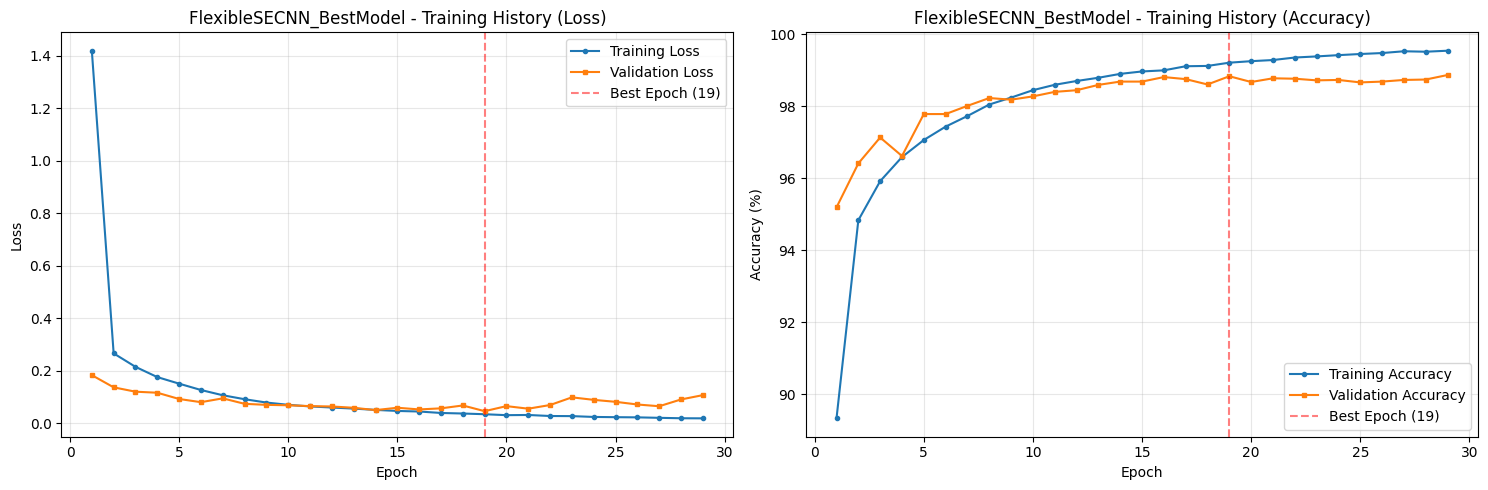


EVALUATING ON TEST SET



Testing: 100%|██████████| 685/685 [00:02<00:00, 255.61it/s]



Classification Report (FlexibleSECNN_BestModel):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     18118
           1       0.93      0.83      0.88       556
           2       0.99      0.95      0.97      1448
           3       0.79      0.85      0.82       162
           4       1.00      0.99      1.00      1608

    accuracy                           0.99     21892
   macro avg       0.94      0.92      0.93     21892
weighted avg       0.99      0.99      0.99     21892



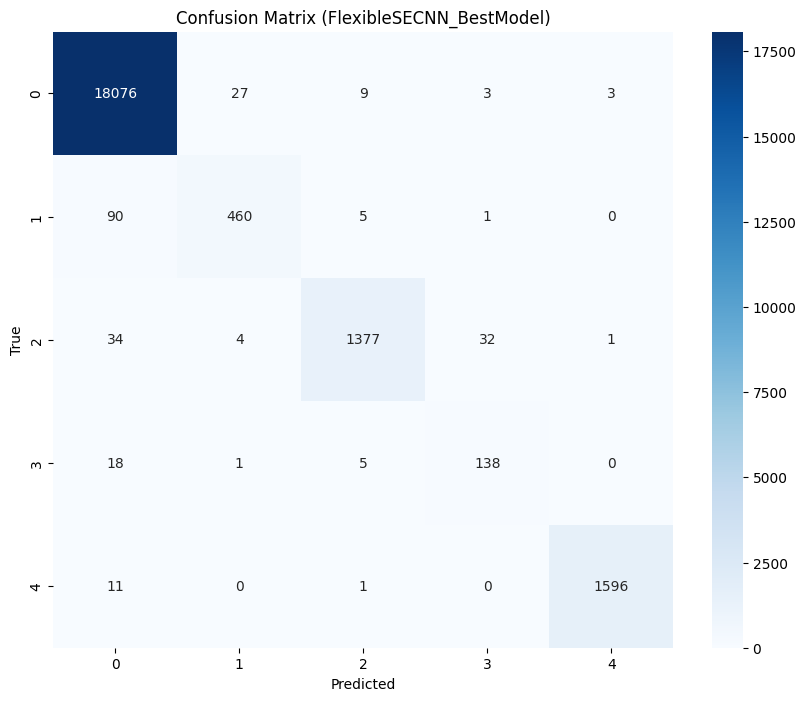


✓ Model and results saved to: models\FlexibleSECNN_BestModel_20251112_173939


In [23]:
final_results = train_final_model_se(
    best_params=best_params,
    X_train=X_train,
    X_val=X_val,
    X_test=X_test,
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    constant_filters=True,
    combine_train_val=False,  
    num_epochs=50
)

 ## Data Augmented Versions

In [20]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import os
from datetime import datetime
import optuna
import copy
import numpy as np
import torch
from optuna.exceptions import TrialPruned
from imblearn.over_sampling import SMOTE
from tsaug import TimeWarp, Drift, AddNoise

In [21]:
import random

seed = 42

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [22]:
class ECGDataset(Dataset):

    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [23]:
incart_path = 'INCART 2-lead Arrhythmia Database.csv'
mitbih_train_path = 'data/mitbih_train.csv'
mitbih_test_path = 'data/mitbih_test.csv'

## Data Preprocessing: Hybrid sampling strategy 
## (Under-sampling + SMOTE Over-sampling)

In [24]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

class NewECGDataProcessor:
    """
    Class to handle ECG data preprocessing for multiple datasets
    """
    def __init__(self, mitbih_train_path, mitbih_test_path, incart_path):
        self.mitbih_train_path = mitbih_train_path
        self.mitbih_test_path = mitbih_test_path
        self.incart_path = incart_path
        self.scaler = StandardScaler()

    def load_and_preprocess_mitbih(self):
        """
        Load and preprocess MIT-BIH test dataset
        """
        print("Loading MIT-BIH dataset...")
        df_train = pd.read_csv(self.mitbih_train_path, header=None)
        df_test = pd.read_csv(self.mitbih_test_path, header=None)

        # Separate features and labels
        X_train = df_train.iloc[:, :-1].values
        y_train = df_train.iloc[:, -1].values
        X_test = df_test.iloc[:, :-1].values
        y_test = df_test.iloc[:, -1].values

        print(f"MIT-BIH dataset shape: {X_train.shape}")
        self._print_class_distribution("MIT-BIH", y_train)

        return X_train, y_train, X_test, y_test

    def _print_class_distribution(self, dataset_name, y):
        """
        Print class distribution for a dataset
        """
        print(f"\nClass distribution in {dataset_name}:")
        classes = np.unique(y)
        for class_id in sorted(classes):
            count = np.sum(y == class_id)
            percentage = (count / len(y)) * 100
            print(f"  Class {int(class_id)}: {count:6d} samples ({percentage:5.2f}%)")
        print(f"  Total: {len(y)} samples")

    def preprocess_mitbih_data(self):
        print("Loading MIT-BIH dataset...")
        df_train = pd.read_csv(self.mitbih_train_path, header=None)
        df_test = pd.read_csv(self.mitbih_test_path, header=None)

        # Separate features and labels
        X_train = df_train.iloc[:, :-1].values
        y_train = df_train.iloc[:, -1].values
        X_test = df_test.iloc[:, :-1].values
        y_test = df_test.iloc[:, -1].values

        # Split before applying sampling methods
        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train,
            test_size=0.1,
            random_state=42,
            stratify=y_train
        )

        # Print Initial class distributions
        self._print_class_distribution("INITIAL Training Set ", y_train)
        self._print_class_distribution("Validation Set", y_val)
        self._print_class_distribution("Test Set", y_test)

        # Step 1: Undersample Class 0 first
        undersample_strategy = {
            0: 40000  # Reduce Class 0 only
        }
        
        rus = RandomUnderSampler(sampling_strategy=undersample_strategy, random_state=42)
        X_train, y_train = rus.fit_resample(X_train, y_train)
        
        # Step 2: Oversample minority classes with SMOTE
        oversample_strategy = {
            1: 15000,  
            2: 8000,    
            3: 12000,   
            4: 10000    
        }
        
        smote = SMOTE(sampling_strategy=oversample_strategy, random_state=42, k_neighbors=5)
        X_train, y_train = smote.fit_resample(X_train, y_train)

        # Print final class distributions
        self._print_class_distribution("Training Set (after SMOTE + undersampling)", y_train)
        self._print_class_distribution("Validation Set", y_val)
        self._print_class_distribution("Test Set", y_test)

        # Reshape
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
        X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

        print(f"\nFinal dataset sizes:")
        print(f"Training set: {X_train.shape}")
        print(f"Validation set: {X_val.shape}")
        print(f"Test set: {X_test.shape}")

        return X_train, X_val, X_test, y_train, y_val, y_test

In [25]:
# Create processor instance
processor = NewECGDataProcessor(mitbih_train_path, mitbih_test_path, incart_path)

# Load and preprocess data
X_train, X_val, X_test, y_train, y_val, y_test = processor.preprocess_mitbih_data()

Loading MIT-BIH dataset...

Class distribution in INITIAL Training Set :
  Class 0:  65223 samples (82.77%)
  Class 1:   2001 samples ( 2.54%)
  Class 2:   5209 samples ( 6.61%)
  Class 3:    577 samples ( 0.73%)
  Class 4:   5788 samples ( 7.35%)
  Total: 78798 samples

Class distribution in Validation Set:
  Class 0:   7248 samples (82.78%)
  Class 1:    222 samples ( 2.54%)
  Class 2:    579 samples ( 6.61%)
  Class 3:     64 samples ( 0.73%)
  Class 4:    643 samples ( 7.34%)
  Total: 8756 samples

Class distribution in Test Set:
  Class 0:  18118 samples (82.76%)
  Class 1:    556 samples ( 2.54%)
  Class 2:   1448 samples ( 6.61%)
  Class 3:    162 samples ( 0.74%)
  Class 4:   1608 samples ( 7.35%)
  Total: 21892 samples

Class distribution in Training Set (after SMOTE + undersampling):
  Class 0:  40000 samples (47.06%)
  Class 1:  15000 samples (17.65%)
  Class 2:   8000 samples ( 9.41%)
  Class 3:  12000 samples (14.12%)
  Class 4:  10000 samples (11.76%)
  Total: 85000 sampl

In [26]:
print("Final dataset shape:")
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Final dataset shape:
Training set: (85000, 187, 1)
Validation set: (8756, 187, 1)
Test set: (21892, 187, 1)


## Data Augmentation

To improve model robustness and generalization, we applied the following augmentation techniques using the `tsaug` library:

### Methods Applied

1. **Additive Gaussian Noise**
   - Simulates electronic and thermal interference in ECG equipment
   - Noise scale: 0.01
   - Probability: 60%

2. **Baseline Wander (Drift)**
   - Models low-frequency drift caused by patient respiration and movement
   - Maximum drift: 0.15
   - Drift points: 5
   - Probability: 50%

3. **Time Warping**
   - Simulates natural variations in heart rate and recording speed
   - Speed changes: 3
   - Maximum speed ratio: 1.5
   - Probability: 30%


1. Additive Noise (Gaussian):
    Applied: (85000, 187, 1)

2. Baseline Wander( Drift):
    Applied: (85000, 187, 1)

3. Time Warping:
    Applied: (85000, 187, 1)

4. Combined (Additive Noise + Baseline Wander + Time Warping) :
    Applied: (85000, 187, 1)

1. Plotting Additive Noise...


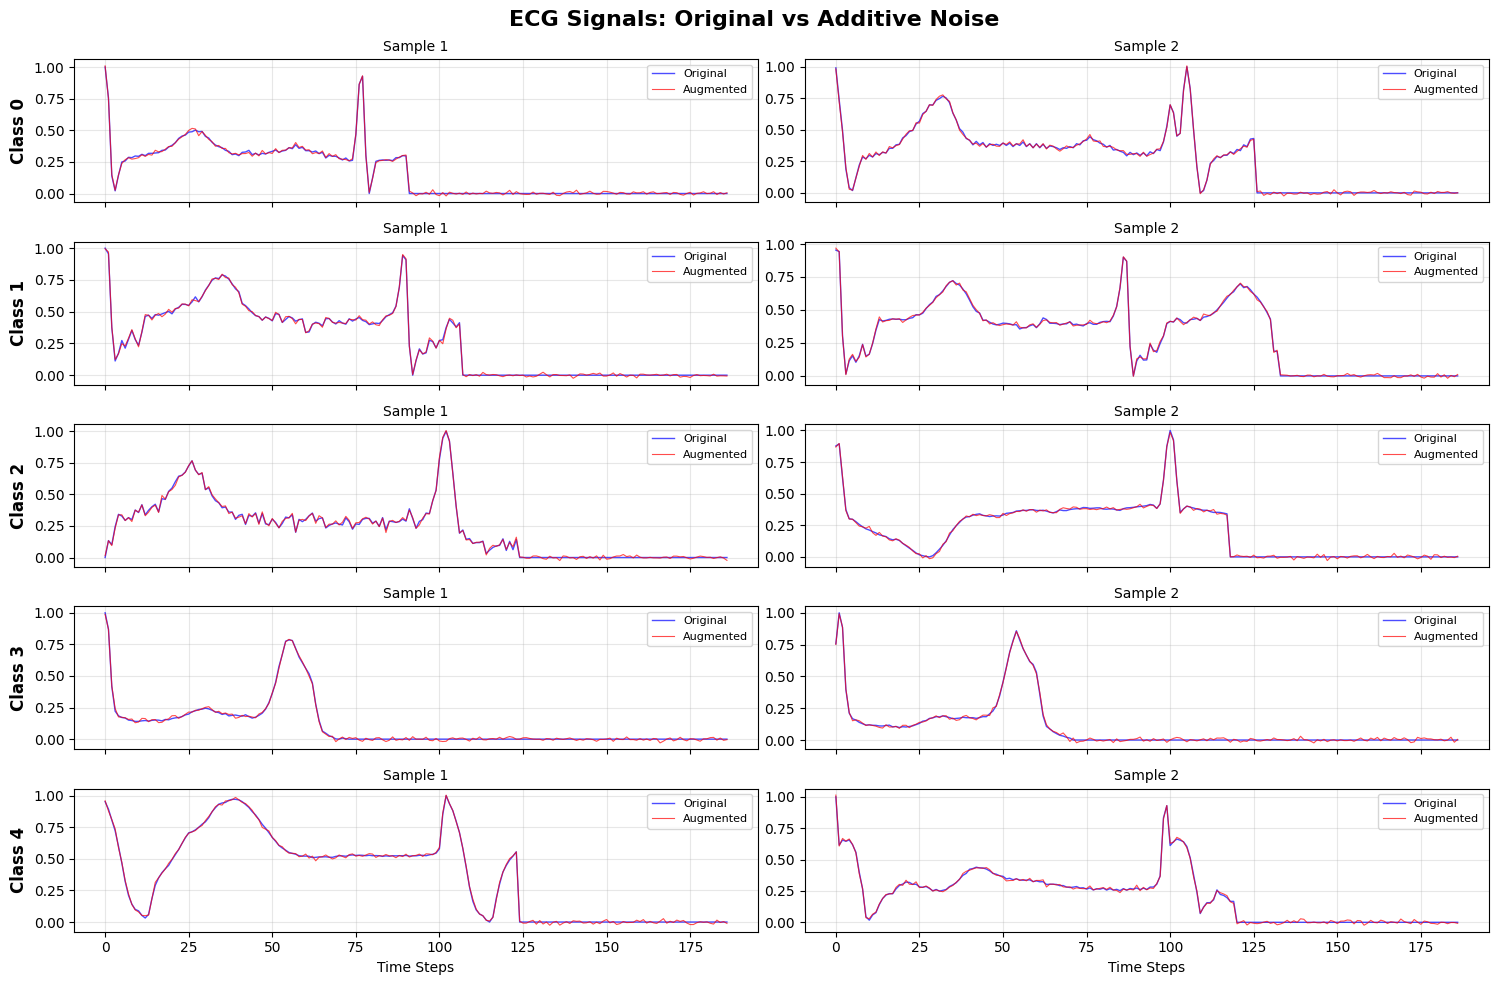


2. Plotting Baseline Wander...


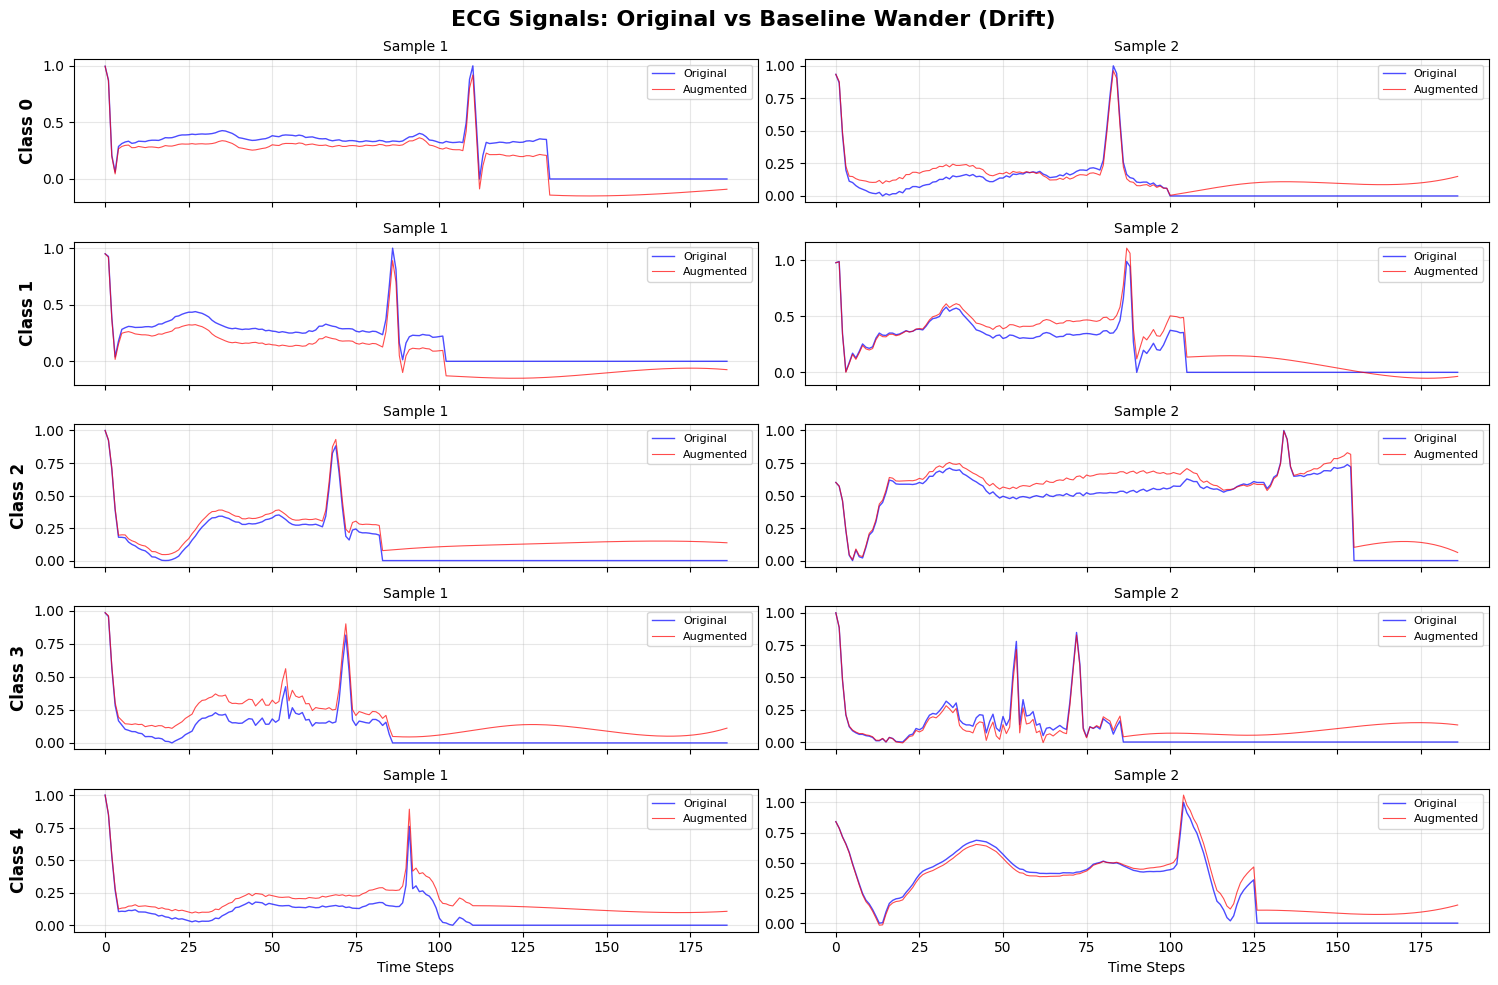


3. Plotting Time Warping...


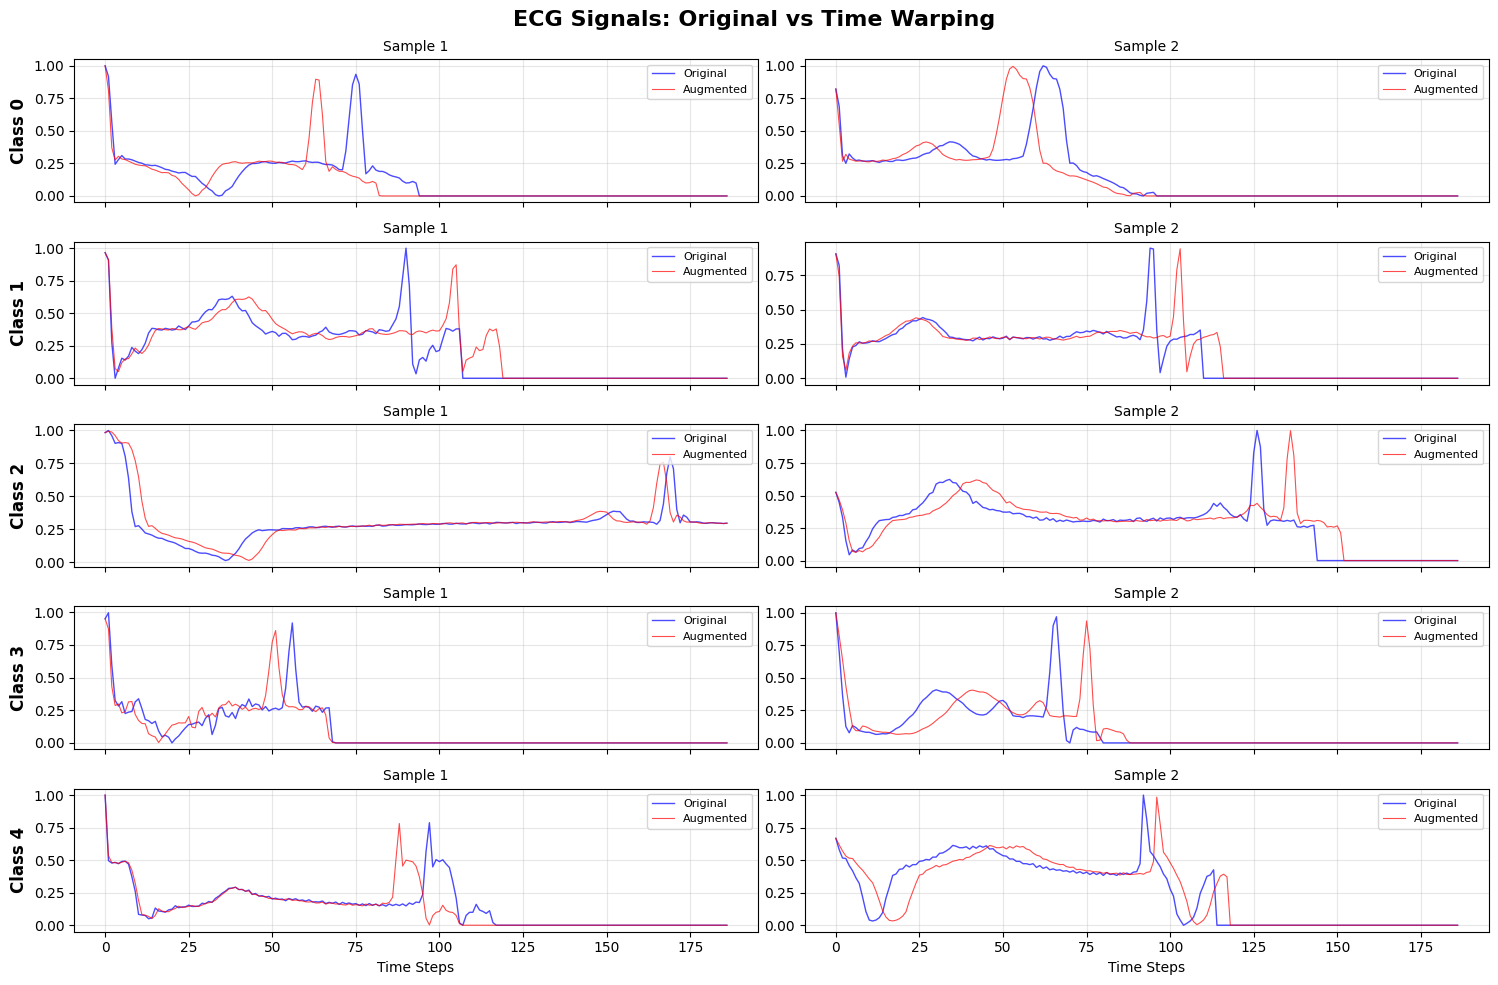


4. Plotting Combined Augmentation...


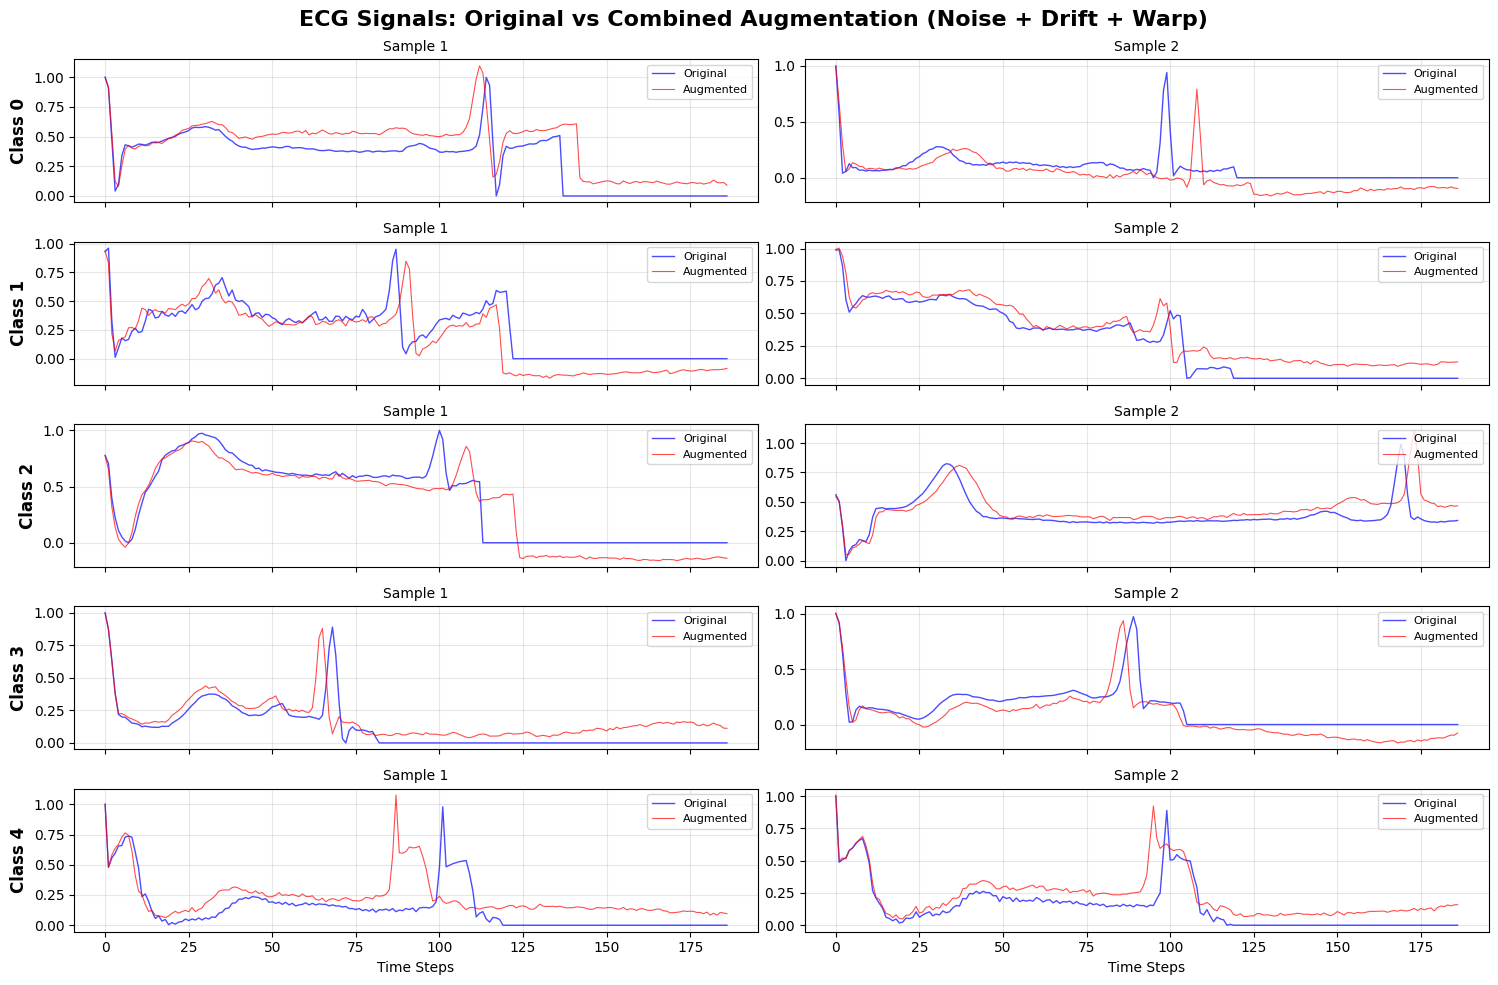

In [27]:
from tsaug import AddNoise, Drift, TimeWarp
import numpy as np
import matplotlib.pyplot as plt

# Define all augmentation methods
def apply_augmentations_separately(X_train):
    
    augmentations = {}
    
    # Additive Noise
    print("\n1. Additive Noise (Gaussian):")
    noise_augmenter = AddNoise(scale=0.01)
    augmentations['noise'] = noise_augmenter.augment(X_train.squeeze()).reshape(X_train.shape)
    print(f"    Applied: {augmentations['noise'].shape}")
    
    # Baseline Wander (Drift)
    print("\n2. Baseline Wander( Drift):")
    drift_augmenter = Drift(max_drift=0.15, n_drift_points=5)
    augmentations['drift'] = drift_augmenter.augment(X_train.squeeze()).reshape(X_train.shape)
    print(f"    Applied: {augmentations['drift'].shape}")
    
    # Time Warping
    print("\n3. Time Warping:")
    warp_augmenter = TimeWarp(n_speed_change=3, max_speed_ratio=1.5)
    augmentations['warp'] = warp_augmenter.augment(X_train.squeeze()).reshape(X_train.shape)
    print(f"    Applied: {augmentations['warp'].shape}")
    
    # Combined
    print("\n4. Combined (Additive Noise + Baseline Wander + Time Warping) :")
    combined_augmenter = (
        AddNoise(scale=0.01) +
        Drift(max_drift=0.15, n_drift_points=5) +
        TimeWarp(n_speed_change=3, max_speed_ratio=1.5)
    )
    augmentations['combined'] = combined_augmenter.augment(X_train.squeeze()).reshape(X_train.shape)
    print(f"    Applied: {augmentations['combined'].shape}")
    
    return augmentations


def plot_overlay_noise_comparison(X_original, X_noisy, y, samples_per_class=2, figsize=(15, 10), figtitle=""):
    """
    Plot original vs augmented signals overlaid
    """
    classes = np.unique(y)
    n_classes = len(classes)
    
    fig, axes = plt.subplots(n_classes, samples_per_class, figsize=figsize)
    
    # Set title
    if figtitle:
        fig.suptitle(figtitle, fontsize=16, fontweight='bold')
    else:
        fig.suptitle('ECG Signals: Original (Blue) vs Augmented (Red)', fontsize=16, fontweight='bold')
    
    # Handle single row or column
    if n_classes == 1 and samples_per_class == 1:
        axes = np.array([[axes]])
    elif n_classes == 1:
        axes = axes.reshape(1, -1)
    elif samples_per_class == 1:
        axes = axes.reshape(-1, 1)
    
    for i, class_id in enumerate(classes):
        # Get indices for this class
        class_indices = np.where(y == class_id)[0]
        
        # Randomly select samples
        selected_indices = np.random.choice(class_indices, 
                                           size=min(samples_per_class, len(class_indices)), 
                                           replace=False)
        
        for j, idx in enumerate(selected_indices):
            ax = axes[i, j] if n_classes > 1 else axes[j]
            
            # Plot both signals overlaid
            signal_original = X_original[idx].squeeze()
            signal_noisy = X_noisy[idx].squeeze()
            
            ax.plot(signal_original, linewidth=1.0, color='blue', label='Original', alpha=0.7)
            ax.plot(signal_noisy, linewidth=0.8, color='red', label='Augmented', alpha=0.7)
            
            # Add class label on the left
            if j == 0:
                ax.set_ylabel(f'Class {int(class_id)}', fontsize=12, fontweight='bold')
            
            ax.set_title(f'Sample {j+1}', fontsize=10)
            ax.grid(True, alpha=0.3)
            ax.legend(loc='upper right', fontsize=8)
            
            # Remove x-axis labels except for bottom row
            if i < n_classes - 1:
                ax.set_xticklabels([])
            else:
                ax.set_xlabel('Time Steps', fontsize=10)
    
    plt.tight_layout()
    plt.show()


augmentations = apply_augmentations_separately(X_train)

# 1. Additive Noise
print("\n1. Plotting Additive Noise...")
plot_overlay_noise_comparison(
    X_train, 
    augmentations['noise'], 
    y_train, 
    samples_per_class=2,
    figtitle='ECG Signals: Original vs Additive Noise'
)

# 2. Baseline Wander
print("\n2. Plotting Baseline Wander...")
plot_overlay_noise_comparison(
    X_train, 
    augmentations['drift'], 
    y_train, 
    samples_per_class=2,
    figtitle='ECG Signals: Original vs Baseline Wander (Drift)'
)

# 3. Time Warping
print("\n3. Plotting Time Warping...")
plot_overlay_noise_comparison(
    X_train, 
    augmentations['warp'], 
    y_train, 
    samples_per_class=2,
    figtitle='ECG Signals: Original vs Time Warping'
)

# 4. Combined
print("\n4. Plotting Combined Augmentation...")
plot_overlay_noise_comparison(
    X_train, 
    augmentations['combined'], 
    y_train, 
    samples_per_class=2,
    figtitle='ECG Signals: Original vs Combined Augmentation (Noise + Drift + Warp)'
)

In [125]:
# Added new class for augmented datasets and dataloaders

class ECGDataset(Dataset):

    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class ECGDatasetAugmented(Dataset):
    """
    Custom Dataset class for ECG data with optional augmentation
    """
    def __init__(self, X, y, augment=False):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
        self.augment = augment
        
        if self.augment:
            self.augmenter = (
                AddNoise(scale=0.01) @ 0.6 +  # 60% probability
                Drift(max_drift=0.15, n_drift_points=5) @ 0.5 +  # 50% probability
                TimeWarp(n_speed_change=3, max_speed_ratio=1.5) @ 0.3  # 30% probability
            )

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]
        
        if self.augment:
            x_numpy = x.numpy()
            x_aug = self.augmenter.augment(x_numpy.squeeze())
            x = torch.FloatTensor(x_aug.reshape(x_numpy.shape))
        
        return x, y

In [127]:
def create_data_loaders(X_train, X_val, X_test, y_train, y_val, y_test, 
                       batch_size=32, augment_train=True, num_workers=4):
    """
    Create train, validation, and test data loaders
    """
    # Create datasets - only augment training set
    train_dataset = ECGDatasetAugmented(X_train, y_train, augment=augment_train)
    val_dataset = ECGDatasetAugmented(X_val, y_val, augment=False)
    test_dataset = ECGDatasetAugmented(X_test, y_test, augment=False)

    # Create data loaders with parallel workers
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        persistent_workers=True if num_workers > 0 else False
    )
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,            # ← Added
        persistent_workers=True if num_workers > 0 else False  # ← Added
    )
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        persistent_workers=True if num_workers > 0 else False
    )
    
    # Print class distributions
    print("\n" + "="*60)
    print("DATA LOADERS CREATED")
    print("="*60)
    
    print(f"\nDataLoader Information:")
    print(f"  Training batches: {len(train_loader)} (batch_size={batch_size}, augment={augment_train})")
    print(f"  Validation batches: {len(val_loader)} (batch_size={batch_size})")
    print(f"  Test batches: {len(test_loader)} (batch_size={batch_size})")
    print(f"  Workers: {num_workers}, Pin memory: True")

    return train_loader, val_loader, test_loader


# Create data loaders WITH augmentation (Windows-compatible)
train_loader, val_loader, test_loader = create_data_loaders(
    X_train, X_val, X_test, y_train, y_val, y_test, 
    batch_size=2048,
    augment_train=True,
    num_workers=0  # Windows-safe setting
)

# Print final dataset sizes
print("\n" + "="*60)
print("FINAL DATASET SHAPES")
print("="*60)
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")


DATA LOADERS CREATED

DataLoader Information:
  Training batches: 39 (batch_size=2048, augment=True)
  Validation batches: 5 (batch_size=2048)
  Test batches: 11 (batch_size=2048)
  Workers: 0, Pin memory: True

FINAL DATASET SHAPES
Training set: (78798, 187, 1)
Validation set: (8756, 187, 1)
Test set: (21892, 187, 1)


In [57]:
print('EHLLO')

EHLLO


In [128]:
# Verify augmentation is actually happening
print("\n" + "="*60)
print("VERIFYING DYNAMIC AUGMENTATION")
print("="*60)

# Check the dataset class being used
print(f"Training dataset class: {type(train_loader.dataset).__name__}")
print(f"Augmentation enabled: {train_loader.dataset.augment}")

# Get two batches and see if they're different (proof of dynamic augmentation)
train_iter = iter(train_loader)
batch1_X, _ = next(train_iter)
batch1_X_first_sample = batch1_X[0].numpy()

# Reset and get same batch again (will be different due to dynamic augmentation)
train_iter = iter(train_loader)
batch2_X, _ = next(train_iter)
batch2_X_first_sample = batch2_X[0].numpy()

# They should be different due to augmentation
difference = np.abs(batch1_X_first_sample - batch2_X_first_sample).mean()
print(f"\nDifference between two fetches of same sample: {difference:.6f}")
if difference > 0:
    print(" Dynamic augmentation is WORKING (samples are different)")
else:
    print(" No augmentation (samples are identical)")


VERIFYING DYNAMIC AUGMENTATION
Training dataset class: ECGDatasetAugmented
Augmentation enabled: True

Difference between two fetches of same sample: 0.151180
 Dynamic augmentation is WORKING (samples are different)


In [59]:
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler

def optuna_search_se_cnn_with_aug(X_train, X_val, X_test, y_train, y_val, y_test,
                                   n_trials=50, constant_filters=True, timeout=None):
    """
    Optuna hyperparameter search for FlexibleSECNN with augmentation
    
    Parameters:
    -----------
    X_train, X_val, X_test : np.ndarray
        Training, validation, and test data
    y_train, y_val, y_test : np.ndarray
        Training, validation, and test labels
    n_trials : int, default=50
        Number of trials to run
    constant_filters : bool, default=True
        Whether to use constant filters throughout the network
    timeout : int, optional
        Time limit in seconds (None for no limit)
    
    Returns:
    --------
    tuple: (study, best_params, results_sorted)
    """
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    sequence_length = X_train.shape[1]
    num_classes = len(np.unique(y_train))
    
    print("="*70)
    print("OPTUNA HYPERPARAMETER SEARCH: FlexibleSECNN with Augmentation")
    print("="*70)
    print(f"Trials: {n_trials}")
    print(f"Device: {device}")
    print(f"Dataset: {X_train.shape[0]} train, {X_val.shape[0]} val samples")
    print(f"Sequence length: {sequence_length}, Classes: {num_classes}")
    print(f"Filter mode: {'CONSTANT' if constant_filters else 'SCALING'}")
    print(f"Timeout: {timeout if timeout else 'None'}")
    print(f"Augmentation: ENABLED for training data")
    print("="*70 + "\n")
    
    def objective(trial):
        """Objective function for Optuna optimization"""
        
        # Suggest hyperparameters
        params = {
            'num_filters': trial.suggest_categorical('num_filters', [16, 32, 64, 128]),
            'kernel_size': trial.suggest_categorical('kernel_size', [3, 5, 7, 9]),
            'num_res_blocks': trial.suggest_int('num_res_blocks', 2, 5),
            'pool_size': trial.suggest_categorical('pool_size', [2, 3, 5]),
            'pool_stride': 2,  # Fixed for stability
            'dropout_rate': trial.suggest_float('dropout_rate', 0.1, 0.5),
            'fc_neurons': trial.suggest_categorical('fc_neurons', [32, 64, 128, 256]),
            'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True),  # ← Fixed deprecation
            'batch_size': trial.suggest_categorical('batch_size', [32, 64, 128]),  # ← Now searchable!
            'weight_decay': trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True),  # ← Fixed deprecation
            'se_reduction': trial.suggest_categorical('se_reduction', [4, 8, 16]),
        }
        
        # Validate architecture
        valid, final_len, msg = validate_architecture(
            sequence_length, 
            params['num_res_blocks'], 
            params['pool_size'], 
            params['pool_stride']
        )
        
        if not valid:
            print(f"⊘ Trial {trial.number}: Invalid architecture - {msg}")
            raise optuna.exceptions.TrialPruned()
        
        print(f"\n{'='*70}")
        print(f"Trial {trial.number}")
        print(f"{'='*70}")
        print(f"Filters: {params['num_filters']} ({'constant' if constant_filters else 'scaling'}) × {params['num_res_blocks']} blocks")
        print(f"Kernel: {params['kernel_size']}, Pool: {params['pool_size']}/{params['pool_stride']}")
        print(f"SE Reduction: {params['se_reduction']}")
        print(f"Dropout: {params['dropout_rate']}, FC: {params['fc_neurons']}")
        print(f"LR: {params['learning_rate']:.2e}, Batch: {params['batch_size']}, WD: {params['weight_decay']:.2e}")
        print(f"{'='*70}")
        
        try:
            # Create model
            model = FlexibleSECNN(
                input_channels=1,
                num_classes=num_classes,
                num_filters=params['num_filters'],
                kernel_size=params['kernel_size'],
                num_res_blocks=params['num_res_blocks'],
                pool_size=params['pool_size'],
                pool_stride=params['pool_stride'],
                fc_neurons=params['fc_neurons'],
                dropout_rate=params['dropout_rate'],
                sequence_length=sequence_length,
                constant_filters=constant_filters,
                se_reduction=params['se_reduction']
            )
            
            model = model.to(device)
            
            # Create data loaders WITH AUGMENTATION
            train_loader = DataLoader(
                ECGDatasetAugmented(X_train, y_train, augment=True),  # ← Augmentation ON
                batch_size=params['batch_size'],
                shuffle=True,
                num_workers=0,
                pin_memory=True  # ← Added for faster transfer
            )
            val_loader = DataLoader(
                ECGDatasetAugmented(X_val, y_val, augment=False),  # ← No augmentation
                batch_size=params['batch_size'],
                num_workers=0,
                pin_memory=True
            )
            
            # Setup training
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.AdamW(
                model.parameters(),
                lr=params['learning_rate'],
                weight_decay=params['weight_decay']
            )
            
            # Training loop with Optuna pruning
            num_epochs = 30
            patience = 10
            best_val_acc = 0
            epochs_no_improve = 0
            
            for epoch in range(num_epochs):
                # Training
                model.train()
                train_loss = 0
                for batch_X, batch_y in train_loader:
                    batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                    optimizer.zero_grad()
                    outputs = model(batch_X)
                    loss = criterion(outputs, batch_y)
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    optimizer.step()
                    train_loss += loss.item()
                
                # Validation
                model.eval()
                correct = 0
                total = 0
                with torch.no_grad():
                    for batch_X, batch_y in val_loader:
                        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                        outputs = model(batch_X)
                        _, predicted = torch.max(outputs.data, 1)
                        total += batch_y.size(0)
                        correct += (predicted == batch_y).sum().item()
                
                val_acc = 100 * correct / total
                
                # Report intermediate value for pruning
                trial.report(val_acc, epoch)
                
                # Optuna pruning: stop unpromising trials early
                if trial.should_prune():
                    print(f"  ✂️ Pruned at epoch {epoch+1}")
                    raise optuna.exceptions.TrialPruned()
                
                # Early stopping
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
                
                if epochs_no_improve >= patience:
                    print(f"  Early stopping at epoch {epoch+1}")
                    break
                
                # Print progress every 5 epochs
                if (epoch + 1) % 5 == 0:
                    print(f"  Epoch {epoch+1}/{num_epochs}: Val Acc = {val_acc:.2f}%")
            
            print(f"  ✓ Final Validation Accuracy: {best_val_acc:.2f}%")
            
            return best_val_acc
            
        except optuna.exceptions.TrialPruned:
            raise
        except Exception as e:
            print(f"  ✗ Error: {str(e)}")
            import traceback
            traceback.print_exc()
            raise optuna.exceptions.TrialPruned()
    
    # Create Optuna study
    study = optuna.create_study(
        direction='maximize',  # Maximize validation accuracy
        pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=10),
        sampler=TPESampler(seed=42)  # Reproducible results
    )
    
    # Run optimization
    study.optimize(
        objective, 
        n_trials=n_trials,
        timeout=timeout,
        show_progress_bar=True
    )
    
    # Print results
    print(f"\n{'='*70}")
    print(f"OPTUNA OPTIMIZATION COMPLETE")
    print(f"{'='*70}")
    print(f"Number of finished trials: {len(study.trials)}")
    print(f"Number of pruned trials: {len([t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED])}")
    print(f"Number of complete trials: {len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])}")
    
    print(f"\nBest trial:")
    best_trial = study.best_trial
    print(f"  Value (Validation Accuracy): {best_trial.value:.2f}%")
    print(f"  Trial number: {best_trial.number}")
    
    print(f"\nBest hyperparameters:")
    print(f"{'='*70}")
    for key, value in best_trial.params.items():
        print(f"  {key:20s}: {value}")
    print(f"{'='*70}")
    
    # Convert trials to results format
    results_sorted = sorted(
        [
            {
                'params': {**t.params, 'pool_stride': 2},  # Add fixed params
                'val_accuracy': t.value,
                'trial_number': t.number,
                'state': t.state.name
            }
            for t in study.trials 
            if t.value is not None
        ],
        key=lambda x: x['val_accuracy'],
        reverse=True
    )
    
    # Print top 10
    print(f"\n{'='*70}")
    print(f"Top 10 Configurations:")
    print(f"{'='*70}")
    for i, result in enumerate(results_sorted[:10], 1):
        p = result['params']
        print(f"\n{i}. Val Acc: {result['val_accuracy']:.2f}% (Trial {result['trial_number']})")
        print(f"   Filters: {p['num_filters']} × {p['num_res_blocks']} blocks")
        print(f"   Kernel: {p['kernel_size']}, Pool: {p['pool_size']}/{p['pool_stride']}")
        print(f"   SE Reduction: {p['se_reduction']}")
        print(f"   Dropout: {p['dropout_rate']}, FC: {p['fc_neurons']}")
        print(f"   LR: {p['learning_rate']:.2e}, Batch: {p['batch_size']}, WD: {p['weight_decay']:.2e}")
    
    print("="*70)
    
    # Prepare best_params for use with train_final_model
    best_params = {**best_trial.params, 'pool_stride': 2}
    
    return study, best_params, results_sorted

In [90]:
def optuna_search_se_cnn_with_aug(train_loader, val_loader, test_loader,
                                   n_trials=50, constant_filters=True, timeout=None):
    """
    Optuna hyperparameter search for FlexibleSECNN with pre-made augmented dataloaders
    
    Parameters:
    -----------
    train_loader : DataLoader
        Training data loader (with augmentation)
    val_loader : DataLoader
        Validation data loader (no augmentation)
    test_loader : DataLoader
        Test data loader (no augmentation)
    n_trials : int, default=50
        Number of trials to run
    constant_filters : bool, default=True
        Whether to use constant filters throughout the network
    timeout : int, optional
        Time limit in seconds (None for no limit)
    
    Returns:
    --------
    tuple: (study, best_params, results_sorted)
    """
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Get data info from the loaders
    sample_batch = next(iter(train_loader))
    sequence_length = sample_batch[0].shape[1]
    
    # Get number of classes from dataset
    y_train = train_loader.dataset.y.numpy()
    num_classes = len(np.unique(y_train))
    
    print("="*70)
    print("OPTUNA HYPERPARAMETER SEARCH: FlexibleSECNN with Augmentation")
    print("="*70)
    print(f"Trials: {n_trials}")
    print(f"Device: {device}")
    print(f"Training batches: {len(train_loader)} (with augmentation)")
    print(f"Validation batches: {len(val_loader)}")
    print(f"Sequence length: {sequence_length}, Classes: {num_classes}")
    print(f"Filter mode: {'CONSTANT' if constant_filters else 'SCALING'}")
    print(f"Timeout: {timeout if timeout else 'None'}")
    print("="*70 + "\n")
    
    def objective(trial):
        """Objective function for Optuna optimization"""
        
        # Suggest hyperparameters
        params = {
            'num_filters': trial.suggest_categorical('num_filters', [16, 32, 64, 128]),
            'kernel_size': trial.suggest_categorical('kernel_size', [3, 5, 7, 9]),
            'num_res_blocks': trial.suggest_int('num_res_blocks', 2, 5),
            'pool_size': trial.suggest_categorical('pool_size', [2, 3, 5]),
            'pool_stride': 2,
            'dropout_rate': trial.suggest_float('dropout_rate', 0.1, 0.5),
            'fc_neurons': trial.suggest_categorical('fc_neurons', [32, 64, 128, 256]),
            'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
            'batch_size': train_loader.batch_size,  # Use existing batch size
            'weight_decay': trial.suggest_loguniform('weight_decay', 1e-6, 1e-3),
            'se_reduction': trial.suggest_categorical('se_reduction', [4, 8, 16]),
        }
        
        # Validate architecture
        valid, final_len, msg = validate_architecture(
            sequence_length, 
            params['num_res_blocks'], 
            params['pool_size'], 
            params['pool_stride']
        )
        
        if not valid:
            print(f"⊘ Trial {trial.number}: Invalid architecture - {msg}")
            raise optuna.exceptions.TrialPruned()
        
        print(f"\n{'='*70}")
        print(f"Trial {trial.number}")
        print(f"{'='*70}")
        print(f"Filters: {params['num_filters']} ({'constant' if constant_filters else 'scaling'}) × {params['num_res_blocks']} blocks")
        print(f"Kernel: {params['kernel_size']}, Pool: {params['pool_size']}/{params['pool_stride']}")
        print(f"SE Reduction: {params['se_reduction']}")
        print(f"Dropout: {params['dropout_rate']}, FC: {params['fc_neurons']}")
        print(f"LR: {params['learning_rate']:.2e}, Batch: {params['batch_size']}, WD: {params['weight_decay']:.2e}")
        print(f"{'='*70}")
        
        try:
            # Create model
            model = FlexibleSECNN(
                input_channels=1,
                num_classes=num_classes,
                num_filters=params['num_filters'],
                kernel_size=params['kernel_size'],
                num_res_blocks=params['num_res_blocks'],
                pool_size=params['pool_size'],
                pool_stride=params['pool_stride'],
                fc_neurons=params['fc_neurons'],
                dropout_rate=params['dropout_rate'],
                sequence_length=sequence_length,
                constant_filters=constant_filters,
                se_reduction=params['se_reduction']
            )
            
            model = model.to(device)
            
            # Setup training
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.AdamW(
                model.parameters(),
                lr=params['learning_rate'],
                weight_decay=params['weight_decay']
            )
            
            # Training loop with Optuna pruning
            num_epochs = 50
            patience = 7
            best_val_acc = 0
            epochs_no_improve = 0
            
            for epoch in range(num_epochs):
                # Training
                model.train()
                train_loss = 0
                for batch_X, batch_y in train_loader:
                    batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                    optimizer.zero_grad()
                    outputs = model(batch_X)
                    loss = criterion(outputs, batch_y)
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    optimizer.step()
                    train_loss += loss.item()
                
                # Validation
                model.eval()
                correct = 0
                total = 0
                with torch.no_grad():
                    for batch_X, batch_y in val_loader:
                        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                        outputs = model(batch_X)
                        _, predicted = torch.max(outputs.data, 1)
                        total += batch_y.size(0)
                        correct += (predicted == batch_y).sum().item()
                
                val_acc = 100 * correct / total
                
                # Report intermediate value for pruning
                trial.report(val_acc, epoch)
                
                # Optuna pruning
                if trial.should_prune():
                    print(f"  ✂️ Pruned at epoch {epoch+1}")
                    raise optuna.exceptions.TrialPruned()
                
                # Early stopping
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
                
                if epochs_no_improve >= patience:
                    print(f"  Early stopping at epoch {epoch+1}")
                    break
                
                if (epoch + 1) % 5 == 0:
                    print(f"  Epoch {epoch+1}/{num_epochs}: Val Acc = {val_acc:.2f}%")
            
            print(f"  ✓ Final Validation Accuracy: {best_val_acc:.2f}%")
            
            return best_val_acc
            
        except optuna.exceptions.TrialPruned:
            raise
        except Exception as e:
            print(f"  ✗ Error: {str(e)}")
            import traceback
            traceback.print_exc()
            raise optuna.exceptions.TrialPruned()
    
    # Create Optuna study
    study = optuna.create_study(
        direction='maximize',
        pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=10),
        sampler=TPESampler(seed=42)
    )
    
    # Run optimization
    study.optimize(
        objective, 
        n_trials=n_trials,
        timeout=timeout,
        show_progress_bar=True
    )
    
    # Print results
    print(f"\n{'='*70}")
    print(f"OPTUNA OPTIMIZATION COMPLETE")
    print(f"{'='*70}")
    print(f"Number of finished trials: {len(study.trials)}")
    print(f"Number of pruned trials: {len([t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED])}")
    print(f"Number of complete trials: {len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])}")
    
    print(f"\nBest trial:")
    best_trial = study.best_trial
    print(f"  Value (Validation Accuracy): {best_trial.value:.2f}%")
    print(f"  Trial number: {best_trial.number}")
    
    print(f"\nBest hyperparameters:")
    print(f"{'='*70}")
    for key, value in best_trial.params.items():
        print(f"  {key:20s}: {value}")
    print(f"{'='*70}")
    
    # Convert trials to results format
    results_sorted = sorted(
        [
            {
                'params': {**t.params, 'pool_stride': 2, 'batch_size': train_loader.batch_size},
                'val_accuracy': t.value,
                'trial_number': t.number,
                'state': t.state.name
            }
            for t in study.trials 
            if t.value is not None
        ],
        key=lambda x: x['val_accuracy'],
        reverse=True
    )
    
    # Print top 10
    print(f"\n{'='*70}")
    print(f"Top 10 Configurations:")
    print(f"{'='*70}")
    for i, result in enumerate(results_sorted[:10], 1):
        p = result['params']
        print(f"\n{i}. Val Acc: {result['val_accuracy']:.2f}% (Trial {result['trial_number']})")
        print(f"   Filters: {p['num_filters']} × {p['num_res_blocks']} blocks")
        print(f"   Kernel: {p['kernel_size']}, Pool: {p['pool_size']}/{p['pool_stride']}")
        print(f"   SE Reduction: {p['se_reduction']}")
        print(f"   Dropout: {p['dropout_rate']}, FC: {p['fc_neurons']}")
        print(f"   LR: {p['learning_rate']:.2e}, Batch: {p['batch_size']}, WD: {p['weight_decay']:.2e}")
    
    print("="*70)
    
    # Prepare best_params
    best_params = {**best_trial.params, 'pool_stride': 2, 'batch_size': train_loader.batch_size}
    
    return study, best_params, results_sorted

In [62]:
study, best_params, results_sorted = optuna_search_se_cnn_with_aug(
    train_loader=train_loader,  # ← Augmented training data
    val_loader=val_loader,       # ← No augmentation
    test_loader=test_loader,     # ← No augmentation (not used in search)
    n_trials=30,
    constant_filters=True,
    timeout=None
)

[I 2025-11-13 04:51:07,511] A new study created in memory with name: no-name-5bd79c4c-39f8-4aea-bf75-5379208f158f


OPTUNA HYPERPARAMETER SEARCH: FlexibleSECNN with Augmentation
Trials: 30
Device: cuda
Training batches: 665 (with augmentation)
Validation batches: 69
Sequence length: 187, Classes: 5
Filter mode: CONSTANT
Timeout: None



  0%|          | 0/30 [00:00<?, ?it/s]


Trial 0
Filters: 32 (constant) × 4 blocks
Kernel: 9, Pool: 5/2
SE Reduction: 8
Dropout: 0.4329770563201687, FC: 256
LR: 1.12e-04, Batch: 128, WD: 1.98e-05


C:\Users\zheng\AppData\Local\Temp\ipykernel_20272\1153476685.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
C:\Users\zheng\AppData\Local\Temp\ipykernel_20272\1153476685.py:62: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'weight_decay': trial.suggest_loguniform('weight_decay', 1e-6, 1e-3),


  Epoch 5/20: Val Acc = 93.60%
  Epoch 10/20: Val Acc = 96.69%
  Epoch 15/20: Val Acc = 97.22%


Best trial: 0. Best value: 97.6587:   3%|▎         | 1/30 [44:36<21:33:35, 2676.38s/it]

  Epoch 20/20: Val Acc = 97.66%
  ✓ Final Validation Accuracy: 97.66%
[I 2025-11-13 05:35:43,890] Trial 0 finished with value: 97.658748286889 and parameters: {'num_filters': 32, 'kernel_size': 9, 'num_res_blocks': 4, 'pool_size': 5, 'dropout_rate': 0.4329770563201687, 'fc_neurons': 256, 'learning_rate': 0.00011207606211860574, 'weight_decay': 1.9762189340280066e-05, 'se_reduction': 8}. Best is trial 0 with value: 97.658748286889.

Trial 1
Filters: 128 (constant) × 4 blocks
Kernel: 7, Pool: 5/2
SE Reduction: 16
Dropout: 0.4862528132298237, FC: 32
LR: 7.59e-05, Batch: 128, WD: 2.32e-06
  Epoch 5/20: Val Acc = 82.78%


Best trial: 0. Best value: 97.6587:   7%|▋         | 2/30 [1:02:31<13:29:23, 1734.41s/it]

  Early stopping at epoch 8
  ✓ Final Validation Accuracy: 82.78%
[I 2025-11-13 05:53:38,916] Trial 1 finished with value: 82.77752398355413 and parameters: {'num_filters': 128, 'kernel_size': 7, 'num_res_blocks': 4, 'pool_size': 5, 'dropout_rate': 0.4862528132298237, 'fc_neurons': 32, 'learning_rate': 7.591104805282687e-05, 'weight_decay': 2.3233503515390116e-06, 'se_reduction': 16}. Best is trial 0 with value: 97.658748286889.

Trial 2
Filters: 32 (constant) × 5 blocks
Kernel: 7, Pool: 5/2
SE Reduction: 16
Dropout: 0.1353970008207678, FC: 256
LR: 3.49e-05, Batch: 128, WD: 3.06e-04
  Epoch 5/20: Val Acc = 94.15%
  Epoch 10/20: Val Acc = 95.89%
  Epoch 15/20: Val Acc = 96.38%


Best trial: 0. Best value: 97.6587:  10%|█         | 3/30 [1:42:41<15:19:14, 2042.75s/it]

  Epoch 20/20: Val Acc = 96.59%
  ✓ Final Validation Accuracy: 96.96%
[I 2025-11-13 06:33:48,596] Trial 2 finished with value: 96.96208314298767 and parameters: {'num_filters': 32, 'kernel_size': 7, 'num_res_blocks': 5, 'pool_size': 5, 'dropout_rate': 0.1353970008207678, 'fc_neurons': 256, 'learning_rate': 3.488976654890367e-05, 'weight_decay': 0.0003063462210622083, 'se_reduction': 16}. Best is trial 0 with value: 97.658748286889.

Trial 3
Filters: 128 (constant) × 4 blocks
Kernel: 9, Pool: 3/2
SE Reduction: 8
Dropout: 0.24338629141770907, FC: 64
LR: 1.34e-05, Batch: 128, WD: 8.57e-06
  Epoch 5/20: Val Acc = 94.71%
  Epoch 10/20: Val Acc = 96.25%
  Epoch 15/20: Val Acc = 96.75%


Best trial: 0. Best value: 97.6587:  13%|█▎        | 4/30 [2:28:06<16:42:02, 2312.39s/it]

  Epoch 20/20: Val Acc = 96.93%
  ✓ Final Validation Accuracy: 97.00%
[I 2025-11-13 07:19:14,337] Trial 3 finished with value: 96.99634536317953 and parameters: {'num_filters': 128, 'kernel_size': 9, 'num_res_blocks': 4, 'pool_size': 3, 'dropout_rate': 0.24338629141770907, 'fc_neurons': 64, 'learning_rate': 1.3400367243354803e-05, 'weight_decay': 8.569331925053988e-06, 'se_reduction': 8}. Best is trial 0 with value: 97.658748286889.

Trial 4
Filters: 16 (constant) × 4 blocks
Kernel: 7, Pool: 2/2
SE Reduction: 4
Dropout: 0.11257167427469371, FC: 256
LR: 3.15e-05, Batch: 128, WD: 1.70e-05
  Epoch 5/20: Val Acc = 91.45%
  Epoch 10/20: Val Acc = 92.91%
  Epoch 15/20: Val Acc = 94.69%


Best trial: 0. Best value: 97.6587:  17%|█▋        | 5/30 [3:05:13<15:50:40, 2281.62s/it]

  Epoch 20/20: Val Acc = 95.07%
  ✓ Final Validation Accuracy: 95.26%
[I 2025-11-13 07:56:21,412] Trial 4 finished with value: 95.2603928734582 and parameters: {'num_filters': 16, 'kernel_size': 7, 'num_res_blocks': 4, 'pool_size': 2, 'dropout_rate': 0.11257167427469371, 'fc_neurons': 256, 'learning_rate': 3.151987295193886e-05, 'weight_decay': 1.7027416886764403e-05, 'se_reduction': 4}. Best is trial 0 with value: 97.658748286889.

Trial 5
Filters: 64 (constant) × 5 blocks
Kernel: 5, Pool: 5/2
SE Reduction: 4
Dropout: 0.22720138998874556, FC: 256
LR: 5.27e-04, Batch: 128, WD: 1.05e-06
  Epoch 5/20: Val Acc = 98.04%
  Epoch 10/20: Val Acc = 98.52%
  Epoch 15/20: Val Acc = 98.42%


Best trial: 5. Best value: 98.5153:  20%|██        | 6/30 [3:42:52<15:09:27, 2273.66s/it]

  Early stopping at epoch 17
  ✓ Final Validation Accuracy: 98.52%
[I 2025-11-13 08:33:59,605] Trial 5 finished with value: 98.5153037916857 and parameters: {'num_filters': 64, 'kernel_size': 5, 'num_res_blocks': 5, 'pool_size': 5, 'dropout_rate': 0.22720138998874556, 'fc_neurons': 256, 'learning_rate': 0.0005265761277157427, 'weight_decay': 1.0491954332267908e-06, 'se_reduction': 4}. Best is trial 5 with value: 98.5153037916857.

Trial 6
Filters: 64 (constant) × 5 blocks
Kernel: 9, Pool: 3/2
SE Reduction: 16
Dropout: 0.21393619775098704, FC: 64
LR: 3.61e-05, Batch: 128, WD: 5.31e-04
  Epoch 5/20: Val Acc = 95.52%
  Epoch 10/20: Val Acc = 96.68%
  Epoch 15/20: Val Acc = 97.43%


Best trial: 5. Best value: 98.5153:  23%|██▎       | 7/30 [4:26:22<15:13:43, 2383.65s/it]

  Epoch 20/20: Val Acc = 97.94%
  ✓ Final Validation Accuracy: 97.94%
[I 2025-11-13 09:17:29,698] Trial 6 finished with value: 97.9442667884879 and parameters: {'num_filters': 64, 'kernel_size': 9, 'num_res_blocks': 5, 'pool_size': 3, 'dropout_rate': 0.21393619775098704, 'fc_neurons': 64, 'learning_rate': 3.608219327363783e-05, 'weight_decay': 0.0005306371575220846, 'se_reduction': 16}. Best is trial 5 with value: 98.5153037916857.

Trial 7
Filters: 16 (constant) × 4 blocks
Kernel: 5, Pool: 5/2
SE Reduction: 8
Dropout: 0.22831202598869435, FC: 256
LR: 1.08e-05, Batch: 128, WD: 3.44e-05
  Epoch 5/20: Val Acc = 72.42%
  Epoch 10/20: Val Acc = 76.46%


Best trial: 5. Best value: 98.5153:  27%|██▋       | 8/30 [4:46:40<12:17:55, 2012.53s/it]

  ✂️ Pruned at epoch 11
[I 2025-11-13 09:37:47,596] Trial 7 pruned. 

Trial 8
Filters: 64 (constant) × 3 blocks
Kernel: 7, Pool: 3/2
SE Reduction: 16
Dropout: 0.3118602313424026, FC: 256
LR: 1.85e-04, Batch: 128, WD: 1.04e-05
  Epoch 5/20: Val Acc = 96.36%
  Epoch 10/20: Val Acc = 97.40%
  Epoch 15/20: Val Acc = 97.56%


Best trial: 5. Best value: 98.5153:  30%|███       | 9/30 [5:29:42<12:46:47, 2190.83s/it]

  Epoch 20/20: Val Acc = 97.57%
  ✓ Final Validation Accuracy: 98.16%
[I 2025-11-13 10:20:50,474] Trial 8 finished with value: 98.16126084970305 and parameters: {'num_filters': 64, 'kernel_size': 7, 'num_res_blocks': 3, 'pool_size': 3, 'dropout_rate': 0.3118602313424026, 'fc_neurons': 256, 'learning_rate': 0.00018458776634788638, 'weight_decay': 1.0401341922663459e-05, 'se_reduction': 16}. Best is trial 5 with value: 98.5153037916857.

Trial 9
Filters: 16 (constant) × 2 blocks
Kernel: 5, Pool: 2/2
SE Reduction: 16
Dropout: 0.3194935157466344, FC: 256
LR: 2.98e-05, Batch: 128, WD: 9.47e-06
  Epoch 5/20: Val Acc = 84.23%
  Epoch 10/20: Val Acc = 90.05%


Best trial: 5. Best value: 98.5153:  33%|███▎      | 10/30 [5:49:34<10:27:25, 1882.25s/it]

  ✂️ Pruned at epoch 11
[I 2025-11-13 10:40:41,780] Trial 9 pruned. 

Trial 10
Filters: 64 (constant) × 5 blocks
Kernel: 3, Pool: 5/2
SE Reduction: 4
Dropout: 0.386067844878718, FC: 128
LR: 8.80e-04, Batch: 128, WD: 1.08e-06
  Epoch 5/20: Val Acc = 96.53%
  Epoch 10/20: Val Acc = 98.10%


Best trial: 5. Best value: 98.5153:  37%|███▋      | 11/30 [6:20:47<9:55:07, 1879.34s/it] 

  Early stopping at epoch 13
  ✓ Final Validation Accuracy: 98.33%
[I 2025-11-13 11:11:54,517] Trial 10 finished with value: 98.3325719506624 and parameters: {'num_filters': 64, 'kernel_size': 3, 'num_res_blocks': 5, 'pool_size': 5, 'dropout_rate': 0.386067844878718, 'fc_neurons': 128, 'learning_rate': 0.0008797203351795276, 'weight_decay': 1.0781389769401746e-06, 'se_reduction': 4}. Best is trial 5 with value: 98.5153037916857.

Trial 11
Filters: 64 (constant) × 5 blocks
Kernel: 3, Pool: 5/2
SE Reduction: 4
Dropout: 0.385825777551022, FC: 128
LR: 8.63e-04, Batch: 128, WD: 1.04e-06
  Epoch 5/20: Val Acc = 97.70%
  Epoch 10/20: Val Acc = 97.32%
  Epoch 15/20: Val Acc = 98.23%


Best trial: 11. Best value: 98.5724:  40%|████      | 12/30 [7:08:50<10:55:26, 2184.83s/it]

  Epoch 20/20: Val Acc = 98.20%
  ✓ Final Validation Accuracy: 98.57%
[I 2025-11-13 11:59:58,047] Trial 11 finished with value: 98.57240749200548 and parameters: {'num_filters': 64, 'kernel_size': 3, 'num_res_blocks': 5, 'pool_size': 5, 'dropout_rate': 0.385825777551022, 'fc_neurons': 128, 'learning_rate': 0.0008631500559640531, 'weight_decay': 1.040884256266125e-06, 'se_reduction': 4}. Best is trial 11 with value: 98.57240749200548.

Trial 12
Filters: 64 (constant) × 5 blocks
Kernel: 3, Pool: 5/2
SE Reduction: 4
Dropout: 0.38751834785943434, FC: 128
LR: 9.58e-04, Batch: 128, WD: 2.43e-06
  Epoch 5/20: Val Acc = 97.44%
  Epoch 10/20: Val Acc = 96.85%
  Epoch 15/20: Val Acc = 98.44%


Best trial: 11. Best value: 98.5724:  43%|████▎     | 13/30 [7:57:03<11:19:48, 2399.35s/it]

  Epoch 20/20: Val Acc = 97.99%
  ✓ Final Validation Accuracy: 98.53%
[I 2025-11-13 12:48:11,012] Trial 12 finished with value: 98.52672453174965 and parameters: {'num_filters': 64, 'kernel_size': 3, 'num_res_blocks': 5, 'pool_size': 5, 'dropout_rate': 0.38751834785943434, 'fc_neurons': 128, 'learning_rate': 0.0009584903551502663, 'weight_decay': 2.431038831483306e-06, 'se_reduction': 4}. Best is trial 11 with value: 98.57240749200548.

Trial 13
Filters: 64 (constant) × 3 blocks
Kernel: 3, Pool: 5/2
SE Reduction: 4
Dropout: 0.37994635823076617, FC: 128
LR: 3.88e-04, Batch: 128, WD: 3.40e-06
  Epoch 5/20: Val Acc = 95.68%
  Epoch 10/20: Val Acc = 94.79%


Best trial: 11. Best value: 98.5724:  47%|████▋     | 14/30 [8:19:44<9:16:13, 2085.83s/it] 

  ✂️ Pruned at epoch 11
[I 2025-11-13 13:10:52,400] Trial 13 pruned. 

Trial 14
Filters: 64 (constant) × 5 blocks
Kernel: 3, Pool: 5/2
SE Reduction: 4
Dropout: 0.38589642009700076, FC: 128
LR: 9.23e-04, Batch: 128, WD: 7.74e-05
  Epoch 5/20: Val Acc = 97.61%
  Epoch 10/20: Val Acc = 97.91%
  Epoch 15/20: Val Acc = 98.01%


Best trial: 11. Best value: 98.5724:  50%|█████     | 15/30 [9:00:46<9:09:45, 2199.04s/it]

  Epoch 20/20: Val Acc = 97.93%
  ✓ Final Validation Accuracy: 98.41%
[I 2025-11-13 13:51:53,796] Trial 14 finished with value: 98.41251713111009 and parameters: {'num_filters': 64, 'kernel_size': 3, 'num_res_blocks': 5, 'pool_size': 5, 'dropout_rate': 0.38589642009700076, 'fc_neurons': 128, 'learning_rate': 0.0009225014602548516, 'weight_decay': 7.737864789719572e-05, 'se_reduction': 4}. Best is trial 11 with value: 98.57240749200548.

Trial 15
Filters: 64 (constant) × 2 blocks
Kernel: 3, Pool: 2/2
SE Reduction: 4
Dropout: 0.4707324634469431, FC: 128
LR: 2.87e-04, Batch: 128, WD: 2.66e-06
  Epoch 5/20: Val Acc = 89.52%
  Epoch 10/20: Val Acc = 84.98%


Best trial: 11. Best value: 98.5724:  53%|█████▎    | 16/30 [9:24:05<7:36:58, 1958.44s/it]

  ✂️ Pruned at epoch 11
[I 2025-11-13 14:15:13,509] Trial 15 pruned. 

Trial 16
Filters: 64 (constant) × 5 blocks
Kernel: 3, Pool: 5/2
SE Reduction: 4
Dropout: 0.35173146641192615, FC: 128
LR: 5.87e-04, Batch: 128, WD: 4.10e-06
  Epoch 5/20: Val Acc = 97.58%
  Epoch 10/20: Val Acc = 98.25%
  Epoch 15/20: Val Acc = 98.32%


Best trial: 11. Best value: 98.5724:  57%|█████▋    | 17/30 [10:07:25<7:46:06, 2151.26s/it]

  Epoch 20/20: Val Acc = 97.91%
  ✓ Final Validation Accuracy: 98.41%
[I 2025-11-13 14:58:33,169] Trial 16 finished with value: 98.41251713111009 and parameters: {'num_filters': 64, 'kernel_size': 3, 'num_res_blocks': 5, 'pool_size': 5, 'dropout_rate': 0.35173146641192615, 'fc_neurons': 128, 'learning_rate': 0.0005870635603449103, 'weight_decay': 4.100696402150186e-06, 'se_reduction': 4}. Best is trial 11 with value: 98.57240749200548.

Trial 17
Filters: 32 (constant) × 3 blocks
Kernel: 3, Pool: 5/2
SE Reduction: 4
Dropout: 0.4157721149485409, FC: 32
LR: 2.25e-04, Batch: 128, WD: 5.93e-05
  Epoch 5/20: Val Acc = 83.79%
  Epoch 10/20: Val Acc = 87.27%


Best trial: 11. Best value: 98.5724:  60%|██████    | 18/30 [10:29:01<6:18:51, 1894.32s/it]

  ✂️ Pruned at epoch 11
[I 2025-11-13 15:20:09,378] Trial 17 pruned. 

Trial 18
Filters: 128 (constant) × 5 blocks
Kernel: 3, Pool: 3/2
SE Reduction: 4
Dropout: 0.4383408814716049, FC: 128
LR: 1.34e-04, Batch: 128, WD: 1.64e-06
  Epoch 5/20: Val Acc = 89.98%
  Epoch 10/20: Val Acc = 80.55%


Best trial: 11. Best value: 98.5724:  63%|██████▎   | 19/30 [10:53:12<5:22:51, 1761.06s/it]

  ✂️ Pruned at epoch 11
[I 2025-11-13 15:44:19,994] Trial 18 pruned. 

Trial 19
Filters: 64 (constant) × 4 blocks
Kernel: 3, Pool: 2/2
SE Reduction: 4
Dropout: 0.2717286077931118, FC: 128
LR: 5.27e-04, Batch: 128, WD: 5.09e-06
  Epoch 5/20: Val Acc = 96.86%
  Epoch 10/20: Val Acc = 96.97%
  Epoch 15/20: Val Acc = 98.16%


Best trial: 11. Best value: 98.5724:  67%|██████▋   | 20/30 [11:40:38<5:47:48, 2086.85s/it]

  Epoch 20/20: Val Acc = 98.13%
  ✓ Final Validation Accuracy: 98.42%
[I 2025-11-13 16:31:46,158] Trial 19 finished with value: 98.42393787117405 and parameters: {'num_filters': 64, 'kernel_size': 3, 'num_res_blocks': 4, 'pool_size': 2, 'dropout_rate': 0.2717286077931118, 'fc_neurons': 128, 'learning_rate': 0.00052651773417394, 'weight_decay': 5.0945084263931384e-06, 'se_reduction': 4}. Best is trial 11 with value: 98.57240749200548.

Trial 20
Filters: 64 (constant) × 5 blocks
Kernel: 3, Pool: 5/2
SE Reduction: 8
Dropout: 0.3536054464983429, FC: 128
LR: 8.77e-04, Batch: 128, WD: 9.37e-05
  Epoch 5/20: Val Acc = 96.71%
  Epoch 10/20: Val Acc = 97.69%
  Epoch 15/20: Val Acc = 98.26%


Best trial: 20. Best value: 98.5838:  70%|███████   | 21/30 [12:21:41<5:29:58, 2199.81s/it]

  Epoch 20/20: Val Acc = 98.58%
  ✓ Final Validation Accuracy: 98.58%
[I 2025-11-13 17:12:49,321] Trial 20 finished with value: 98.58382823206944 and parameters: {'num_filters': 64, 'kernel_size': 3, 'num_res_blocks': 5, 'pool_size': 5, 'dropout_rate': 0.3536054464983429, 'fc_neurons': 128, 'learning_rate': 0.0008774175326853728, 'weight_decay': 9.369678713229782e-05, 'se_reduction': 8}. Best is trial 20 with value: 98.58382823206944.

Trial 21
Filters: 64 (constant) × 5 blocks
Kernel: 3, Pool: 5/2
SE Reduction: 8
Dropout: 0.345474539892641, FC: 128
LR: 9.27e-04, Batch: 128, WD: 1.41e-04
  Epoch 5/20: Val Acc = 96.90%
  Epoch 10/20: Val Acc = 98.22%
  Epoch 15/20: Val Acc = 98.09%


Best trial: 20. Best value: 98.5838:  73%|███████▎  | 22/30 [13:08:06<5:16:43, 2375.47s/it]

  Epoch 20/20: Val Acc = 97.78%
  ✓ Final Validation Accuracy: 98.39%
[I 2025-11-13 17:59:14,448] Trial 21 finished with value: 98.38967565098218 and parameters: {'num_filters': 64, 'kernel_size': 3, 'num_res_blocks': 5, 'pool_size': 5, 'dropout_rate': 0.345474539892641, 'fc_neurons': 128, 'learning_rate': 0.000927120798322336, 'weight_decay': 0.00014130678725594216, 'se_reduction': 8}. Best is trial 20 with value: 98.58382823206944.

Trial 22
Filters: 64 (constant) × 5 blocks
Kernel: 3, Pool: 5/2
SE Reduction: 8
Dropout: 0.34873374122123973, FC: 128
LR: 3.77e-04, Batch: 128, WD: 1.87e-04
  Epoch 5/20: Val Acc = 97.50%
  Epoch 10/20: Val Acc = 97.86%
  Epoch 15/20: Val Acc = 97.74%


Best trial: 20. Best value: 98.5838:  77%|███████▋  | 23/30 [13:48:50<4:39:30, 2395.77s/it]

  ✂️ Pruned at epoch 17
[I 2025-11-13 18:39:57,559] Trial 22 pruned. 

Trial 23
Filters: 64 (constant) × 5 blocks
Kernel: 3, Pool: 5/2
SE Reduction: 8
Dropout: 0.28769243819537815, FC: 128
LR: 6.64e-04, Batch: 128, WD: 7.45e-04
  Epoch 5/20: Val Acc = 96.70%
  Epoch 10/20: Val Acc = 97.92%
  Epoch 15/20: Val Acc = 98.36%


Best trial: 20. Best value: 98.5838:  80%|████████  | 24/30 [14:31:49<4:05:04, 2450.78s/it]

  Early stopping at epoch 18
  ✓ Final Validation Accuracy: 98.44%
[I 2025-11-13 19:22:56,668] Trial 23 finished with value: 98.435358611238 and parameters: {'num_filters': 64, 'kernel_size': 3, 'num_res_blocks': 5, 'pool_size': 5, 'dropout_rate': 0.28769243819537815, 'fc_neurons': 128, 'learning_rate': 0.0006638700856395637, 'weight_decay': 0.0007447555773365183, 'se_reduction': 8}. Best is trial 20 with value: 98.58382823206944.

Trial 24
Filters: 64 (constant) × 4 blocks
Kernel: 3, Pool: 5/2
SE Reduction: 8
Dropout: 0.40664965187775604, FC: 32
LR: 3.32e-04, Batch: 128, WD: 5.25e-05
  Epoch 5/20: Val Acc = 82.78%


Best trial: 20. Best value: 98.5838:  83%|████████▎ | 25/30 [14:50:45<2:51:22, 2056.43s/it]

  Early stopping at epoch 8
  ✓ Final Validation Accuracy: 82.78%
[I 2025-11-13 19:41:53,116] Trial 24 finished with value: 82.77752398355413 and parameters: {'num_filters': 64, 'kernel_size': 3, 'num_res_blocks': 4, 'pool_size': 5, 'dropout_rate': 0.40664965187775604, 'fc_neurons': 32, 'learning_rate': 0.00033154259608951156, 'weight_decay': 5.246164776435968e-05, 'se_reduction': 8}. Best is trial 20 with value: 98.58382823206944.

Trial 25
Filters: 64 (constant) × 5 blocks
Kernel: 3, Pool: 5/2
SE Reduction: 4
Dropout: 0.46341767443912657, FC: 64
LR: 7.14e-04, Batch: 128, WD: 1.16e-04
  Epoch 5/20: Val Acc = 91.07%
  Epoch 10/20: Val Acc = 97.51%


Best trial: 20. Best value: 98.5838:  87%|████████▋ | 26/30 [15:24:21<2:16:16, 2044.16s/it]

  ✂️ Pruned at epoch 14
[I 2025-11-13 20:15:28,647] Trial 25 pruned. 

Trial 26
Filters: 128 (constant) × 4 blocks
Kernel: 3, Pool: 5/2
SE Reduction: 8
Dropout: 0.36606985177037854, FC: 128
LR: 4.60e-04, Batch: 128, WD: 1.67e-06
  Epoch 5/20: Val Acc = 90.51%
  Epoch 10/20: Val Acc = 96.23%


Best trial: 20. Best value: 98.5838:  90%|█████████ | 27/30 [15:47:58<1:32:48, 1856.16s/it]

  ✂️ Pruned at epoch 11
[I 2025-11-13 20:39:06,195] Trial 26 pruned. 

Trial 27
Filters: 32 (constant) × 5 blocks
Kernel: 5, Pool: 5/2
SE Reduction: 4
Dropout: 0.32949055154318485, FC: 128
LR: 2.36e-04, Batch: 128, WD: 5.71e-06
  Epoch 5/20: Val Acc = 96.57%
  Epoch 10/20: Val Acc = 97.50%


Best trial: 20. Best value: 98.5838:  93%|█████████▎| 28/30 [16:12:13<57:51, 1735.70s/it]  

  ✂️ Pruned at epoch 11
[I 2025-11-13 21:03:20,842] Trial 27 pruned. 

Trial 28
Filters: 16 (constant) × 3 blocks
Kernel: 9, Pool: 2/2
SE Reduction: 4
Dropout: 0.4467920113597448, FC: 128
LR: 6.87e-05, Batch: 128, WD: 2.56e-05
  Epoch 5/20: Val Acc = 88.65%
  Epoch 10/20: Val Acc = 93.90%


Best trial: 20. Best value: 98.5838:  97%|█████████▋| 29/30 [16:36:53<27:39, 1659.03s/it]

  ✂️ Pruned at epoch 11
[I 2025-11-13 21:28:00,985] Trial 28 pruned. 

Trial 29
Filters: 32 (constant) × 4 blocks
Kernel: 9, Pool: 3/2
SE Reduction: 8
Dropout: 0.41494290253066957, FC: 128
LR: 1.46e-04, Batch: 128, WD: 1.56e-05
  Epoch 5/20: Val Acc = 95.00%
  Epoch 10/20: Val Acc = 96.86%


Best trial: 20. Best value: 98.5838: 100%|██████████| 30/30 [17:01:48<00:00, 2043.63s/it]

  ✂️ Pruned at epoch 11
[I 2025-11-13 21:52:56,303] Trial 29 pruned. 

OPTUNA OPTIMIZATION COMPLETE
Number of finished trials: 30
Number of pruned trials: 12
Number of complete trials: 18

Best trial:
  Value (Validation Accuracy): 98.58%
  Trial number: 20

Best hyperparameters:
  num_filters         : 64
  kernel_size         : 3
  num_res_blocks      : 5
  pool_size           : 5
  dropout_rate        : 0.3536054464983429
  fc_neurons          : 128
  learning_rate       : 0.0008774175326853728
  weight_decay        : 9.369678713229782e-05
  se_reduction        : 8

Top 10 Configurations:

1. Val Acc: 98.58% (Trial 20)
   Filters: 64 × 5 blocks
   Kernel: 3, Pool: 5/2
   SE Reduction: 8
   Dropout: 0.3536054464983429, FC: 128
   LR: 8.77e-04, Batch: 128, WD: 9.37e-05

2. Val Acc: 98.57% (Trial 11)
   Filters: 64 × 5 blocks
   Kernel: 3, Pool: 5/2
   SE Reduction: 4
   Dropout: 0.385825777551022, FC: 128
   LR: 8.63e-04, Batch: 128, WD: 1.04e-06

3. Val Acc: 98.53% (Trial 12)
   Filt

In [63]:
def train_final_model_se_with_loaders(best_params, train_loader, val_loader, test_loader,
                                       constant_filters=True, num_epochs=50, 
                                       warmup_epochs=5, early_stopping_patience=10):
    """
    Train final SE-CNN model with pre-made dataloaders (supports augmentation)
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Get info from loaders
    sample_batch = next(iter(train_loader))
    sequence_length = sample_batch[0].shape[1]
    num_classes = len(torch.unique(train_loader.dataset.y))
    
    print("\n" + "="*70)
    print("TRAINING FINAL SE-CNN MODEL")
    print("="*70)
    print(f"\nBest Hyperparameters:")
    for key, value in best_params.items():
        print(f"  {key:20s}: {value}")
    print("="*70 + "\n")
    
    print(f"Device: {device}")
    print(f"Sequence length: {sequence_length}")
    print(f"Number of classes: {num_classes}")
    print(f"Training batches: {len(train_loader)} (with augmentation)")
    print(f"Validation batches: {len(val_loader) if val_loader else 0}")
    print(f"Test batches: {len(test_loader)}\n")
    
    # Ensure required params
    if 'pool_stride' not in best_params:
        best_params['pool_stride'] = 2
    if 'se_reduction' not in best_params:
        best_params['se_reduction'] = 16
    
    # Create model
    best_model = FlexibleSECNN(
        input_channels=1,
        num_classes=num_classes,
        num_filters=best_params['num_filters'],
        kernel_size=best_params['kernel_size'],
        num_res_blocks=best_params['num_res_blocks'],
        pool_size=best_params['pool_size'],
        pool_stride=best_params['pool_stride'],
        fc_neurons=best_params['fc_neurons'],
        dropout_rate=best_params['dropout_rate'],
        sequence_length=sequence_length,
        constant_filters=constant_filters,
        se_reduction=best_params['se_reduction']
    )
    
    # Setup training configuration
    config = {
        'initial_lr': best_params['learning_rate'],
        'max_lr': best_params['learning_rate'] * 2,
        'warmup_epochs': warmup_epochs,
        'num_epochs': num_epochs,
        'weight_decay': best_params['weight_decay']
    }
    
    criterion = nn.CrossEntropyLoss()
    
    # Initialize trainer``
    trainer = ModelTrainer(
        model=best_model,
        model_name='FlexibleSECNN_BestModel',
        device=device,
        criterion=criterion,
        config=config,
        early_stopping_patience=early_stopping_patience if val_loader else None
    )
    
    # Train
    print("Starting training...")
    trainer.train(train_loader, val_loader, num_epochs=config['num_epochs'])
    
    # Plot
    print("\nGenerating training history plot...")
    trainer.plot_training_history()
    
    # Evaluate
    print("\n" + "="*70)
    print("EVALUATING ON TEST SET")
    print("="*70 + "\n")
    test_results = trainer.evaluate(test_loader)
    
    print(f"\n✓ Model and results saved to: {trainer.save_dir}")
    
    return {
        'model': best_model,
        'trainer': trainer,
        'test_accuracy': test_results['accuracy'],
        'test_results': test_results,
        'best_params': best_params,
 'save_dir': trainer.save_dir
    }


TRAINING FINAL SE-CNN MODEL

Best Hyperparameters:
  num_filters         : 64
  kernel_size         : 3
  num_res_blocks      : 5
  pool_size           : 5
  dropout_rate        : 0.3536054464983429
  fc_neurons          : 128
  learning_rate       : 0.0008774175326853728
  weight_decay        : 9.369678713229782e-05
  se_reduction        : 8
  pool_stride         : 2
  batch_size          : 128

Device: cuda
Sequence length: 187
Number of classes: 5
Training batches: 665 (with augmentation)
Validation batches: 69
Test batches: 172

Starting training...

Starting training for FlexibleSECNN_BestModel...
Early stopping enabled with patience=10


Training: 100%|██████████| 665/665 [01:57<00:00,  5.65it/s]



Epoch [1/50]
Train Loss: 1.9779, Train Acc: 62.07%
Val Loss: 0.3426, Val Acc: 91.34%
Learning Rate: 0.001053
✓ New best model saved! (Val Loss: 0.3426)
Validation loss improved to 0.3426


Training: 100%|██████████| 665/665 [02:00<00:00,  5.50it/s]



Epoch [2/50]
Train Loss: 0.4805, Train Acc: 85.32%
Val Loss: 0.3019, Val Acc: 92.96%
Learning Rate: 0.001228
✓ New best model saved! (Val Loss: 0.3019)
Validation loss improved to 0.3019


Training: 100%|██████████| 665/665 [02:16<00:00,  4.89it/s]



Epoch [3/50]
Train Loss: 0.3231, Train Acc: 90.01%
Val Loss: 0.1616, Val Acc: 96.24%
Learning Rate: 0.001404
✓ New best model saved! (Val Loss: 0.1616)
Validation loss improved to 0.1616


Training: 100%|██████████| 665/665 [02:21<00:00,  4.69it/s]



Epoch [4/50]
Train Loss: 0.2625, Train Acc: 91.82%
Val Loss: 0.2227, Val Acc: 92.99%
Learning Rate: 0.001579
EarlyStopping counter: 1 out of 10


Training: 100%|██████████| 665/665 [02:17<00:00,  4.85it/s]



Epoch [5/50]
Train Loss: 0.2183, Train Acc: 93.17%
Val Loss: 0.1534, Val Acc: 95.65%
Learning Rate: 0.001755
✓ New best model saved! (Val Loss: 0.1534)
Validation loss improved to 0.1534


Training: 100%|██████████| 665/665 [02:21<00:00,  4.70it/s]



Epoch [6/50]
Train Loss: 0.1892, Train Acc: 94.01%
Val Loss: 0.1483, Val Acc: 95.98%
Learning Rate: 0.001754
✓ New best model saved! (Val Loss: 0.1483)
Validation loss improved to 0.1483


Training: 100%|██████████| 665/665 [02:22<00:00,  4.67it/s]



Epoch [7/50]
Train Loss: 0.1683, Train Acc: 94.81%
Val Loss: 0.0834, Val Acc: 97.69%
Learning Rate: 0.001751
✓ New best model saved! (Val Loss: 0.0834)
Validation loss improved to 0.0834


Training: 100%|██████████| 665/665 [02:23<00:00,  4.63it/s]



Epoch [8/50]
Train Loss: 0.1472, Train Acc: 95.44%
Val Loss: 0.1264, Val Acc: 96.76%
Learning Rate: 0.001745
EarlyStopping counter: 1 out of 10


Training: 100%|██████████| 665/665 [02:25<00:00,  4.57it/s]



Epoch [9/50]
Train Loss: 0.1379, Train Acc: 95.78%
Val Loss: 0.0677, Val Acc: 97.97%
Learning Rate: 0.001738
✓ New best model saved! (Val Loss: 0.0677)
Validation loss improved to 0.0677


Training: 100%|██████████| 665/665 [02:25<00:00,  4.56it/s]



Epoch [10/50]
Train Loss: 0.1236, Train Acc: 96.17%
Val Loss: 0.0938, Val Acc: 97.54%
Learning Rate: 0.001728
EarlyStopping counter: 1 out of 10


Training: 100%|██████████| 665/665 [02:25<00:00,  4.57it/s]



Epoch [11/50]
Train Loss: 0.1138, Train Acc: 96.44%
Val Loss: 0.0673, Val Acc: 98.15%
Learning Rate: 0.001717
✓ New best model saved! (Val Loss: 0.0673)
Validation loss improved to 0.0673


Training: 100%|██████████| 665/665 [02:22<00:00,  4.67it/s]



Epoch [12/50]
Train Loss: 0.1076, Train Acc: 96.61%
Val Loss: 0.0639, Val Acc: 98.37%
Learning Rate: 0.001703
✓ New best model saved! (Val Loss: 0.0639)
Validation loss improved to 0.0639


Training: 100%|██████████| 665/665 [02:22<00:00,  4.66it/s]



Epoch [13/50]
Train Loss: 0.0999, Train Acc: 96.89%
Val Loss: 0.0696, Val Acc: 98.10%
Learning Rate: 0.001688
EarlyStopping counter: 1 out of 10


Training: 100%|██████████| 665/665 [02:25<00:00,  4.57it/s]



Epoch [14/50]
Train Loss: 0.0938, Train Acc: 97.08%
Val Loss: 0.0529, Val Acc: 98.40%
Learning Rate: 0.001671
✓ New best model saved! (Val Loss: 0.0529)
Validation loss improved to 0.0529


Training: 100%|██████████| 665/665 [02:25<00:00,  4.57it/s]



Epoch [15/50]
Train Loss: 0.0897, Train Acc: 97.15%
Val Loss: 0.0606, Val Acc: 98.20%
Learning Rate: 0.001652
EarlyStopping counter: 1 out of 10


Training: 100%|██████████| 665/665 [02:25<00:00,  4.57it/s]



Epoch [16/50]
Train Loss: 0.0852, Train Acc: 97.32%
Val Loss: 0.0515, Val Acc: 98.55%
Learning Rate: 0.001632
✓ New best model saved! (Val Loss: 0.0515)
Validation loss improved to 0.0515


Training: 100%|██████████| 665/665 [02:25<00:00,  4.57it/s]



Epoch [17/50]
Train Loss: 0.0840, Train Acc: 97.45%
Val Loss: 0.0565, Val Acc: 98.24%
Learning Rate: 0.001610
EarlyStopping counter: 1 out of 10


Training: 100%|██████████| 665/665 [02:25<00:00,  4.58it/s]



Epoch [18/50]
Train Loss: 0.0793, Train Acc: 97.48%
Val Loss: 0.0535, Val Acc: 98.33%
Learning Rate: 0.001586
EarlyStopping counter: 2 out of 10


Training: 100%|██████████| 665/665 [02:25<00:00,  4.58it/s]



Epoch [19/50]
Train Loss: 0.0788, Train Acc: 97.60%
Val Loss: 0.0588, Val Acc: 98.16%
Learning Rate: 0.001561
EarlyStopping counter: 3 out of 10


Training: 100%|██████████| 665/665 [02:25<00:00,  4.57it/s]



Epoch [20/50]
Train Loss: 0.0736, Train Acc: 97.72%
Val Loss: 0.0564, Val Acc: 98.36%
Learning Rate: 0.001535
EarlyStopping counter: 4 out of 10


Training: 100%|██████████| 665/665 [02:25<00:00,  4.57it/s]



Epoch [21/50]
Train Loss: 0.0692, Train Acc: 97.83%
Val Loss: 0.0599, Val Acc: 98.47%
Learning Rate: 0.001508
EarlyStopping counter: 5 out of 10


Training: 100%|██████████| 665/665 [02:25<00:00,  4.58it/s]



Epoch [22/50]
Train Loss: 0.0687, Train Acc: 97.84%
Val Loss: 0.0583, Val Acc: 98.28%
Learning Rate: 0.001480
EarlyStopping counter: 6 out of 10


Training: 100%|██████████| 665/665 [02:25<00:00,  4.58it/s]



Epoch [23/50]
Train Loss: 0.0676, Train Acc: 97.89%
Val Loss: 0.0505, Val Acc: 98.54%
Learning Rate: 0.001452
✓ New best model saved! (Val Loss: 0.0505)
Validation loss improved to 0.0505


Training: 100%|██████████| 665/665 [02:21<00:00,  4.70it/s]



Epoch [24/50]
Train Loss: 0.0651, Train Acc: 98.03%
Val Loss: 0.0497, Val Acc: 98.33%
Learning Rate: 0.001422
✓ New best model saved! (Val Loss: 0.0497)
Validation loss improved to 0.0497


Training: 100%|██████████| 665/665 [02:21<00:00,  4.70it/s]



Epoch [25/50]
Train Loss: 0.0606, Train Acc: 98.19%
Val Loss: 0.0527, Val Acc: 98.53%
Learning Rate: 0.001392
EarlyStopping counter: 1 out of 10


Training: 100%|██████████| 665/665 [02:20<00:00,  4.73it/s]



Epoch [26/50]
Train Loss: 0.0606, Train Acc: 98.16%
Val Loss: 0.0531, Val Acc: 98.42%
Learning Rate: 0.001362
EarlyStopping counter: 2 out of 10


Training: 100%|██████████| 665/665 [02:22<00:00,  4.66it/s]



Epoch [27/50]
Train Loss: 0.0566, Train Acc: 98.22%
Val Loss: 0.0553, Val Acc: 98.55%
Learning Rate: 0.001331
EarlyStopping counter: 3 out of 10


Training: 100%|██████████| 665/665 [02:22<00:00,  4.66it/s]



Epoch [28/50]
Train Loss: 0.0553, Train Acc: 98.30%
Val Loss: 0.0566, Val Acc: 98.40%
Learning Rate: 0.001301
EarlyStopping counter: 4 out of 10


Training: 100%|██████████| 665/665 [02:21<00:00,  4.71it/s]



Epoch [29/50]
Train Loss: 0.0506, Train Acc: 98.40%
Val Loss: 0.0495, Val Acc: 98.63%
Learning Rate: 0.001270
✓ New best model saved! (Val Loss: 0.0495)
Validation loss improved to 0.0495


Training: 100%|██████████| 665/665 [02:26<00:00,  4.55it/s]



Epoch [30/50]
Train Loss: 0.0518, Train Acc: 98.37%
Val Loss: 0.0525, Val Acc: 98.65%
Learning Rate: 0.001240
EarlyStopping counter: 1 out of 10


Training: 100%|██████████| 665/665 [02:25<00:00,  4.57it/s]



Epoch [31/50]
Train Loss: 0.0509, Train Acc: 98.39%
Val Loss: 0.0493, Val Acc: 98.62%
Learning Rate: 0.001210
✓ New best model saved! (Val Loss: 0.0493)
Validation loss improved to 0.0493


Training: 100%|██████████| 665/665 [02:21<00:00,  4.69it/s]



Epoch [32/50]
Train Loss: 0.0482, Train Acc: 98.49%
Val Loss: 0.0576, Val Acc: 98.41%
Learning Rate: 0.001181
EarlyStopping counter: 1 out of 10


Training: 100%|██████████| 665/665 [02:22<00:00,  4.68it/s]



Epoch [33/50]
Train Loss: 0.0478, Train Acc: 98.50%
Val Loss: 0.0444, Val Acc: 98.77%
Learning Rate: 0.001152
✓ New best model saved! (Val Loss: 0.0444)
Validation loss improved to 0.0444


Training: 100%|██████████| 665/665 [02:21<00:00,  4.69it/s]



Epoch [34/50]
Train Loss: 0.0464, Train Acc: 98.54%
Val Loss: 0.0585, Val Acc: 98.54%
Learning Rate: 0.001124
EarlyStopping counter: 1 out of 10


Training: 100%|██████████| 665/665 [02:21<00:00,  4.71it/s]



Epoch [35/50]
Train Loss: 0.0457, Train Acc: 98.58%
Val Loss: 0.0522, Val Acc: 98.65%
Learning Rate: 0.001097
EarlyStopping counter: 2 out of 10


Training: 100%|██████████| 665/665 [02:21<00:00,  4.71it/s]



Epoch [36/50]
Train Loss: 0.0442, Train Acc: 98.60%
Val Loss: 0.0527, Val Acc: 98.66%
Learning Rate: 0.001071
EarlyStopping counter: 3 out of 10


Training: 100%|██████████| 665/665 [02:24<00:00,  4.59it/s]



Epoch [37/50]
Train Loss: 0.0419, Train Acc: 98.72%
Val Loss: 0.0564, Val Acc: 98.63%
Learning Rate: 0.001046
EarlyStopping counter: 4 out of 10


Training: 100%|██████████| 665/665 [02:26<00:00,  4.55it/s]



Epoch [38/50]
Train Loss: 0.0393, Train Acc: 98.75%
Val Loss: 0.0485, Val Acc: 98.78%
Learning Rate: 0.001023
EarlyStopping counter: 5 out of 10


Training: 100%|██████████| 665/665 [02:26<00:00,  4.55it/s]



Epoch [39/50]
Train Loss: 0.0396, Train Acc: 98.75%
Val Loss: 0.0481, Val Acc: 98.69%
Learning Rate: 0.001001
EarlyStopping counter: 6 out of 10


Training: 100%|██████████| 665/665 [02:26<00:00,  4.55it/s]



Epoch [40/50]
Train Loss: 0.0382, Train Acc: 98.83%
Val Loss: 0.0515, Val Acc: 98.74%
Learning Rate: 0.000980
EarlyStopping counter: 7 out of 10


Training: 100%|██████████| 665/665 [02:24<00:00,  4.62it/s]



Epoch [41/50]
Train Loss: 0.0403, Train Acc: 98.80%
Val Loss: 0.0484, Val Acc: 98.78%
Learning Rate: 0.000961
EarlyStopping counter: 8 out of 10


Training: 100%|██████████| 665/665 [02:21<00:00,  4.70it/s]



Epoch [42/50]
Train Loss: 0.0380, Train Acc: 98.84%
Val Loss: 0.0484, Val Acc: 98.76%
Learning Rate: 0.000944
EarlyStopping counter: 9 out of 10


Training: 100%|██████████| 665/665 [02:21<00:00,  4.69it/s]



Epoch [43/50]
Train Loss: 0.0350, Train Acc: 98.92%
Val Loss: 0.0580, Val Acc: 98.61%
Learning Rate: 0.000929
EarlyStopping counter: 10 out of 10

Early stopping triggered! No improvement for 10 epochs.
Best validation loss: 0.0444 at epoch 33

Training stopped early at epoch 43
Best validation loss: 0.0444
Best epoch: 33


Training Summary for FlexibleSECNN_BestModel
Total epochs trained: 43
Best validation loss: 0.0444
Final train accuracy: 98.92%
Final validation accuracy: 98.61%


Generating training history plot...


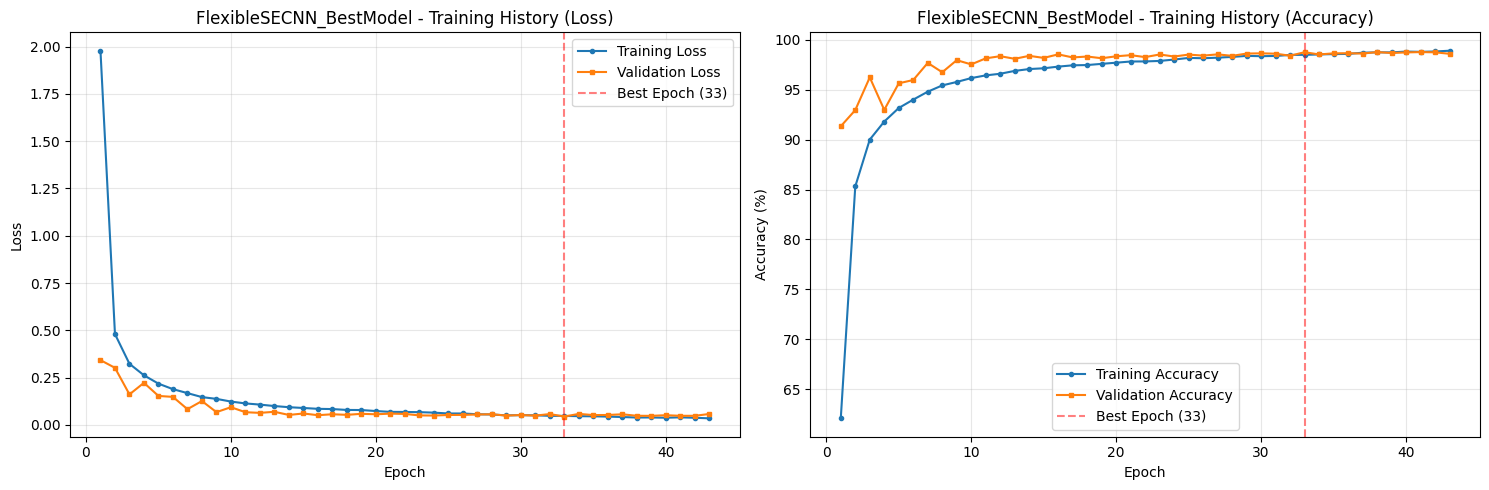


EVALUATING ON TEST SET



Testing: 100%|██████████| 172/172 [00:00<00:00, 238.74it/s]



Classification Report (FlexibleSECNN_BestModel):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     18118
           1       0.79      0.88      0.83       556
           2       0.98      0.96      0.97      1448
           3       0.67      0.91      0.77       162
           4       0.99      0.99      0.99      1608

    accuracy                           0.98     21892
   macro avg       0.88      0.95      0.91     21892
weighted avg       0.99      0.98      0.98     21892



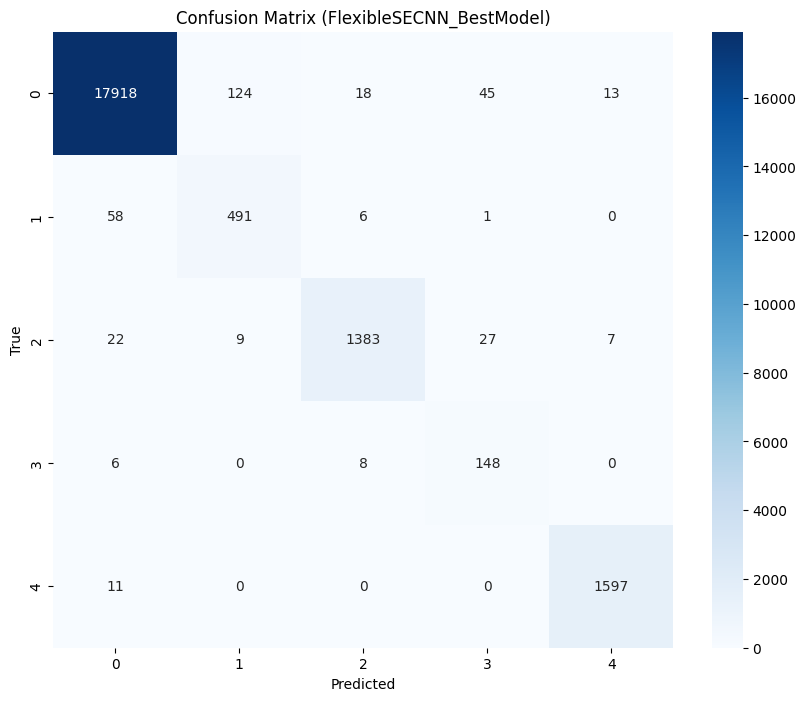


✓ Model and results saved to: models\FlexibleSECNN_BestModel_20251113_215413


In [64]:
final_results = train_final_model_se_with_loaders(
    best_params=best_params,
    train_loader=train_loader,  
    val_loader=val_loader,
    test_loader=test_loader,
    constant_filters=True,
    num_epochs=50
)

In [75]:
train_loader, val_loader, test_loader = create_data_loaders(
    X_train, X_val, X_test, y_train, y_val, y_test, 
    batch_size=1024,
    augment_train=True,
    num_workers=4,  # Start with 4, try up to 8
)


DATA LOADERS CREATED

DataLoader Information:
  Training batches: 84 (batch_size=1024, augment=True)
  Validation batches: 9 (batch_size=1024)
  Test batches: 22 (batch_size=1024)
  Workers: 4, Pin memory: True


In [87]:
def create_augmented_dataset(X_train, y_train, augmentation_factor=2):
    """
    Pre-compute augmented samples
    """
    from tsaug import AddNoise, Drift, TimeWarp
    
    print(f"\nCreating {augmentation_factor}x augmented dataset...")
    print(f"Original dataset: {X_train.shape}")
    
    augmenter = (
        AddNoise(scale=0.01) @ 0.6 +
        Drift(max_drift=0.15, n_drift_points=5) @ 0.5 +
        TimeWarp(n_speed_change=3, max_speed_ratio=1.5) @ 0.3
    )
    
    X_augmented_list = [X_train]  # Start with original
    y_augmented_list = [y_train]
    
    for i in range(augmentation_factor - 1):
        print(f"  Generating augmentation batch {i+1}/{augmentation_factor-1}...")
        X_aug = augmenter.augment(X_train.squeeze()).reshape(X_train.shape)
        X_augmented_list.append(X_aug)
        y_augmented_list.append(y_train)
    
    X_final = np.concatenate(X_augmented_list, axis=0)
    y_final = np.concatenate(y_augmented_list, axis=0)
    
    print(f"Final augmented dataset: {X_final.shape}")
    print(f"Augmentation complete!\n")
    return X_final, y_final

In [88]:
# Apply augmentation ONCE to create augmented training set (same size: 85,000)
print("="*60)
print("APPLYING AUGMENTATION TO TRAINING DATA")
print("="*60)

from tsaug import AddNoise, Drift, TimeWarp

augmenter = (
    AddNoise(scale=0.01) @ 0.6 +
    Drift(max_drift=0.15, n_drift_points=5) @ 0.5 +
    TimeWarp(n_speed_change=3, max_speed_ratio=1.5) @ 0.3
)

print(f"Original training set: {X_train.shape}")
print("Applying augmentation (this will take 1-2 minutes)...")

# Apply augmentation once to all training data
X_train_aug = augmenter.augment(X_train.squeeze()).reshape(X_train.shape)

print(f"Augmented training set: {X_train_aug.shape}")
print("✓ Augmentation complete!\n")

# Create datasets with pre-augmented data
train_dataset = ECGDataset(X_train_aug, y_train)  # ← Use augmented data
val_dataset = ECGDataset(X_val, y_val)
test_dataset = ECGDataset(X_test, y_test)

# Create data loaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=2048,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=2048,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=2048,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

print("="*60)
print("DATA LOADERS CREATED")
print("="*60)
print(f"\nDataLoader Information:")
print(f"  Training batches: {len(train_loader)} (batch_size=2048, pre-augmented)")
print(f"  Validation batches: {len(val_loader)} (batch_size=2048)")
print(f"  Test batches: {len(test_loader)} (batch_size=2048)")

print("\n" + "="*60)
print("FINAL DATASET SHAPES")
print("="*60)
print(f"Training set: {X_train_aug.shape} (augmented)")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

APPLYING AUGMENTATION TO TRAINING DATA
Original training set: (78798, 187, 1)
Applying augmentation (this will take 1-2 minutes)...
Augmented training set: (78798, 187, 1)
✓ Augmentation complete!

DATA LOADERS CREATED

DataLoader Information:
  Training batches: 39 (batch_size=2048, pre-augmented)
  Validation batches: 5 (batch_size=2048)
  Test batches: 11 (batch_size=2048)

FINAL DATASET SHAPES
Training set: (78798, 187, 1) (augmented)
Validation set: (8756, 187, 1)
Test set: (21892, 187, 1)


In [91]:
study, best_params, results_sorted = optuna_search_se_cnn_with_aug(
    train_loader=train_loader,  # ← Augmented training data
    val_loader=val_loader,       # ← No augmentation
    test_loader=test_loader,     # ← No augmentation (not used in search)
    n_trials=50,
    constant_filters=True,
    timeout=None
)

[I 2025-11-14 00:05:15,082] A new study created in memory with name: no-name-df37fb5c-119a-476c-93f1-abae1b4760bc


OPTUNA HYPERPARAMETER SEARCH: FlexibleSECNN with Augmentation
Trials: 50
Device: cuda
Training batches: 39 (with augmentation)
Validation batches: 5
Sequence length: 187, Classes: 5
Filter mode: CONSTANT
Timeout: None



  0%|          | 0/50 [00:00<?, ?it/s]


Trial 0
Filters: 32 (constant) × 4 blocks
Kernel: 9, Pool: 5/2
SE Reduction: 8
Dropout: 0.4329770563201687, FC: 256
LR: 1.12e-04, Batch: 2048, WD: 1.98e-05


C:\Users\zheng\AppData\Local\Temp\ipykernel_20272\2440031991.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
C:\Users\zheng\AppData\Local\Temp\ipykernel_20272\2440031991.py:62: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'weight_decay': trial.suggest_loguniform('weight_decay', 1e-6, 1e-3),


  Epoch 5/50: Val Acc = 90.68%
  Epoch 10/50: Val Acc = 92.27%
  Epoch 15/50: Val Acc = 93.54%
  Epoch 20/50: Val Acc = 94.12%
  Epoch 25/50: Val Acc = 94.85%
  Epoch 30/50: Val Acc = 95.03%
  Epoch 35/50: Val Acc = 95.17%
  Epoch 40/50: Val Acc = 96.57%
  Epoch 45/50: Val Acc = 96.78%


Best trial: 0. Best value: 96.9621:   2%|▏         | 1/50 [04:08<3:22:34, 248.05s/it]

  Epoch 50/50: Val Acc = 96.96%
  ✓ Final Validation Accuracy: 96.96%
[I 2025-11-14 00:09:23,134] Trial 0 finished with value: 96.96208314298767 and parameters: {'num_filters': 32, 'kernel_size': 9, 'num_res_blocks': 4, 'pool_size': 5, 'dropout_rate': 0.4329770563201687, 'fc_neurons': 256, 'learning_rate': 0.00011207606211860574, 'weight_decay': 1.9762189340280066e-05, 'se_reduction': 8}. Best is trial 0 with value: 96.96208314298767.

Trial 1
Filters: 128 (constant) × 4 blocks
Kernel: 7, Pool: 5/2
SE Reduction: 16
Dropout: 0.4862528132298237, FC: 32
LR: 7.59e-05, Batch: 2048, WD: 2.32e-06
  Epoch 5/50: Val Acc = 83.35%


Best trial: 0. Best value: 96.9621:   4%|▍         | 2/50 [05:27<1:59:00, 148.76s/it]

  Early stopping at epoch 10
  ✓ Final Validation Accuracy: 83.35%
[I 2025-11-14 00:10:42,395] Trial 1 finished with value: 83.34856098675195 and parameters: {'num_filters': 128, 'kernel_size': 7, 'num_res_blocks': 4, 'pool_size': 5, 'dropout_rate': 0.4862528132298237, 'fc_neurons': 32, 'learning_rate': 7.591104805282687e-05, 'weight_decay': 2.3233503515390116e-06, 'se_reduction': 16}. Best is trial 0 with value: 96.96208314298767.

Trial 2
Filters: 32 (constant) × 5 blocks
Kernel: 7, Pool: 5/2
SE Reduction: 16
Dropout: 0.1353970008207678, FC: 256
LR: 3.49e-05, Batch: 2048, WD: 3.06e-04
  Epoch 5/50: Val Acc = 93.43%
  Epoch 10/50: Val Acc = 94.43%
  Epoch 15/50: Val Acc = 95.18%
  Epoch 20/50: Val Acc = 95.66%
  Epoch 25/50: Val Acc = 95.85%
  Epoch 30/50: Val Acc = 96.16%
  Epoch 35/50: Val Acc = 96.43%
  Epoch 40/50: Val Acc = 96.57%
  Epoch 45/50: Val Acc = 96.71%


Best trial: 0. Best value: 96.9621:   6%|▌         | 3/50 [07:28<1:46:32, 136.00s/it]

  Epoch 50/50: Val Acc = 96.95%
  ✓ Final Validation Accuracy: 96.95%
[I 2025-11-14 00:12:43,215] Trial 2 finished with value: 96.95066240292371 and parameters: {'num_filters': 32, 'kernel_size': 7, 'num_res_blocks': 5, 'pool_size': 5, 'dropout_rate': 0.1353970008207678, 'fc_neurons': 256, 'learning_rate': 3.488976654890367e-05, 'weight_decay': 0.0003063462210622083, 'se_reduction': 16}. Best is trial 0 with value: 96.96208314298767.

Trial 3
Filters: 128 (constant) × 4 blocks
Kernel: 9, Pool: 3/2
SE Reduction: 8
Dropout: 0.24338629141770907, FC: 64
LR: 1.34e-05, Batch: 2048, WD: 8.57e-06
  Epoch 5/50: Val Acc = 92.63%
  Epoch 10/50: Val Acc = 92.85%


Best trial: 0. Best value: 96.9621:   8%|▊         | 4/50 [09:36<1:42:03, 133.13s/it]

  Early stopping at epoch 15
  ✓ Final Validation Accuracy: 92.95%
[I 2025-11-14 00:14:51,938] Trial 3 finished with value: 92.95340338053906 and parameters: {'num_filters': 128, 'kernel_size': 9, 'num_res_blocks': 4, 'pool_size': 3, 'dropout_rate': 0.24338629141770907, 'fc_neurons': 64, 'learning_rate': 1.3400367243354803e-05, 'weight_decay': 8.569331925053988e-06, 'se_reduction': 8}. Best is trial 0 with value: 96.96208314298767.

Trial 4
Filters: 16 (constant) × 4 blocks
Kernel: 7, Pool: 2/2
SE Reduction: 4
Dropout: 0.11257167427469371, FC: 256
LR: 3.15e-05, Batch: 2048, WD: 1.70e-05
  Epoch 5/50: Val Acc = 91.43%
  Epoch 10/50: Val Acc = 93.30%
  Epoch 15/50: Val Acc = 94.11%
  Epoch 20/50: Val Acc = 94.81%
  Epoch 25/50: Val Acc = 95.15%
  Epoch 30/50: Val Acc = 95.55%
  Epoch 35/50: Val Acc = 95.87%
  Epoch 40/50: Val Acc = 96.06%
  Epoch 45/50: Val Acc = 96.35%


Best trial: 0. Best value: 96.9621:  10%|█         | 5/50 [10:50<1:23:38, 111.53s/it]

  Epoch 50/50: Val Acc = 96.45%
  ✓ Final Validation Accuracy: 96.45%
[I 2025-11-14 00:16:05,162] Trial 4 finished with value: 96.44814984010964 and parameters: {'num_filters': 16, 'kernel_size': 7, 'num_res_blocks': 4, 'pool_size': 2, 'dropout_rate': 0.11257167427469371, 'fc_neurons': 256, 'learning_rate': 3.151987295193886e-05, 'weight_decay': 1.7027416886764403e-05, 'se_reduction': 4}. Best is trial 0 with value: 96.96208314298767.

Trial 5
Filters: 64 (constant) × 5 blocks
Kernel: 5, Pool: 5/2
SE Reduction: 4
Dropout: 0.22720138998874556, FC: 256
LR: 5.27e-04, Batch: 2048, WD: 1.05e-06
  Epoch 5/50: Val Acc = 96.24%
  Epoch 10/50: Val Acc = 98.00%
  Epoch 15/50: Val Acc = 98.14%
  Epoch 20/50: Val Acc = 98.25%
  Epoch 25/50: Val Acc = 98.32%
  Epoch 30/50: Val Acc = 98.37%


Best trial: 5. Best value: 98.481:  12%|█▏        | 6/50 [12:42<1:21:54, 111.69s/it] 

  Early stopping at epoch 31
  ✓ Final Validation Accuracy: 98.48%
[I 2025-11-14 00:17:57,171] Trial 5 finished with value: 98.48104157149383 and parameters: {'num_filters': 64, 'kernel_size': 5, 'num_res_blocks': 5, 'pool_size': 5, 'dropout_rate': 0.22720138998874556, 'fc_neurons': 256, 'learning_rate': 0.0005265761277157427, 'weight_decay': 1.0491954332267908e-06, 'se_reduction': 4}. Best is trial 5 with value: 98.48104157149383.

Trial 6
Filters: 64 (constant) × 5 blocks
Kernel: 9, Pool: 3/2
SE Reduction: 16
Dropout: 0.21393619775098704, FC: 64
LR: 3.61e-05, Batch: 2048, WD: 5.31e-04
  Epoch 5/50: Val Acc = 93.12%
  Epoch 10/50: Val Acc = 94.93%
  Epoch 15/50: Val Acc = 95.60%
  Epoch 20/50: Val Acc = 95.90%
  Epoch 25/50: Val Acc = 96.25%
  Epoch 30/50: Val Acc = 96.49%
  Epoch 35/50: Val Acc = 96.64%
  Epoch 40/50: Val Acc = 96.85%
  Epoch 45/50: Val Acc = 97.18%


Best trial: 5. Best value: 98.481:  14%|█▍        | 7/50 [16:06<1:41:47, 142.03s/it]

  Epoch 50/50: Val Acc = 97.44%
  ✓ Final Validation Accuracy: 97.44%
[I 2025-11-14 00:21:21,672] Trial 6 finished with value: 97.44175422567382 and parameters: {'num_filters': 64, 'kernel_size': 9, 'num_res_blocks': 5, 'pool_size': 3, 'dropout_rate': 0.21393619775098704, 'fc_neurons': 64, 'learning_rate': 3.608219327363783e-05, 'weight_decay': 0.0005306371575220846, 'se_reduction': 16}. Best is trial 5 with value: 98.48104157149383.

Trial 7
Filters: 16 (constant) × 4 blocks
Kernel: 5, Pool: 5/2
SE Reduction: 8
Dropout: 0.22831202598869435, FC: 256
LR: 1.08e-05, Batch: 2048, WD: 3.44e-05
  Epoch 5/50: Val Acc = 83.71%
  Epoch 10/50: Val Acc = 88.26%


Best trial: 5. Best value: 98.481:  16%|█▌        | 8/50 [16:21<1:11:10, 101.69s/it]

  ✂️ Pruned at epoch 11
[I 2025-11-14 00:21:36,974] Trial 7 pruned. 

Trial 8
Filters: 64 (constant) × 3 blocks
Kernel: 7, Pool: 3/2
SE Reduction: 16
Dropout: 0.3118602313424026, FC: 256
LR: 1.85e-04, Batch: 2048, WD: 1.04e-05
  Epoch 5/50: Val Acc = 92.52%
  Epoch 10/50: Val Acc = 95.55%
  Epoch 15/50: Val Acc = 96.27%
  Epoch 20/50: Val Acc = 96.89%
  Epoch 25/50: Val Acc = 97.12%
  Epoch 30/50: Val Acc = 97.66%
  Epoch 35/50: Val Acc = 97.58%
  Epoch 40/50: Val Acc = 97.98%
  Epoch 45/50: Val Acc = 98.00%


Best trial: 5. Best value: 98.481:  18%|█▊        | 9/50 [19:16<1:25:01, 124.42s/it]

  Epoch 50/50: Val Acc = 98.12%
  ✓ Final Validation Accuracy: 98.12%
[I 2025-11-14 00:24:31,375] Trial 8 finished with value: 98.11557788944724 and parameters: {'num_filters': 64, 'kernel_size': 7, 'num_res_blocks': 3, 'pool_size': 3, 'dropout_rate': 0.3118602313424026, 'fc_neurons': 256, 'learning_rate': 0.00018458776634788638, 'weight_decay': 1.0401341922663459e-05, 'se_reduction': 16}. Best is trial 5 with value: 98.48104157149383.

Trial 9
Filters: 16 (constant) × 2 blocks
Kernel: 5, Pool: 2/2
SE Reduction: 16
Dropout: 0.3194935157466344, FC: 256
LR: 2.98e-05, Batch: 2048, WD: 9.47e-06
  Epoch 5/50: Val Acc = 87.20%
  Epoch 10/50: Val Acc = 89.54%


Best trial: 5. Best value: 98.481:  20%|██        | 10/50 [19:29<1:00:08, 90.21s/it]

  ✂️ Pruned at epoch 11
[I 2025-11-14 00:24:44,980] Trial 9 pruned. 

Trial 10
Filters: 64 (constant) × 5 blocks
Kernel: 3, Pool: 5/2
SE Reduction: 4
Dropout: 0.386067844878718, FC: 128
LR: 8.80e-04, Batch: 2048, WD: 1.08e-06
  Epoch 5/50: Val Acc = 94.83%
  Epoch 10/50: Val Acc = 96.78%
  Epoch 15/50: Val Acc = 96.70%
  Epoch 20/50: Val Acc = 97.75%
  Epoch 25/50: Val Acc = 98.09%
  Epoch 30/50: Val Acc = 98.12%
  Epoch 35/50: Val Acc = 98.36%


Best trial: 5. Best value: 98.481:  22%|██▏       | 11/50 [21:29<1:04:29, 99.22s/it]

  Early stopping at epoch 40
  ✓ Final Validation Accuracy: 98.36%
[I 2025-11-14 00:26:44,619] Trial 10 finished with value: 98.35541343079032 and parameters: {'num_filters': 64, 'kernel_size': 3, 'num_res_blocks': 5, 'pool_size': 5, 'dropout_rate': 0.386067844878718, 'fc_neurons': 128, 'learning_rate': 0.0008797203351795276, 'weight_decay': 1.0781389769401746e-06, 'se_reduction': 4}. Best is trial 5 with value: 98.48104157149383.

Trial 11
Filters: 64 (constant) × 5 blocks
Kernel: 3, Pool: 5/2
SE Reduction: 4
Dropout: 0.385825777551022, FC: 128
LR: 8.63e-04, Batch: 2048, WD: 1.04e-06
  Epoch 5/50: Val Acc = 94.31%
  Epoch 10/50: Val Acc = 95.61%
  Epoch 15/50: Val Acc = 97.59%
  Epoch 20/50: Val Acc = 97.90%
  Epoch 25/50: Val Acc = 97.67%
  Epoch 30/50: Val Acc = 98.18%
  Epoch 35/50: Val Acc = 98.12%
  Epoch 40/50: Val Acc = 98.18%
  Epoch 45/50: Val Acc = 98.30%


Best trial: 5. Best value: 98.481:  24%|██▍       | 12/50 [23:59<1:12:32, 114.53s/it]

  Early stopping at epoch 50
  ✓ Final Validation Accuracy: 98.36%
[I 2025-11-14 00:29:14,179] Trial 11 finished with value: 98.35541343079032 and parameters: {'num_filters': 64, 'kernel_size': 3, 'num_res_blocks': 5, 'pool_size': 5, 'dropout_rate': 0.385825777551022, 'fc_neurons': 128, 'learning_rate': 0.0008631500559640531, 'weight_decay': 1.040884256266125e-06, 'se_reduction': 4}. Best is trial 5 with value: 98.48104157149383.

Trial 12
Filters: 64 (constant) × 5 blocks
Kernel: 3, Pool: 5/2
SE Reduction: 4
Dropout: 0.38751834785943434, FC: 128
LR: 9.59e-04, Batch: 2048, WD: 2.50e-06
  Epoch 5/50: Val Acc = 96.07%
  Epoch 10/50: Val Acc = 96.11%
  Epoch 15/50: Val Acc = 97.92%
  Epoch 20/50: Val Acc = 97.89%
  Epoch 25/50: Val Acc = 98.15%
  Epoch 30/50: Val Acc = 98.24%
  Epoch 35/50: Val Acc = 98.20%


Best trial: 5. Best value: 98.481:  26%|██▌       | 13/50 [25:55<1:11:02, 115.19s/it]

  Early stopping at epoch 39
  ✓ Final Validation Accuracy: 98.31%
[I 2025-11-14 00:31:10,900] Trial 12 finished with value: 98.30973047053449 and parameters: {'num_filters': 64, 'kernel_size': 3, 'num_res_blocks': 5, 'pool_size': 5, 'dropout_rate': 0.38751834785943434, 'fc_neurons': 128, 'learning_rate': 0.0009590390630689236, 'weight_decay': 2.4958408699460776e-06, 'se_reduction': 4}. Best is trial 5 with value: 98.48104157149383.

Trial 13
Filters: 64 (constant) × 3 blocks
Kernel: 3, Pool: 5/2
SE Reduction: 4
Dropout: 0.17634571958166492, FC: 128
LR: 3.98e-04, Batch: 2048, WD: 1.20e-06
  Epoch 5/50: Val Acc = 94.93%
  Epoch 10/50: Val Acc = 96.13%
  Epoch 15/50: Val Acc = 96.67%
  Epoch 20/50: Val Acc = 96.94%


Best trial: 5. Best value: 98.481:  28%|██▊       | 14/50 [27:03<1:00:27, 100.75s/it]

  ✂️ Pruned at epoch 24
[I 2025-11-14 00:32:18,283] Trial 13 pruned. 

Trial 14
Filters: 64 (constant) × 5 blocks
Kernel: 5, Pool: 5/2
SE Reduction: 4
Dropout: 0.2736582263159167, FC: 32
LR: 4.07e-04, Batch: 2048, WD: 7.74e-05
  Epoch 5/50: Val Acc = 94.12%
  Epoch 10/50: Val Acc = 96.19%
  Epoch 15/50: Val Acc = 97.01%
  Epoch 20/50: Val Acc = 97.11%
  Epoch 25/50: Val Acc = 97.42%


Best trial: 5. Best value: 98.481:  30%|███       | 15/50 [28:49<59:43, 102.38s/it]  

  ✂️ Pruned at epoch 29
[I 2025-11-14 00:34:04,434] Trial 14 pruned. 

Trial 15
Filters: 64 (constant) × 2 blocks
Kernel: 3, Pool: 2/2
SE Reduction: 4
Dropout: 0.3561711433906497, FC: 128
LR: 4.24e-04, Batch: 2048, WD: 4.59e-06
  Epoch 5/50: Val Acc = 92.87%
  Epoch 10/50: Val Acc = 93.33%


Best trial: 5. Best value: 98.481:  32%|███▏      | 16/50 [29:16<45:14, 79.83s/it] 

  ✂️ Pruned at epoch 11
[I 2025-11-14 00:34:31,907] Trial 15 pruned. 

Trial 16
Filters: 64 (constant) × 5 blocks
Kernel: 5, Pool: 5/2
SE Reduction: 4
Dropout: 0.43621487669132475, FC: 128
LR: 2.35e-04, Batch: 2048, WD: 1.02e-04
  Epoch 5/50: Val Acc = 90.87%
  Epoch 10/50: Val Acc = 94.47%


Best trial: 5. Best value: 98.481:  34%|███▍      | 17/50 [29:56<37:14, 67.72s/it]

  ✂️ Pruned at epoch 11
[I 2025-11-14 00:35:11,450] Trial 16 pruned. 

Trial 17
Filters: 32 (constant) × 3 blocks
Kernel: 3, Pool: 5/2
SE Reduction: 4
Dropout: 0.17613164384220711, FC: 64
LR: 6.38e-04, Batch: 2048, WD: 3.84e-06
  Epoch 5/50: Val Acc = 95.01%
  Epoch 10/50: Val Acc = 96.01%
  Epoch 15/50: Val Acc = 96.38%


Best trial: 5. Best value: 98.481:  36%|███▌      | 18/50 [31:49<43:23, 81.37s/it]

  ✂️ Pruned at epoch 20
[I 2025-11-14 00:37:04,602] Trial 17 pruned. 

Trial 18
Filters: 128 (constant) × 5 blocks
Kernel: 5, Pool: 3/2
SE Reduction: 4
Dropout: 0.3416634198004797, FC: 32
LR: 2.27e-04, Batch: 2048, WD: 1.86e-06
  Epoch 5/50: Val Acc = 83.38%
  Epoch 10/50: Val Acc = 89.45%


Best trial: 5. Best value: 98.481:  38%|███▊      | 19/50 [33:11<42:11, 81.66s/it]

  ✂️ Pruned at epoch 11
[I 2025-11-14 00:38:26,921] Trial 18 pruned. 

Trial 19
Filters: 64 (constant) × 4 blocks
Kernel: 3, Pool: 2/2
SE Reduction: 4
Dropout: 0.27846388639413877, FC: 128
LR: 6.10e-04, Batch: 2048, WD: 5.01e-06
  Epoch 5/50: Val Acc = 94.58%
  Epoch 10/50: Val Acc = 95.63%


Best trial: 5. Best value: 98.481:  40%|████      | 20/50 [33:53<34:46, 69.54s/it]

  ✂️ Pruned at epoch 14
[I 2025-11-14 00:39:08,223] Trial 19 pruned. 

Trial 20
Filters: 64 (constant) × 5 blocks
Kernel: 5, Pool: 5/2
SE Reduction: 8
Dropout: 0.49873514818476666, FC: 256
LR: 7.26e-05, Batch: 2048, WD: 4.77e-05
  Epoch 5/50: Val Acc = 90.92%
  Epoch 10/50: Val Acc = 93.35%


Best trial: 5. Best value: 98.481:  42%|████▏     | 21/50 [34:33<29:21, 60.73s/it]

  ✂️ Pruned at epoch 11
[I 2025-11-14 00:39:48,415] Trial 20 pruned. 

Trial 21
Filters: 64 (constant) × 5 blocks
Kernel: 3, Pool: 5/2
SE Reduction: 4
Dropout: 0.3956088399844065, FC: 128
LR: 9.24e-04, Batch: 2048, WD: 1.13e-06
  Epoch 5/50: Val Acc = 95.09%
  Epoch 10/50: Val Acc = 96.84%
  Epoch 15/50: Val Acc = 97.57%
  Epoch 20/50: Val Acc = 97.85%
  Epoch 25/50: Val Acc = 97.98%
  Epoch 30/50: Val Acc = 98.22%
  Epoch 35/50: Val Acc = 98.25%
  Epoch 40/50: Val Acc = 98.04%
  Epoch 45/50: Val Acc = 98.21%


Best trial: 21. Best value: 98.5381:  44%|████▍     | 22/50 [37:04<41:00, 87.88s/it]

  Epoch 50/50: Val Acc = 98.16%
  ✓ Final Validation Accuracy: 98.54%
[I 2025-11-14 00:42:19,608] Trial 21 finished with value: 98.53814527181362 and parameters: {'num_filters': 64, 'kernel_size': 3, 'num_res_blocks': 5, 'pool_size': 5, 'dropout_rate': 0.3956088399844065, 'fc_neurons': 128, 'learning_rate': 0.0009244144070579668, 'weight_decay': 1.1273926795746848e-06, 'se_reduction': 4}. Best is trial 21 with value: 98.53814527181362.

Trial 22
Filters: 64 (constant) × 5 blocks
Kernel: 3, Pool: 5/2
SE Reduction: 4
Dropout: 0.4298822189250062, FC: 128
LR: 6.18e-04, Batch: 2048, WD: 1.09e-06
  Epoch 5/50: Val Acc = 93.88%
  Epoch 10/50: Val Acc = 96.27%
  Epoch 15/50: Val Acc = 95.90%
  Epoch 20/50: Val Acc = 97.48%
  Epoch 25/50: Val Acc = 97.83%
  Epoch 30/50: Val Acc = 98.05%
  Epoch 35/50: Val Acc = 98.02%
  Epoch 40/50: Val Acc = 98.15%
  Epoch 45/50: Val Acc = 98.29%


Best trial: 21. Best value: 98.5381:  46%|████▌     | 23/50 [39:35<48:04, 106.85s/it]

  Epoch 50/50: Val Acc = 98.23%
  ✓ Final Validation Accuracy: 98.30%
[I 2025-11-14 00:44:50,696] Trial 22 finished with value: 98.29830973047054 and parameters: {'num_filters': 64, 'kernel_size': 3, 'num_res_blocks': 5, 'pool_size': 5, 'dropout_rate': 0.4298822189250062, 'fc_neurons': 128, 'learning_rate': 0.0006181523706356862, 'weight_decay': 1.0932169827651504e-06, 'se_reduction': 4}. Best is trial 21 with value: 98.53814527181362.

Trial 23
Filters: 64 (constant) × 5 blocks
Kernel: 3, Pool: 5/2
SE Reduction: 4
Dropout: 0.37727333918009104, FC: 128
LR: 9.66e-04, Batch: 2048, WD: 1.86e-06
  Epoch 5/50: Val Acc = 95.02%
  Epoch 10/50: Val Acc = 96.51%
  Epoch 15/50: Val Acc = 97.67%
  Epoch 20/50: Val Acc = 98.16%
  Epoch 25/50: Val Acc = 98.17%


Best trial: 21. Best value: 98.5381:  48%|████▊     | 24/50 [41:03<43:46, 101.02s/it]

  Early stopping at epoch 29
  ✓ Final Validation Accuracy: 98.25%
[I 2025-11-14 00:46:18,124] Trial 23 finished with value: 98.2526267702147 and parameters: {'num_filters': 64, 'kernel_size': 3, 'num_res_blocks': 5, 'pool_size': 5, 'dropout_rate': 0.37727333918009104, 'fc_neurons': 128, 'learning_rate': 0.0009662098989542593, 'weight_decay': 1.8591335790817498e-06, 'se_reduction': 4}. Best is trial 21 with value: 98.53814527181362.

Trial 24
Filters: 64 (constant) × 4 blocks
Kernel: 3, Pool: 5/2
SE Reduction: 4
Dropout: 0.41115024619550977, FC: 128
LR: 3.16e-04, Batch: 2048, WD: 3.12e-06
  Epoch 5/50: Val Acc = 89.48%
  Epoch 10/50: Val Acc = 92.67%


Best trial: 21. Best value: 98.5381:  50%|█████     | 25/50 [41:35<33:30, 80.42s/it] 

  ✂️ Pruned at epoch 11
[I 2025-11-14 00:46:50,473] Trial 24 pruned. 

Trial 25
Filters: 64 (constant) × 5 blocks
Kernel: 3, Pool: 5/2
SE Reduction: 4
Dropout: 0.4700505870963767, FC: 128
LR: 5.32e-04, Batch: 2048, WD: 1.50e-06
  Epoch 5/50: Val Acc = 93.59%
  Epoch 10/50: Val Acc = 95.02%


Best trial: 21. Best value: 98.5381:  52%|█████▏    | 26/50 [42:08<26:29, 66.24s/it]

  ✂️ Pruned at epoch 11
[I 2025-11-14 00:47:23,629] Trial 25 pruned. 

Trial 26
Filters: 128 (constant) × 4 blocks
Kernel: 5, Pool: 5/2
SE Reduction: 4
Dropout: 0.33961518148948555, FC: 64
LR: 1.46e-04, Batch: 2048, WD: 5.25e-06
  Epoch 5/50: Val Acc = 83.35%
  Epoch 10/50: Val Acc = 89.46%


Best trial: 21. Best value: 98.5381:  54%|█████▍    | 27/50 [43:26<26:45, 69.82s/it]

  ✂️ Pruned at epoch 11
[I 2025-11-14 00:48:41,805] Trial 26 pruned. 

Trial 27
Filters: 32 (constant) × 5 blocks
Kernel: 9, Pool: 5/2
SE Reduction: 4
Dropout: 0.2773472307981666, FC: 32
LR: 3.02e-04, Batch: 2048, WD: 1.01e-06
  Epoch 5/50: Val Acc = 95.35%
  Epoch 10/50: Val Acc = 96.53%


Best trial: 21. Best value: 98.5381:  56%|█████▌    | 28/50 [44:36<25:38, 69.94s/it]

  ✂️ Pruned at epoch 14
[I 2025-11-14 00:49:52,032] Trial 27 pruned. 

Trial 28
Filters: 16 (constant) × 3 blocks
Kernel: 3, Pool: 2/2
SE Reduction: 4
Dropout: 0.19166188535098344, FC: 128
LR: 7.52e-04, Batch: 2048, WD: 2.02e-04
  Epoch 5/50: Val Acc = 95.34%
  Epoch 10/50: Val Acc = 96.45%


Best trial: 21. Best value: 98.5381:  58%|█████▊    | 29/50 [44:55<19:02, 54.43s/it]

  ✂️ Pruned at epoch 14
[I 2025-11-14 00:50:10,257] Trial 28 pruned. 

Trial 29
Filters: 32 (constant) × 4 blocks
Kernel: 9, Pool: 3/2
SE Reduction: 8
Dropout: 0.45324830023343754, FC: 256
LR: 1.12e-04, Batch: 2048, WD: 1.56e-05
  Epoch 5/50: Val Acc = 89.14%
  Epoch 10/50: Val Acc = 91.08%


Best trial: 21. Best value: 98.5381:  60%|██████    | 30/50 [45:50<18:12, 54.61s/it]

  ✂️ Pruned at epoch 11
[I 2025-11-14 00:51:05,307] Trial 29 pruned. 

Trial 30
Filters: 64 (constant) × 5 blocks
Kernel: 5, Pool: 5/2
SE Reduction: 8
Dropout: 0.4099615284864641, FC: 256
LR: 4.73e-04, Batch: 2048, WD: 6.45e-06
  Epoch 5/50: Val Acc = 94.64%
  Epoch 10/50: Val Acc = 97.21%
  Epoch 15/50: Val Acc = 97.53%
  Epoch 20/50: Val Acc = 97.82%
  Epoch 25/50: Val Acc = 97.62%
  Epoch 30/50: Val Acc = 98.21%
  Epoch 35/50: Val Acc = 98.13%
  Epoch 40/50: Val Acc = 98.22%
  Epoch 45/50: Val Acc = 98.06%


Best trial: 21. Best value: 98.5381:  62%|██████▏   | 31/50 [48:38<28:02, 88.57s/it]

  Early stopping at epoch 46
  ✓ Final Validation Accuracy: 98.33%
[I 2025-11-14 00:53:53,115] Trial 30 finished with value: 98.3325719506624 and parameters: {'num_filters': 64, 'kernel_size': 5, 'num_res_blocks': 5, 'pool_size': 5, 'dropout_rate': 0.4099615284864641, 'fc_neurons': 256, 'learning_rate': 0.0004729292274164257, 'weight_decay': 6.454902803495212e-06, 'se_reduction': 8}. Best is trial 21 with value: 98.53814527181362.

Trial 31
Filters: 64 (constant) × 5 blocks
Kernel: 3, Pool: 5/2
SE Reduction: 4
Dropout: 0.3750134089327315, FC: 128
LR: 9.93e-04, Batch: 2048, WD: 1.00e-06
  Epoch 5/50: Val Acc = 96.19%
  Epoch 10/50: Val Acc = 96.83%
  Epoch 15/50: Val Acc = 97.81%
  Epoch 20/50: Val Acc = 97.89%
  Epoch 25/50: Val Acc = 98.18%
  Epoch 30/50: Val Acc = 98.33%
  Epoch 35/50: Val Acc = 98.34%
  Epoch 40/50: Val Acc = 98.32%
  Epoch 45/50: Val Acc = 98.36%


Best trial: 21. Best value: 98.5381:  64%|██████▍   | 32/50 [51:05<31:54, 106.38s/it]

  Early stopping at epoch 49
  ✓ Final Validation Accuracy: 98.42%
[I 2025-11-14 00:56:21,030] Trial 31 finished with value: 98.42393787117405 and parameters: {'num_filters': 64, 'kernel_size': 3, 'num_res_blocks': 5, 'pool_size': 5, 'dropout_rate': 0.3750134089327315, 'fc_neurons': 128, 'learning_rate': 0.000993100899148372, 'weight_decay': 1.0013450386396833e-06, 'se_reduction': 4}. Best is trial 21 with value: 98.53814527181362.

Trial 32
Filters: 64 (constant) × 5 blocks
Kernel: 3, Pool: 5/2
SE Reduction: 4
Dropout: 0.36374154497043815, FC: 128
LR: 9.95e-04, Batch: 2048, WD: 2.63e-06
  Epoch 5/50: Val Acc = 95.09%
  Epoch 10/50: Val Acc = 96.25%
  Epoch 15/50: Val Acc = 97.57%
  Epoch 20/50: Val Acc = 98.07%
  Epoch 25/50: Val Acc = 97.48%
  Epoch 30/50: Val Acc = 98.04%
  Epoch 35/50: Val Acc = 98.22%
  Epoch 40/50: Val Acc = 97.89%
  Epoch 45/50: Val Acc = 98.44%


Best trial: 21. Best value: 98.5381:  66%|██████▌   | 33/50 [53:37<33:56, 119.81s/it]

  Epoch 50/50: Val Acc = 98.42%
  ✓ Final Validation Accuracy: 98.44%
[I 2025-11-14 00:58:52,181] Trial 32 finished with value: 98.435358611238 and parameters: {'num_filters': 64, 'kernel_size': 3, 'num_res_blocks': 5, 'pool_size': 5, 'dropout_rate': 0.36374154497043815, 'fc_neurons': 128, 'learning_rate': 0.0009953231470499722, 'weight_decay': 2.6318291076704844e-06, 'se_reduction': 4}. Best is trial 21 with value: 98.53814527181362.

Trial 33
Filters: 64 (constant) × 5 blocks
Kernel: 3, Pool: 5/2
SE Reduction: 4
Dropout: 0.3617303030602751, FC: 128
LR: 7.13e-04, Batch: 2048, WD: 2.51e-06
  Epoch 5/50: Val Acc = 94.29%
  Epoch 10/50: Val Acc = 95.50%


Best trial: 21. Best value: 98.5381:  68%|██████▊   | 34/50 [54:10<25:01, 93.83s/it] 

  ✂️ Pruned at epoch 11
[I 2025-11-14 00:59:25,380] Trial 33 pruned. 

Trial 34
Filters: 128 (constant) × 5 blocks
Kernel: 7, Pool: 5/2
SE Reduction: 16
Dropout: 0.3292702594155468, FC: 128
LR: 9.81e-04, Batch: 2048, WD: 1.73e-06
  Epoch 5/50: Val Acc = 96.71%
  Epoch 10/50: Val Acc = 98.17%
  Epoch 15/50: Val Acc = 96.75%


Best trial: 21. Best value: 98.5381:  70%|███████   | 35/50 [56:51<28:32, 114.14s/it]

  Early stopping at epoch 20
  ✓ Final Validation Accuracy: 98.41%
[I 2025-11-14 01:02:06,927] Trial 34 finished with value: 98.41251713111009 and parameters: {'num_filters': 128, 'kernel_size': 7, 'num_res_blocks': 5, 'pool_size': 5, 'dropout_rate': 0.3292702594155468, 'fc_neurons': 128, 'learning_rate': 0.0009814172622874089, 'weight_decay': 1.7256781737821417e-06, 'se_reduction': 16}. Best is trial 21 with value: 98.53814527181362.

Trial 35
Filters: 64 (constant) × 4 blocks
Kernel: 3, Pool: 5/2
SE Reduction: 4
Dropout: 0.2989581993761254, FC: 32
LR: 3.27e-04, Batch: 2048, WD: 2.78e-06
  Epoch 5/50: Val Acc = 88.32%
  Epoch 10/50: Val Acc = 90.14%


Best trial: 21. Best value: 98.5381:  72%|███████▏  | 36/50 [57:24<20:54, 89.58s/it] 

  ✂️ Pruned at epoch 11
[I 2025-11-14 01:02:39,200] Trial 35 pruned. 

Trial 36
Filters: 64 (constant) × 5 blocks
Kernel: 7, Pool: 5/2
SE Reduction: 4
Dropout: 0.2507468005387298, FC: 128
LR: 7.74e-05, Batch: 2048, WD: 1.67e-06
  Epoch 5/50: Val Acc = 94.30%
  Epoch 10/50: Val Acc = 95.79%


Best trial: 21. Best value: 98.5381:  74%|███████▍  | 37/50 [58:06<16:21, 75.47s/it]

  ✂️ Pruned at epoch 11
[I 2025-11-14 01:03:21,744] Trial 36 pruned. 

Trial 37
Filters: 32 (constant) × 4 blocks
Kernel: 9, Pool: 3/2
SE Reduction: 16
Dropout: 0.13122335340097027, FC: 64
LR: 6.18e-04, Batch: 2048, WD: 8.82e-04
  Epoch 5/50: Val Acc = 96.46%
  Epoch 10/50: Val Acc = 97.52%
  Epoch 15/50: Val Acc = 97.86%
  Epoch 20/50: Val Acc = 97.90%
  Epoch 25/50: Val Acc = 98.24%
  Epoch 30/50: Val Acc = 98.14%
  Epoch 35/50: Val Acc = 98.37%


Best trial: 21. Best value: 98.5381:  76%|███████▌  | 38/50 [1:01:17<22:00, 110.03s/it]

  Early stopping at epoch 38
  ✓ Final Validation Accuracy: 98.44%
[I 2025-11-14 01:06:32,419] Trial 37 finished with value: 98.435358611238 and parameters: {'num_filters': 32, 'kernel_size': 9, 'num_res_blocks': 4, 'pool_size': 3, 'dropout_rate': 0.13122335340097027, 'fc_neurons': 64, 'learning_rate': 0.0006175838397550407, 'weight_decay': 0.0008821901196082115, 'se_reduction': 16}. Best is trial 21 with value: 98.53814527181362.

Trial 38
Filters: 32 (constant) × 4 blocks
Kernel: 9, Pool: 3/2
SE Reduction: 16
Dropout: 0.11749428830581556, FC: 64
LR: 5.53e-04, Batch: 2048, WD: 2.49e-05
  Epoch 5/50: Val Acc = 96.76%
  Epoch 10/50: Val Acc = 97.59%
  Epoch 15/50: Val Acc = 98.07%
  Epoch 20/50: Val Acc = 98.02%
  Epoch 25/50: Val Acc = 98.28%
  Epoch 30/50: Val Acc = 98.30%
  Epoch 35/50: Val Acc = 98.42%


Best trial: 21. Best value: 98.5381:  78%|███████▊  | 39/50 [1:04:33<24:53, 135.77s/it]

  Early stopping at epoch 39
  ✓ Final Validation Accuracy: 98.46%
[I 2025-11-14 01:09:48,243] Trial 38 finished with value: 98.45820009136592 and parameters: {'num_filters': 32, 'kernel_size': 9, 'num_res_blocks': 4, 'pool_size': 3, 'dropout_rate': 0.11749428830581556, 'fc_neurons': 64, 'learning_rate': 0.0005534970382378902, 'weight_decay': 2.485574834037004e-05, 'se_reduction': 16}. Best is trial 21 with value: 98.53814527181362.

Trial 39
Filters: 32 (constant) × 4 blocks
Kernel: 9, Pool: 3/2
SE Reduction: 16
Dropout: 0.11221388172750943, FC: 64
LR: 5.07e-04, Batch: 2048, WD: 1.44e-05
  Epoch 5/50: Val Acc = 96.56%
  Epoch 10/50: Val Acc = 97.53%
  Epoch 15/50: Val Acc = 97.88%
  Epoch 20/50: Val Acc = 98.10%
  Epoch 25/50: Val Acc = 98.20%
  Epoch 30/50: Val Acc = 98.32%
  Epoch 35/50: Val Acc = 98.37%
  Epoch 40/50: Val Acc = 98.37%
  Epoch 45/50: Val Acc = 98.38%


Best trial: 21. Best value: 98.5381:  80%|████████  | 40/50 [1:08:36<28:00, 168.03s/it]

  Early stopping at epoch 48
  ✓ Final Validation Accuracy: 98.48%
[I 2025-11-14 01:13:51,561] Trial 39 finished with value: 98.48104157149383 and parameters: {'num_filters': 32, 'kernel_size': 9, 'num_res_blocks': 4, 'pool_size': 3, 'dropout_rate': 0.11221388172750943, 'fc_neurons': 64, 'learning_rate': 0.0005066718281746139, 'weight_decay': 1.43985247875989e-05, 'se_reduction': 16}. Best is trial 21 with value: 98.53814527181362.

Trial 40
Filters: 32 (constant) × 4 blocks
Kernel: 9, Pool: 3/2
SE Reduction: 16
Dropout: 0.11132576114300222, FC: 64
LR: 2.37e-04, Batch: 2048, WD: 2.45e-05
  Epoch 5/50: Val Acc = 95.51%
  Epoch 10/50: Val Acc = 96.88%


Best trial: 21. Best value: 98.5381:  82%|████████▏ | 41/50 [1:09:53<21:05, 140.65s/it]

  ✂️ Pruned at epoch 15
[I 2025-11-14 01:15:08,331] Trial 40 pruned. 

Trial 41
Filters: 32 (constant) × 4 blocks
Kernel: 9, Pool: 3/2
SE Reduction: 16
Dropout: 0.14652558116317116, FC: 64
LR: 7.70e-04, Batch: 2048, WD: 1.50e-05
  Epoch 5/50: Val Acc = 96.60%
  Epoch 10/50: Val Acc = 97.44%
  Epoch 15/50: Val Acc = 98.09%
  Epoch 20/50: Val Acc = 98.10%
  Epoch 25/50: Val Acc = 98.33%
  Epoch 30/50: Val Acc = 98.15%
  Epoch 35/50: Val Acc = 98.42%
  Epoch 40/50: Val Acc = 98.32%
  Epoch 45/50: Val Acc = 98.44%


Best trial: 41. Best value: 98.5724:  84%|████████▍ | 42/50 [1:14:07<23:18, 174.87s/it]

  Epoch 50/50: Val Acc = 98.38%
  ✓ Final Validation Accuracy: 98.57%
[I 2025-11-14 01:19:23,025] Trial 41 finished with value: 98.57240749200548 and parameters: {'num_filters': 32, 'kernel_size': 9, 'num_res_blocks': 4, 'pool_size': 3, 'dropout_rate': 0.14652558116317116, 'fc_neurons': 64, 'learning_rate': 0.0007704758488381729, 'weight_decay': 1.4952203674969321e-05, 'se_reduction': 16}. Best is trial 41 with value: 98.57240749200548.

Trial 42
Filters: 32 (constant) × 4 blocks
Kernel: 9, Pool: 3/2
SE Reduction: 16
Dropout: 0.14485296401484216, FC: 64
LR: 4.97e-04, Batch: 2048, WD: 1.36e-05
  Epoch 5/50: Val Acc = 96.16%
  Epoch 10/50: Val Acc = 97.45%
  Epoch 15/50: Val Acc = 97.85%
  Epoch 20/50: Val Acc = 97.97%
  Epoch 25/50: Val Acc = 98.31%
  Epoch 30/50: Val Acc = 98.22%
  Epoch 35/50: Val Acc = 98.38%
  Epoch 40/50: Val Acc = 98.25%
  Epoch 45/50: Val Acc = 98.53%


Best trial: 41. Best value: 98.5724:  86%|████████▌ | 43/50 [1:18:22<23:12, 198.86s/it]

  Epoch 50/50: Val Acc = 98.52%
  ✓ Final Validation Accuracy: 98.53%
[I 2025-11-14 01:23:37,870] Trial 42 finished with value: 98.52672453174965 and parameters: {'num_filters': 32, 'kernel_size': 9, 'num_res_blocks': 4, 'pool_size': 3, 'dropout_rate': 0.14485296401484216, 'fc_neurons': 64, 'learning_rate': 0.0004968256172832, 'weight_decay': 1.3560526361230205e-05, 'se_reduction': 16}. Best is trial 41 with value: 98.57240749200548.

Trial 43
Filters: 32 (constant) × 4 blocks
Kernel: 9, Pool: 3/2
SE Reduction: 16
Dropout: 0.1504587775441475, FC: 64
LR: 3.59e-04, Batch: 2048, WD: 1.19e-05
  Epoch 5/50: Val Acc = 95.29%
  Epoch 10/50: Val Acc = 96.88%
  Epoch 15/50: Val Acc = 97.58%


Best trial: 41. Best value: 98.5724:  88%|████████▊ | 44/50 [1:19:44<16:23, 163.85s/it]

  ✂️ Pruned at epoch 16
[I 2025-11-14 01:25:00,019] Trial 43 pruned. 

Trial 44
Filters: 32 (constant) × 3 blocks
Kernel: 9, Pool: 3/2
SE Reduction: 16
Dropout: 0.1482323101884288, FC: 64
LR: 4.90e-04, Batch: 2048, WD: 7.42e-06
  Epoch 5/50: Val Acc = 95.65%
  Epoch 10/50: Val Acc = 97.00%
  Epoch 15/50: Val Acc = 97.53%


Best trial: 41. Best value: 98.5724:  90%|█████████ | 45/50 [1:21:01<11:27, 137.58s/it]

  ✂️ Pruned at epoch 16
[I 2025-11-14 01:26:16,309] Trial 44 pruned. 

Trial 45
Filters: 32 (constant) × 4 blocks
Kernel: 9, Pool: 3/2
SE Reduction: 16
Dropout: 0.1005781017439675, FC: 64
LR: 2.00e-05, Batch: 2048, WD: 4.07e-05
  Epoch 5/50: Val Acc = 89.89%
  Epoch 10/50: Val Acc = 93.00%


Best trial: 41. Best value: 98.5724:  92%|█████████▏| 46/50 [1:21:57<07:32, 113.20s/it]

  ✂️ Pruned at epoch 11
[I 2025-11-14 01:27:12,631] Trial 45 pruned. 

Trial 46
Filters: 32 (constant) × 3 blocks
Kernel: 9, Pool: 3/2
SE Reduction: 16
Dropout: 0.21230625709224696, FC: 64
LR: 7.89e-04, Batch: 2048, WD: 1.70e-05
  Epoch 5/50: Val Acc = 96.15%
  Epoch 10/50: Val Acc = 97.18%


Best trial: 41. Best value: 98.5724:  94%|█████████▍| 47/50 [1:23:09<05:02, 100.70s/it]

  ✂️ Pruned at epoch 15
[I 2025-11-14 01:28:24,166] Trial 46 pruned. 

Trial 47
Filters: 16 (constant) × 4 blocks
Kernel: 9, Pool: 3/2
SE Reduction: 16
Dropout: 0.16475365156022817, FC: 64
LR: 1.53e-04, Batch: 2048, WD: 1.25e-05
  Epoch 5/50: Val Acc = 92.66%
  Epoch 10/50: Val Acc = 94.31%


Best trial: 41. Best value: 98.5724:  96%|█████████▌| 48/50 [1:24:20<03:04, 92.06s/it] 

  ✂️ Pruned at epoch 11
[I 2025-11-14 01:29:36,075] Trial 47 pruned. 

Trial 48
Filters: 32 (constant) × 2 blocks
Kernel: 9, Pool: 3/2
SE Reduction: 16
Dropout: 0.2189271999027774, FC: 256
LR: 5.28e-05, Batch: 2048, WD: 5.69e-05
  Epoch 5/50: Val Acc = 93.31%
  Epoch 10/50: Val Acc = 94.27%


Best trial: 41. Best value: 98.5724:  98%|█████████▊| 49/50 [1:25:02<01:16, 76.79s/it]

  ✂️ Pruned at epoch 11
[I 2025-11-14 01:30:17,224] Trial 48 pruned. 

Trial 49
Filters: 32 (constant) × 4 blocks
Kernel: 9, Pool: 3/2
SE Reduction: 16
Dropout: 0.19448110091737247, FC: 64
LR: 2.72e-04, Batch: 2048, WD: 2.82e-05
  Epoch 5/50: Val Acc = 95.23%
  Epoch 10/50: Val Acc = 96.24%


Best trial: 41. Best value: 98.5724: 100%|██████████| 50/50 [1:25:58<00:00, 103.17s/it]

  ✂️ Pruned at epoch 11
[I 2025-11-14 01:31:13,410] Trial 49 pruned. 

OPTUNA OPTIMIZATION COMPLETE
Number of finished trials: 50
Number of pruned trials: 27
Number of complete trials: 23

Best trial:
  Value (Validation Accuracy): 98.57%
  Trial number: 41

Best hyperparameters:
  num_filters         : 32
  kernel_size         : 9
  num_res_blocks      : 4
  pool_size           : 3
  dropout_rate        : 0.14652558116317116
  fc_neurons          : 64
  learning_rate       : 0.0007704758488381729
  weight_decay        : 1.4952203674969321e-05
  se_reduction        : 16

Top 10 Configurations:

1. Val Acc: 98.57% (Trial 41)
   Filters: 32 × 4 blocks
   Kernel: 9, Pool: 3/2
   SE Reduction: 16
   Dropout: 0.14652558116317116, FC: 64
   LR: 7.70e-04, Batch: 2048, WD: 1.50e-05

2. Val Acc: 98.54% (Trial 21)
   Filters: 64 × 5 blocks
   Kernel: 3, Pool: 5/2
   SE Reduction: 4
   Dropout: 0.3956088399844065, FC: 128
   LR: 9.24e-04, Batch: 2048, WD: 1.13e-06

3. Val Acc: 98.53% (Trial 42)
 


TRAINING FINAL SE-CNN MODEL

Best Hyperparameters:
  num_filters         : 64
  kernel_size         : 3
  num_res_blocks      : 5
  pool_size           : 5
  dropout_rate        : 0.3536054464983429
  fc_neurons          : 128
  learning_rate       : 0.0008774175326853728
  weight_decay        : 9.369678713229782e-05
  se_reduction        : 8
  pool_stride         : 2
  batch_size          : 2048

Device: cuda
Sequence length: 187
Number of classes: 5
Training batches: 39 (with augmentation)
Validation batches: 5
Test batches: 11

Starting training...

Starting training for FlexibleSECNN_BestModel...
Early stopping enabled with patience=10


Training: 100%|██████████| 39/39 [00:03<00:00, 12.37it/s]



Epoch [1/50]
Train Loss: 6.6328, Train Acc: 73.22%
Val Loss: 1.2410, Val Acc: 79.16%
Learning Rate: 0.001053
✓ New best model saved! (Val Loss: 1.2410)
Validation loss improved to 1.2410


Training: 100%|██████████| 39/39 [00:03<00:00, 12.68it/s]



Epoch [2/50]
Train Loss: 0.4952, Train Acc: 86.93%
Val Loss: 0.6792, Val Acc: 93.14%
Learning Rate: 0.001228
✓ New best model saved! (Val Loss: 0.6792)
Validation loss improved to 0.6792


Training: 100%|██████████| 39/39 [00:02<00:00, 13.62it/s]



Epoch [3/50]
Train Loss: 0.3175, Train Acc: 91.94%
Val Loss: 0.2396, Val Acc: 94.03%
Learning Rate: 0.001404
✓ New best model saved! (Val Loss: 0.2396)
Validation loss improved to 0.2396


Training: 100%|██████████| 39/39 [00:02<00:00, 13.65it/s]



Epoch [4/50]
Train Loss: 0.2563, Train Acc: 93.33%
Val Loss: 0.1822, Val Acc: 94.20%
Learning Rate: 0.001579
✓ New best model saved! (Val Loss: 0.1822)
Validation loss improved to 0.1822


Training: 100%|██████████| 39/39 [00:03<00:00, 12.62it/s]



Epoch [5/50]
Train Loss: 0.2167, Train Acc: 94.55%
Val Loss: 0.1888, Val Acc: 95.28%
Learning Rate: 0.001755
EarlyStopping counter: 1 out of 10


Training: 100%|██████████| 39/39 [00:02<00:00, 13.08it/s]



Epoch [6/50]
Train Loss: 0.1816, Train Acc: 95.35%
Val Loss: 0.1435, Val Acc: 96.39%
Learning Rate: 0.001754
✓ New best model saved! (Val Loss: 0.1435)
Validation loss improved to 0.1435


Training: 100%|██████████| 39/39 [00:03<00:00, 12.63it/s]



Epoch [7/50]
Train Loss: 0.1604, Train Acc: 95.94%
Val Loss: 0.1345, Val Acc: 96.23%
Learning Rate: 0.001751
✓ New best model saved! (Val Loss: 0.1345)
Validation loss improved to 0.1345


Training: 100%|██████████| 39/39 [00:02<00:00, 13.61it/s]



Epoch [8/50]
Train Loss: 0.1433, Train Acc: 96.31%
Val Loss: 0.1308, Val Acc: 96.93%
Learning Rate: 0.001745
✓ New best model saved! (Val Loss: 0.1308)
Validation loss improved to 0.1308


Training: 100%|██████████| 39/39 [00:02<00:00, 13.53it/s]



Epoch [9/50]
Train Loss: 0.1293, Train Acc: 96.62%
Val Loss: 0.1300, Val Acc: 96.96%
Learning Rate: 0.001738
✓ New best model saved! (Val Loss: 0.1300)
Validation loss improved to 0.1300


Training: 100%|██████████| 39/39 [00:03<00:00, 12.92it/s]



Epoch [10/50]
Train Loss: 0.1213, Train Acc: 96.78%
Val Loss: 0.0927, Val Acc: 97.09%
Learning Rate: 0.001728
✓ New best model saved! (Val Loss: 0.0927)
Validation loss improved to 0.0927


Training: 100%|██████████| 39/39 [00:02<00:00, 13.61it/s]



Epoch [11/50]
Train Loss: 0.1134, Train Acc: 96.92%
Val Loss: 0.0939, Val Acc: 97.16%
Learning Rate: 0.001717
EarlyStopping counter: 1 out of 10


Training: 100%|██████████| 39/39 [00:03<00:00, 12.77it/s]



Epoch [12/50]
Train Loss: 0.1022, Train Acc: 97.16%
Val Loss: 0.0933, Val Acc: 97.21%
Learning Rate: 0.001703
EarlyStopping counter: 2 out of 10


Training: 100%|██████████| 39/39 [00:02<00:00, 13.62it/s]



Epoch [13/50]
Train Loss: 0.0980, Train Acc: 97.37%
Val Loss: 0.0856, Val Acc: 97.84%
Learning Rate: 0.001688
✓ New best model saved! (Val Loss: 0.0856)
Validation loss improved to 0.0856


Training: 100%|██████████| 39/39 [00:02<00:00, 13.51it/s]



Epoch [14/50]
Train Loss: 0.0916, Train Acc: 97.53%
Val Loss: 0.0870, Val Acc: 97.69%
Learning Rate: 0.001671
EarlyStopping counter: 1 out of 10


Training: 100%|██████████| 39/39 [00:03<00:00, 12.90it/s]



Epoch [15/50]
Train Loss: 0.0880, Train Acc: 97.57%
Val Loss: 0.0742, Val Acc: 97.96%
Learning Rate: 0.001652
✓ New best model saved! (Val Loss: 0.0742)
Validation loss improved to 0.0742


Training: 100%|██████████| 39/39 [00:02<00:00, 13.60it/s]



Epoch [16/50]
Train Loss: 0.0794, Train Acc: 97.80%
Val Loss: 0.0672, Val Acc: 98.24%
Learning Rate: 0.001632
✓ New best model saved! (Val Loss: 0.0672)
Validation loss improved to 0.0672


Training: 100%|██████████| 39/39 [00:03<00:00, 12.89it/s]



Epoch [17/50]
Train Loss: 0.0726, Train Acc: 97.98%
Val Loss: 0.0764, Val Acc: 98.01%
Learning Rate: 0.001610
EarlyStopping counter: 1 out of 10


Training: 100%|██████████| 39/39 [00:02<00:00, 13.49it/s]



Epoch [18/50]
Train Loss: 0.0712, Train Acc: 98.04%
Val Loss: 0.0614, Val Acc: 98.30%
Learning Rate: 0.001586
✓ New best model saved! (Val Loss: 0.0614)
Validation loss improved to 0.0614


Training: 100%|██████████| 39/39 [00:02<00:00, 13.55it/s]



Epoch [19/50]
Train Loss: 0.0713, Train Acc: 98.07%
Val Loss: 0.0746, Val Acc: 97.85%
Learning Rate: 0.001561
EarlyStopping counter: 1 out of 10


Training: 100%|██████████| 39/39 [00:03<00:00, 12.80it/s]



Epoch [20/50]
Train Loss: 0.0652, Train Acc: 98.20%
Val Loss: 0.0702, Val Acc: 97.94%
Learning Rate: 0.001535
EarlyStopping counter: 2 out of 10


Training: 100%|██████████| 39/39 [00:02<00:00, 13.50it/s]



Epoch [21/50]
Train Loss: 0.0617, Train Acc: 98.26%
Val Loss: 0.0596, Val Acc: 98.28%
Learning Rate: 0.001508
✓ New best model saved! (Val Loss: 0.0596)
Validation loss improved to 0.0596


Training: 100%|██████████| 39/39 [00:03<00:00, 12.78it/s]



Epoch [22/50]
Train Loss: 0.0564, Train Acc: 98.39%
Val Loss: 0.0646, Val Acc: 98.28%
Learning Rate: 0.001480
EarlyStopping counter: 1 out of 10


Training: 100%|██████████| 39/39 [00:02<00:00, 13.48it/s]



Epoch [23/50]
Train Loss: 0.0523, Train Acc: 98.53%
Val Loss: 0.0699, Val Acc: 98.31%
Learning Rate: 0.001452
EarlyStopping counter: 2 out of 10


Training: 100%|██████████| 39/39 [00:02<00:00, 13.53it/s]



Epoch [24/50]
Train Loss: 0.0484, Train Acc: 98.63%
Val Loss: 0.0606, Val Acc: 98.33%
Learning Rate: 0.001422
EarlyStopping counter: 3 out of 10


Training: 100%|██████████| 39/39 [00:03<00:00, 12.99it/s]



Epoch [25/50]
Train Loss: 0.0498, Train Acc: 98.55%
Val Loss: 0.0637, Val Acc: 98.17%
Learning Rate: 0.001392
EarlyStopping counter: 4 out of 10


Training: 100%|██████████| 39/39 [00:02<00:00, 13.55it/s]



Epoch [26/50]
Train Loss: 0.0455, Train Acc: 98.67%
Val Loss: 0.0604, Val Acc: 98.32%
Learning Rate: 0.001362
EarlyStopping counter: 5 out of 10


Training: 100%|██████████| 39/39 [00:03<00:00, 12.79it/s]



Epoch [27/50]
Train Loss: 0.0448, Train Acc: 98.70%
Val Loss: 0.0580, Val Acc: 98.42%
Learning Rate: 0.001331
✓ New best model saved! (Val Loss: 0.0580)
Validation loss improved to 0.0580


Training: 100%|██████████| 39/39 [00:02<00:00, 13.57it/s]



Epoch [28/50]
Train Loss: 0.0435, Train Acc: 98.73%
Val Loss: 0.0608, Val Acc: 98.33%
Learning Rate: 0.001301
EarlyStopping counter: 1 out of 10


Training: 100%|██████████| 39/39 [00:02<00:00, 13.57it/s]



Epoch [29/50]
Train Loss: 0.0413, Train Acc: 98.81%
Val Loss: 0.0780, Val Acc: 97.96%
Learning Rate: 0.001270
EarlyStopping counter: 2 out of 10


Training: 100%|██████████| 39/39 [00:03<00:00, 12.75it/s]



Epoch [30/50]
Train Loss: 0.0380, Train Acc: 98.86%
Val Loss: 0.0609, Val Acc: 98.45%
Learning Rate: 0.001240
EarlyStopping counter: 3 out of 10


Training: 100%|██████████| 39/39 [00:02<00:00, 13.47it/s]



Epoch [31/50]
Train Loss: 0.0356, Train Acc: 98.94%
Val Loss: 0.0602, Val Acc: 98.36%
Learning Rate: 0.001210
EarlyStopping counter: 4 out of 10


Training: 100%|██████████| 39/39 [00:03<00:00, 12.77it/s]



Epoch [32/50]
Train Loss: 0.0352, Train Acc: 98.94%
Val Loss: 0.0645, Val Acc: 98.33%
Learning Rate: 0.001181
EarlyStopping counter: 5 out of 10


Training: 100%|██████████| 39/39 [00:02<00:00, 13.52it/s]



Epoch [33/50]
Train Loss: 0.0354, Train Acc: 98.95%
Val Loss: 0.0641, Val Acc: 98.33%
Learning Rate: 0.001152
EarlyStopping counter: 6 out of 10


Training: 100%|██████████| 39/39 [00:02<00:00, 13.52it/s]



Epoch [34/50]
Train Loss: 0.0329, Train Acc: 99.01%
Val Loss: 0.0571, Val Acc: 98.49%
Learning Rate: 0.001124
✓ New best model saved! (Val Loss: 0.0571)
Validation loss improved to 0.0571


Training: 100%|██████████| 39/39 [00:03<00:00, 12.73it/s]



Epoch [35/50]
Train Loss: 0.0324, Train Acc: 99.03%
Val Loss: 0.0637, Val Acc: 98.54%
Learning Rate: 0.001097
EarlyStopping counter: 1 out of 10


Training: 100%|██████████| 39/39 [00:02<00:00, 13.37it/s]



Epoch [36/50]
Train Loss: 0.0287, Train Acc: 99.10%
Val Loss: 0.0558, Val Acc: 98.63%
Learning Rate: 0.001071
✓ New best model saved! (Val Loss: 0.0558)
Validation loss improved to 0.0558


Training: 100%|██████████| 39/39 [00:03<00:00, 12.81it/s]



Epoch [37/50]
Train Loss: 0.0250, Train Acc: 99.27%
Val Loss: 0.0618, Val Acc: 98.48%
Learning Rate: 0.001046
EarlyStopping counter: 1 out of 10


Training: 100%|██████████| 39/39 [00:02<00:00, 13.46it/s]



Epoch [38/50]
Train Loss: 0.0262, Train Acc: 99.25%
Val Loss: 0.0628, Val Acc: 98.49%
Learning Rate: 0.001023
EarlyStopping counter: 2 out of 10


Training: 100%|██████████| 39/39 [00:02<00:00, 13.52it/s]



Epoch [39/50]
Train Loss: 0.0237, Train Acc: 99.27%
Val Loss: 0.0617, Val Acc: 98.69%
Learning Rate: 0.001001
EarlyStopping counter: 3 out of 10


Training: 100%|██████████| 39/39 [00:03<00:00, 12.97it/s]



Epoch [40/50]
Train Loss: 0.0205, Train Acc: 99.37%
Val Loss: 0.0700, Val Acc: 98.52%
Learning Rate: 0.000980
EarlyStopping counter: 4 out of 10


Training: 100%|██████████| 39/39 [00:02<00:00, 13.68it/s]



Epoch [41/50]
Train Loss: 0.0222, Train Acc: 99.35%
Val Loss: 0.0794, Val Acc: 98.58%
Learning Rate: 0.000961
EarlyStopping counter: 5 out of 10


Training: 100%|██████████| 39/39 [00:03<00:00, 12.73it/s]



Epoch [42/50]
Train Loss: 0.0251, Train Acc: 99.22%
Val Loss: 0.0708, Val Acc: 98.41%
Learning Rate: 0.000944
EarlyStopping counter: 6 out of 10


Training: 100%|██████████| 39/39 [00:02<00:00, 13.47it/s]



Epoch [43/50]
Train Loss: 0.0209, Train Acc: 99.35%
Val Loss: 0.0650, Val Acc: 98.55%
Learning Rate: 0.000929
EarlyStopping counter: 7 out of 10


Training: 100%|██████████| 39/39 [00:02<00:00, 13.46it/s]



Epoch [44/50]
Train Loss: 0.0196, Train Acc: 99.37%
Val Loss: 0.0800, Val Acc: 98.48%
Learning Rate: 0.000915
EarlyStopping counter: 8 out of 10


Training: 100%|██████████| 39/39 [00:03<00:00, 12.73it/s]



Epoch [45/50]
Train Loss: 0.0169, Train Acc: 99.47%
Val Loss: 0.0780, Val Acc: 98.58%
Learning Rate: 0.000904
EarlyStopping counter: 9 out of 10


Training: 100%|██████████| 39/39 [00:02<00:00, 13.45it/s]



Epoch [46/50]
Train Loss: 0.0149, Train Acc: 99.54%
Val Loss: 0.0935, Val Acc: 98.56%
Learning Rate: 0.000894
EarlyStopping counter: 10 out of 10

Early stopping triggered! No improvement for 10 epochs.
Best validation loss: 0.0558 at epoch 36

Training stopped early at epoch 46
Best validation loss: 0.0558
Best epoch: 36


Training Summary for FlexibleSECNN_BestModel
Total epochs trained: 46
Best validation loss: 0.0558
Final train accuracy: 99.54%
Final validation accuracy: 98.56%


Generating training history plot...


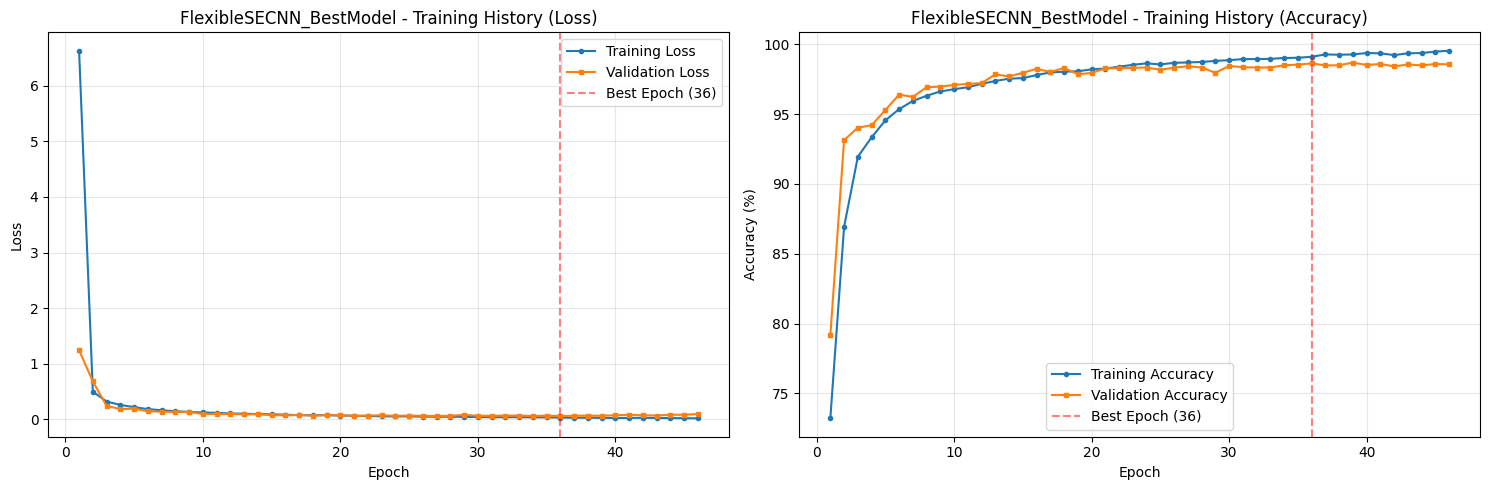


EVALUATING ON TEST SET



Testing: 100%|██████████| 11/11 [00:00<00:00, 31.91it/s]



Classification Report (FlexibleSECNN_BestModel):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     18118
           1       0.95      0.73      0.83       556
           2       0.98      0.93      0.96      1448
           3       0.81      0.76      0.79       162
           4       0.99      0.99      0.99      1608

    accuracy                           0.98     21892
   macro avg       0.95      0.88      0.91     21892
weighted avg       0.98      0.98      0.98     21892



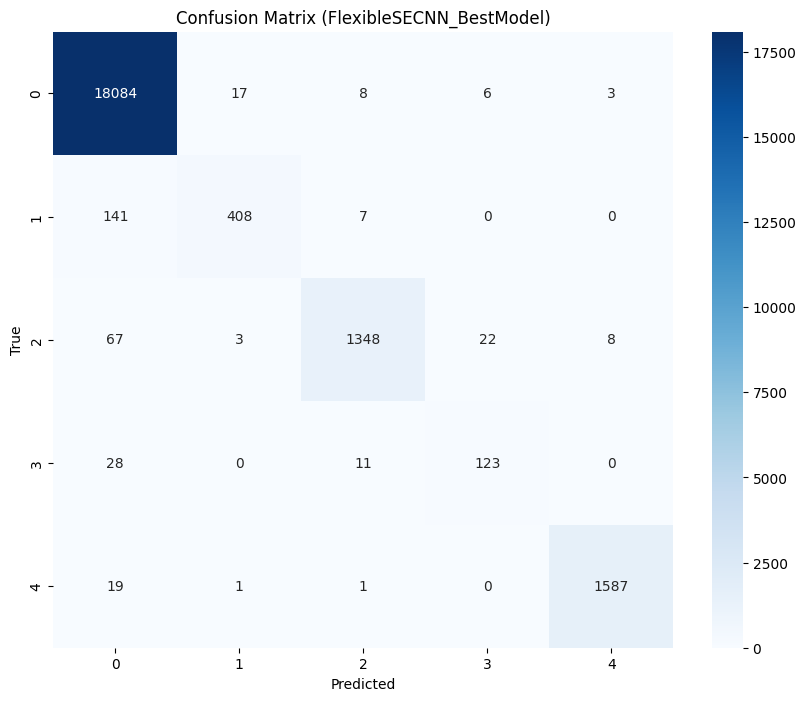


✓ Model and results saved to: models\FlexibleSECNN_BestModel_20251114_000104


In [89]:
# Update batch size
best_params['batch_size'] = 2048

# Train
final_results = train_final_model_se_with_loaders(
    best_params=best_params,
    train_loader=train_loader,  
    val_loader=val_loader,
    test_loader=test_loader,
    constant_filters=True,
    num_epochs=50
)

In [ ]:
print("\n" + "="*70)
print("FINAL RESULTS")
print("="*70)
print(f"Best validation accuracy (search): {study.best_value:.2f}%")
print(f"Final test accuracy: {final_results['test_accuracy']:.2f}%")
print(f"Model saved to: {final_results['save_dir']}")
print("="*70)

# Vanilla CNN with Augmented Data Set and Optuna hyperparameter tuning

In [ ]:
# Step 1: Create augmented data loaders 
train_loader, val_loader, test_loader = create_data_loaders(
    X_train, X_val, X_test, y_train, y_val, y_test, 
    batch_size=2048,
    augment_train=True,  # Augmentation enabled for training only
    num_workers=0  
)


DATA LOADERS CREATED

DataLoader Information:
  Training batches: 167 (batch_size=512, augment=True)
  Validation batches: 18 (batch_size=512)
  Test batches: 43 (batch_size=512)
  Workers: 0, Pin memory: True


In [94]:
# Step 2: Optuna search for vanilla CNN (FlexibleFinalCNN) with augmentation
def optuna_search_vanilla_cnn_with_aug(train_loader, val_loader, test_loader,
                                       n_trials=50, constant_filters=True, timeout=None):
    """
    Optuna search for vanilla CNN with pre-made augmented dataloaders
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Get data info
    sample_batch = next(iter(train_loader))
    sequence_length = sample_batch[0].shape[1]
    y_train = train_loader.dataset.y.numpy()
    num_classes = len(np.unique(y_train))
    
    print("="*70)
    print("OPTUNA SEARCH: Vanilla CNN with Augmentation")
    print("="*70)
    print(f"Trials: {n_trials}")
    print(f"Device: {device}")
    print(f"Training batches: {len(train_loader)} (with augmentation)")
    print(f"Validation batches: {len(val_loader)}")
    print(f"Sequence length: {sequence_length}, Classes: {num_classes}")
    print(f"Filter mode: {'CONSTANT' if constant_filters else 'SCALING'}")
    print("="*70 + "\n")
    
    def objective(trial):
        params = {
            'num_filters': trial.suggest_categorical('num_filters', [16, 32, 64, 128]),
            'kernel_size': trial.suggest_categorical('kernel_size', [3, 5, 7, 9]),
            'num_res_blocks': trial.suggest_int('num_res_blocks', 2, 5),
            'pool_size': trial.suggest_categorical('pool_size', [2, 3, 5]),
            'pool_stride': 2,
            'dropout_rate': trial.suggest_float('dropout_rate', 0.1, 0.5),
            'fc_neurons': trial.suggest_categorical('fc_neurons', [32, 64, 128, 256]),
            'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True),
            'batch_size': train_loader.batch_size,
            'weight_decay': trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True),
        }
        
        # Validate architecture
        valid, final_len, msg = validate_architecture(
            sequence_length, params['num_res_blocks'], 
            params['pool_size'], params['pool_stride']
        )
        
        if not valid:
            print(f"⊘ Trial {trial.number}: Invalid - {msg}")
            raise optuna.exceptions.TrialPruned()
        
        print(f"\n{'='*70}")
        print(f"Trial {trial.number}")
        print(f"{'='*70}")
        print(f"Filters: {params['num_filters']} × {params['num_res_blocks']} blocks")
        print(f"Kernel: {params['kernel_size']}, Pool: {params['pool_size']}/{params['pool_stride']}")
        print(f"Dropout: {params['dropout_rate']}, FC: {params['fc_neurons']}")
        print(f"LR: {params['learning_rate']:.2e}, Batch: {params['batch_size']}, WD: {params['weight_decay']:.2e}")
        print(f"{'='*70}")
        
        try:
            # Create vanilla CNN model
            model = FlexibleFinalCNN(
                input_channels=1,
                num_classes=num_classes,
                num_filters=params['num_filters'],
                kernel_size=params['kernel_size'],
                num_res_blocks=params['num_res_blocks'],
                pool_size=params['pool_size'],
                pool_stride=params['pool_stride'],
                fc_neurons=params['fc_neurons'],
                dropout_rate=params['dropout_rate'],
                sequence_length=sequence_length,
                constant_filters=constant_filters
            )
            
            model = model.to(device)
            
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.AdamW(
                model.parameters(),
                lr=params['learning_rate'],
                weight_decay=params['weight_decay']
            )
            
            # Training loop
            num_epochs = 50
            patience = 7
            best_val_acc = 0
            epochs_no_improve = 0
            
            for epoch in range(num_epochs):
                # Training
                model.train()
                for batch_X, batch_y in train_loader:
                    batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                    optimizer.zero_grad()
                    outputs = model(batch_X)
                    loss = criterion(outputs, batch_y)
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    optimizer.step()
                
                # Validation
                model.eval()
                correct = 0
                total = 0
                with torch.no_grad():
                    for batch_X, batch_y in val_loader:
                        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                        outputs = model(batch_X)
                        _, predicted = torch.max(outputs.data, 1)
                        total += batch_y.size(0)
                        correct += (predicted == batch_y).sum().item()
                
                val_acc = 100 * correct / total
                
                trial.report(val_acc, epoch)
                
                if trial.should_prune():
                    print(f"  ✂️ Pruned at epoch {epoch+1}")
                    raise optuna.exceptions.TrialPruned()
                
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
                
                if epochs_no_improve >= patience:
                    print(f"  Early stopping at epoch {epoch+1}")
                    break
                
                if (epoch + 1) % 5 == 0:
                    print(f"  Epoch {epoch+1}/{num_epochs}: Val Acc = {val_acc:.2f}%")
            
            print(f"  ✓ Final Val Acc: {best_val_acc:.2f}%")
            return best_val_acc
            
        except optuna.exceptions.TrialPruned:
            raise
        except Exception as e:
            print(f"  ✗ Error: {str(e)}")
            raise optuna.exceptions.TrialPruned()
    
    study = optuna.create_study(
        direction='maximize',
        pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=10),
        sampler=TPESampler(seed=42)
    )
    
    study.optimize(objective, n_trials=n_trials, timeout=timeout, show_progress_bar=True)
    
    # Print results
    print(f"\n{'='*70}")
    print(f"OPTUNA OPTIMIZATION COMPLETE")
    print(f"{'='*70}")
    print(f"Finished trials: {len(study.trials)}")
    print(f"Pruned: {len([t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED])}")
    print(f"Complete: {len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])}")
    print(f"\nBest trial: {study.best_trial.number}")
    print(f"Best validation accuracy: {study.best_value:.2f}%")
    print(f"\nBest hyperparameters:")
    print(f"{'='*70}")
    for key, value in study.best_trial.params.items():
        print(f"  {key:20s}: {value}")
    print(f"{'='*70}")
    
    results_sorted = sorted(
        [{'params': {**t.params, 'pool_stride': 2, 'batch_size': train_loader.batch_size},
          'val_accuracy': t.value, 'trial_number': t.number, 'state': t.state.name}
         for t in study.trials if t.value is not None],
        key=lambda x: x['val_accuracy'], reverse=True
    )
    
    best_params = {**study.best_trial.params, 'pool_stride': 2, 'batch_size': train_loader.batch_size}
    
    return study, best_params, results_sorted

In [95]:
# Step 3: Run Optuna search
study_vanilla, best_params_vanilla, results_vanilla = optuna_search_vanilla_cnn_with_aug(
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    n_trials=50,  # Adjust as needed
    constant_filters=True,
    timeout=None
)

[I 2025-11-14 01:59:45,438] A new study created in memory with name: no-name-18abf2c5-0951-4ebc-a5de-a92624dd8382


OPTUNA SEARCH: Vanilla CNN with Augmentation
Trials: 50
Device: cuda
Training batches: 39 (with augmentation)
Validation batches: 5
Sequence length: 187, Classes: 5
Filter mode: CONSTANT



  0%|          | 0/50 [00:00<?, ?it/s]


Trial 0
Filters: 32 × 4 blocks
Kernel: 9, Pool: 5/2
Dropout: 0.4329770563201687, FC: 256
LR: 1.12e-04, Batch: 2048, WD: 1.98e-05
  Epoch 5/50: Val Acc = 90.59%
  Epoch 10/50: Val Acc = 92.92%
  Epoch 15/50: Val Acc = 94.02%
  Epoch 20/50: Val Acc = 95.36%
  Epoch 25/50: Val Acc = 95.98%
  Epoch 30/50: Val Acc = 96.09%
  Epoch 35/50: Val Acc = 96.52%
  Epoch 40/50: Val Acc = 96.52%
  Epoch 45/50: Val Acc = 96.77%


Best trial: 0. Best value: 97.1677:   2%|▏         | 1/50 [03:27<2:49:24, 207.45s/it]

  Epoch 50/50: Val Acc = 96.95%
  ✓ Final Val Acc: 97.17%
[I 2025-11-14 02:03:12,885] Trial 0 finished with value: 97.16765646413887 and parameters: {'num_filters': 32, 'kernel_size': 9, 'num_res_blocks': 4, 'pool_size': 5, 'dropout_rate': 0.4329770563201687, 'fc_neurons': 256, 'learning_rate': 0.00011207606211860574, 'weight_decay': 1.9762189340280066e-05}. Best is trial 0 with value: 97.16765646413887.

Trial 1
Filters: 32 × 4 blocks
Kernel: 7, Pool: 5/2
Dropout: 0.16820964947491662, FC: 128
LR: 4.07e-05, Batch: 2048, WD: 1.96e-06
  Epoch 5/50: Val Acc = 91.72%
  Epoch 10/50: Val Acc = 93.55%
  Epoch 15/50: Val Acc = 93.89%
  Epoch 20/50: Val Acc = 93.66%


Best trial: 0. Best value: 97.1677:   4%|▍         | 2/50 [04:03<1:25:19, 106.66s/it]

  Early stopping at epoch 24
  ✓ Final Val Acc: 93.98%
[I 2025-11-14 02:03:48,991] Trial 1 finished with value: 93.98126998629512 and parameters: {'num_filters': 32, 'kernel_size': 7, 'num_res_blocks': 4, 'pool_size': 5, 'dropout_rate': 0.16820964947491662, 'fc_neurons': 128, 'learning_rate': 4.066563313514796e-05, 'weight_decay': 1.9634341572933354e-06}. Best is trial 0 with value: 97.16765646413887.

Trial 2
Filters: 16 × 3 blocks
Kernel: 5, Pool: 3/2
Dropout: 0.48783385110582345, FC: 64
LR: 6.98e-04, Batch: 2048, WD: 1.84e-06
  Epoch 5/50: Val Acc = 83.35%


Best trial: 0. Best value: 97.1677:   6%|▌         | 3/50 [04:11<48:22, 61.75s/it]   

  Early stopping at epoch 8
  ✓ Final Val Acc: 83.35%
[I 2025-11-14 02:03:57,297] Trial 2 finished with value: 83.34856098675195 and parameters: {'num_filters': 16, 'kernel_size': 5, 'num_res_blocks': 3, 'pool_size': 3, 'dropout_rate': 0.48783385110582345, 'fc_neurons': 64, 'learning_rate': 0.0006978281265126031, 'weight_decay': 1.8427970406864558e-06}. Best is trial 0 with value: 97.16765646413887.

Trial 3
Filters: 128 × 4 blocks
Kernel: 5, Pool: 3/2
Dropout: 0.4947547746402069, FC: 256
LR: 2.59e-04, Batch: 2048, WD: 1.54e-04
  Epoch 5/50: Val Acc = 89.41%
  Epoch 10/50: Val Acc = 89.40%
  Epoch 15/50: Val Acc = 89.52%
  Epoch 20/50: Val Acc = 89.81%
  Epoch 25/50: Val Acc = 89.70%
  Epoch 30/50: Val Acc = 89.88%
  Epoch 35/50: Val Acc = 89.80%


Best trial: 0. Best value: 97.1677:   8%|▊         | 4/50 [07:44<1:33:03, 121.38s/it]

  Early stopping at epoch 36
  ✓ Final Val Acc: 89.93%
[I 2025-11-14 02:07:30,082] Trial 3 finished with value: 89.92690726359068 and parameters: {'num_filters': 128, 'kernel_size': 5, 'num_res_blocks': 4, 'pool_size': 3, 'dropout_rate': 0.4947547746402069, 'fc_neurons': 256, 'learning_rate': 0.0002592475660475158, 'weight_decay': 0.00015382308040278996}. Best is trial 0 with value: 97.16765646413887.

Trial 4
Filters: 16 × 3 blocks
Kernel: 3, Pool: 3/2
Dropout: 0.4548850970305306, FC: 256
LR: 1.33e-04, Batch: 2048, WD: 2.06e-04
  Epoch 5/50: Val Acc = 87.01%
  Epoch 10/50: Val Acc = 83.35%


Best trial: 0. Best value: 97.1677:  10%|█         | 5/50 [07:56<1:01:20, 81.78s/it] 

  Early stopping at epoch 11
  ✓ Final Val Acc: 87.51%
[I 2025-11-14 02:07:41,661] Trial 4 finished with value: 87.50571037003198 and parameters: {'num_filters': 16, 'kernel_size': 3, 'num_res_blocks': 3, 'pool_size': 3, 'dropout_rate': 0.4548850970305306, 'fc_neurons': 256, 'learning_rate': 0.0001326033192269654, 'weight_decay': 0.00020554245520150764}. Best is trial 0 with value: 97.16765646413887.

Trial 5
Filters: 32 × 4 blocks
Kernel: 7, Pool: 2/2
Dropout: 0.4022204554172195, FC: 128
LR: 7.23e-04, Batch: 2048, WD: 2.66e-04
  Epoch 5/50: Val Acc = 93.76%
  Epoch 10/50: Val Acc = 94.86%
  Epoch 15/50: Val Acc = 95.52%
  Epoch 20/50: Val Acc = 97.14%
  Epoch 25/50: Val Acc = 97.66%
  Epoch 30/50: Val Acc = 97.83%
  Epoch 35/50: Val Acc = 97.99%
  Epoch 40/50: Val Acc = 98.02%
  Epoch 45/50: Val Acc = 98.10%


Best trial: 5. Best value: 98.3212:  12%|█▏        | 6/50 [09:13<58:53, 80.30s/it]  

  Epoch 50/50: Val Acc = 98.30%
  ✓ Final Val Acc: 98.32%
[I 2025-11-14 02:08:59,097] Trial 5 finished with value: 98.32115121059844 and parameters: {'num_filters': 32, 'kernel_size': 7, 'num_res_blocks': 4, 'pool_size': 2, 'dropout_rate': 0.4022204554172195, 'fc_neurons': 128, 'learning_rate': 0.0007234279845665417, 'weight_decay': 0.00026568139241144923}. Best is trial 5 with value: 98.32115121059844.

Trial 6
Filters: 32 × 3 blocks
Kernel: 9, Pool: 5/2
Dropout: 0.42720590636899725, FC: 32
LR: 2.78e-05, Batch: 2048, WD: 2.29e-06
  Epoch 5/50: Val Acc = 83.58%
  Epoch 10/50: Val Acc = 83.58%


Best trial: 5. Best value: 98.3212:  14%|█▍        | 7/50 [09:55<48:30, 67.67s/it]

  ✂️ Pruned at epoch 11
[I 2025-11-14 02:09:40,769] Trial 6 pruned. 

Trial 7
Filters: 32 × 3 blocks
Kernel: 7, Pool: 2/2
Dropout: 0.11475477894181313, FC: 32
LR: 6.55e-04, Batch: 2048, WD: 5.23e-06
  Epoch 5/50: Val Acc = 94.22%
  Epoch 10/50: Val Acc = 95.08%
  Epoch 15/50: Val Acc = 95.45%
  Epoch 20/50: Val Acc = 95.80%
  Epoch 25/50: Val Acc = 97.21%
  Epoch 30/50: Val Acc = 97.91%
  Epoch 35/50: Val Acc = 97.86%
  Epoch 40/50: Val Acc = 97.98%
  Epoch 45/50: Val Acc = 98.21%


Best trial: 5. Best value: 98.3212:  16%|█▌        | 8/50 [10:55<45:37, 65.19s/it]

  Epoch 50/50: Val Acc = 98.10%
  ✓ Final Val Acc: 98.21%
[I 2025-11-14 02:10:40,624] Trial 7 finished with value: 98.20694380995889 and parameters: {'num_filters': 32, 'kernel_size': 7, 'num_res_blocks': 3, 'pool_size': 2, 'dropout_rate': 0.11475477894181313, 'fc_neurons': 32, 'learning_rate': 0.0006554382343546282, 'weight_decay': 5.232216089948754e-06}. Best is trial 5 with value: 98.32115121059844.

Trial 8
Filters: 64 × 3 blocks
Kernel: 5, Pool: 3/2
Dropout: 0.13611590802176332, FC: 32
LR: 1.52e-04, Batch: 2048, WD: 1.08e-04
  Epoch 5/50: Val Acc = 89.97%
  Epoch 10/50: Val Acc = 92.57%


Best trial: 5. Best value: 98.3212:  18%|█▊        | 9/50 [11:24<36:54, 54.02s/it]

  ✂️ Pruned at epoch 12
[I 2025-11-14 02:11:10,098] Trial 8 pruned. 

Trial 9
Filters: 128 × 2 blocks
Kernel: 9, Pool: 5/2
Dropout: 0.45093574135239245, FC: 128
LR: 1.15e-04, Batch: 2048, WD: 5.32e-06
  Epoch 5/50: Val Acc = 83.35%


Best trial: 5. Best value: 98.3212:  20%|██        | 10/50 [12:14<35:10, 52.76s/it]

  Early stopping at epoch 9
  ✓ Final Val Acc: 83.35%
[I 2025-11-14 02:12:00,018] Trial 9 finished with value: 83.34856098675195 and parameters: {'num_filters': 128, 'kernel_size': 9, 'num_res_blocks': 2, 'pool_size': 5, 'dropout_rate': 0.45093574135239245, 'fc_neurons': 128, 'learning_rate': 0.00011463075602214007, 'weight_decay': 5.315656057158321e-06}. Best is trial 5 with value: 98.32115121059844.

Trial 10
Filters: 64 × 5 blocks
Kernel: 7, Pool: 2/2
Dropout: 0.32624523627256136, FC: 128
LR: 1.07e-05, Batch: 2048, WD: 8.32e-04
  Epoch 5/50: Val Acc = 87.91%
  Epoch 10/50: Val Acc = 90.52%


Best trial: 5. Best value: 98.3212:  22%|██▏       | 11/50 [12:47<30:22, 46.74s/it]

  ✂️ Pruned at epoch 11
[I 2025-11-14 02:12:33,126] Trial 10 pruned. 

Trial 11
Filters: 32 × 5 blocks
Kernel: 7, Pool: 2/2
Dropout: 0.2508583581217884, FC: 32
LR: 9.82e-04, Batch: 2048, WD: 1.52e-05
  Epoch 5/50: Val Acc = 87.65%
  Epoch 10/50: Val Acc = 95.37%
  Epoch 15/50: Val Acc = 96.17%
  Epoch 20/50: Val Acc = 96.59%
  Epoch 25/50: Val Acc = 97.51%
  Epoch 30/50: Val Acc = 98.10%
  Epoch 35/50: Val Acc = 98.09%
  Epoch 40/50: Val Acc = 98.18%
  Epoch 45/50: Val Acc = 98.26%


Best trial: 11. Best value: 98.3897:  24%|██▍       | 12/50 [14:10<36:38, 57.86s/it]

  Early stopping at epoch 48
  ✓ Final Val Acc: 98.39%
[I 2025-11-14 02:13:56,412] Trial 11 finished with value: 98.38967565098218 and parameters: {'num_filters': 32, 'kernel_size': 7, 'num_res_blocks': 5, 'pool_size': 2, 'dropout_rate': 0.2508583581217884, 'fc_neurons': 32, 'learning_rate': 0.0009818026638994167, 'weight_decay': 1.5225274680391343e-05}. Best is trial 11 with value: 98.38967565098218.

Trial 12
Filters: 32 × 5 blocks
Kernel: 7, Pool: 2/2
Dropout: 0.25725127010743576, FC: 64
LR: 9.87e-04, Batch: 2048, WD: 3.08e-05
  Epoch 5/50: Val Acc = 95.23%
  Epoch 10/50: Val Acc = 97.28%
  Epoch 15/50: Val Acc = 97.84%
  Epoch 20/50: Val Acc = 97.84%
  Epoch 25/50: Val Acc = 98.29%
  Epoch 30/50: Val Acc = 98.02%
  Epoch 35/50: Val Acc = 98.41%
  Epoch 40/50: Val Acc = 98.52%


Best trial: 12. Best value: 98.5267:  26%|██▌       | 13/50 [15:25<38:47, 62.91s/it]

  Early stopping at epoch 43
  ✓ Final Val Acc: 98.53%
[I 2025-11-14 02:15:10,929] Trial 12 finished with value: 98.52672453174965 and parameters: {'num_filters': 32, 'kernel_size': 7, 'num_res_blocks': 5, 'pool_size': 2, 'dropout_rate': 0.25725127010743576, 'fc_neurons': 64, 'learning_rate': 0.0009871777733751906, 'weight_decay': 3.07697477916399e-05}. Best is trial 12 with value: 98.52672453174965.

Trial 13
Filters: 32 × 5 blocks
Kernel: 7, Pool: 2/2
Dropout: 0.2302598296542423, FC: 64
LR: 3.52e-04, Batch: 2048, WD: 2.91e-05
  Epoch 5/50: Val Acc = 93.87%
  Epoch 10/50: Val Acc = 95.97%
  Epoch 15/50: Val Acc = 96.62%
  Epoch 20/50: Val Acc = 97.33%
  Epoch 25/50: Val Acc = 97.77%
  Epoch 30/50: Val Acc = 97.88%


Best trial: 12. Best value: 98.5267:  28%|██▊       | 14/50 [16:22<36:42, 61.19s/it]

  ✂️ Pruned at epoch 33
[I 2025-11-14 02:16:08,142] Trial 13 pruned. 

Trial 14
Filters: 32 × 5 blocks
Kernel: 3, Pool: 2/2
Dropout: 0.2608035384642904, FC: 64
LR: 9.78e-04, Batch: 2048, WD: 1.21e-05
  Epoch 5/50: Val Acc = 94.22%
  Epoch 10/50: Val Acc = 96.47%
  Epoch 15/50: Val Acc = 96.89%
  Epoch 20/50: Val Acc = 97.25%
  Epoch 25/50: Val Acc = 97.50%


Best trial: 12. Best value: 98.5267:  30%|███       | 15/50 [3:16:17<32:03:06, 3296.77s/it]

  ✂️ Pruned at epoch 28
[I 2025-11-14 05:16:03,399] Trial 14 pruned. 

Trial 15
Filters: 32 × 5 blocks
Kernel: 7, Pool: 2/2
Dropout: 0.3500589592142955, FC: 64
LR: 3.74e-04, Batch: 2048, WD: 4.91e-05
  Epoch 5/50: Val Acc = 92.39%
  Epoch 10/50: Val Acc = 94.46%


Best trial: 12. Best value: 98.5267:  32%|███▏      | 16/50 [3:16:38<21:49:21, 2310.64s/it]

  ✂️ Pruned at epoch 12
[I 2025-11-14 05:16:24,011] Trial 15 pruned. 

Trial 16
Filters: 64 × 5 blocks
Kernel: 7, Pool: 2/2
Dropout: 0.21440832258621928, FC: 32
LR: 5.44e-05, Batch: 2048, WD: 5.86e-05
  Epoch 5/50: Val Acc = 88.52%


Best trial: 12. Best value: 98.5267:  34%|███▍      | 17/50 [3:17:04<14:53:03, 1623.75s/it]

  Early stopping at epoch 9
  ✓ Final Val Acc: 90.68%
[I 2025-11-14 05:16:50,320] Trial 16 finished with value: 90.68067610781179 and parameters: {'num_filters': 64, 'kernel_size': 7, 'num_res_blocks': 5, 'pool_size': 2, 'dropout_rate': 0.21440832258621928, 'fc_neurons': 32, 'learning_rate': 5.436040365686622e-05, 'weight_decay': 5.864176684172391e-05}. Best is trial 12 with value: 98.52672453174965.

Trial 17
Filters: 16 × 2 blocks
Kernel: 7, Pool: 2/2
Dropout: 0.2635655938048445, FC: 64
LR: 2.71e-04, Batch: 2048, WD: 1.10e-05
  Epoch 5/50: Val Acc = 89.64%
  Epoch 10/50: Val Acc = 89.65%


Best trial: 12. Best value: 98.5267:  36%|███▌      | 18/50 [3:17:16<10:07:34, 1139.22s/it]

  ✂️ Pruned at epoch 11
[I 2025-11-14 05:17:01,602] Trial 17 pruned. 

Trial 18
Filters: 128 × 5 blocks
Kernel: 3, Pool: 2/2
Dropout: 0.18482261004972256, FC: 32
LR: 9.97e-04, Batch: 2048, WD: 5.32e-06
  Epoch 5/50: Val Acc = 83.35%
  Epoch 10/50: Val Acc = 96.65%
  Epoch 15/50: Val Acc = 97.13%
  Epoch 20/50: Val Acc = 97.41%
  Epoch 25/50: Val Acc = 97.58%


Best trial: 12. Best value: 98.5267:  38%|███▊      | 19/50 [3:19:23<7:11:30, 835.19s/it]  

  ✂️ Pruned at epoch 27
[I 2025-11-14 05:19:08,537] Trial 18 pruned. 

Trial 19
Filters: 32 × 4 blocks
Kernel: 7, Pool: 2/2
Dropout: 0.3070994347868332, FC: 64
LR: 4.97e-04, Batch: 2048, WD: 6.78e-05
  Epoch 5/50: Val Acc = 90.48%
  Epoch 10/50: Val Acc = 94.11%


Best trial: 12. Best value: 98.5267:  40%|████      | 20/50 [3:19:40<4:54:47, 589.59s/it]

  ✂️ Pruned at epoch 11
[I 2025-11-14 05:19:25,727] Trial 19 pruned. 

Trial 20
Filters: 32 × 5 blocks
Kernel: 7, Pool: 2/2
Dropout: 0.370443990178826, FC: 32
LR: 1.27e-05, Batch: 2048, WD: 2.01e-05
  Epoch 5/50: Val Acc = 83.27%
  Epoch 10/50: Val Acc = 84.67%


Best trial: 12. Best value: 98.5267:  42%|████▏     | 21/50 [3:19:59<3:22:11, 418.32s/it]

  ✂️ Pruned at epoch 11
[I 2025-11-14 05:19:44,717] Trial 20 pruned. 

Trial 21
Filters: 32 × 4 blocks
Kernel: 7, Pool: 2/2
Dropout: 0.27880911768763195, FC: 128
LR: 6.27e-04, Batch: 2048, WD: 3.98e-04
  Epoch 5/50: Val Acc = 94.51%
  Epoch 10/50: Val Acc = 96.11%
  Epoch 15/50: Val Acc = 96.90%
  Epoch 20/50: Val Acc = 97.38%
  Epoch 25/50: Val Acc = 97.74%
  Epoch 30/50: Val Acc = 97.92%


Best trial: 12. Best value: 98.5267:  44%|████▍     | 22/50 [3:20:50<2:23:45, 308.07s/it]

  ✂️ Pruned at epoch 33
[I 2025-11-14 05:20:35,693] Trial 21 pruned. 

Trial 22
Filters: 32 × 4 blocks
Kernel: 7, Pool: 2/2
Dropout: 0.3901544522006648, FC: 128
LR: 9.56e-04, Batch: 2048, WD: 3.77e-04
  Epoch 5/50: Val Acc = 94.15%
  Epoch 10/50: Val Acc = 96.72%
  Epoch 15/50: Val Acc = 97.17%
  Epoch 20/50: Val Acc = 97.37%
  Epoch 25/50: Val Acc = 97.85%
  Epoch 30/50: Val Acc = 98.32%
  Epoch 35/50: Val Acc = 98.25%
  Epoch 40/50: Val Acc = 98.34%
  Epoch 45/50: Val Acc = 98.29%


Best trial: 22. Best value: 98.5838:  46%|████▌     | 23/50 [3:22:07<1:47:28, 238.83s/it]

  Epoch 50/50: Val Acc = 98.58%
  ✓ Final Val Acc: 98.58%
[I 2025-11-14 05:21:53,018] Trial 22 finished with value: 98.58382823206944 and parameters: {'num_filters': 32, 'kernel_size': 7, 'num_res_blocks': 4, 'pool_size': 2, 'dropout_rate': 0.3901544522006648, 'fc_neurons': 128, 'learning_rate': 0.0009561057863456843, 'weight_decay': 0.0003772861918825243}. Best is trial 22 with value: 98.58382823206944.

Trial 23
Filters: 32 × 5 blocks
Kernel: 7, Pool: 2/2
Dropout: 0.23076377535286563, FC: 128
LR: 4.62e-04, Batch: 2048, WD: 9.30e-04
  Epoch 5/50: Val Acc = 95.90%
  Epoch 10/50: Val Acc = 96.84%
  Epoch 15/50: Val Acc = 97.58%
  Epoch 20/50: Val Acc = 97.81%
  Epoch 25/50: Val Acc = 98.05%
  Epoch 30/50: Val Acc = 97.99%
  Epoch 35/50: Val Acc = 98.12%
  Epoch 40/50: Val Acc = 98.26%


Best trial: 22. Best value: 98.5838:  48%|████▊     | 24/50 [3:23:23<1:22:22, 190.09s/it]

  Early stopping at epoch 44
  ✓ Final Val Acc: 98.31%
[I 2025-11-14 05:23:09,421] Trial 23 finished with value: 98.30973047053449 and parameters: {'num_filters': 32, 'kernel_size': 7, 'num_res_blocks': 5, 'pool_size': 2, 'dropout_rate': 0.23076377535286563, 'fc_neurons': 128, 'learning_rate': 0.0004618310797641843, 'weight_decay': 0.0009297876355960234}. Best is trial 22 with value: 98.58382823206944.

Trial 24
Filters: 32 × 4 blocks
Kernel: 7, Pool: 2/2
Dropout: 0.3261029122482466, FC: 64
LR: 2.21e-04, Batch: 2048, WD: 3.91e-05
  Epoch 5/50: Val Acc = 89.01%
  Epoch 10/50: Val Acc = 91.57%


Best trial: 22. Best value: 98.5838:  50%|█████     | 25/50 [3:23:40<57:33, 138.12s/it]  

  ✂️ Pruned at epoch 11
[I 2025-11-14 05:23:26,315] Trial 24 pruned. 

Trial 25
Filters: 32 × 5 blocks
Kernel: 7, Pool: 2/2
Dropout: 0.3928318346360201, FC: 32
LR: 9.61e-04, Batch: 2048, WD: 9.79e-05
  Epoch 5/50: Val Acc = 89.17%
  Epoch 10/50: Val Acc = 89.73%


Best trial: 22. Best value: 98.5838:  52%|█████▏    | 26/50 [3:24:00<40:58, 102.43s/it]

  ✂️ Pruned at epoch 11
[I 2025-11-14 05:23:45,480] Trial 25 pruned. 

Trial 26
Filters: 128 × 4 blocks
Kernel: 3, Pool: 2/2
Dropout: 0.29277615319378775, FC: 128
LR: 1.87e-04, Batch: 2048, WD: 1.11e-05
  Epoch 5/50: Val Acc = 90.01%
  Epoch 10/50: Val Acc = 93.52%


Best trial: 22. Best value: 98.5838:  54%|█████▍    | 27/50 [3:24:49<33:09, 86.52s/it] 

  ✂️ Pruned at epoch 11
[I 2025-11-14 05:24:34,862] Trial 26 pruned. 

Trial 27
Filters: 16 × 5 blocks
Kernel: 5, Pool: 2/2
Dropout: 0.1960571958355273, FC: 256
LR: 6.90e-05, Batch: 2048, WD: 4.50e-04
  Epoch 5/50: Val Acc = 90.73%
  Epoch 10/50: Val Acc = 92.76%


Best trial: 22. Best value: 98.5838:  56%|█████▌    | 28/50 [3:25:01<23:35, 64.33s/it]

  ✂️ Pruned at epoch 11
[I 2025-11-14 05:24:47,410] Trial 27 pruned. 

Trial 28
Filters: 64 × 5 blocks
Kernel: 9, Pool: 3/2
Dropout: 0.24845965372268553, FC: 64
LR: 4.75e-04, Batch: 2048, WD: 2.59e-05
  Epoch 5/50: Val Acc = 94.50%
  Epoch 10/50: Val Acc = 96.63%
  Epoch 15/50: Val Acc = 97.11%
  Epoch 20/50: Val Acc = 97.49%
  Epoch 25/50: Val Acc = 98.20%
  Epoch 30/50: Val Acc = 98.28%
  Epoch 35/50: Val Acc = 98.39%


Best trial: 22. Best value: 98.5838:  58%|█████▊    | 29/50 [3:27:03<28:33, 81.57s/it]

  Early stopping at epoch 38
  ✓ Final Val Acc: 98.52%
[I 2025-11-14 05:26:49,230] Trial 28 finished with value: 98.5153037916857 and parameters: {'num_filters': 64, 'kernel_size': 9, 'num_res_blocks': 5, 'pool_size': 3, 'dropout_rate': 0.24845965372268553, 'fc_neurons': 64, 'learning_rate': 0.0004746914606218445, 'weight_decay': 2.588149454674749e-05}. Best is trial 22 with value: 98.58382823206944.

Trial 29
Filters: 64 × 4 blocks
Kernel: 9, Pool: 3/2
Dropout: 0.34334874905685125, FC: 64
LR: 4.56e-04, Batch: 2048, WD: 2.41e-05
  Epoch 5/50: Val Acc = 89.26%
  Epoch 10/50: Val Acc = 93.25%


Best trial: 22. Best value: 98.5838:  60%|██████    | 30/50 [3:27:37<22:22, 67.15s/it]

  ✂️ Pruned at epoch 11
[I 2025-11-14 05:27:22,721] Trial 29 pruned. 

Trial 30
Filters: 64 × 4 blocks
Kernel: 9, Pool: 3/2
Dropout: 0.29701145224401426, FC: 64
LR: 3.50e-04, Batch: 2048, WD: 1.02e-04
  Epoch 5/50: Val Acc = 92.21%
  Epoch 10/50: Val Acc = 94.75%


Best trial: 22. Best value: 98.5838:  62%|██████▏   | 31/50 [3:28:10<18:04, 57.06s/it]

  ✂️ Pruned at epoch 11
[I 2025-11-14 05:27:56,246] Trial 30 pruned. 

Trial 31
Filters: 64 × 5 blocks
Kernel: 9, Pool: 3/2
Dropout: 0.2535550896797046, FC: 64
LR: 7.53e-04, Batch: 2048, WD: 1.41e-05
  Epoch 5/50: Val Acc = 95.95%
  Epoch 10/50: Val Acc = 97.84%
  Epoch 15/50: Val Acc = 98.14%
  Epoch 20/50: Val Acc = 97.74%
  Epoch 25/50: Val Acc = 98.38%
  Epoch 30/50: Val Acc = 98.40%
  Epoch 35/50: Val Acc = 98.45%
  Epoch 40/50: Val Acc = 98.37%


Best trial: 31. Best value: 98.6295:  64%|██████▍   | 32/50 [3:30:28<24:24, 81.35s/it]

  Early stopping at epoch 43
  ✓ Final Val Acc: 98.63%
[I 2025-11-14 05:30:14,254] Trial 31 finished with value: 98.62951119232527 and parameters: {'num_filters': 64, 'kernel_size': 9, 'num_res_blocks': 5, 'pool_size': 3, 'dropout_rate': 0.2535550896797046, 'fc_neurons': 64, 'learning_rate': 0.0007528053420582145, 'weight_decay': 1.4081155414625755e-05}. Best is trial 31 with value: 98.62951119232527.

Trial 32
Filters: 64 × 5 blocks
Kernel: 9, Pool: 3/2
Dropout: 0.158206046329801, FC: 64
LR: 5.80e-04, Batch: 2048, WD: 8.33e-06
  Epoch 5/50: Val Acc = 95.27%
  Epoch 10/50: Val Acc = 97.48%
  Epoch 15/50: Val Acc = 97.96%
  Epoch 20/50: Val Acc = 98.38%
  Epoch 25/50: Val Acc = 98.50%
  Epoch 30/50: Val Acc = 98.36%
  Epoch 35/50: Val Acc = 98.50%


Best trial: 32. Best value: 98.6752:  66%|██████▌   | 33/50 [3:32:37<27:02, 95.43s/it]

  Early stopping at epoch 40
  ✓ Final Val Acc: 98.68%
[I 2025-11-14 05:32:22,556] Trial 32 finished with value: 98.67519415258108 and parameters: {'num_filters': 64, 'kernel_size': 9, 'num_res_blocks': 5, 'pool_size': 3, 'dropout_rate': 0.158206046329801, 'fc_neurons': 64, 'learning_rate': 0.0005799385817733837, 'weight_decay': 8.334606961165952e-06}. Best is trial 32 with value: 98.67519415258108.

Trial 33
Filters: 64 × 5 blocks
Kernel: 9, Pool: 3/2
Dropout: 0.13833236369284393, FC: 64
LR: 6.88e-04, Batch: 2048, WD: 7.45e-06
  Epoch 5/50: Val Acc = 96.45%
  Epoch 10/50: Val Acc = 97.54%
  Epoch 15/50: Val Acc = 98.02%
  Epoch 20/50: Val Acc = 98.47%
  Epoch 25/50: Val Acc = 98.48%


Best trial: 32. Best value: 98.6752:  68%|██████▊   | 34/50 [3:34:06<25:00, 93.76s/it]

  Early stopping at epoch 28
  ✓ Final Val Acc: 98.56%
[I 2025-11-14 05:33:52,415] Trial 33 finished with value: 98.56098675194153 and parameters: {'num_filters': 64, 'kernel_size': 9, 'num_res_blocks': 5, 'pool_size': 3, 'dropout_rate': 0.13833236369284393, 'fc_neurons': 64, 'learning_rate': 0.0006876933595437233, 'weight_decay': 7.449887840265016e-06}. Best is trial 32 with value: 98.67519415258108.

Trial 34
Filters: 64 × 4 blocks
Kernel: 9, Pool: 3/2
Dropout: 0.1540638457206577, FC: 64
LR: 6.85e-04, Batch: 2048, WD: 2.99e-06
  Epoch 5/50: Val Acc = 95.80%
  Epoch 10/50: Val Acc = 97.30%
  Epoch 15/50: Val Acc = 97.78%
  Epoch 20/50: Val Acc = 98.12%
  Epoch 25/50: Val Acc = 98.47%
  Epoch 30/50: Val Acc = 98.57%
  Epoch 35/50: Val Acc = 98.49%
  Epoch 40/50: Val Acc = 98.60%


Best trial: 32. Best value: 98.6752:  70%|███████   | 35/50 [3:36:18<26:15, 105.01s/it]

  Early stopping at epoch 43
  ✓ Final Val Acc: 98.65%
[I 2025-11-14 05:36:03,665] Trial 34 finished with value: 98.65235267245318 and parameters: {'num_filters': 64, 'kernel_size': 9, 'num_res_blocks': 4, 'pool_size': 3, 'dropout_rate': 0.1540638457206577, 'fc_neurons': 64, 'learning_rate': 0.0006848962908494997, 'weight_decay': 2.9897503532450762e-06}. Best is trial 32 with value: 98.67519415258108.

Trial 35
Filters: 64 × 4 blocks
Kernel: 9, Pool: 3/2
Dropout: 0.15951961173364637, FC: 256
LR: 6.08e-04, Batch: 2048, WD: 2.72e-06
  Epoch 5/50: Val Acc = 96.96%
  Epoch 10/50: Val Acc = 97.84%
  Epoch 15/50: Val Acc = 98.13%
  Epoch 20/50: Val Acc = 98.24%
  Epoch 25/50: Val Acc = 98.49%
  Epoch 30/50: Val Acc = 98.41%
  Epoch 35/50: Val Acc = 98.45%
  Epoch 40/50: Val Acc = 98.49%
  Epoch 45/50: Val Acc = 98.70%


Best trial: 35. Best value: 98.698:  72%|███████▏  | 36/50 [3:38:51<27:53, 119.56s/it] 

  Epoch 50/50: Val Acc = 98.56%
  ✓ Final Val Acc: 98.70%
[I 2025-11-14 05:38:37,186] Trial 35 finished with value: 98.698035632709 and parameters: {'num_filters': 64, 'kernel_size': 9, 'num_res_blocks': 4, 'pool_size': 3, 'dropout_rate': 0.15951961173364637, 'fc_neurons': 256, 'learning_rate': 0.0006083983780779297, 'weight_decay': 2.7216702331274705e-06}. Best is trial 35 with value: 98.698035632709.

Trial 36
Filters: 64 × 3 blocks
Kernel: 9, Pool: 3/2
Dropout: 0.15955047903375055, FC: 256
LR: 2.89e-04, Batch: 2048, WD: 1.08e-06
  Epoch 5/50: Val Acc = 95.48%
  Epoch 10/50: Val Acc = 96.35%
  Epoch 15/50: Val Acc = 96.88%
  Epoch 20/50: Val Acc = 97.77%


Best trial: 35. Best value: 98.698:  74%|███████▍  | 37/50 [3:39:52<22:04, 101.91s/it]

  ✂️ Pruned at epoch 21
[I 2025-11-14 05:39:37,909] Trial 36 pruned. 

Trial 37
Filters: 64 × 4 blocks
Kernel: 9, Pool: 3/2
Dropout: 0.15877849141977654, FC: 256
LR: 5.65e-04, Batch: 2048, WD: 2.76e-06
  Epoch 5/50: Val Acc = 96.30%
  Epoch 10/50: Val Acc = 97.84%
  Epoch 15/50: Val Acc = 97.91%
  Epoch 20/50: Val Acc = 98.07%
  Epoch 25/50: Val Acc = 98.44%
  Epoch 30/50: Val Acc = 98.40%
  Epoch 35/50: Val Acc = 98.48%
  Epoch 40/50: Val Acc = 98.56%
  Epoch 45/50: Val Acc = 98.46%


Best trial: 35. Best value: 98.698:  76%|███████▌  | 38/50 [3:42:19<23:07, 115.58s/it]

  Early stopping at epoch 48
  ✓ Final Val Acc: 98.57%
[I 2025-11-14 05:42:05,398] Trial 37 finished with value: 98.57240749200548 and parameters: {'num_filters': 64, 'kernel_size': 9, 'num_res_blocks': 4, 'pool_size': 3, 'dropout_rate': 0.15877849141977654, 'fc_neurons': 256, 'learning_rate': 0.0005650764684774077, 'weight_decay': 2.7635088187075308e-06}. Best is trial 35 with value: 98.698035632709.

Trial 38
Filters: 64 × 4 blocks
Kernel: 9, Pool: 3/2
Dropout: 0.10667475732007903, FC: 256
LR: 7.83e-04, Batch: 2048, WD: 3.18e-06
  Epoch 5/50: Val Acc = 96.93%
  Epoch 10/50: Val Acc = 98.12%
  Epoch 15/50: Val Acc = 98.13%
  Epoch 20/50: Val Acc = 98.47%
  Epoch 25/50: Val Acc = 98.30%


Best trial: 35. Best value: 98.698:  78%|███████▊  | 39/50 [3:43:45<19:33, 106.68s/it]

  Early stopping at epoch 28
  ✓ Final Val Acc: 98.60%
[I 2025-11-14 05:43:31,313] Trial 38 finished with value: 98.59524897213339 and parameters: {'num_filters': 64, 'kernel_size': 9, 'num_res_blocks': 4, 'pool_size': 3, 'dropout_rate': 0.10667475732007903, 'fc_neurons': 256, 'learning_rate': 0.0007825125296052454, 'weight_decay': 3.1828118615121123e-06}. Best is trial 35 with value: 98.698035632709.

Trial 39
Filters: 64 × 3 blocks
Kernel: 9, Pool: 3/2
Dropout: 0.18438700426072696, FC: 256
LR: 1.76e-04, Batch: 2048, WD: 1.48e-06
  Epoch 5/50: Val Acc = 95.03%
  Epoch 10/50: Val Acc = 96.00%


Best trial: 35. Best value: 98.698:  80%|████████  | 40/50 [3:44:17<14:02, 84.22s/it] 

  ✂️ Pruned at epoch 11
[I 2025-11-14 05:44:03,115] Trial 39 pruned. 

Trial 40
Filters: 64 × 4 blocks
Kernel: 9, Pool: 3/2
Dropout: 0.13748852827558003, FC: 64
LR: 1.79e-05, Batch: 2048, WD: 3.73e-06
  Epoch 5/50: Val Acc = 92.84%
  Epoch 10/50: Val Acc = 94.13%


Best trial: 35. Best value: 98.698:  82%|████████▏ | 41/50 [3:44:51<10:21, 69.06s/it]

  ✂️ Pruned at epoch 11
[I 2025-11-14 05:44:36,816] Trial 40 pruned. 

Trial 41
Filters: 64 × 4 blocks
Kernel: 9, Pool: 3/2
Dropout: 0.11374540996815381, FC: 256
LR: 6.38e-04, Batch: 2048, WD: 3.09e-06
  Epoch 5/50: Val Acc = 97.17%
  Epoch 10/50: Val Acc = 98.01%
  Epoch 15/50: Val Acc = 98.21%
  Epoch 20/50: Val Acc = 98.37%
  Epoch 25/50: Val Acc = 98.48%
  Epoch 30/50: Val Acc = 98.60%


Best trial: 35. Best value: 98.698:  84%|████████▍ | 42/50 [3:46:32<10:29, 78.72s/it]

  Early stopping at epoch 33
  ✓ Final Val Acc: 98.63%
[I 2025-11-14 05:46:18,064] Trial 41 finished with value: 98.62951119232527 and parameters: {'num_filters': 64, 'kernel_size': 9, 'num_res_blocks': 4, 'pool_size': 3, 'dropout_rate': 0.11374540996815381, 'fc_neurons': 256, 'learning_rate': 0.0006381287201930616, 'weight_decay': 3.0890893431486917e-06}. Best is trial 35 with value: 98.698035632709.

Trial 42
Filters: 64 × 4 blocks
Kernel: 9, Pool: 3/2
Dropout: 0.10025506193464205, FC: 256
LR: 7.39e-04, Batch: 2048, WD: 6.93e-06
  Epoch 5/50: Val Acc = 97.41%
  Epoch 10/50: Val Acc = 98.08%
  Epoch 15/50: Val Acc = 98.20%
  Epoch 20/50: Val Acc = 98.29%
  Epoch 25/50: Val Acc = 98.49%
  Epoch 30/50: Val Acc = 98.52%
  Epoch 35/50: Val Acc = 98.66%
  Epoch 40/50: Val Acc = 98.72%
  Epoch 45/50: Val Acc = 98.62%


Best trial: 42. Best value: 98.7209:  86%|████████▌ | 43/50 [3:48:56<11:28, 98.37s/it]

  Early stopping at epoch 47
  ✓ Final Val Acc: 98.72%
[I 2025-11-14 05:48:42,294] Trial 42 finished with value: 98.72087711283692 and parameters: {'num_filters': 64, 'kernel_size': 9, 'num_res_blocks': 4, 'pool_size': 3, 'dropout_rate': 0.10025506193464205, 'fc_neurons': 256, 'learning_rate': 0.0007386311822067629, 'weight_decay': 6.933457118329591e-06}. Best is trial 42 with value: 98.72087711283692.

Trial 43
Filters: 64 × 3 blocks
Kernel: 9, Pool: 5/2
Dropout: 0.12800893214559403, FC: 256
LR: 7.45e-04, Batch: 2048, WD: 7.42e-06
  Epoch 5/50: Val Acc = 96.65%
  Epoch 10/50: Val Acc = 97.59%
  Epoch 15/50: Val Acc = 98.02%
  Epoch 20/50: Val Acc = 98.13%
  Epoch 25/50: Val Acc = 98.12%
  Epoch 30/50: Val Acc = 98.33%
  Epoch 35/50: Val Acc = 98.25%
  Epoch 40/50: Val Acc = 98.39%


Best trial: 42. Best value: 98.7209:  88%|████████▊ | 44/50 [3:50:54<10:25, 104.25s/it]

  Early stopping at epoch 41
  ✓ Final Val Acc: 98.57%
[I 2025-11-14 05:50:40,263] Trial 43 finished with value: 98.57240749200548 and parameters: {'num_filters': 64, 'kernel_size': 9, 'num_res_blocks': 3, 'pool_size': 5, 'dropout_rate': 0.12800893214559403, 'fc_neurons': 256, 'learning_rate': 0.0007446847906989078, 'weight_decay': 7.41676073460109e-06}. Best is trial 42 with value: 98.72087711283692.

Trial 44
Filters: 64 × 4 blocks
Kernel: 9, Pool: 3/2
Dropout: 0.10058000471710146, FC: 256
LR: 4.13e-04, Batch: 2048, WD: 1.91e-06
  Epoch 5/50: Val Acc = 96.90%
  Epoch 10/50: Val Acc = 97.77%
  Epoch 15/50: Val Acc = 98.15%
  Epoch 20/50: Val Acc = 98.34%
  Epoch 25/50: Val Acc = 98.30%
  Epoch 30/50: Val Acc = 98.39%
  Epoch 35/50: Val Acc = 98.50%
  Epoch 40/50: Val Acc = 98.57%
  Epoch 45/50: Val Acc = 98.40%


Best trial: 42. Best value: 98.7209:  90%|█████████ | 45/50 [3:53:22<09:45, 117.13s/it]

  Early stopping at epoch 48
  ✓ Final Val Acc: 98.60%
[I 2025-11-14 05:53:07,448] Trial 44 finished with value: 98.59524897213339 and parameters: {'num_filters': 64, 'kernel_size': 9, 'num_res_blocks': 4, 'pool_size': 3, 'dropout_rate': 0.10058000471710146, 'fc_neurons': 256, 'learning_rate': 0.00041338989897954414, 'weight_decay': 1.906773882113131e-06}. Best is trial 42 with value: 98.72087711283692.

Trial 45
Filters: 64 × 4 blocks
Kernel: 9, Pool: 3/2
Dropout: 0.16914161955532353, FC: 256
LR: 5.49e-04, Batch: 2048, WD: 6.95e-06
  Epoch 5/50: Val Acc = 96.43%
  Epoch 10/50: Val Acc = 97.72%
  Epoch 15/50: Val Acc = 97.90%
  Epoch 20/50: Val Acc = 98.40%
  Epoch 25/50: Val Acc = 98.45%
  Epoch 30/50: Val Acc = 98.48%
  Epoch 35/50: Val Acc = 98.39%


Best trial: 42. Best value: 98.7209:  92%|█████████▏| 46/50 [3:55:21<07:51, 117.90s/it]

  Early stopping at epoch 39
  ✓ Final Val Acc: 98.68%
[I 2025-11-14 05:55:07,133] Trial 45 finished with value: 98.67519415258108 and parameters: {'num_filters': 64, 'kernel_size': 9, 'num_res_blocks': 4, 'pool_size': 3, 'dropout_rate': 0.16914161955532353, 'fc_neurons': 256, 'learning_rate': 0.000549306043821479, 'weight_decay': 6.951701374732591e-06}. Best is trial 42 with value: 98.72087711283692.

Trial 46
Filters: 64 × 3 blocks
Kernel: 5, Pool: 3/2
Dropout: 0.15390423602999553, FC: 256
LR: 3.18e-04, Batch: 2048, WD: 7.41e-06
  Epoch 5/50: Val Acc = 95.16%
  Epoch 10/50: Val Acc = 96.63%


Best trial: 42. Best value: 98.7209:  94%|█████████▍| 47/50 [3:55:48<04:32, 90.72s/it] 

  ✂️ Pruned at epoch 11
[I 2025-11-14 05:55:34,429] Trial 46 pruned. 

Trial 47
Filters: 64 × 4 blocks
Kernel: 9, Pool: 5/2
Dropout: 0.17669317984865143, FC: 256
LR: 5.54e-04, Batch: 2048, WD: 4.03e-06
  Epoch 5/50: Val Acc = 96.41%
  Epoch 10/50: Val Acc = 97.56%
  Epoch 15/50: Val Acc = 98.14%
  Epoch 20/50: Val Acc = 98.01%
  Epoch 25/50: Val Acc = 98.21%
  Epoch 30/50: Val Acc = 98.36%
  Epoch 35/50: Val Acc = 98.66%
  Epoch 40/50: Val Acc = 98.61%


Best trial: 42. Best value: 98.7209:  96%|█████████▌| 48/50 [3:57:57<03:24, 102.13s/it]

  Early stopping at epoch 42
  ✓ Final Val Acc: 98.66%
[I 2025-11-14 05:57:43,201] Trial 47 finished with value: 98.66377341251713 and parameters: {'num_filters': 64, 'kernel_size': 9, 'num_res_blocks': 4, 'pool_size': 5, 'dropout_rate': 0.17669317984865143, 'fc_neurons': 256, 'learning_rate': 0.0005535727164647537, 'weight_decay': 4.028333896787569e-06}. Best is trial 42 with value: 98.72087711283692.

Trial 48
Filters: 16 × 4 blocks
Kernel: 9, Pool: 5/2
Dropout: 0.1754516935781377, FC: 256
LR: 5.66e-04, Batch: 2048, WD: 4.48e-06
  Epoch 5/50: Val Acc = 95.39%
  Epoch 10/50: Val Acc = 97.01%


Best trial: 42. Best value: 98.7209:  98%|█████████▊| 49/50 [3:58:58<01:29, 89.79s/it] 

  ✂️ Pruned at epoch 11
[I 2025-11-14 05:58:44,186] Trial 48 pruned. 

Trial 49
Filters: 64 × 4 blocks
Kernel: 9, Pool: 5/2
Dropout: 0.1978484395473949, FC: 256
LR: 2.36e-04, Batch: 2048, WD: 1.36e-06
  Epoch 5/50: Val Acc = 95.08%
  Epoch 10/50: Val Acc = 96.95%


Best trial: 42. Best value: 98.7209: 100%|██████████| 50/50 [3:59:31<00:00, 287.43s/it]

  ✂️ Pruned at epoch 11
[I 2025-11-14 05:59:17,091] Trial 49 pruned. 

OPTUNA OPTIMIZATION COMPLETE
Finished trials: 50
Pruned: 23
Complete: 27

Best trial: 42
Best validation accuracy: 98.72%

Best hyperparameters:
  num_filters         : 64
  kernel_size         : 9
  num_res_blocks      : 4
  pool_size           : 3
  dropout_rate        : 0.10025506193464205
  fc_neurons          : 256
  learning_rate       : 0.0007386311822067629
  weight_decay        : 6.933457118329591e-06


In [96]:
# Step 4: Train final model with best params
def train_final_vanilla_cnn_with_loaders(best_params, train_loader, val_loader, test_loader,
                                         constant_filters=True, num_epochs=50, 
                                         warmup_epochs=5, early_stopping_patience=10):
    """Train final vanilla CNN with pre-made dataloaders"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    sample_batch = next(iter(train_loader))
    sequence_length = sample_batch[0].shape[1]
    num_classes = len(torch.unique(train_loader.dataset.y))
    
    print("\n" + "="*70)
    print("TRAINING FINAL VANILLA CNN MODEL")
    print("="*70)
    print(f"\nBest Hyperparameters:")
    for key, value in best_params.items():
        print(f"  {key:20s}: {value}")
    print("="*70 + "\n")
    
    if 'pool_stride' not in best_params:
        best_params['pool_stride'] = 2
    
    # Create vanilla CNN
    best_model = FlexibleFinalCNN(
        input_channels=1,
        num_classes=num_classes,
        num_filters=best_params['num_filters'],
        kernel_size=best_params['kernel_size'],
        num_res_blocks=best_params['num_res_blocks'],
        pool_size=best_params['pool_size'],
        pool_stride=best_params['pool_stride'],
        fc_neurons=best_params['fc_neurons'],
        dropout_rate=best_params['dropout_rate'],
        sequence_length=sequence_length,
        constant_filters=constant_filters
    )
    
    config = {
        'initial_lr': best_params['learning_rate'],
        'max_lr': best_params['learning_rate'] * 2,
        'warmup_epochs': warmup_epochs,
        'num_epochs': num_epochs,
        'weight_decay': best_params['weight_decay']
    }
    
    criterion = nn.CrossEntropyLoss()
    
    trainer = ModelTrainer(
        model=best_model,
        model_name='FlexibleFinalCNN_Augmented_BestModel',
        device=device,
        criterion=criterion,
        config=config,
        early_stopping_patience=early_stopping_patience
    )
    
    print("Starting training...")
    trainer.train(train_loader, val_loader, num_epochs=config['num_epochs'])
    
    print("\nGenerating plots...")
    trainer.plot_training_history()
    
    print("\n" + "="*70)
    print("EVALUATING ON TEST SET")
    print("="*70 + "\n")
    test_results = trainer.evaluate(test_loader)
    
    print(f"\n✓ Saved to: {trainer.save_dir}")
    
    return {
        'model': best_model,
        'trainer': trainer,
        'test_accuracy': test_results['accuracy'],
        'test_results': test_results,
        'best_params': best_params,
        'save_dir': trainer.save_dir
    }


TRAINING FINAL VANILLA CNN MODEL

Best Hyperparameters:
  num_filters         : 64
  kernel_size         : 9
  num_res_blocks      : 4
  pool_size           : 3
  dropout_rate        : 0.10025506193464205
  fc_neurons          : 256
  learning_rate       : 0.0007386311822067629
  weight_decay        : 6.933457118329591e-06
  pool_stride         : 2
  batch_size          : 2048

Starting training...

Starting training for FlexibleFinalCNN_Augmented_BestModel...
Early stopping enabled with patience=10


Training: 100%|██████████| 39/39 [00:03<00:00, 11.21it/s]



Epoch [1/50]
Train Loss: 5.2918, Train Acc: 85.00%
Val Loss: 6.7466, Val Acc: 7.54%
Learning Rate: 0.000886
✓ New best model saved! (Val Loss: 6.7466)
Validation loss improved to 6.7466


Training: 100%|██████████| 39/39 [00:03<00:00, 11.29it/s]



Epoch [2/50]
Train Loss: 0.3688, Train Acc: 92.01%
Val Loss: 0.1775, Val Acc: 94.67%
Learning Rate: 0.001034
✓ New best model saved! (Val Loss: 0.1775)
Validation loss improved to 0.1775


Training: 100%|██████████| 39/39 [00:03<00:00, 10.65it/s]



Epoch [3/50]
Train Loss: 0.2225, Train Acc: 94.54%
Val Loss: 0.1579, Val Acc: 95.57%
Learning Rate: 0.001182
✓ New best model saved! (Val Loss: 0.1579)
Validation loss improved to 0.1579


Training: 100%|██████████| 39/39 [00:03<00:00, 11.26it/s]



Epoch [4/50]
Train Loss: 0.1893, Train Acc: 95.32%
Val Loss: 0.1115, Val Acc: 97.09%
Learning Rate: 0.001330
✓ New best model saved! (Val Loss: 0.1115)
Validation loss improved to 0.1115


Training: 100%|██████████| 39/39 [00:03<00:00, 10.75it/s]



Epoch [5/50]
Train Loss: 0.1534, Train Acc: 96.13%
Val Loss: 0.1005, Val Acc: 97.19%
Learning Rate: 0.001477
✓ New best model saved! (Val Loss: 0.1005)
Validation loss improved to 0.1005


Training: 100%|██████████| 39/39 [00:03<00:00, 11.22it/s]



Epoch [6/50]
Train Loss: 0.1385, Train Acc: 96.49%
Val Loss: 0.1020, Val Acc: 97.13%
Learning Rate: 0.001476
EarlyStopping counter: 1 out of 10


Training: 100%|██████████| 39/39 [00:03<00:00, 11.25it/s]



Epoch [7/50]
Train Loss: 0.1230, Train Acc: 96.79%
Val Loss: 0.0788, Val Acc: 97.86%
Learning Rate: 0.001474
✓ New best model saved! (Val Loss: 0.0788)
Validation loss improved to 0.0788


Training: 100%|██████████| 39/39 [00:03<00:00, 10.67it/s]



Epoch [8/50]
Train Loss: 0.1048, Train Acc: 97.22%
Val Loss: 0.0724, Val Acc: 97.91%
Learning Rate: 0.001469
✓ New best model saved! (Val Loss: 0.0724)
Validation loss improved to 0.0724


Training: 100%|██████████| 39/39 [00:03<00:00, 11.21it/s]



Epoch [9/50]
Train Loss: 0.0990, Train Acc: 97.41%
Val Loss: 0.0752, Val Acc: 98.02%
Learning Rate: 0.001463
EarlyStopping counter: 1 out of 10


Training: 100%|██████████| 39/39 [00:03<00:00, 11.26it/s]



Epoch [10/50]
Train Loss: 0.0918, Train Acc: 97.56%
Val Loss: 0.0706, Val Acc: 98.08%
Learning Rate: 0.001455
✓ New best model saved! (Val Loss: 0.0706)
Validation loss improved to 0.0706


Training: 100%|██████████| 39/39 [00:03<00:00, 10.70it/s]



Epoch [11/50]
Train Loss: 0.0871, Train Acc: 97.60%
Val Loss: 0.0718, Val Acc: 98.16%
Learning Rate: 0.001445
EarlyStopping counter: 1 out of 10


Training: 100%|██████████| 39/39 [00:03<00:00, 11.18it/s]



Epoch [12/50]
Train Loss: 0.0799, Train Acc: 97.82%
Val Loss: 0.0654, Val Acc: 98.20%
Learning Rate: 0.001434
✓ New best model saved! (Val Loss: 0.0654)
Validation loss improved to 0.0654


Training: 100%|██████████| 39/39 [00:03<00:00, 10.64it/s]



Epoch [13/50]
Train Loss: 0.0713, Train Acc: 98.03%
Val Loss: 0.0589, Val Acc: 98.37%
Learning Rate: 0.001421
✓ New best model saved! (Val Loss: 0.0589)
Validation loss improved to 0.0589


Training: 100%|██████████| 39/39 [00:03<00:00, 11.20it/s]



Epoch [14/50]
Train Loss: 0.0713, Train Acc: 97.99%
Val Loss: 0.0559, Val Acc: 98.36%
Learning Rate: 0.001407
✓ New best model saved! (Val Loss: 0.0559)
Validation loss improved to 0.0559


Training: 100%|██████████| 39/39 [00:03<00:00, 11.19it/s]



Epoch [15/50]
Train Loss: 0.0672, Train Acc: 98.16%
Val Loss: 0.0664, Val Acc: 98.31%
Learning Rate: 0.001391
EarlyStopping counter: 1 out of 10


Training: 100%|██████████| 39/39 [00:03<00:00, 10.64it/s]



Epoch [16/50]
Train Loss: 0.0609, Train Acc: 98.27%
Val Loss: 0.0611, Val Acc: 98.29%
Learning Rate: 0.001374
EarlyStopping counter: 2 out of 10


Training: 100%|██████████| 39/39 [00:03<00:00, 11.16it/s]



Epoch [17/50]
Train Loss: 0.0555, Train Acc: 98.42%
Val Loss: 0.0646, Val Acc: 98.38%
Learning Rate: 0.001355
EarlyStopping counter: 3 out of 10


Training: 100%|██████████| 39/39 [00:03<00:00, 10.64it/s]



Epoch [18/50]
Train Loss: 0.0534, Train Acc: 98.43%
Val Loss: 0.0540, Val Acc: 98.56%
Learning Rate: 0.001335
✓ New best model saved! (Val Loss: 0.0540)
Validation loss improved to 0.0540


Training: 100%|██████████| 39/39 [00:03<00:00, 11.13it/s]



Epoch [19/50]
Train Loss: 0.0484, Train Acc: 98.63%
Val Loss: 0.0577, Val Acc: 98.41%
Learning Rate: 0.001314
EarlyStopping counter: 1 out of 10


Training: 100%|██████████| 39/39 [00:03<00:00, 11.21it/s]



Epoch [20/50]
Train Loss: 0.0463, Train Acc: 98.60%
Val Loss: 0.0545, Val Acc: 98.53%
Learning Rate: 0.001293
EarlyStopping counter: 2 out of 10


Training: 100%|██████████| 39/39 [00:03<00:00, 10.55it/s]



Epoch [21/50]
Train Loss: 0.0455, Train Acc: 98.63%
Val Loss: 0.0511, Val Acc: 98.55%
Learning Rate: 0.001270
✓ New best model saved! (Val Loss: 0.0511)
Validation loss improved to 0.0511


Training: 100%|██████████| 39/39 [00:03<00:00, 11.10it/s]



Epoch [22/50]
Train Loss: 0.0423, Train Acc: 98.73%
Val Loss: 0.0527, Val Acc: 98.48%
Learning Rate: 0.001246
EarlyStopping counter: 1 out of 10


Training: 100%|██████████| 39/39 [00:03<00:00, 11.15it/s]



Epoch [23/50]
Train Loss: 0.0421, Train Acc: 98.74%
Val Loss: 0.0564, Val Acc: 98.41%
Learning Rate: 0.001222
EarlyStopping counter: 2 out of 10


Training: 100%|██████████| 39/39 [00:03<00:00, 11.16it/s]



Epoch [24/50]
Train Loss: 0.0407, Train Acc: 98.79%
Val Loss: 0.0501, Val Acc: 98.49%
Learning Rate: 0.001197
✓ New best model saved! (Val Loss: 0.0501)
Validation loss improved to 0.0501


Training: 100%|██████████| 39/39 [00:03<00:00, 11.13it/s]



Epoch [25/50]
Train Loss: 0.0380, Train Acc: 98.85%
Val Loss: 0.0550, Val Acc: 98.41%
Learning Rate: 0.001172
EarlyStopping counter: 1 out of 10


Training: 100%|██████████| 39/39 [00:03<00:00, 10.56it/s]



Epoch [26/50]
Train Loss: 0.0350, Train Acc: 98.94%
Val Loss: 0.0582, Val Acc: 98.44%
Learning Rate: 0.001147
EarlyStopping counter: 2 out of 10


Training: 100%|██████████| 39/39 [00:03<00:00, 11.09it/s]



Epoch [27/50]
Train Loss: 0.0319, Train Acc: 98.99%
Val Loss: 0.0553, Val Acc: 98.63%
Learning Rate: 0.001121
EarlyStopping counter: 3 out of 10


Training: 100%|██████████| 39/39 [00:03<00:00, 11.12it/s]



Epoch [28/50]
Train Loss: 0.0282, Train Acc: 99.09%
Val Loss: 0.0617, Val Acc: 98.66%
Learning Rate: 0.001095
EarlyStopping counter: 4 out of 10


Training: 100%|██████████| 39/39 [00:03<00:00, 11.11it/s]



Epoch [29/50]
Train Loss: 0.0280, Train Acc: 99.11%
Val Loss: 0.0553, Val Acc: 98.69%
Learning Rate: 0.001069
EarlyStopping counter: 5 out of 10


Training: 100%|██████████| 39/39 [00:03<00:00, 11.14it/s]



Epoch [30/50]
Train Loss: 0.0256, Train Acc: 99.16%
Val Loss: 0.0596, Val Acc: 98.62%
Learning Rate: 0.001044
EarlyStopping counter: 6 out of 10


Training: 100%|██████████| 39/39 [00:03<00:00, 10.57it/s]



Epoch [31/50]
Train Loss: 0.0237, Train Acc: 99.23%
Val Loss: 0.0666, Val Acc: 98.61%
Learning Rate: 0.001019
EarlyStopping counter: 7 out of 10


Training: 100%|██████████| 39/39 [00:03<00:00, 11.04it/s]



Epoch [32/50]
Train Loss: 0.0225, Train Acc: 99.25%
Val Loss: 0.0547, Val Acc: 98.63%
Learning Rate: 0.000994
EarlyStopping counter: 8 out of 10


Training: 100%|██████████| 39/39 [00:03<00:00, 11.04it/s]



Epoch [33/50]
Train Loss: 0.0210, Train Acc: 99.30%
Val Loss: 0.0750, Val Acc: 98.61%
Learning Rate: 0.000970
EarlyStopping counter: 9 out of 10


Training: 100%|██████████| 39/39 [00:03<00:00, 11.06it/s]



Epoch [34/50]
Train Loss: 0.0205, Train Acc: 99.34%
Val Loss: 0.0712, Val Acc: 98.60%
Learning Rate: 0.000946
EarlyStopping counter: 10 out of 10

Early stopping triggered! No improvement for 10 epochs.
Best validation loss: 0.0501 at epoch 24

Training stopped early at epoch 34
Best validation loss: 0.0501
Best epoch: 24


Training Summary for FlexibleFinalCNN_Augmented_BestModel
Total epochs trained: 34
Best validation loss: 0.0501
Final train accuracy: 99.34%
Final validation accuracy: 98.60%


Generating plots...


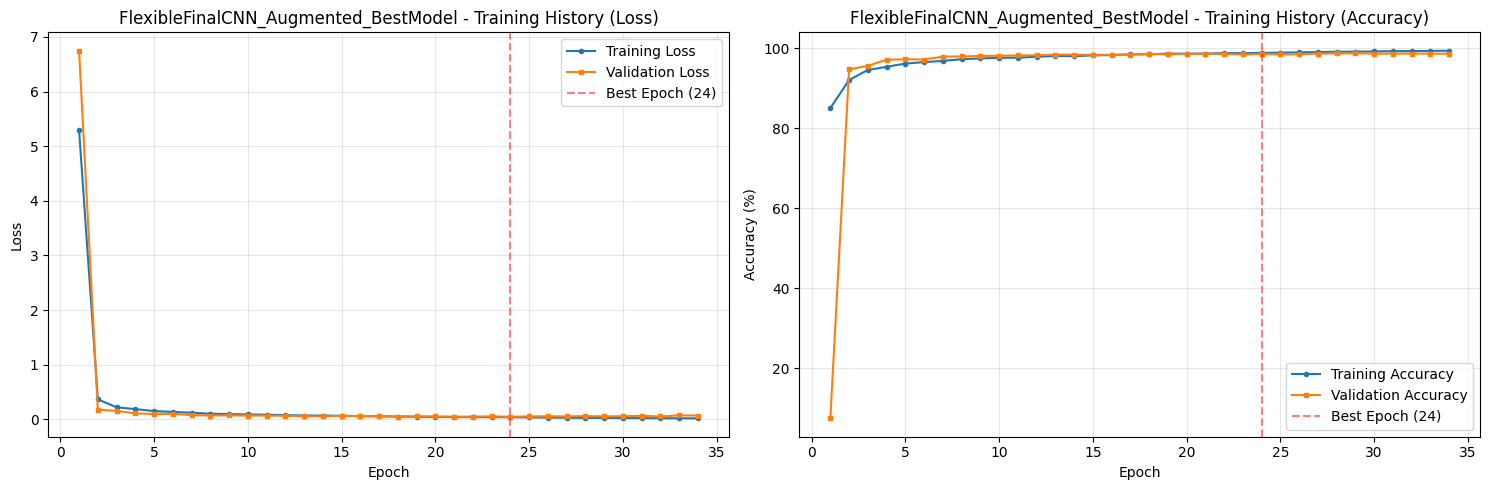


EVALUATING ON TEST SET



Testing: 100%|██████████| 11/11 [00:00<00:00, 26.41it/s]



Classification Report (FlexibleFinalCNN_Augmented_BestModel):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     18118
           1       0.93      0.78      0.85       556
           2       0.98      0.94      0.96      1448
           3       0.81      0.80      0.81       162
           4       1.00      0.99      0.99      1608

    accuracy                           0.99     21892
   macro avg       0.94      0.90      0.92     21892
weighted avg       0.99      0.99      0.99     21892



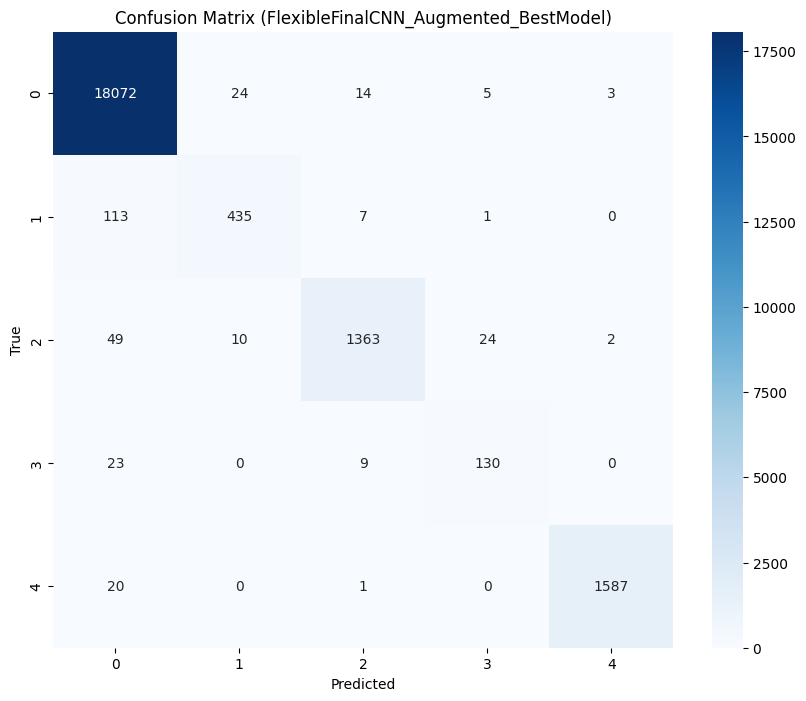


✓ Saved to: models\FlexibleFinalCNN_Augmented_BestModel_20251114_083025


In [99]:
# Step 5: Train final model
best_params['batch_size'] = 2048

final_results_vanilla = train_final_vanilla_cnn_with_loaders(
    best_params=best_params_vanilla,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    constant_filters=True,
    num_epochs=50
)

In [98]:
# Step 6: Print final results
print("\n" + "="*70)
print("VANILLA CNN - FINAL RESULTS")
print("="*70)
print(f"Best validation accuracy (search): {study_vanilla.best_value:.2f}%")
print(f"Final test accuracy: {final_results_vanilla['test_accuracy']:.2f}%")
print(f"Model saved to: {final_results_vanilla['save_dir']}")
print("="*70)


VANILLA CNN - FINAL RESULTS
Best validation accuracy (search): 98.72%
Final test accuracy: 98.63%
Model saved to: models\FlexibleFinalCNN_Augmented_BestModel_20251114_055917



TRAINING FINAL VANILLA CNN MODEL

Best Hyperparameters:
  num_filters         : 64
  kernel_size         : 9
  num_res_blocks      : 4
  pool_size           : 3
  dropout_rate        : 0.10025506193464205
  fc_neurons          : 256
  learning_rate       : 0.0007386311822067629
  weight_decay        : 6.933457118329591e-06
  pool_stride         : 2
  batch_size          : 2048

Starting training...

Starting training for FlexibleFinalCNN_Augmented_BestModel...
Early stopping enabled with patience=10


Training: 100%|██████████| 39/39 [01:38<00:00,  2.53s/it]



Epoch [1/50]
Train Loss: 7.3014, Train Acc: 85.07%
Val Loss: 3.4754, Val Acc: 33.13%
Learning Rate: 0.000886
✓ New best model saved! (Val Loss: 3.4754)
Validation loss improved to 3.4754


Training: 100%|██████████| 39/39 [01:40<00:00,  2.59s/it]



Epoch [2/50]
Train Loss: 0.3342, Train Acc: 92.35%
Val Loss: 0.2276, Val Acc: 94.58%
Learning Rate: 0.001034
✓ New best model saved! (Val Loss: 0.2276)
Validation loss improved to 0.2276


Training: 100%|██████████| 39/39 [01:40<00:00,  2.59s/it]



Epoch [3/50]
Train Loss: 0.2172, Train Acc: 94.60%
Val Loss: 0.1697, Val Acc: 95.26%
Learning Rate: 0.001182
✓ New best model saved! (Val Loss: 0.1697)
Validation loss improved to 0.1697


Training: 100%|██████████| 39/39 [01:41<00:00,  2.59s/it]



Epoch [4/50]
Train Loss: 0.1782, Train Acc: 95.55%
Val Loss: 0.1235, Val Acc: 96.54%
Learning Rate: 0.001330
✓ New best model saved! (Val Loss: 0.1235)
Validation loss improved to 0.1235


Training: 100%|██████████| 39/39 [01:40<00:00,  2.59s/it]



Epoch [5/50]
Train Loss: 0.1586, Train Acc: 96.05%
Val Loss: 0.0977, Val Acc: 97.24%
Learning Rate: 0.001477
✓ New best model saved! (Val Loss: 0.0977)
Validation loss improved to 0.0977


Training: 100%|██████████| 39/39 [01:40<00:00,  2.58s/it]



Epoch [6/50]
Train Loss: 0.1401, Train Acc: 96.42%
Val Loss: 0.0880, Val Acc: 97.60%
Learning Rate: 0.001476
✓ New best model saved! (Val Loss: 0.0880)
Validation loss improved to 0.0880


Training: 100%|██████████| 39/39 [01:40<00:00,  2.57s/it]



Epoch [7/50]
Train Loss: 0.1282, Train Acc: 96.75%
Val Loss: 0.0876, Val Acc: 97.59%
Learning Rate: 0.001474
✓ New best model saved! (Val Loss: 0.0876)
Validation loss improved to 0.0876


Training: 100%|██████████| 39/39 [01:40<00:00,  2.57s/it]



Epoch [8/50]
Train Loss: 0.1159, Train Acc: 96.97%
Val Loss: 0.1168, Val Acc: 96.97%
Learning Rate: 0.001469
EarlyStopping counter: 1 out of 10


Training: 100%|██████████| 39/39 [01:39<00:00,  2.56s/it]



Epoch [9/50]
Train Loss: 0.1073, Train Acc: 97.20%
Val Loss: 0.1123, Val Acc: 96.46%
Learning Rate: 0.001463
EarlyStopping counter: 2 out of 10


Training: 100%|██████████| 39/39 [01:40<00:00,  2.57s/it]



Epoch [10/50]
Train Loss: 0.0995, Train Acc: 97.30%
Val Loss: 0.0789, Val Acc: 97.90%
Learning Rate: 0.001455
✓ New best model saved! (Val Loss: 0.0789)
Validation loss improved to 0.0789


Training: 100%|██████████| 39/39 [01:40<00:00,  2.57s/it]



Epoch [11/50]
Train Loss: 0.0993, Train Acc: 97.40%
Val Loss: 0.1222, Val Acc: 96.69%
Learning Rate: 0.001445
EarlyStopping counter: 1 out of 10


Training: 100%|██████████| 39/39 [01:40<00:00,  2.58s/it]



Epoch [12/50]
Train Loss: 0.0937, Train Acc: 97.50%
Val Loss: 0.0689, Val Acc: 97.99%
Learning Rate: 0.001434
✓ New best model saved! (Val Loss: 0.0689)
Validation loss improved to 0.0689


Training: 100%|██████████| 39/39 [01:41<00:00,  2.60s/it]



Epoch [13/50]
Train Loss: 0.0914, Train Acc: 97.56%
Val Loss: 0.0764, Val Acc: 97.75%
Learning Rate: 0.001421
EarlyStopping counter: 1 out of 10


Training: 100%|██████████| 39/39 [01:41<00:00,  2.60s/it]



Epoch [14/50]
Train Loss: 0.0810, Train Acc: 97.79%
Val Loss: 0.0591, Val Acc: 98.14%
Learning Rate: 0.001407
✓ New best model saved! (Val Loss: 0.0591)
Validation loss improved to 0.0591


Training: 100%|██████████| 39/39 [01:39<00:00,  2.56s/it]



Epoch [15/50]
Train Loss: 0.0791, Train Acc: 97.84%
Val Loss: 0.0630, Val Acc: 98.30%
Learning Rate: 0.001391
EarlyStopping counter: 1 out of 10


Training: 100%|██████████| 39/39 [01:39<00:00,  2.55s/it]



Epoch [16/50]
Train Loss: 0.0761, Train Acc: 97.89%
Val Loss: 0.0546, Val Acc: 98.37%
Learning Rate: 0.001374
✓ New best model saved! (Val Loss: 0.0546)
Validation loss improved to 0.0546


Training: 100%|██████████| 39/39 [01:40<00:00,  2.59s/it]



Epoch [17/50]
Train Loss: 0.0719, Train Acc: 98.01%
Val Loss: 0.0622, Val Acc: 98.32%
Learning Rate: 0.001355
EarlyStopping counter: 1 out of 10


Training: 100%|██████████| 39/39 [01:41<00:00,  2.59s/it]



Epoch [18/50]
Train Loss: 0.0693, Train Acc: 98.08%
Val Loss: 0.0534, Val Acc: 98.44%
Learning Rate: 0.001335
✓ New best model saved! (Val Loss: 0.0534)
Validation loss improved to 0.0534


Training: 100%|██████████| 39/39 [01:41<00:00,  2.61s/it]



Epoch [19/50]
Train Loss: 0.0675, Train Acc: 98.09%
Val Loss: 0.0578, Val Acc: 98.40%
Learning Rate: 0.001314
EarlyStopping counter: 1 out of 10


Training: 100%|██████████| 39/39 [01:43<00:00,  2.66s/it]



Epoch [20/50]
Train Loss: 0.0624, Train Acc: 98.23%
Val Loss: 0.0577, Val Acc: 98.42%
Learning Rate: 0.001293
EarlyStopping counter: 2 out of 10


Training: 100%|██████████| 39/39 [01:42<00:00,  2.63s/it]



Epoch [21/50]
Train Loss: 0.0600, Train Acc: 98.32%
Val Loss: 0.0532, Val Acc: 98.46%
Learning Rate: 0.001270
✓ New best model saved! (Val Loss: 0.0532)
Validation loss improved to 0.0532


Training: 100%|██████████| 39/39 [01:41<00:00,  2.60s/it]



Epoch [22/50]
Train Loss: 0.0577, Train Acc: 98.36%
Val Loss: 0.0518, Val Acc: 98.45%
Learning Rate: 0.001246
✓ New best model saved! (Val Loss: 0.0518)
Validation loss improved to 0.0518


Training: 100%|██████████| 39/39 [01:41<00:00,  2.60s/it]



Epoch [23/50]
Train Loss: 0.0582, Train Acc: 98.32%
Val Loss: 0.0520, Val Acc: 98.31%
Learning Rate: 0.001222
EarlyStopping counter: 1 out of 10


Training: 100%|██████████| 39/39 [01:42<00:00,  2.62s/it]



Epoch [24/50]
Train Loss: 0.0551, Train Acc: 98.41%
Val Loss: 0.0506, Val Acc: 98.55%
Learning Rate: 0.001197
✓ New best model saved! (Val Loss: 0.0506)
Validation loss improved to 0.0506


Training: 100%|██████████| 39/39 [01:44<00:00,  2.68s/it]



Epoch [25/50]
Train Loss: 0.0511, Train Acc: 98.49%
Val Loss: 0.0478, Val Acc: 98.60%
Learning Rate: 0.001172
✓ New best model saved! (Val Loss: 0.0478)
Validation loss improved to 0.0478


Training: 100%|██████████| 39/39 [01:38<00:00,  2.53s/it]



Epoch [26/50]
Train Loss: 0.0513, Train Acc: 98.52%
Val Loss: 0.0641, Val Acc: 98.34%
Learning Rate: 0.001147
EarlyStopping counter: 1 out of 10


Training: 100%|██████████| 39/39 [01:38<00:00,  2.52s/it]



Epoch [27/50]
Train Loss: 0.0493, Train Acc: 98.54%
Val Loss: 0.0519, Val Acc: 98.54%
Learning Rate: 0.001121
EarlyStopping counter: 2 out of 10


Training: 100%|██████████| 39/39 [01:39<00:00,  2.54s/it]



Epoch [28/50]
Train Loss: 0.0506, Train Acc: 98.52%
Val Loss: 0.0476, Val Acc: 98.58%
Learning Rate: 0.001095
✓ New best model saved! (Val Loss: 0.0476)
Validation loss improved to 0.0476


Training: 100%|██████████| 39/39 [01:38<00:00,  2.53s/it]



Epoch [29/50]
Train Loss: 0.0460, Train Acc: 98.62%
Val Loss: 0.0430, Val Acc: 98.68%
Learning Rate: 0.001069
✓ New best model saved! (Val Loss: 0.0430)
Validation loss improved to 0.0430


Training: 100%|██████████| 39/39 [01:39<00:00,  2.54s/it]



Epoch [30/50]
Train Loss: 0.0462, Train Acc: 98.60%
Val Loss: 0.0470, Val Acc: 98.64%
Learning Rate: 0.001044
EarlyStopping counter: 1 out of 10


Training: 100%|██████████| 39/39 [01:38<00:00,  2.53s/it]



Epoch [31/50]
Train Loss: 0.0452, Train Acc: 98.62%
Val Loss: 0.0526, Val Acc: 98.50%
Learning Rate: 0.001019
EarlyStopping counter: 2 out of 10


Training: 100%|██████████| 39/39 [01:38<00:00,  2.53s/it]



Epoch [32/50]
Train Loss: 0.0440, Train Acc: 98.70%
Val Loss: 0.0448, Val Acc: 98.62%
Learning Rate: 0.000994
EarlyStopping counter: 3 out of 10


Training: 100%|██████████| 39/39 [01:39<00:00,  2.56s/it]



Epoch [33/50]
Train Loss: 0.0402, Train Acc: 98.78%
Val Loss: 0.0510, Val Acc: 98.61%
Learning Rate: 0.000970
EarlyStopping counter: 4 out of 10


Training: 100%|██████████| 39/39 [01:38<00:00,  2.53s/it]



Epoch [34/50]
Train Loss: 0.0405, Train Acc: 98.80%
Val Loss: 0.0479, Val Acc: 98.61%
Learning Rate: 0.000946
EarlyStopping counter: 5 out of 10


Training: 100%|██████████| 39/39 [01:39<00:00,  2.56s/it]



Epoch [35/50]
Train Loss: 0.0410, Train Acc: 98.76%
Val Loss: 0.0439, Val Acc: 98.64%
Learning Rate: 0.000923
EarlyStopping counter: 6 out of 10


Training: 100%|██████████| 39/39 [01:39<00:00,  2.55s/it]



Epoch [36/50]
Train Loss: 0.0404, Train Acc: 98.76%
Val Loss: 0.0421, Val Acc: 98.72%
Learning Rate: 0.000901
✓ New best model saved! (Val Loss: 0.0421)
Validation loss improved to 0.0421


Training: 100%|██████████| 39/39 [01:39<00:00,  2.55s/it]



Epoch [37/50]
Train Loss: 0.0379, Train Acc: 98.88%
Val Loss: 0.0400, Val Acc: 98.78%
Learning Rate: 0.000881
✓ New best model saved! (Val Loss: 0.0400)
Validation loss improved to 0.0400


Training: 100%|██████████| 39/39 [01:40<00:00,  2.58s/it]



Epoch [38/50]
Train Loss: 0.0378, Train Acc: 98.84%
Val Loss: 0.0459, Val Acc: 98.68%
Learning Rate: 0.000861
EarlyStopping counter: 1 out of 10


Training: 100%|██████████| 39/39 [01:39<00:00,  2.55s/it]



Epoch [39/50]
Train Loss: 0.0360, Train Acc: 98.93%
Val Loss: 0.0426, Val Acc: 98.65%
Learning Rate: 0.000842
EarlyStopping counter: 2 out of 10


Training: 100%|██████████| 39/39 [01:40<00:00,  2.57s/it]



Epoch [40/50]
Train Loss: 0.0350, Train Acc: 98.92%
Val Loss: 0.0467, Val Acc: 98.71%
Learning Rate: 0.000825
EarlyStopping counter: 3 out of 10


Training: 100%|██████████| 39/39 [01:39<00:00,  2.54s/it]



Epoch [41/50]
Train Loss: 0.0337, Train Acc: 98.93%
Val Loss: 0.0459, Val Acc: 98.56%
Learning Rate: 0.000809
EarlyStopping counter: 4 out of 10


Training: 100%|██████████| 39/39 [01:39<00:00,  2.54s/it]



Epoch [42/50]
Train Loss: 0.0353, Train Acc: 98.92%
Val Loss: 0.0466, Val Acc: 98.64%
Learning Rate: 0.000795
EarlyStopping counter: 5 out of 10


Training: 100%|██████████| 39/39 [01:37<00:00,  2.50s/it]



Epoch [43/50]
Train Loss: 0.0323, Train Acc: 99.02%
Val Loss: 0.0395, Val Acc: 98.82%
Learning Rate: 0.000782
✓ New best model saved! (Val Loss: 0.0395)
Validation loss improved to 0.0395


Training: 100%|██████████| 39/39 [01:39<00:00,  2.54s/it]



Epoch [44/50]
Train Loss: 0.0316, Train Acc: 99.01%
Val Loss: 0.0439, Val Acc: 98.70%
Learning Rate: 0.000771
EarlyStopping counter: 1 out of 10


Training: 100%|██████████| 39/39 [01:38<00:00,  2.53s/it]



Epoch [45/50]
Train Loss: 0.0322, Train Acc: 99.00%
Val Loss: 0.0404, Val Acc: 98.82%
Learning Rate: 0.000761
EarlyStopping counter: 2 out of 10


Training: 100%|██████████| 39/39 [01:39<00:00,  2.56s/it]



Epoch [46/50]
Train Loss: 0.0306, Train Acc: 99.03%
Val Loss: 0.0481, Val Acc: 98.69%
Learning Rate: 0.000753
EarlyStopping counter: 3 out of 10


Training: 100%|██████████| 39/39 [01:38<00:00,  2.53s/it]



Epoch [47/50]
Train Loss: 0.0302, Train Acc: 99.03%
Val Loss: 0.0417, Val Acc: 98.80%
Learning Rate: 0.000747
EarlyStopping counter: 4 out of 10


Training: 100%|██████████| 39/39 [01:38<00:00,  2.53s/it]



Epoch [48/50]
Train Loss: 0.0304, Train Acc: 99.05%
Val Loss: 0.0461, Val Acc: 98.76%
Learning Rate: 0.000742
EarlyStopping counter: 5 out of 10


Training: 100%|██████████| 39/39 [01:38<00:00,  2.53s/it]



Epoch [49/50]
Train Loss: 0.0277, Train Acc: 99.11%
Val Loss: 0.0430, Val Acc: 98.77%
Learning Rate: 0.000740
EarlyStopping counter: 6 out of 10


Training: 100%|██████████| 39/39 [01:38<00:00,  2.53s/it]



Epoch [50/50]
Train Loss: 0.0288, Train Acc: 99.11%
Val Loss: 0.0455, Val Acc: 98.80%
Learning Rate: 0.000739
EarlyStopping counter: 7 out of 10

Training Summary for FlexibleFinalCNN_Augmented_BestModel
Total epochs trained: 50
Best validation loss: 0.0395
Final train accuracy: 99.11%
Final validation accuracy: 98.80%


Generating plots...


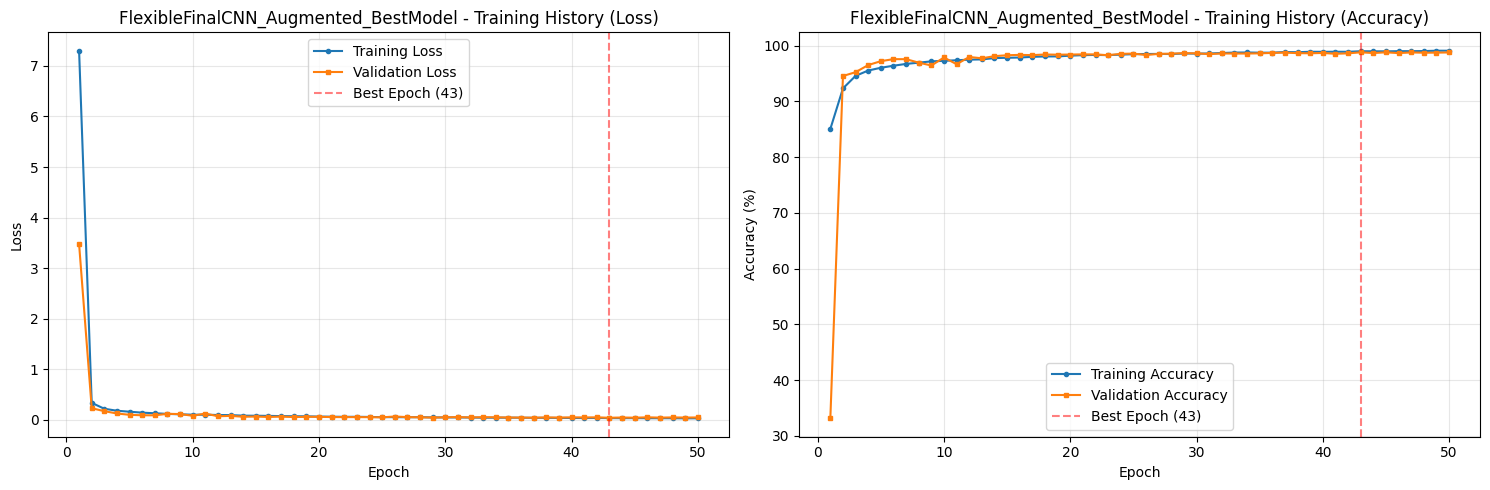


EVALUATING ON TEST SET



Testing: 100%|██████████| 11/11 [00:00<00:00, 26.62it/s]



Classification Report (FlexibleFinalCNN_Augmented_BestModel):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     18118
           1       0.86      0.84      0.85       556
           2       0.97      0.97      0.97      1448
           3       0.92      0.76      0.83       162
           4       1.00      0.99      1.00      1608

    accuracy                           0.99     21892
   macro avg       0.95      0.91      0.93     21892
weighted avg       0.99      0.99      0.99     21892



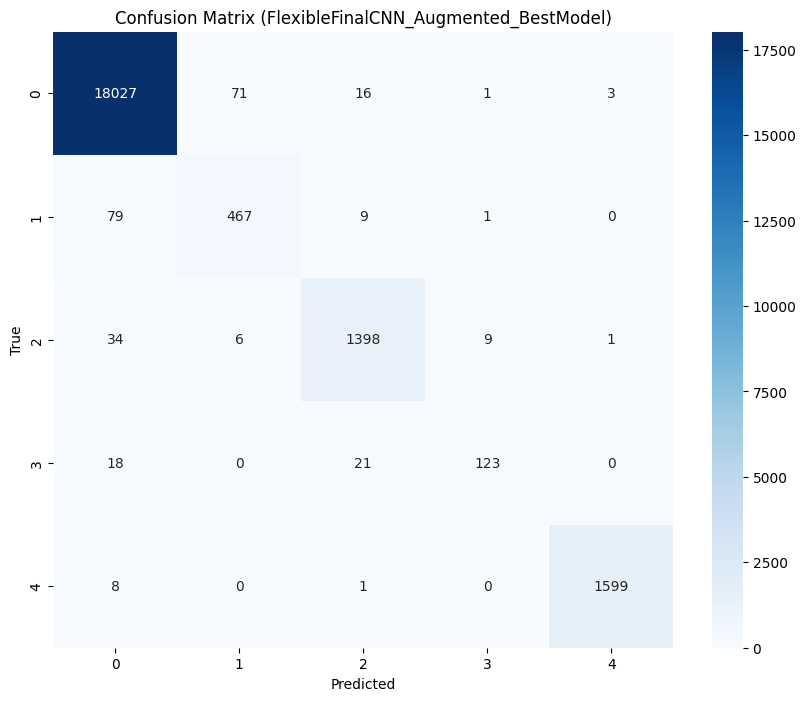


✓ Saved to: models\FlexibleFinalCNN_Augmented_BestModel_20251114_123548


In [129]:
# Step 5: Train final model
best_params['batch_size'] = 2048


final_results_vanilla = train_final_vanilla_cnn_with_loaders(
    best_params=best_params_vanilla,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    constant_filters=True,
    num_epochs=50
)